### Import necessary libraries

In [70]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import random
import optuna
from optuna import Trial, visualization
import xgboost as xgb
from optuna.samplers import TPESampler
import sklearn
from sklearn.model_selection import validation_curve
from xgboost import plot_importance
from sklearn.model_selection import KFold

In [71]:
# load training data
Xtr_loadpath = 'Xtr.csv'
Xts_loadpath = 'Xts.csv'
ytr_loadpath = 'ytr.csv'

Xtr = np.loadtxt(Xtr_loadpath, delimiter=",")
Xts = np.loadtxt(Xts_loadpath, delimiter=",")
ytr = np.loadtxt(ytr_loadpath, delimiter=",")

In [72]:
# No standardization performed

Xtr_standardized = Xtr
Xts_standardized = Xts
ytr_standardized = ytr

# Save the standardized training data
Xtr_savepath = 'Xtr_xgboost.csv'
Xts_savepath = 'Xts_xgboost.csv'
ytr_savepath = 'ytr_xgboost.csv'
yts_hat_savepath = 'yts_hat_xgboostOptuna.csv'

np.savetxt(Xtr_savepath, Xtr_standardized, delimiter=",")
np.savetxt(Xts_savepath, Xts_standardized, delimiter=",")
np.savetxt(ytr_savepath, ytr_standardized, delimiter=",")

# Perform 80:20 train:test split
X_train, X_test, y_train, y_test = train_test_split(Xtr_standardized, ytr_standardized, test_size = 0.2, random_state = random.randint(0,1000))



In [73]:
# Train a basic XG Boost model with no hyperparameter tuning

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
#print(xgb.get_xgb_params())

# Generate train and test AUC scores
aucTrain = roc_auc_score(y_train,xgb.predict(X_train,output_margin=True))
print('Training AUC: ',aucTrain)

aucTest = roc_auc_score(y_test,xgb.predict(X_test,output_margin=True))
print('Test AUC: ',aucTest)

Training AUC:  0.9975262283765404
Test AUC:  0.9054908024812743


### Compare the feature importance

[0.04803496 0.04960795 0.22771415 0.08309571 0.04655514 0.12618434
 0.13268799 0.2861198 ]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

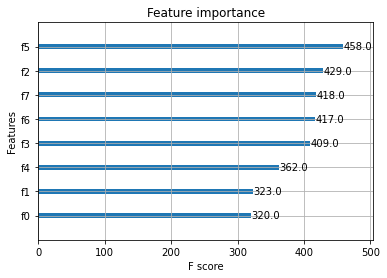

In [74]:
print(xgb.feature_importances_)
plot_importance(xgb)

### Apply Optuna hyperparameter optimization technique

In [75]:
# First, we convert the training and testing data into xgboost optimized matrix for efficiency
import xgboost as xgb

dtrain = xgb.DMatrix(X_train,y_train)
dtest  = xgb.DMatrix(X_test,y_test)


### Create objective function for first level of tuning

In [76]:
def objective(trial):
    Xtr_loadpath = 'Xtr.csv'
    Xts_loadpath = 'Xts.csv'
    ytr_loadpath = 'ytr.csv'

    Xtr = np.loadtxt(Xtr_loadpath, delimiter=",")
    Xts = np.loadtxt(Xts_loadpath, delimiter=",")
    ytr = np.loadtxt(ytr_loadpath, delimiter=",")
    
    Xtr_standardized = Xtr
    ytr_standardized = ytr
    (data, target) = Xtr_standardized, ytr_standardized
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.20, random_state = random.randint(0,1000))
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)
    
    param = {
                "n_estimators" : trial.suggest_int('n_estimators', 100, 200),
                'max_depth':trial.suggest_int('max_depth', 3, 6),
                'reg_alpha':trial.suggest_uniform('reg_alpha',0,0.8),
                'reg_lambda':trial.suggest_uniform('reg_lambda',0.8,1),
                'min_child_weight':trial.suggest_int('min_child_weight',0,1),
                'gamma':trial.suggest_uniform('gamma', 0, 0.2),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.12,0.62),
                'colsample_bytree':trial.suggest_uniform('colsample_bytree',1,1),
                'nthread' :-1
            }
        
    bst = xgb.train(param,dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    return accuracy


### Call Optuna study object for first level of tuning

In [77]:
study1 = optuna.create_study(direction='maximize',sampler=TPESampler())
study1.optimize(objective, n_trials= 1000,show_progress_bar = True)

[I 2022-12-08 19:07:36,952] A new study created in memory with name: no-name-f19f1fc9-a01c-47ba-9394-d091c8feedeb
/Users/utkarsh/opt/anaconda3/lib/python3.9/site-packages/optuna/progress_bar.py:49: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:37,131] Trial 0 finished with value: 0.85 and parameters: {'n_estimators': 117, 'max_depth': 3, 'reg_alpha': 0.035789041403757604, 'reg_lambda': 0.8008367512574437, 'min_child_weight': 1, 'gamma': 0.18937486960570213, 'learning_rate': 0.3662318228360033, 'colsample_bytree': 1.0}. Best is trial 0 with value: 0.85.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:37,418] Trial 1 finished with value: 0.841 and parameters: {'n_estimators': 123, 'max_depth': 3, 'reg_alpha': 0.03442143251503156, 'reg_lambda': 0.8999540606555786, 'min_child_weight': 0, 'gamma': 0.13878268604713362, 'learning_rate': 0.4514488328702352, 'colsample_bytree': 1.0}. Best is trial 0 with value: 0.85.
[19:07:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:37,580] Trial 2 finished with value: 0.8585 and parameters: {'n_estimators': 118, 'max_depth': 5, 'reg_alpha': 0.6959404461383474, 'reg_lambda': 0.9564966800260418, 'min_child_weight': 1, 'gamma': 0.034380968438326324, 'learning_rate': 0.14538125970831295, 'colsample_bytre

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:37,741] Trial 3 finished with value: 0.8595 and parameters: {'n_estimators': 189, 'max_depth': 4, 'reg_alpha': 0.015732815469855856, 'reg_lambda': 0.886269401179038, 'min_child_weight': 0, 'gamma': 0.0032444303447525247, 'learning_rate': 0.278215403909989, 'colsample_bytree': 1.0}. Best is trial 3 with value: 0.8595.
[19:07:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:37,914] Trial 4 finished with value: 0.852 and parameters: {'n_estimators': 199, 'max_depth': 6, 'reg_alpha': 0.7276960101485266, 'reg_lambda': 0.8329964082376139, 'min_child_weight': 0, 'gamma': 0.11430093770734598, 'learning_rate': 0.5133850613625924, 'colsample_bytr

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:38,084] Trial 5 finished with value: 0.868 and parameters: {'n_estimators': 125, 'max_depth': 6, 'reg_alpha': 0.008960476077239488, 'reg_lambda': 0.9773433677358481, 'min_child_weight': 0, 'gamma': 0.10576672257184268, 'learning_rate': 0.12485383381640897, 'colsample_bytree': 1.0}. Best is trial 5 with value: 0.868.
[19:07:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:38,238] Trial 6 finished with value: 0.8535 and parameters: {'n_estimators': 188, 'max_depth': 3, 'reg_alpha': 0.014628659040729542, 'reg_lambda': 0.8393562496929201, 'min_child_weight': 1, 'gamma': 0.11005370627889824, 'learning_rate': 0.4849595128736313, 'colsample_by

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:38,391] Trial 7 finished with value: 0.846 and parameters: {'n_estimators': 200, 'max_depth': 3, 'reg_alpha': 0.7729785050358662, 'reg_lambda': 0.8235172657336391, 'min_child_weight': 1, 'gamma': 0.08632570848430743, 'learning_rate': 0.3581372856822424, 'colsample_bytree': 1.0}. Best is trial 5 with value: 0.868.
[19:07:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:38,552] Trial 8 finished with value: 0.8745 and parameters: {'n_estimators': 171, 'max_depth': 4, 'reg_alpha': 0.40602582533903747, 'reg_lambda': 0.9023191985175214, 'min_child_weight': 1, 'gamma': 0.07396192077648682, 'learning_rate': 0.29871635515603384, 'colsample_bytre

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:38,719] Trial 9 finished with value: 0.847 and parameters: {'n_estimators': 157, 'max_depth': 5, 'reg_alpha': 0.3279471710254159, 'reg_lambda': 0.8672988618373347, 'min_child_weight': 0, 'gamma': 0.17473772776240537, 'learning_rate': 0.1437673462879995, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:38,889] Trial 10 finished with value: 0.8495 and parameters: {'n_estimators': 156, 'max_depth': 4, 'reg_alpha': 0.5034972924995658, 'reg_lambda': 0.9408672272969443, 'min_child_weight': 1, 'gamma': 0.05753891426393193, 'learning_rate': 0.2122496471862134, 'colsample_bytre

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:39,069] Trial 11 finished with value: 0.849 and parameters: {'n_estimators': 139, 'max_depth': 6, 'reg_alpha': 0.2842406832291328, 'reg_lambda': 0.9879235431794856, 'min_child_weight': 0, 'gamma': 0.06946932121549312, 'learning_rate': 0.20872840671934909, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:39,253] Trial 12 finished with value: 0.8685 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.49143623454247515, 'reg_lambda': 0.9435695274765321, 'min_child_weight': 0, 'gamma': 0.13686398491966922, 'learning_rate': 0.20824289484787414, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:39,431] Trial 13 finished with value: 0.846 and parameters: {'n_estimators': 171, 'max_depth': 5, 'reg_alpha': 0.5087627805274207, 'reg_lambda': 0.9288333550979984, 'min_child_weight': 1, 'gamma': 0.14797457880476378, 'learning_rate': 0.22027217619963074, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:39,603] Trial 14 finished with value: 0.8615 and parameters: {'n_estimators': 105, 'max_depth': 4, 'reg_alpha': 0.4884531738383674, 'reg_lambda': 0.9177640919994913, 'min_child_weight': 0, 'gamma': 0.15089866115082454, 'learning_rate': 0.28538944969124413, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:39,783] Trial 15 finished with value: 0.8545 and parameters: {'n_estimators': 171, 'max_depth': 5, 'reg_alpha': 0.19514676995075397, 'reg_lambda': 0.9573225225294406, 'min_child_weight': 1, 'gamma': 0.04029050153043343, 'learning_rate': 0.1737991089430538, 'colsample_b

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:39,955] Trial 16 finished with value: 0.8625 and parameters: {'n_estimators': 146, 'max_depth': 4, 'reg_alpha': 0.6072526861605606, 'reg_lambda': 0.8695325271227532, 'min_child_weight': 0, 'gamma': 0.13335123401536125, 'learning_rate': 0.33859371409575045, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:40,141] Trial 17 finished with value: 0.8605 and parameters: {'n_estimators': 170, 'max_depth': 5, 'reg_alpha': 0.41867400924377185, 'reg_lambda': 0.9168390595053052, 'min_child_weight': 1, 'gamma': 0.08555068118305448, 'learning_rate': 0.247816463358103, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:40,320] Trial 18 finished with value: 0.8635 and parameters: {'n_estimators': 100, 'max_depth': 4, 'reg_alpha': 0.6109269443695768, 'reg_lambda': 0.9591942437590121, 'min_child_weight': 0, 'gamma': 0.1674391793392477, 'learning_rate': 0.6066172002193002, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:40,507] Trial 19 finished with value: 0.8565 and parameters: {'n_estimators': 142, 'max_depth': 5, 'reg_alpha': 0.1863401352374973, 'reg_lambda': 0.9995687092716761, 'min_child_weight': 1, 'gamma': 0.12326293069508537, 'learning_rate': 0.16653720978665917, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:40,688] Trial 20 finished with value: 0.86 and parameters: {'n_estimators': 134, 'max_depth': 4, 'reg_alpha': 0.36575580378367273, 'reg_lambda': 0.8855136417808471, 'min_child_weight': 0, 'gamma': 0.08778532839334102, 'learning_rate': 0.31841495879144543, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:40,876] Trial 21 finished with value: 0.8465 and parameters: {'n_estimators': 127, 'max_depth': 6, 'reg_alpha': 0.24159646485347014, 'reg_lambda': 0.9777790939391865, 'min_child_weight': 0, 'gamma': 0.11099179816797287, 'learning_rate': 0.12607664000717872, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:41,060] Trial 22 finished with value: 0.841 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.4470206117248047, 'reg_lambda': 0.9736836506764982, 'min_child_weight': 0, 'gamma': 0.06411361792297184, 'learning_rate': 0.12230485461744588, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:41,250] Trial 23 finished with value: 0.8495 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.5908013279473895, 'reg_lambda': 0.9371954905798233, 'min_child_weight': 0, 'gamma': 0.09549763311397969, 'learning_rate': 0.17397080425262354, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:41,438] Trial 24 finished with value: 0.862 and parameters: {'n_estimators': 131, 'max_depth': 6, 'reg_alpha': 0.12343537246487979, 'reg_lambda': 0.9095673875326377, 'min_child_weight': 0, 'gamma': 0.0446848656545231, 'learning_rate': 0.40172195952364687, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:41,619] Trial 25 finished with value: 0.8585 and parameters: {'n_estimators': 162, 'max_depth': 5, 'reg_alpha': 0.3376277726530851, 'reg_lambda': 0.9450496854143664, 'min_child_weight': 0, 'gamma': 0.01954639780494602, 'learning_rate': 0.24490450944533032, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:41,791] Trial 26 finished with value: 0.842 and parameters: {'n_estimators': 101, 'max_depth': 4, 'reg_alpha': 0.5633171232455453, 'reg_lambda': 0.9710165707390208, 'min_child_weight': 1, 'gamma': 0.0772434758807245, 'learning_rate': 0.19974982309801775, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:41,964] Trial 27 finished with value: 0.847 and parameters: {'n_estimators': 182, 'max_depth': 5, 'reg_alpha': 0.3835984456158775, 'reg_lambda': 0.9964043211911632, 'min_child_weight': 0, 'gamma': 0.10198404924120168, 'learning_rate': 0.2974268171977242, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:42,147] Trial 28 finished with value: 0.852 and parameters: {'n_estimators': 152, 'max_depth': 6, 'reg_alpha': 0.1024985465241462, 'reg_lambda': 0.9311249398928012, 'min_child_weight': 1, 'gamma': 0.12615476786885885, 'learning_rate': 0.24702951101859197, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:42,310] Trial 29 finished with value: 0.8425 and parameters: {'n_estimators': 118, 'max_depth': 3, 'reg_alpha': 0.4341698046572937, 'reg_lambda': 0.8960412356285531, 'min_child_weight': 0, 'gamma': 0.19522302140196252, 'learning_rate': 0.4035765097251865, 'colsample_byt

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:42,486] Trial 30 finished with value: 0.831 and parameters: {'n_estimators': 111, 'max_depth': 5, 'reg_alpha': 0.2935121137291299, 'reg_lambda': 0.9491357057279327, 'min_child_weight': 1, 'gamma': 0.15762104031361415, 'learning_rate': 0.14931297873889415, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:42,657] Trial 31 finished with value: 0.8505 and parameters: {'n_estimators': 102, 'max_depth': 4, 'reg_alpha': 0.653461831548874, 'reg_lambda': 0.9538687607416226, 'min_child_weight': 0, 'gamma': 0.1787844426674736, 'learning_rate': 0.575836718230684, 'colsample_bytree

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:42,827] Trial 32 finished with value: 0.8545 and parameters: {'n_estimators': 123, 'max_depth': 4, 'reg_alpha': 0.5568883132563255, 'reg_lambda': 0.9675889029903323, 'min_child_weight': 0, 'gamma': 0.1558012254261107, 'learning_rate': 0.5600432768198916, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:42,995] Trial 33 finished with value: 0.8485 and parameters: {'n_estimators': 115, 'max_depth': 4, 'reg_alpha': 0.6515358461201719, 'reg_lambda': 0.9840979474755063, 'min_child_weight': 0, 'gamma': 0.17316895809800423, 'learning_rate': 0.4154350519475338, 'colsample_bytr

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:43,160] Trial 34 finished with value: 0.837 and parameters: {'n_estimators': 121, 'max_depth': 3, 'reg_alpha': 0.470800928802512, 'reg_lambda': 0.963027878024153, 'min_child_weight': 0, 'gamma': 0.1357445424406215, 'learning_rate': 0.6179554050677535, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:43,330] Trial 35 finished with value: 0.8345 and parameters: {'n_estimators': 108, 'max_depth': 4, 'reg_alpha': 0.5286461077403676, 'reg_lambda': 0.9308114979947681, 'min_child_weight': 0, 'gamma': 0.1660115481081515, 'learning_rate': 0.18930197034377028, 'colsample_bytree'

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:43,506] Trial 36 finished with value: 0.8545 and parameters: {'n_estimators': 128, 'max_depth': 4, 'reg_alpha': 0.6774103318240192, 'reg_lambda': 0.8637632620483159, 'min_child_weight': 0, 'gamma': 0.18478936856913875, 'learning_rate': 0.4501332398754424, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:43,673] Trial 37 finished with value: 0.828 and parameters: {'n_estimators': 180, 'max_depth': 3, 'reg_alpha': 0.7691055721156759, 'reg_lambda': 0.9061510908841425, 'min_child_weight': 0, 'gamma': 0.19979086048338218, 'learning_rate': 0.13385571579258523, 'colsample_byt

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:43,849] Trial 38 finished with value: 0.8675 and parameters: {'n_estimators': 101, 'max_depth': 5, 'reg_alpha': 0.40203683730474515, 'reg_lambda': 0.8864275352723364, 'min_child_weight': 0, 'gamma': 0.1212545212318822, 'learning_rate': 0.15804371695255381, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:44,048] Trial 39 finished with value: 0.8575 and parameters: {'n_estimators': 138, 'max_depth': 5, 'reg_alpha': 0.4036177500946095, 'reg_lambda': 0.8838354598965691, 'min_child_weight': 1, 'gamma': 0.12382892544736811, 'learning_rate': 0.15538903008357635, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:44,223] Trial 40 finished with value: 0.8565 and parameters: {'n_estimators': 165, 'max_depth': 5, 'reg_alpha': 0.3518423772365344, 'reg_lambda': 0.8501726650527868, 'min_child_weight': 0, 'gamma': 0.10561605975470943, 'learning_rate': 0.16045810652310147, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:44,399] Trial 41 finished with value: 0.8645 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.45590767903971513, 'reg_lambda': 0.8747318711726578, 'min_child_weight': 0, 'gamma': 0.14578050794098785, 'learning_rate': 0.1365895845209486, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:44,573] Trial 42 finished with value: 0.859 and parameters: {'n_estimators': 106, 'max_depth': 5, 'reg_alpha': 0.4490630456925614, 'reg_lambda': 0.8755035982856294, 'min_child_weight': 0, 'gamma': 0.14414974989175186, 'learning_rate': 0.13420481508536677, 'colsample_by

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:44,754] Trial 43 finished with value: 0.861 and parameters: {'n_estimators': 113, 'max_depth': 5, 'reg_alpha': 0.28237931252871173, 'reg_lambda': 0.8536685538401366, 'min_child_weight': 0, 'gamma': 0.11504279170791215, 'learning_rate': 0.13647615920005982, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:44,937] Trial 44 finished with value: 0.86 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.401404549891894, 'reg_lambda': 0.8075077180029944, 'min_child_weight': 0, 'gamma': 0.1372640849682913, 'learning_rate': 0.1852487223761482, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:45,118] Trial 45 finished with value: 0.856 and parameters: {'n_estimators': 122, 'max_depth': 5, 'reg_alpha': 0.06329776893010772, 'reg_lambda': 0.9020489066789598, 'min_child_weight': 0, 'gamma': 0.09286956626261571, 'learning_rate': 0.1443189878520957, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:45,300] Trial 46 finished with value: 0.8555 and parameters: {'n_estimators': 109, 'max_depth': 5, 'reg_alpha': 0.5308350652310156, 'reg_lambda': 0.9195234304997788, 'min_child_weight': 0, 'gamma': 0.11716454349461682, 'learning_rate': 0.22177958613805615, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:45,487] Trial 47 finished with value: 0.8395 and parameters: {'n_estimators': 118, 'max_depth': 6, 'reg_alpha': 0.477792788073642, 'reg_lambda': 0.8776490081923204, 'min_child_weight': 1, 'gamma': 0.05668430381177717, 'learning_rate': 0.12676434187843874, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:45,666] Trial 48 finished with value: 0.865 and parameters: {'n_estimators': 105, 'max_depth': 5, 'reg_alpha': 0.32170520480733156, 'reg_lambda': 0.889852384375062, 'min_child_weight': 0, 'gamma': 0.0803697068893058, 'learning_rate': 0.2632372109090267, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:45,841] Trial 49 finished with value: 0.859 and parameters: {'n_estimators': 189, 'max_depth': 5, 'reg_alpha': 0.2172029948660695, 'reg_lambda': 0.8942428486486717, 'min_child_weight': 1, 'gamma': 0.07648713505206192, 'learning_rate': 0.2603181933883949, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:46,026] Trial 50 finished with value: 0.842 and parameters: {'n_estimators': 147, 'max_depth': 6, 'reg_alpha': 0.14857178005507352, 'reg_lambda': 0.8601890470842521, 'min_child_weight': 0, 'gamma': 0.07807827054289265, 'learning_rate': 0.3255449462036284, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:46,211] Trial 51 finished with value: 0.8595 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.3254944590181843, 'reg_lambda': 0.8928884096442706, 'min_child_weight': 0, 'gamma': 0.12811339113636616, 'learning_rate': 0.22919360948587233, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:46,453] Trial 52 finished with value: 0.8555 and parameters: {'n_estimators': 105, 'max_depth': 5, 'reg_alpha': 0.04509029130750167, 'reg_lambda': 0.8414814150044377, 'min_child_weight': 0, 'gamma': 0.10461866454988415, 'learning_rate': 0.29067376760060537, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:46,627] Trial 53 finished with value: 0.8525 and parameters: {'n_estimators': 111, 'max_depth': 5, 'reg_alpha': 0.5052843462909261, 'reg_lambda': 0.9141315518735601, 'min_child_weight': 0, 'gamma': 0.14235282139192634, 'learning_rate': 0.26363660763339963, 'colsample_

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:46,799] Trial 54 finished with value: 0.8465 and parameters: {'n_estimators': 194, 'max_depth': 5, 'reg_alpha': 0.38075423233016464, 'reg_lambda': 0.8744797289899061, 'min_child_weight': 0, 'gamma': 0.06032415897512439, 'learning_rate': 0.12007168904096643, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:46,974] Trial 55 finished with value: 0.853 and parameters: {'n_estimators': 104, 'max_depth': 5, 'reg_alpha': 0.31028586529831376, 'reg_lambda': 0.8893154985118719, 'min_child_weight': 0, 'gamma': 0.0953285673093468, 'learning_rate': 0.17810038485333465, 'colsample_b

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:47,146] Trial 56 finished with value: 0.851 and parameters: {'n_estimators': 100, 'max_depth': 4, 'reg_alpha': 0.4514284860715508, 'reg_lambda': 0.8814955944829922, 'min_child_weight': 0, 'gamma': 0.08482879679892559, 'learning_rate': 0.354354956954331, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:47,326] Trial 57 finished with value: 0.857 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.251139674230034, 'reg_lambda': 0.922451884311828, 'min_child_weight': 0, 'gamma': 0.06918740132707389, 'learning_rate': 0.20240516491954239, 'colsample_bytree'

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:47,505] Trial 58 finished with value: 0.8615 and parameters: {'n_estimators': 108, 'max_depth': 5, 'reg_alpha': 0.42179910033571455, 'reg_lambda': 0.9011317642091596, 'min_child_weight': 0, 'gamma': 0.04591803837919849, 'learning_rate': 0.16329494426131572, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:47,686] Trial 59 finished with value: 0.843 and parameters: {'n_estimators': 180, 'max_depth': 5, 'reg_alpha': 0.3589865830851345, 'reg_lambda': 0.8666363311971662, 'min_child_weight': 1, 'gamma': 0.11673433075824245, 'learning_rate': 0.30490601440922194, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:47,872] Trial 60 finished with value: 0.863 and parameters: {'n_estimators': 175, 'max_depth': 6, 'reg_alpha': 0.4737436169234497, 'reg_lambda': 0.9408144363848241, 'min_child_weight': 0, 'gamma': 0.13213699479346588, 'learning_rate': 0.23805973417948895, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:48,051] Trial 61 finished with value: 0.8365 and parameters: {'n_estimators': 100, 'max_depth': 4, 'reg_alpha': 0.6217597359157716, 'reg_lambda': 0.9649156719756021, 'min_child_weight': 0, 'gamma': 0.16367045857120815, 'learning_rate': 0.14075885076932929, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:48,220] Trial 62 finished with value: 0.849 and parameters: {'n_estimators': 104, 'max_depth': 4, 'reg_alpha': 0.5741874123802193, 'reg_lambda': 0.9537215398069429, 'min_child_weight': 0, 'gamma': 0.15202256897478605, 'learning_rate': 0.15307685056473855, 'colsample_by

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:48,390] Trial 63 finished with value: 0.8535 and parameters: {'n_estimators': 111, 'max_depth': 4, 'reg_alpha': 0.5370160408468967, 'reg_lambda': 0.9874771154063433, 'min_child_weight': 0, 'gamma': 0.14514383486389468, 'learning_rate': 0.37872207391313445, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:48,563] Trial 64 finished with value: 0.844 and parameters: {'n_estimators': 107, 'max_depth': 4, 'reg_alpha': 0.6237446451484842, 'reg_lambda': 0.9801703876246834, 'min_child_weight': 0, 'gamma': 0.16312015736340005, 'learning_rate': 0.1287780224065147, 'colsample_byt

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:48,731] Trial 65 finished with value: 0.8595 and parameters: {'n_estimators': 116, 'max_depth': 4, 'reg_alpha': 0.7397277152768972, 'reg_lambda': 0.959211571088664, 'min_child_weight': 0, 'gamma': 0.1091507650013996, 'learning_rate': 0.49457845212507606, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:48,906] Trial 66 finished with value: 0.8495 and parameters: {'n_estimators': 104, 'max_depth': 5, 'reg_alpha': 0.38274041750363413, 'reg_lambda': 0.9769320774141329, 'min_child_weight': 0, 'gamma': 0.09911193023098981, 'learning_rate': 0.28049160578026683, 'colsample_by

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:49,080] Trial 67 finished with value: 0.8575 and parameters: {'n_estimators': 102, 'max_depth': 4, 'reg_alpha': 0.7185333060354596, 'reg_lambda': 0.9904827077604659, 'min_child_weight': 0, 'gamma': 0.11930680178338812, 'learning_rate': 0.1939749802616408, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:49,262] Trial 68 finished with value: 0.848 and parameters: {'n_estimators': 128, 'max_depth': 4, 'reg_alpha': 0.42958576867697973, 'reg_lambda': 0.9094588080425702, 'min_child_weight': 0, 'gamma': 0.17130060581353068, 'learning_rate': 0.2099253395053147, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:49,429] Trial 69 finished with value: 0.8275 and parameters: {'n_estimators': 160, 'max_depth': 3, 'reg_alpha': 0.500294868405419, 'reg_lambda': 0.9255763708405427, 'min_child_weight': 1, 'gamma': 0.08836399768426678, 'learning_rate': 0.16910732659633035, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:49,606] Trial 70 finished with value: 0.856 and parameters: {'n_estimators': 134, 'max_depth': 5, 'reg_alpha': 0.16694782741025493, 'reg_lambda': 0.9469396022540135, 'min_child_weight': 0, 'gamma': 0.02895846968170991, 'learning_rate': 0.14724187051927032, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:49,793] Trial 71 finished with value: 0.851 and parameters: {'n_estimators': 175, 'max_depth': 6, 'reg_alpha': 0.004168447832029967, 'reg_lambda': 0.9368356527051335, 'min_child_weight': 0, 'gamma': 0.13072594245664734, 'learning_rate': 0.23284663640651543, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:49,980] Trial 72 finished with value: 0.869 and parameters: {'n_estimators': 168, 'max_depth': 6, 'reg_alpha': 0.4762255529940037, 'reg_lambda': 0.9361500480710502, 'min_child_weight': 0, 'gamma': 0.15421593876402107, 'learning_rate': 0.2678984382338956, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:50,171] Trial 73 finished with value: 0.8645 and parameters: {'n_estimators': 165, 'max_depth': 6, 'reg_alpha': 0.4706734478582849, 'reg_lambda': 0.9704835298262094, 'min_child_weight': 0, 'gamma': 0.1570663685000007, 'learning_rate': 0.32789243062252044, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:50,358] Trial 74 finished with value: 0.8605 and parameters: {'n_estimators': 166, 'max_depth': 6, 'reg_alpha': 0.451097786291714, 'reg_lambda': 0.8705990246578754, 'min_child_weight': 0, 'gamma': 0.15718760536991794, 'learning_rate': 0.3157081119846525, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:50,550] Trial 75 finished with value: 0.852 and parameters: {'n_estimators': 157, 'max_depth': 6, 'reg_alpha': 0.4124536695454183, 'reg_lambda': 0.9705133318212744, 'min_child_weight': 0, 'gamma': 0.14990855972029185, 'learning_rate': 0.25836236292611947, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:50,735] Trial 76 finished with value: 0.858 and parameters: {'n_estimators': 153, 'max_depth': 6, 'reg_alpha': 0.4874319270527976, 'reg_lambda': 0.9944306225901284, 'min_child_weight': 0, 'gamma': 0.0010110554657710435, 'learning_rate': 0.3433260804285964, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:50,924] Trial 77 finished with value: 0.86 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.5202144089889426, 'reg_lambda': 0.8862434370035835, 'min_child_weight': 0, 'gamma': 0.13992841352467883, 'learning_rate': 0.27216450311170665, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.
[19:07:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:51,110] Trial 78 finished with value: 0.868 and parameters: {'n_estimators': 165, 'max_depth': 6, 'reg_alpha': 0.5425114990129245, 'reg_lambda': 0.8801728895061522, 'min_child_weight': 0, 'gamma': 0.17843771729494787, 'learning_rate': 0.27731857963312384, 'colsample_bytree': 1.0}. Best is trial 8 with value: 0.8745.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:51,297] Trial 79 finished with value: 0.876 and parameters: {'n_estimators': 166, 'max_depth': 6, 'reg_alpha': 0.5490197989189424, 'reg_lambda': 0.8976838460393203, 'min_child_weight': 0, 'gamma': 0.18401352782559585, 'learning_rate': 0.3317973782111801, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:51,482] Trial 80 finished with value: 0.85 and parameters: {'n_estimators': 169, 'max_depth': 6, 'reg_alpha': 0.5439056268437245, 'reg_lambda': 0.8989624664924996, 'min_child_weight': 1, 'gamma': 0.185362273177981, 'learning_rate': 0.30758898051455863, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:51,672] Trial 81 finished with value: 0.8645 and parameters: {'n_estimators': 160, 'max_depth': 6, 'reg_alpha': 0.5784044677260476, 'reg_lambda': 0.8798367147533682, 'min_child_weight': 0, 'gamma': 0.19109764611952035, 'learning_rate': 0.2846258251438919, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:51,859] Trial 82 finished with value: 0.8625 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.5936795965675288, 'reg_lambda': 0.858870797335429, 'min_child_weight': 0, 'gamma': 0.1795955676071269, 'learning_rate': 0.36972586284483966, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:52,047] Trial 83 finished with value: 0.861 and parameters: {'n_estimators': 169, 'max_depth': 6, 'reg_alpha': 0.557663650138845, 'reg_lambda': 0.8889855817542506, 'min_child_weight': 0, 'gamma': 0.1728925731475975, 'learning_rate': 0.2686261736275791, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:52,235] Trial 84 finished with value: 0.848 and parameters: {'n_estimators': 162, 'max_depth': 6, 'reg_alpha': 0.5051887472063702, 'reg_lambda': 0.9058690748652654, 'min_child_weight': 0, 'gamma': 0.18045618118830056, 'learning_rate': 0.2985409221159017, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:52,422] Trial 85 finished with value: 0.8605 and parameters: {'n_estimators': 154, 'max_depth': 6, 'reg_alpha': 0.4675213857389373, 'reg_lambda': 0.9157696773932336, 'min_child_weight': 0, 'gamma': 0.08101147102280147, 'learning_rate': 0.32190173714381093, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:52,613] Trial 86 finished with value: 0.864 and parameters: {'n_estimators': 167, 'max_depth': 6, 'reg_alpha': 0.42857410502579874, 'reg_lambda': 0.8917879262466719, 'min_child_weight': 0, 'gamma': 0.1913694433980458, 'learning_rate': 0.3393063491142444, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:52,795] Trial 87 finished with value: 0.867 and parameters: {'n_estimators': 183, 'max_depth': 5, 'reg_alpha': 0.08553869746524062, 'reg_lambda': 0.8703011026615354, 'min_child_weight': 0, 'gamma': 0.1215801192590771, 'learning_rate': 0.2533926429760069, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:52,976] Trial 88 finished with value: 0.854 and parameters: {'n_estimators': 181, 'max_depth': 5, 'reg_alpha': 0.13000537306923343, 'reg_lambda': 0.8962617369252114, 'min_child_weight': 0, 'gamma': 0.07273968924623565, 'learning_rate': 0.2501700270628935, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:53,158] Trial 89 finished with value: 0.8635 and parameters: {'n_estimators': 188, 'max_depth': 5, 'reg_alpha': 0.04414504452061021, 'reg_lambda': 0.8843899723281496, 'min_child_weight': 0, 'gamma': 0.12199346672646683, 'learning_rate': 0.2550407781600095, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:53,354] Trial 90 finished with value: 0.85 and parameters: {'n_estimators': 183, 'max_depth': 6, 'reg_alpha': 0.1009710153903744, 'reg_lambda': 0.8695023662299586, 'min_child_weight': 0, 'gamma': 0.10657031911579964, 'learning_rate': 0.21890151456666102, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:53,541] Trial 91 finished with value: 0.86 and parameters: {'n_estimators': 162, 'max_depth': 6, 'reg_alpha': 0.07487846908006711, 'reg_lambda': 0.8793202937547213, 'min_child_weight': 0, 'gamma': 0.18901596389509442, 'learning_rate': 0.2830897865447345, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:53,729] Trial 92 finished with value: 0.854 and parameters: {'n_estimators': 159, 'max_depth': 6, 'reg_alpha': 0.573970217650956, 'reg_lambda': 0.8809497447763651, 'min_child_weight': 0, 'gamma': 0.0996711602034756, 'learning_rate': 0.2761861159887367, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:53,915] Trial 93 finished with value: 0.8485 and parameters: {'n_estimators': 194, 'max_depth': 5, 'reg_alpha': 0.397230666408637, 'reg_lambda': 0.8444492848101357, 'min_child_weight': 0, 'gamma': 0.1365029620197581, 'learning_rate': 0.139821992020956, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:54,106] Trial 94 finished with value: 0.857 and parameters: {'n_estimators': 172, 'max_depth': 6, 'reg_alpha': 0.4871503946855785, 'reg_lambda': 0.9345793758461762, 'min_child_weight': 0, 'gamma': 0.11241358661519067, 'learning_rate': 0.29333146402769356, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:54,296] Trial 95 finished with value: 0.859 and parameters: {'n_estimators': 186, 'max_depth': 6, 'reg_alpha': 0.34628019774900937, 'reg_lambda': 0.9049889104269995, 'min_child_weight': 0, 'gamma': 0.16074293787957428, 'learning_rate': 0.32963851528194255, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:54,482] Trial 96 finished with value: 0.852 and parameters: {'n_estimators': 177, 'max_depth': 6, 'reg_alpha': 0.02093307553235247, 'reg_lambda': 0.9514004553979034, 'min_child_weight': 0, 'gamma': 0.12860840902698883, 'learning_rate': 0.24463721984515222, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:54,674] Trial 97 finished with value: 0.8535 and parameters: {'n_estimators': 150, 'max_depth': 6, 'reg_alpha': 0.6450735481388967, 'reg_lambda': 0.8728295504856901, 'min_child_weight': 0, 'gamma': 0.19667207753930618, 'learning_rate': 0.2681182463635975, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:54,854] Trial 98 finished with value: 0.8555 and parameters: {'n_estimators': 177, 'max_depth': 5, 'reg_alpha': 0.3698448358341613, 'reg_lambda': 0.8640408087150757, 'min_child_weight': 1, 'gamma': 0.053746819323911385, 'learning_rate': 0.13163044166026786, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:55,043] Trial 99 finished with value: 0.85 and parameters: {'n_estimators': 163, 'max_depth': 6, 'reg_alpha': 0.5134527416999171, 'reg_lambda': 0.9125845679374752, 'min_child_weight': 0, 'gamma': 0.1701991177925908, 'learning_rate': 0.31058885128388325, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:55,229] Trial 100 finished with value: 0.8545 and parameters: {'n_estimators': 168, 'max_depth': 5, 'reg_alpha': 0.5457768408921193, 'reg_lambda': 0.8890588383214532, 'min_child_weight': 0, 'gamma': 0.18371778039556086, 'learning_rate': 0.28713491035859656, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:55,412] Trial 101 finished with value: 0.8615 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 0.5963638661333411, 'reg_lambda': 0.876914630444875, 'min_child_weight': 0, 'gamma': 0.1764946110112204, 'learning_rate': 0.30023786223779425, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:55,592] Trial 102 finished with value: 0.8565 and parameters: {'n_estimators': 164, 'max_depth': 5, 'reg_alpha': 0.45903308729677195, 'reg_lambda': 0.8581795099046792, 'min_child_weight': 0, 'gamma': 0.14509891433748798, 'learning_rate': 0.12631648700826675, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:55,796] Trial 103 finished with value: 0.86 and parameters: {'n_estimators': 142, 'max_depth': 5, 'reg_alpha': 0.48810511901182163, 'reg_lambda': 0.9843432219706235, 'min_child_weight': 0, 'gamma': 0.14738010269671148, 'learning_rate': 0.3476590824546142, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:55,985] Trial 104 finished with value: 0.858 and parameters: {'n_estimators': 170, 'max_depth': 6, 'reg_alpha': 0.43593476806059217, 'reg_lambda': 0.9615047367406755, 'min_child_weight': 0, 'gamma': 0.15431745277975123, 'learning_rate': 0.23424927842988855, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:07:56,190] Trial 105 finished with value: 0.8625 and parameters: {'n_estimators': 110, 'max_depth': 5, 'reg_alpha': 0.4647671643199403, 'reg_lambda': 0.8971857852662632, 'min_child_weight': 0, 'gamma': 0.06609943412405198, 'learning_rate': 0.33180860372515814, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:07:56,393] Trial 106 finished with value: 0.867 and parameters: {'n_estimators': 106, 'max_depth': 5, 'reg_alpha': 0.3993173398433139, 'reg_lambda': 0.942237535100505, 'min_child_weight': 0, 'gamma': 0.1245765311175286, 'learning_rate': 0.38736816065087865, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:56,594] Trial 107 finished with value: 0.857 and parameters: {'n_estimators': 159, 'max_depth': 5, 'reg_alpha': 0.2664777518575108, 'reg_lambda': 0.8833790754415193, 'min_child_weight': 0, 'gamma': 0.12463393910875531, 'learning_rate': 0.4441917086026745, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:56,781] Trial 108 finished with value: 0.8625 and parameters: {'n_estimators': 106, 'max_depth': 5, 'reg_alpha': 0.31186207850407976, 'reg_lambda': 0.942302450841313, 'min_child_weight': 0, 'gamma': 0.11911527516674951, 'learning_rate': 0.3876765242744205, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:56,977] Trial 109 finished with value: 0.8635 and parameters: {'n_estimators': 125, 'max_depth': 6, 'reg_alpha': 0.21279869666257775, 'reg_lambda': 0.9193477506517499, 'min_child_weight': 0, 'gamma': 0.09192725357444606, 'learning_rate': 0.2407144118173006, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:07:57,159] Trial 110 finished with value: 0.8555 and parameters: {'n_estimators': 178, 'max_depth': 5, 'reg_alpha': 0.3866330668220055, 'reg_lambda': 0.9675505881643381, 'min_child_weight': 1, 'gamma': 0.1106631011234972, 'learning_rate': 0.2217620744936252, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:57,342] Trial 111 finished with value: 0.8645 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 0.44161652520360545, 'reg_lambda': 0.9265245523871348, 'min_child_weight': 0, 'gamma': 0.1351027674316909, 'learning_rate': 0.41822819837667097, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:57,523] Trial 112 finished with value: 0.8605 and parameters: {'n_estimators': 104, 'max_depth': 5, 'reg_alpha': 0.4091562676087232, 'reg_lambda': 0.9328319995121077, 'min_child_weight': 0, 'gamma': 0.1347038573052107, 'learning_rate': 0.4592024654152774, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:57,706] Trial 113 finished with value: 0.845 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 0.4345935783659698, 'reg_lambda': 0.9453850523443736, 'min_child_weight': 0, 'gamma': 0.12757813350523525, 'learning_rate': 0.12323891840074395, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:57,888] Trial 114 finished with value: 0.848 and parameters: {'n_estimators': 107, 'max_depth': 5, 'reg_alpha': 0.5747199176377348, 'reg_lambda': 0.8748648924558619, 'min_child_weight': 0, 'gamma': 0.14071228837000427, 'learning_rate': 0.156469057895031, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:58,069] Trial 115 finished with value: 0.8625 and parameters: {'n_estimators': 112, 'max_depth': 5, 'reg_alpha': 0.5226165333574888, 'reg_lambda': 0.8238263881646035, 'min_child_weight': 0, 'gamma': 0.1920626189083936, 'learning_rate': 0.2784695704856659, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:58,257] Trial 116 finished with value: 0.8675 and parameters: {'n_estimators': 165, 'max_depth': 6, 'reg_alpha': 0.06654979008859424, 'reg_lambda': 0.892600996176482, 'min_child_weight': 0, 'gamma': 0.11469973472600467, 'learning_rate': 0.25320708221722965, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:58,442] Trial 117 finished with value: 0.865 and parameters: {'n_estimators': 120, 'max_depth': 5, 'reg_alpha': 0.08642586384188097, 'reg_lambda': 0.9012942917014896, 'min_child_weight': 0, 'gamma': 0.12103599402112192, 'learning_rate': 0.2539673871888169, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:58,695] Trial 118 finished with value: 0.8595 and parameters: {'n_estimators': 120, 'max_depth': 6, 'reg_alpha': 0.06317774942483234, 'reg_lambda': 0.9015796870146489, 'min_child_weight': 0, 'gamma': 0.11432142129385435, 'learning_rate': 0.2611820826619839, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:58,883] Trial 119 finished with value: 0.8425 and parameters: {'n_estimators': 135, 'max_depth': 5, 'reg_alpha': 0.08544345440371878, 'reg_lambda': 0.8934898719676116, 'min_child_weight': 0, 'gamma': 0.12285054783067324, 'learning_rate': 0.2535970837402558, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:59,063] Trial 120 finished with value: 0.8305 and parameters: {'n_estimators': 117, 'max_depth': 3, 'reg_alpha': 0.10519418573669342, 'reg_lambda': 0.8902784349020425, 'min_child_weight': 0, 'gamma': 0.10464675820119144, 'learning_rate': 0.22801892786661318, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:59,251] Trial 121 finished with value: 0.862 and parameters: {'n_estimators': 156, 'max_depth': 6, 'reg_alpha': 0.14762568739684304, 'reg_lambda': 0.9107436900451651, 'min_child_weight': 0, 'gamma': 0.11946318254393314, 'learning_rate': 0.2667327085189947, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:07:59,441] Trial 122 finished with value: 0.851 and parameters: {'n_estimators': 109, 'max_depth': 5, 'reg_alpha': 0.015595218134900134, 'reg_lambda': 0.9250744409841732, 'min_child_weight': 0, 'gamma': 0.13158474456241426, 'learning_rate': 0.4030378123258212, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:59,630] Trial 123 finished with value: 0.865 and parameters: {'n_estimators': 106, 'max_depth': 5, 'reg_alpha': 0.11679341044469049, 'reg_lambda': 0.8864287210653498, 'min_child_weight': 0, 'gamma': 0.11114901594302533, 'learning_rate': 0.24861607851742346, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:07:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:07:59,816] Trial 124 finished with value: 0.8525 and parameters: {'n_estimators': 171, 'max_depth': 5, 'reg_alpha': 0.03232925660056013, 'reg_lambda': 0.9045228180006707, 'min_child_weight': 0, 'gamma': 0.10864889012453927, 'learning_rate': 0.2023956682544012, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:07:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:00,000] Trial 125 finished with value: 0.857 and parameters: {'n_estimators': 130, 'max_depth': 5, 'reg_alpha': 0.06913675685018418, 'reg_lambda': 0.8967592013688422, 'min_child_weight': 0, 'gamma': 0.11413691738896828, 'learning_rate': 0.24567339797794296, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:00,183] Trial 126 finished with value: 0.8555 and parameters: {'n_estimators': 167, 'max_depth': 5, 'reg_alpha': 0.09051059000403677, 'reg_lambda': 0.8868248928284378, 'min_child_weight': 0, 'gamma': 0.10070709753335927, 'learning_rate': 0.25147975981988313, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:00,372] Trial 127 finished with value: 0.8655 and parameters: {'n_estimators': 184, 'max_depth': 5, 'reg_alpha': 0.13079777926317404, 'reg_lambda': 0.8988985814170019, 'min_child_weight': 0, 'gamma': 0.12097628528932618, 'learning_rate': 0.21559941836719773, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:08:00,572] Trial 128 finished with value: 0.8595 and parameters: {'n_estimators': 165, 'max_depth': 5, 'reg_alpha': 0.037168862797162736, 'reg_lambda': 0.9076740383865073, 'min_child_weight': 0, 'gamma': 0.1209647675253086, 'learning_rate': 0.21353920108579658, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[I 2022-12-08 19:08:00,780] Trial 129 finished with value: 0.862 and parameters: {'n_estimators': 184, 'max_depth': 6, 'reg_alpha': 0.057512683900258266, 'reg_lambda': 0.9002281817244457, 'min_child_weight': 0, 'gamma': 0.11628822334231274, 'learning_rate': 0.18730027612974318, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:00,969] Trial 130 finished with value: 0.8515 and parameters: {'n_estimators': 191, 'max_depth': 6, 'reg_alpha': 0.00035525389212087005, 'reg_lambda': 0.9402820059616455, 'min_child_weight': 1, 'gamma': 0.12686197938426963, 'learning_rate': 0.1738516539371356, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:01,162] Trial 131 finished with value: 0.8555 and parameters: {'n_estimators': 198, 'max_depth': 5, 'reg_alpha': 0.05138941189270177, 'reg_lambda': 0.8949181915699729, 'min_child_weight': 0, 'gamma': 0.096001741112755, 'learning_rate': 0.2363830115848995, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:01,357] Trial 132 finished with value: 0.8605 and parameters: {'n_estimators': 106, 'max_depth': 5, 'reg_alpha': 0.12131643110761098, 'reg_lambda': 0.8849684018678243, 'min_child_weight': 0, 'gamma': 0.11188009319952587, 'learning_rate': 0.17972016193404472, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:01,547] Trial 133 finished with value: 0.8565 and parameters: {'n_estimators': 115, 'max_depth': 5, 'reg_alpha': 0.12067174377505746, 'reg_lambda': 0.8920977612311072, 'min_child_weight': 0, 'gamma': 0.10764962215777611, 'learning_rate': 0.27403113243465727, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:01,753] Trial 134 finished with value: 0.8495 and parameters: {'n_estimators': 186, 'max_depth': 5, 'reg_alpha': 0.17357449989674612, 'reg_lambda': 0.9564705812849759, 'min_child_weight': 0, 'gamma': 0.1236349061260241, 'learning_rate': 0.2577114371120773, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:01,941] Trial 135 finished with value: 0.868 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.13709918896881265, 'reg_lambda': 0.880047696796584, 'min_child_weight': 0, 'gamma': 0.08144566486043724, 'learning_rate': 0.22542334139250247, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:02,120] Trial 136 finished with value: 0.8615 and parameters: {'n_estimators': 103, 'max_depth': 5, 'reg_alpha': 0.14578905560267075, 'reg_lambda': 0.8703697793144414, 'min_child_weight': 0, 'gamma': 0.08166489338009138, 'learning_rate': 0.23004962829286038, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:02,298] Trial 137 finished with value: 0.8545 and parameters: {'n_estimators': 125, 'max_depth': 5, 'reg_alpha': 0.07978104997155483, 'reg_lambda': 0.8792608104149481, 'min_child_weight': 0, 'gamma': 0.07460239039916794, 'learning_rate': 0.22649633096545949, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:02,507] Trial 138 finished with value: 0.8655 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.1920654330773762, 'reg_lambda': 0.8658350718119807, 'min_child_weight': 0, 'gamma': 0.07021184201007301, 'learning_rate': 0.1996683388531923, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:02,699] Trial 139 finished with value: 0.8755 and parameters: {'n_estimators': 101, 'max_depth': 6, 'reg_alpha': 0.18849466541734006, 'reg_lambda': 0.8525417958149991, 'min_child_weight': 0, 'gamma': 0.07233295370273711, 'learning_rate': 0.2059541631012429, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:02,891] Trial 140 finished with value: 0.85 and parameters: {'n_estimators': 101, 'max_depth': 6, 'reg_alpha': 0.2099308544931832, 'reg_lambda': 0.8515886940728223, 'min_child_weight': 0, 'gamma': 0.06572181109800641, 'learning_rate': 0.19892658354551268, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:03,084] Trial 141 finished with value: 0.8735 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.18666495193313923, 'reg_lambda': 0.8632868666099784, 'min_child_weight': 0, 'gamma': 0.059115914304932585, 'learning_rate': 0.21460770761122178, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:03,276] Trial 142 finished with value: 0.862 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.1709507315664363, 'reg_lambda': 0.8652006125320075, 'min_child_weight': 0, 'gamma': 0.04902004065875566, 'learning_rate': 0.20795452323668187, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:03,460] Trial 143 finished with value: 0.8635 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.18923916839300012, 'reg_lambda': 0.8556037435497494, 'min_child_weight': 0, 'gamma': 0.06246562218937336, 'learning_rate': 0.21435396785577365, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:03,672] Trial 144 finished with value: 0.8595 and parameters: {'n_estimators': 101, 'max_depth': 6, 'reg_alpha': 0.2452858096285626, 'reg_lambda': 0.8605133597051319, 'min_child_weight': 0, 'gamma': 0.06996703267767485, 'learning_rate': 0.19735894395000705, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:03,858] Trial 145 finished with value: 0.8555 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.16135493078165009, 'reg_lambda': 0.8500266987932769, 'min_child_weight': 0, 'gamma': 0.05871301646037797, 'learning_rate': 0.20651768849027533, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:04,047] Trial 146 finished with value: 0.862 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.19644220823150998, 'reg_lambda': 0.868382044207906, 'min_child_weight': 0, 'gamma': 0.08501489021714814, 'learning_rate': 0.19511065746180517, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:04,238] Trial 147 finished with value: 0.848 and parameters: {'n_estimators': 179, 'max_depth': 6, 'reg_alpha': 0.14191946630379598, 'reg_lambda': 0.8607901247837534, 'min_child_weight': 0, 'gamma': 0.07068697612406655, 'learning_rate': 0.2164705392045293, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:04,425] Trial 148 finished with value: 0.858 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.23524158450276214, 'reg_lambda': 0.8360393545462393, 'min_child_weight': 0, 'gamma': 0.07486959485494199, 'learning_rate': 0.20537356312987043, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:04,615] Trial 149 finished with value: 0.858 and parameters: {'n_estimators': 175, 'max_depth': 6, 'reg_alpha': 0.1368407093472134, 'reg_lambda': 0.8462601943998279, 'min_child_weight': 0, 'gamma': 0.05347666192150796, 'learning_rate': 0.22306975109776758, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:04,809] Trial 150 finished with value: 0.8515 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.22451130918521195, 'reg_lambda': 0.8732354005932716, 'min_child_weight': 0, 'gamma': 0.03915756722962313, 'learning_rate': 0.19034919204178588, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:04,996] Trial 151 finished with value: 0.8525 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.10537252766871127, 'reg_lambda': 0.8646902415605907, 'min_child_weight': 0, 'gamma': 0.06879924533193241, 'learning_rate': 0.23989181480432803, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:05,222] Trial 152 finished with value: 0.866 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.3309033199230347, 'reg_lambda': 0.8812734565742556, 'min_child_weight': 0, 'gamma': 0.07853760457953671, 'learning_rate': 0.16796716556933597, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:05,426] Trial 153 finished with value: 0.8635 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.2695225794685155, 'reg_lambda': 0.8765181343006785, 'min_child_weight': 0, 'gamma': 0.07891156248250822, 'learning_rate': 0.17780454093871662, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:08:05,629] Trial 154 finished with value: 0.8665 and parameters: {'n_estimators': 191, 'max_depth': 6, 'reg_alpha': 0.2029930056782297, 'reg_lambda': 0.880568244243778, 'min_child_weight': 0, 'gamma': 0.0617889461784462, 'learning_rate': 0.16386067040851907, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:05,821] Trial 155 finished with value: 0.8535 and parameters: {'n_estimators': 193, 'max_depth': 6, 'reg_alpha': 0.19297989057043857, 'reg_lambda': 0.8817963828629113, 'min_child_weight': 0, 'gamma': 0.08921834317960974, 'learning_rate': 0.1622074034204312, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:06,016] Trial 156 finished with value: 0.8425 and parameters: {'n_estimators': 192, 'max_depth': 6, 'reg_alpha': 0.34235050395815786, 'reg_lambda': 0.9499445260523595, 'min_child_weight': 1, 'gamma': 0.06149140869552454, 'learning_rate': 0.14982481635304765, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:06,209] Trial 157 finished with value: 0.848 and parameters: {'n_estimators': 199, 'max_depth': 6, 'reg_alpha': 0.36657996135830867, 'reg_lambda': 0.8814947999157704, 'min_child_weight': 0, 'gamma': 0.053558809057112355, 'learning_rate': 0.16874610583390245, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:06,399] Trial 158 finished with value: 0.862 and parameters: {'n_estimators': 197, 'max_depth': 6, 'reg_alpha': 0.16380204503981827, 'reg_lambda': 0.8713467734323022, 'min_child_weight': 0, 'gamma': 0.06406449698980636, 'learning_rate': 0.15839149652793974, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:06,596] Trial 159 finished with value: 0.8495 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.42082596237761793, 'reg_lambda': 0.8561142297497837, 'min_child_weight': 0, 'gamma': 0.06709925331195404, 'learning_rate': 0.18214642014979507, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:08:06,790] Trial 160 finished with value: 0.8665 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.5419511472033388, 'reg_lambda': 0.8675060928393227, 'min_child_weight': 0, 'gamma': 0.07632692542284716, 'learning_rate': 0.1653171453227888, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:08:06,991] Trial 161 finished with value: 0.849 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.5474372299492519, 'reg_lambda': 0.8682027702417646, 'min_child_weight': 0, 'gamma': 0.07326977835645676, 'learning_rate': 0.1535151533017848, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:07,184] Trial 162 finished with value: 0.8575 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.5361801559645212, 'reg_lambda': 0.863115418565883, 'min_child_weight': 0, 'gamma': 0.08251869220825243, 'learning_rate': 0.1657367409184093, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[19:08:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:07,382] Trial 163 finished with value: 0.857 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.49538641258665667, 'reg_lambda': 0.8762342644445024, 'min_child_weight': 0, 'gamma': 0.05751176033089294, 'learning_rate': 0.1452396135023796, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:07,573] Trial 164 finished with value: 0.8555 and parameters: {'n_estimators': 187, 'max_depth': 6, 'reg_alpha': 0.2992728509542928, 'reg_lambda': 0.8866209979896242, 'min_child_weight': 0, 'gamma': 0.07861202110357059, 'learning_rate': 0.16815054280167957, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:07,768] Trial 165 finished with value: 0.855 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.395250920620909, 'reg_lambda': 0.8720055178640256, 'min_child_weight': 0, 'gamma': 0.07582849129847445, 'learning_rate': 0.1905230911136891, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:07,968] Trial 166 finished with value: 0.8575 and parameters: {'n_estimators': 168, 'max_depth': 6, 'reg_alpha': 0.5590695563062851, 'reg_lambda': 0.8656593692214732, 'min_child_weight': 0, 'gamma': 0.07131454858758175, 'learning_rate': 0.17371971622874735, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:08,225] Trial 167 finished with value: 0.857 and parameters: {'n_estimators': 182, 'max_depth': 6, 'reg_alpha': 0.5302913337468489, 'reg_lambda': 0.8791496031998017, 'min_child_weight': 0, 'gamma': 0.11708181614703085, 'learning_rate': 0.28860455215138275, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:08,406] Trial 168 finished with value: 0.8585 and parameters: {'n_estimators': 162, 'max_depth': 4, 'reg_alpha': 0.513154392290709, 'reg_lambda': 0.8897150160492758, 'min_child_weight': 0, 'gamma': 0.1304724272582368, 'learning_rate': 0.21564877873348293, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:08,591] Trial 169 finished with value: 0.8565 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.20504703855396192, 'reg_lambda': 0.8831963352573248, 'min_child_weight': 0, 'gamma': 0.06424405435003146, 'learning_rate': 0.36210106521200114, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:08,793] Trial 170 finished with value: 0.85 and parameters: {'n_estimators': 172, 'max_depth': 6, 'reg_alpha': 0.15299971019708164, 'reg_lambda': 0.9375488061237692, 'min_child_weight': 0, 'gamma': 0.1868936806696725, 'learning_rate': 0.5292814733196932, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:08,985] Trial 171 finished with value: 0.8625 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.23290668638337111, 'reg_lambda': 0.9997284469071889, 'min_child_weight': 0, 'gamma': 0.10212490132848241, 'learning_rate': 0.22274557137576542, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[19:08:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:09,205] Trial 172 finished with value: 0.8605 and parameters: {'n_estimators': 190, 'max_depth': 6, 'reg_alpha': 0.17389021393105838, 'reg_lambda': 0.8750815855484333, 'min_child_weight': 0, 'gamma': 0.08398801646183275, 'learning_rate': 0.20839972291610337, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:09,399] Trial 173 finished with value: 0.8575 and parameters: {'n_estimators': 166, 'max_depth': 6, 'reg_alpha': 0.18516352693643473, 'reg_lambda': 0.8943171818073309, 'min_child_weight': 0, 'gamma': 0.1261609547743911, 'learning_rate': 0.20055839723417354, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:09,592] Trial 174 finished with value: 0.8535 and parameters: {'n_estimators': 184, 'max_depth': 6, 'reg_alpha': 0.02490280832254036, 'reg_lambda': 0.8686142245698119, 'min_child_weight': 0, 'gamma': 0.06796480446212061, 'learning_rate': 0.18401100225191305, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:09,782] Trial 175 finished with value: 0.8525 and parameters: {'n_estimators': 142, 'max_depth': 6, 'reg_alpha': 0.17952494849238407, 'reg_lambda': 0.8012762532335682, 'min_child_weight': 0, 'gamma': 0.012257666513849394, 'learning_rate': 0.16007714690331054, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:09,972] Trial 176 finished with value: 0.8525 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.12698074023742043, 'reg_lambda': 0.9749662004629259, 'min_child_weight': 0, 'gamma': 0.16764101044554752, 'learning_rate': 0.30089048976846783, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:08:10,147] Trial 177 finished with value: 0.8485 and parameters: {'n_estimators': 195, 'max_depth': 3, 'reg_alpha': 0.09765957492991256, 'reg_lambda': 0.8781928890268103, 'min_child_weight': 0, 'gamma': 0.17600427171218802, 'learning_rate': 0.268049233660459, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:08:10,352] Trial 178 finished with value: 0.848 and parameters: {'n_estimators': 170, 'max_depth': 4, 'reg_alpha': 0.3261490197651917, 'reg_lambda': 0.929636874484385, 'min_child_weight': 1, 'gamma': 0.08954638324035036, 'learning_rate': 0.23240359605779304, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:10,546] Trial 179 finished with value: 0.8665 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.4756455398573208, 'reg_lambda': 0.8988703728682991, 'min_child_weight': 0, 'gamma': 0.07717156067358595, 'learning_rate': 0.21468842269388205, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:10,739] Trial 180 finished with value: 0.861 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.4805853277237294, 'reg_lambda': 0.8624518299119487, 'min_child_weight': 0, 'gamma': 0.07691551428658669, 'learning_rate': 0.15062567462928392, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:10,937] Trial 181 finished with value: 0.867 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.45552021671194554, 'reg_lambda': 0.8997455752924891, 'min_child_weight': 0, 'gamma': 0.07422813922634369, 'learning_rate': 0.21811116094716676, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:11,130] Trial 182 finished with value: 0.865 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.45207720232070464, 'reg_lambda': 0.9044169827051002, 'min_child_weight': 0, 'gamma': 0.07632005377974867, 'learning_rate': 0.20883065368713044, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:11,342] Trial 183 finished with value: 0.873 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.4975784053220022, 'reg_lambda': 0.9004728266989787, 'min_child_weight': 0, 'gamma': 0.18185635082581292, 'learning_rate': 0.2196016848758597, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:11,534] Trial 184 finished with value: 0.849 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.4978952884270875, 'reg_lambda': 0.8920542537729681, 'min_child_weight': 0, 'gamma': 0.08007636508803358, 'learning_rate': 0.22335735246744018, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:11,736] Trial 185 finished with value: 0.853 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.48029785583979384, 'reg_lambda': 0.897471278767165, 'min_child_weight': 0, 'gamma': 0.1994912076276804, 'learning_rate': 0.23437809315983937, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:11,923] Trial 186 finished with value: 0.854 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.5150457629557066, 'reg_lambda': 0.912103659470018, 'min_child_weight': 0, 'gamma': 0.18280496969005058, 'learning_rate': 0.21606880243038107, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:12,172] Trial 187 finished with value: 0.8555 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.4650066044086802, 'reg_lambda': 0.9076590717648435, 'min_child_weight': 0, 'gamma': 0.08446068516484097, 'learning_rate': 0.24196656753103335, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:12,368] Trial 188 finished with value: 0.8625 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.4256396138651602, 'reg_lambda': 0.902744468218893, 'min_child_weight': 0, 'gamma': 0.17997860094525572, 'learning_rate': 0.13756117776400795, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:08:12,576] Trial 189 finished with value: 0.8655 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.44517466987420934, 'reg_lambda': 0.8884704428140825, 'min_child_weight': 0, 'gamma': 0.07215378085198085, 'learning_rate': 0.22727911268516232, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:08:12,784] Trial 190 finished with value: 0.8665 and parameters: {'n_estimators': 145, 'max_depth': 6, 'reg_alpha': 0.49731709519862344, 'reg_lambda': 0.8952221364721358, 'min_child_weight': 0, 'gamma': 0.059470086836724445, 'learning_rate': 0.31287056209898917, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:12,975] Trial 191 finished with value: 0.8745 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.49684713148411075, 'reg_lambda': 0.8967700196154398, 'min_child_weight': 0, 'gamma': 0.058512530295140176, 'learning_rate': 0.2954309908088982, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:13,175] Trial 192 finished with value: 0.8575 and parameters: {'n_estimators': 144, 'max_depth': 6, 'reg_alpha': 0.49024167761353876, 'reg_lambda': 0.8975789790395089, 'min_child_weight': 0, 'gamma': 0.06501236721508029, 'learning_rate': 0.31728319936873445, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:13,370] Trial 193 finished with value: 0.861 and parameters: {'n_estimators': 137, 'max_depth': 6, 'reg_alpha': 0.5034283216992675, 'reg_lambda': 0.8944128444774331, 'min_child_weight': 0, 'gamma': 0.054792975322135666, 'learning_rate': 0.29519237550921523, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:13,561] Trial 194 finished with value: 0.8475 and parameters: {'n_estimators': 149, 'max_depth': 6, 'reg_alpha': 0.5257736205223515, 'reg_lambda': 0.9008429275755988, 'min_child_weight': 0, 'gamma': 0.054417353629305505, 'learning_rate': 0.31286344284587003, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:13,755] Trial 195 finished with value: 0.85 and parameters: {'n_estimators': 163, 'max_depth': 6, 'reg_alpha': 0.46874284801503924, 'reg_lambda': 0.8919589114142704, 'min_child_weight': 0, 'gamma': 0.047108403270246534, 'learning_rate': 0.30652921363260544, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:13,951] Trial 196 finished with value: 0.853 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.5596149177847112, 'reg_lambda': 0.899288991930029, 'min_child_weight': 0, 'gamma': 0.05941330206885579, 'learning_rate': 0.2913530625774906, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:14,144] Trial 197 finished with value: 0.872 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.511395742622898, 'reg_lambda': 0.8846015453022607, 'min_child_weight': 0, 'gamma': 0.051286744653003966, 'learning_rate': 0.27793654395152695, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:14,340] Trial 198 finished with value: 0.855 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.543540366545574, 'reg_lambda': 0.8865404229152488, 'min_child_weight': 0, 'gamma': 0.04102726410900382, 'learning_rate': 0.2795918277887642, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:14,533] Trial 199 finished with value: 0.8675 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.5241999949504863, 'reg_lambda': 0.908121793973713, 'min_child_weight': 0, 'gamma': 0.042689883929217604, 'learning_rate': 0.2742650174146202, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:14,730] Trial 200 finished with value: 0.855 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.5234063856590978, 'reg_lambda': 0.9068217581601185, 'min_child_weight': 1, 'gamma': 0.050792223525951787, 'learning_rate': 0.2786667815873921, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:14,927] Trial 201 finished with value: 0.8545 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.5008119398502241, 'reg_lambda': 0.8971103893664101, 'min_child_weight': 0, 'gamma': 0.0440005584243844, 'learning_rate': 0.26374076461007806, 'colsample_bytree': 1.0}. Best is trial 79 with value: 0.876.
[19:08:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:15,129] Trial 202 finished with value: 0.8795 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.5159752705171954, 'reg_lambda': 0.9444025416974391, 'min_child_weight': 0, 'gamma': 0.03683096047377513, 'learning_rate': 0.27191352392357776, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:15,322] Trial 203 finished with value: 0.849 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.5162585078320097, 'reg_lambda': 0.9433773647674341, 'min_child_weight': 0, 'gamma': 0.03244565889783632, 'learning_rate': 0.2846237505206696, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:15,519] Trial 204 finished with value: 0.862 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.48249822600058295, 'reg_lambda': 0.9551496761969505, 'min_child_weight': 0, 'gamma': 0.04422999151422642, 'learning_rate': 0.26424932406643137, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:15,710] Trial 205 finished with value: 0.8485 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.45843692725240565, 'reg_lambda': 0.9154475748429635, 'min_child_weight': 0, 'gamma': 0.0361500972974113, 'learning_rate': 0.27448364419184823, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:15,888] Trial 206 finished with value: 0.862 and parameters: {'n_estimators': 105, 'max_depth': 4, 'reg_alpha': 0.5096042785458821, 'reg_lambda': 0.9471398770736983, 'min_child_weight': 0, 'gamma': 0.048426876896994334, 'learning_rate': 0.2562843836631549, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:16,076] Trial 207 finished with value: 0.8495 and parameters: {'n_estimators': 160, 'max_depth': 6, 'reg_alpha': 0.4900494843713547, 'reg_lambda': 0.9377833608312933, 'min_child_weight': 0, 'gamma': 0.03317706938795001, 'learning_rate': 0.29443775112583054, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:16,275] Trial 208 finished with value: 0.8585 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.5320572921397695, 'reg_lambda': 0.9097512192653531, 'min_child_weight': 0, 'gamma': 0.04026657941442859, 'learning_rate': 0.272754503160778, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:16,463] Trial 209 finished with value: 0.8665 and parameters: {'n_estimators': 168, 'max_depth': 6, 'reg_alpha': 0.5004270706981646, 'reg_lambda': 0.922162056051734, 'min_child_weight': 0, 'gamma': 0.05735365246574987, 'learning_rate': 0.2869347934072729, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:16,677] Trial 210 finished with value: 0.8595 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.5772282364067245, 'reg_lambda': 0.9329526115912434, 'min_child_weight': 0, 'gamma': 0.18699621733348934, 'learning_rate': 0.24999700338232872, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:16,864] Trial 211 finished with value: 0.8675 and parameters: {'n_estimators': 165, 'max_depth': 6, 'reg_alpha': 0.4727847206807195, 'reg_lambda': 0.9023057106224074, 'min_child_weight': 0, 'gamma': 0.04850261581559913, 'learning_rate': 0.30490100619685323, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:17,058] Trial 212 finished with value: 0.8555 and parameters: {'n_estimators': 166, 'max_depth': 6, 'reg_alpha': 0.5499627042139108, 'reg_lambda': 0.9199884898617688, 'min_child_weight': 0, 'gamma': 0.045940854377461905, 'learning_rate': 0.2841718343691988, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:17,253] Trial 213 finished with value: 0.8595 and parameters: {'n_estimators': 165, 'max_depth': 6, 'reg_alpha': 0.5331718329692978, 'reg_lambda': 0.9040626020857089, 'min_child_weight': 0, 'gamma': 0.04993674191597637, 'learning_rate': 0.2691426189643946, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:17,447] Trial 214 finished with value: 0.8685 and parameters: {'n_estimators': 170, 'max_depth': 6, 'reg_alpha': 0.4725525721455975, 'reg_lambda': 0.9021973120861936, 'min_child_weight': 0, 'gamma': 0.02779193401433021, 'learning_rate': 0.2954657637144996, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:17,642] Trial 215 finished with value: 0.854 and parameters: {'n_estimators': 168, 'max_depth': 6, 'reg_alpha': 0.4122363191903217, 'reg_lambda': 0.9037238201163914, 'min_child_weight': 0, 'gamma': 0.022575940641728506, 'learning_rate': 0.3223233585157298, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:17,836] Trial 216 finished with value: 0.8625 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.5194745589359393, 'reg_lambda': 0.9524376124627038, 'min_child_weight': 0, 'gamma': 0.023855814155803255, 'learning_rate': 0.3051414558853582, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:18,032] Trial 217 finished with value: 0.8645 and parameters: {'n_estimators': 171, 'max_depth': 6, 'reg_alpha': 0.46487802695431146, 'reg_lambda': 0.8910906423424784, 'min_child_weight': 0, 'gamma': 0.029574263302777494, 'learning_rate': 0.2928862504648174, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:18,324] Trial 218 finished with value: 0.853 and parameters: {'n_estimators': 162, 'max_depth': 6, 'reg_alpha': 0.5679453368133347, 'reg_lambda': 0.9417821839840883, 'min_child_weight': 0, 'gamma': 0.038454601024457316, 'learning_rate': 0.4229937971673611, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[I 2022-12-08 19:08:18,520] Trial 219 finished with value: 0.863 and parameters: {'n_estimators': 169, 'max_depth': 6, 'reg_alpha': 0.48273617176977174, 'reg_lambda': 0.8945778981956073, 'min_child_weight': 0, 'gamma': 0.04279477039295164, 'learning_rate': 0.33667345597726855, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:18,708] Trial 220 finished with value: 0.8425 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.47319211265546435, 'reg_lambda': 0.900401113371695, 'min_child_weight': 0, 'gamma': 0.015352910172753462, 'learning_rate': 0.29928623795901055, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:18,894] Trial 221 finished with value: 0.8495 and parameters: {'n_estimators': 166, 'max_depth': 6, 'reg_alpha': 0.5065054599127621, 'reg_lambda': 0.9081767553385558, 'min_child_weight': 0, 'gamma': 0.051135252325071066, 'learning_rate': 0.2892401658379269, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:19,076] Trial 222 finished with value: 0.8455 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.5401197602792664, 'reg_lambda': 0.8943876338654474, 'min_child_weight': 0, 'gamma': 0.02752554935998641, 'learning_rate': 0.31759399400557264, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:19,259] Trial 223 finished with value: 0.863 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.44701691554395434, 'reg_lambda': 0.8850194085908751, 'min_child_weight': 0, 'gamma': 0.03701086728966423, 'learning_rate': 0.3012466571185706, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:19,509] Trial 224 finished with value: 0.856 and parameters: {'n_estimators': 164, 'max_depth': 6, 'reg_alpha': 0.5015155263885083, 'reg_lambda': 0.904657444636421, 'min_child_weight': 0, 'gamma': 0.19349592466257065, 'learning_rate': 0.28071879813958645, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:19,710] Trial 225 finished with value: 0.863 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.3869235429547907, 'reg_lambda': 0.8832625342315231, 'min_child_weight': 0, 'gamma': 0.1821391939119041, 'learning_rate': 0.27606472747247063, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:19,904] Trial 226 finished with value: 0.859 and parameters: {'n_estimators': 168, 'max_depth': 6, 'reg_alpha': 0.49278637445189394, 'reg_lambda': 0.9469612148967602, 'min_child_weight': 0, 'gamma': 0.05694397754269763, 'learning_rate': 0.2683993166863808, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:20,088] Trial 227 finished with value: 0.8625 and parameters: {'n_estimators': 170, 'max_depth': 6, 'reg_alpha': 0.5075999804238782, 'reg_lambda': 0.9107122985733443, 'min_child_weight': 0, 'gamma': 0.057325943477128695, 'learning_rate': 0.2836478718955456, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:20,274] Trial 228 finished with value: 0.8625 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.4886679905906949, 'reg_lambda': 0.9001345728983924, 'min_child_weight': 0, 'gamma': 0.062222388986896957, 'learning_rate': 0.3069366096442396, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:20,460] Trial 229 finished with value: 0.848 and parameters: {'n_estimators': 164, 'max_depth': 6, 'reg_alpha': 0.5212461610566032, 'reg_lambda': 0.8898873061013332, 'min_child_weight': 0, 'gamma': 0.05308066338608774, 'learning_rate': 0.26152564952464685, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:20,657] Trial 230 finished with value: 0.864 and parameters: {'n_estimators': 167, 'max_depth': 6, 'reg_alpha': 0.43501411676297, 'reg_lambda': 0.9236489568257399, 'min_child_weight': 0, 'gamma': 0.11388909508765953, 'learning_rate': 0.2898704151543981, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:20,843] Trial 231 finished with value: 0.8615 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.47095480492839153, 'reg_lambda': 0.9013818260931541, 'min_child_weight': 0, 'gamma': 0.1739713573240742, 'learning_rate': 0.21389884416382812, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:21,026] Trial 232 finished with value: 0.857 and parameters: {'n_estimators': 132, 'max_depth': 6, 'reg_alpha': 0.5439769813709107, 'reg_lambda': 0.8965444464475796, 'min_child_weight': 0, 'gamma': 0.06768496756864355, 'learning_rate': 0.13173773751476725, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:21,208] Trial 233 finished with value: 0.854 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.5297287738033698, 'reg_lambda': 0.848479618031609, 'min_child_weight': 0, 'gamma': 0.0626603828427389, 'learning_rate': 0.3074034958043391, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:21,391] Trial 234 finished with value: 0.859 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.453959346779803, 'reg_lambda': 0.8994905788509806, 'min_child_weight': 0, 'gamma': 0.0740505082696847, 'learning_rate': 0.35039251164315816, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:21,574] Trial 235 finished with value: 0.8725 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.058078593070487475, 'reg_lambda': 0.8881433751871437, 'min_child_weight': 0, 'gamma': 0.11877392716355405, 'learning_rate': 0.3258923099265688, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:21,760] Trial 236 finished with value: 0.875 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.0474522135443195, 'reg_lambda': 0.9282588474083493, 'min_child_weight': 0, 'gamma': 0.11809347199659063, 'learning_rate': 0.3255777257520857, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:21,942] Trial 237 finished with value: 0.8575 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.05701652098996644, 'reg_lambda': 0.8899857612452658, 'min_child_weight': 0, 'gamma': 0.11813546309208535, 'learning_rate': 0.3275259021647383, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:22,115] Trial 238 finished with value: 0.8595 and parameters: {'n_estimators': 107, 'max_depth': 4, 'reg_alpha': 0.05148411448315205, 'reg_lambda': 0.9382909354357626, 'min_child_weight': 0, 'gamma': 0.1212079449252167, 'learning_rate': 0.33498582064685345, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:22,339] Trial 239 finished with value: 0.864 and parameters: {'n_estimators': 101, 'max_depth': 6, 'reg_alpha': 0.03371077061817442, 'reg_lambda': 0.9352599517108893, 'min_child_weight': 0, 'gamma': 0.11594739594992291, 'learning_rate': 0.3705488872933348, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:22,528] Trial 240 finished with value: 0.856 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.01778534802380466, 'reg_lambda': 0.9287785803219205, 'min_child_weight': 1, 'gamma': 0.1254369597619483, 'learning_rate': 0.297989048963405, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:22,716] Trial 241 finished with value: 0.849 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.07091750371960445, 'reg_lambda': 0.8863891085506546, 'min_child_weight': 0, 'gamma': 0.10971887141772706, 'learning_rate': 0.22034321171629592, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[I 2022-12-08 19:08:22,906] Trial 242 finished with value: 0.856 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.032320994126618784, 'reg_lambda': 0.9297931572016633, 'min_child_weight': 0, 'gamma': 0.12390319695046725, 'learning_rate': 0.2781395431973429, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:23,091] Trial 243 finished with value: 0.865 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.0019888514950400366, 'reg_lambda': 0.9415302116638121, 'min_child_weight': 0, 'gamma': 0.12914994509459532, 'learning_rate': 0.31804342135520147, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:23,276] Trial 244 finished with value: 0.858 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.4771247008056039, 'reg_lambda': 0.8827721580917842, 'min_child_weight': 0, 'gamma': 0.11890864207537138, 'learning_rate': 0.34303894141968666, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:23,465] Trial 245 finished with value: 0.87 and parameters: {'n_estimators': 169, 'max_depth': 6, 'reg_alpha': 0.03985625926607327, 'reg_lambda': 0.9223974671172738, 'min_child_weight': 0, 'gamma': 0.11431366083951155, 'learning_rate': 0.2589037530864791, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:23,665] Trial 246 finished with value: 0.852 and parameters: {'n_estimators': 171, 'max_depth': 5, 'reg_alpha': 0.0766071085725704, 'reg_lambda': 0.9160258990181385, 'min_child_weight': 0, 'gamma': 0.11430094007608535, 'learning_rate': 0.2572582051463829, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:23,855] Trial 247 finished with value: 0.853 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.04672525843332609, 'reg_lambda': 0.8410688544127304, 'min_child_weight': 0, 'gamma': 0.10221629758955436, 'learning_rate': 0.3263860795057285, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:08:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:24,077] Trial 248 finished with value: 0.86 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.04924636603147645, 'reg_lambda': 0.9344863253183461, 'min_child_weight': 0, 'gamma': 0.10811661409648354, 'learning_rate': 0.38946317783544593, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[I 2022-12-08 19:08:24,279] Trial 249 finished with value: 0.8555 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.06428058458182263, 'reg_lambda': 0.8872343821310903, 'min_child_weight': 0, 'gamma': 0.11434784319746308, 'learning_rate': 0.2469055974797795, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:24,477] Trial 250 finished with value: 0.8525 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.03888019886259751, 'reg_lambda': 0.8938100824576303, 'min_child_weight': 0, 'gamma': 0.1514272320683067, 'learning_rate': 0.2707125720625513, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:24,660] Trial 251 finished with value: 0.856 and parameters: {'n_estimators': 176, 'max_depth': 5, 'reg_alpha': 0.018526035272974882, 'reg_lambda': 0.8785030166267116, 'min_child_weight': 0, 'gamma': 0.1206897225413356, 'learning_rate': 0.25888939412479794, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:24,841] Trial 252 finished with value: 0.852 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.08481427172422051, 'reg_lambda': 0.8543148021919795, 'min_child_weight': 0, 'gamma': 0.13956658968593716, 'learning_rate': 0.2039800875490962, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:25,026] Trial 253 finished with value: 0.861 and parameters: {'n_estimators': 155, 'max_depth': 6, 'reg_alpha': 0.015394008131363844, 'reg_lambda': 0.9043713016573723, 'min_child_weight': 0, 'gamma': 0.1051015536595277, 'learning_rate': 0.3170040288082609, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:25,209] Trial 254 finished with value: 0.861 and parameters: {'n_estimators': 169, 'max_depth': 6, 'reg_alpha': 0.3729659203572298, 'reg_lambda': 0.9179298511554411, 'min_child_weight': 0, 'gamma': 0.04639929398424592, 'learning_rate': 0.29129235430608175, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:25,389] Trial 255 finished with value: 0.858 and parameters: {'n_estimators': 161, 'max_depth': 5, 'reg_alpha': 0.4081831884461104, 'reg_lambda': 0.881453416477377, 'min_child_weight': 0, 'gamma': 0.0963689954250218, 'learning_rate': 0.12001430663088994, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:25,572] Trial 256 finished with value: 0.8505 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.5618703826837695, 'reg_lambda': 0.9446121106641586, 'min_child_weight': 0, 'gamma': 0.1111500416416893, 'learning_rate': 0.24389162468170056, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:25,755] Trial 257 finished with value: 0.855 and parameters: {'n_estimators': 166, 'max_depth': 6, 'reg_alpha': 0.09602367702301798, 'reg_lambda': 0.9269210226022093, 'min_child_weight': 0, 'gamma': 0.17838932936644114, 'learning_rate': 0.2646247848360071, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:25,942] Trial 258 finished with value: 0.8585 and parameters: {'n_estimators': 168, 'max_depth': 6, 'reg_alpha': 0.5032868912473599, 'reg_lambda': 0.9223950555980168, 'min_child_weight': 0, 'gamma': 0.11712379792405146, 'learning_rate': 0.284257632567836, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:26,128] Trial 259 finished with value: 0.8705 and parameters: {'n_estimators': 164, 'max_depth': 6, 'reg_alpha': 0.48972230898535024, 'reg_lambda': 0.9202877094621811, 'min_child_weight': 0, 'gamma': 0.18795829337405992, 'learning_rate': 0.27220785795075664, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:26,302] Trial 260 finished with value: 0.851 and parameters: {'n_estimators': 163, 'max_depth': 4, 'reg_alpha': 0.0594812926651743, 'reg_lambda': 0.9109660709830225, 'min_child_weight': 0, 'gamma': 0.12411734898386254, 'learning_rate': 0.2735419984295471, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:26,486] Trial 261 finished with value: 0.8585 and parameters: {'n_estimators': 165, 'max_depth': 6, 'reg_alpha': 0.03457576040115723, 'reg_lambda': 0.9142517773039369, 'min_child_weight': 0, 'gamma': 0.18673323092883148, 'learning_rate': 0.25262526131007174, 'colsampl

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:26,727] Trial 262 finished with value: 0.8525 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 0.46105844164866594, 'reg_lambda': 0.9245717301910862, 'min_child_weight': 1, 'gamma': 0.16221070955185965, 'learning_rate': 0.26297883861831506, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:26,932] Trial 263 finished with value: 0.863 and parameters: {'n_estimators': 164, 'max_depth': 6, 'reg_alpha': 0.07246262851781946, 'reg_lambda': 0.904575986955905, 'min_child_weight': 0, 'gamma': 0.131918240527216, 'learning_rate': 0.27623124261262866, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:27,147] Trial 264 finished with value: 0.87 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.7861954878939048, 'reg_lambda': 0.9344149868052489, 'min_child_weight': 0, 'gamma': 0.1907157183525383, 'learning_rate': 0.22950775949192914, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:27,359] Trial 265 finished with value: 0.863 and parameters: {'n_estimators': 169, 'max_depth': 6, 'reg_alpha': 0.4864150150022209, 'reg_lambda': 0.9327926547235915, 'min_child_weight': 0, 'gamma': 0.19055374862623436, 'learning_rate': 0.23032486182338519, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:27,552] Trial 266 finished with value: 0.861 and parameters: {'n_estimators': 157, 'max_depth': 6, 'reg_alpha': 0.797871033438896, 'reg_lambda': 0.9307621942082944, 'min_child_weight': 0, 'gamma': 0.1843621356360013, 'learning_rate': 0.24346328992663696, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:27,742] Trial 267 finished with value: 0.8635 and parameters: {'n_estimators': 172, 'max_depth': 6, 'reg_alpha': 0.7475196054868107, 'reg_lambda': 0.9277307313010622, 'min_child_weight': 0, 'gamma': 0.18948540357534546, 'learning_rate': 0.22449277420946126, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:28,027] Trial 268 finished with value: 0.8465 and parameters: {'n_estimators': 171, 'max_depth': 6, 'reg_alpha': 0.4398210998066303, 'reg_lambda': 0.9388804856320878, 'min_child_weight': 0, 'gamma': 0.19279549484714414, 'learning_rate': 0.21015859335422712, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:08:28,235] Trial 269 finished with value: 0.8705 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.6772445723981781, 'reg_lambda': 0.9193539331784744, 'min_child_weight': 0, 'gamma': 0.18507595105897356, 'learning_rate': 0.22200667400456633, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:08:28,443] Trial 270 finished with value: 0.856 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.6407818607795899, 'reg_lambda': 0.9191680110661599, 'min_child_weight': 0, 'gamma': 0.18229114541276795, 'learning_rate': 0.2370048901609669, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[I 2022-12-08 19:08:28,646] Trial 271 finished with value: 0.855 and parameters: {'n_estimators': 167, 'max_depth': 6, 'reg_alpha': 0.7349104769076085, 'reg_lambda': 0.9214858169037298, 'min_child_weight': 0, 'gamma': 0.18599447392107232, 'learning_rate': 0.29541206459304875, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:28,838] Trial 272 finished with value: 0.854 and parameters: {'n_estimators': 178, 'max_depth': 6, 'reg_alpha': 0.7569029386696086, 'reg_lambda': 0.9320020397088424, 'min_child_weight': 0, 'gamma': 0.19492674576598923, 'learning_rate': 0.2372677321086247, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:29,032] Trial 273 finished with value: 0.861 and parameters: {'n_estimators': 172, 'max_depth': 6, 'reg_alpha': 0.6904372798784164, 'reg_lambda': 0.9172353643182299, 'min_child_weight': 0, 'gamma': 0.1906539244712667, 'learning_rate': 0.22516937320454974, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:29,221] Trial 274 finished with value: 0.868 and parameters: {'n_estimators': 175, 'max_depth': 6, 'reg_alpha': 0.7040444608352592, 'reg_lambda': 0.9255438253618878, 'min_child_weight': 0, 'gamma': 0.17894354384224193, 'learning_rate': 0.25350818662794555, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:29,412] Trial 275 finished with value: 0.8585 and parameters: {'n_estimators': 175, 'max_depth': 6, 'reg_alpha': 0.590685987459141, 'reg_lambda': 0.9278321209169789, 'min_child_weight': 0, 'gamma': 0.17201503700144788, 'learning_rate': 0.26670902717112216, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:29,605] Trial 276 finished with value: 0.859 and parameters: {'n_estimators': 177, 'max_depth': 6, 'reg_alpha': 0.7911117063338902, 'reg_lambda': 0.9250705843732547, 'min_child_weight': 0, 'gamma': 0.17775547418607204, 'learning_rate': 0.25578871373342876, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:29,805] Trial 277 finished with value: 0.866 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.7753026422693375, 'reg_lambda': 0.9134190992115873, 'min_child_weight': 0, 'gamma': 0.17683161684665502, 'learning_rate': 0.3035109851905955, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:29,991] Trial 278 finished with value: 0.855 and parameters: {'n_estimators': 170, 'max_depth': 6, 'reg_alpha': 0.7100097963261716, 'reg_lambda': 0.9215924717650827, 'min_child_weight': 0, 'gamma': 0.16797627104090893, 'learning_rate': 0.28212881116578475, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:30,221] Trial 279 finished with value: 0.859 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.6789551253969385, 'reg_lambda': 0.9791427202610683, 'min_child_weight': 0, 'gamma': 0.17919782990986424, 'learning_rate': 0.3294483645519117, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:30,414] Trial 280 finished with value: 0.8735 and parameters: {'n_estimators': 171, 'max_depth': 6, 'reg_alpha': 0.7038791271854815, 'reg_lambda': 0.8308371271891303, 'min_child_weight': 1, 'gamma': 0.18320498941689364, 'learning_rate': 0.2725952224191965, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[I 2022-12-08 19:08:30,594] Trial 281 finished with value: 0.858 and parameters: {'n_estimators': 175, 'max_depth': 4, 'reg_alpha': 0.7122357361092827, 'reg_lambda': 0.8236073364288474, 'min_child_weight': 1, 'gamma': 0.18286669279398463, 'learning_rate': 0.27161517707935867, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:30,785] Trial 282 finished with value: 0.866 and parameters: {'n_estimators': 171, 'max_depth': 6, 'reg_alpha': 0.717336546010717, 'reg_lambda': 0.9077657236657435, 'min_child_weight': 1, 'gamma': 0.18883266027487886, 'learning_rate': 0.28466256750720703, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:30,956] Trial 283 finished with value: 0.8445 and parameters: {'n_estimators': 170, 'max_depth': 3, 'reg_alpha': 0.694900978738031, 'reg_lambda': 0.8289371137810887, 'min_child_weight': 1, 'gamma': 0.18486707116171144, 'learning_rate': 0.2606511708869219, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:31,139] Trial 284 finished with value: 0.857 and parameters: {'n_estimators': 167, 'max_depth': 6, 'reg_alpha': 0.659989861368304, 'reg_lambda': 0.8314466375981882, 'min_child_weight': 1, 'gamma': 0.18001367441268076, 'learning_rate': 0.3103427583354156, 'colsample_by

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:31,321] Trial 285 finished with value: 0.857 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.6558062914266866, 'reg_lambda': 0.81731131285359, 'min_child_weight': 1, 'gamma': 0.03288966470814217, 'learning_rate': 0.345601379669629, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:31,512] Trial 286 finished with value: 0.8535 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.5132901530898812, 'reg_lambda': 0.9266457296852897, 'min_child_weight': 1, 'gamma': 0.17428057534145552, 'learning_rate': 0.21000897086620737, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:31,696] Trial 287 finished with value: 0.8665 and parameters: {'n_estimators': 177, 'max_depth': 6, 'reg_alpha': 0.708120029090719, 'reg_lambda': 0.8370469153310731, 'min_child_weight': 0, 'gamma': 0.19802062514799307, 'learning_rate': 0.2501862181782528, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:31,882] Trial 288 finished with value: 0.8625 and parameters: {'n_estimators': 169, 'max_depth': 6, 'reg_alpha': 0.6275918825959506, 'reg_lambda': 0.9359569463294849, 'min_child_weight': 1, 'gamma': 0.18689905439384488, 'learning_rate': 0.274497248525596, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:32,066] Trial 289 finished with value: 0.858 and parameters: {'n_estimators': 166, 'max_depth': 6, 'reg_alpha': 0.6830130701975681, 'reg_lambda': 0.8882812449530745, 'min_child_weight': 0, 'gamma': 0.19505814112083789, 'learning_rate': 0.2285370548578765, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:32,254] Trial 290 finished with value: 0.866 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.3561425662827491, 'reg_lambda': 0.8447836722004085, 'min_child_weight': 0, 'gamma': 0.049713382883567546, 'learning_rate': 0.29327246402810486, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:32,442] Trial 291 finished with value: 0.8645 and parameters: {'n_estimators': 171, 'max_depth': 6, 'reg_alpha': 0.605764716423175, 'reg_lambda': 0.9925278700971744, 'min_child_weight': 0, 'gamma': 0.042864397208082966, 'learning_rate': 0.267642588535212, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:32,625] Trial 292 finished with value: 0.855 and parameters: {'n_estimators': 164, 'max_depth': 6, 'reg_alpha': 0.726522487953031, 'reg_lambda': 0.9323615348916915, 'min_child_weight': 0, 'gamma': 0.027071855026083447, 'learning_rate': 0.14193267391674816, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:32,813] Trial 293 finished with value: 0.8515 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.5182545694064564, 'reg_lambda': 0.8144387970845772, 'min_child_weight': 0, 'gamma': 0.1844756982410017, 'learning_rate': 0.2191941530707317, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:32,998] Trial 294 finished with value: 0.8565 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.7515289923474755, 'reg_lambda': 0.8918976013269917, 'min_child_weight': 0, 'gamma': 0.18841318616593064, 'learning_rate': 0.25681191886984706, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:33,184] Trial 295 finished with value: 0.857 and parameters: {'n_estimators': 159, 'max_depth': 6, 'reg_alpha': 0.4965955277182999, 'reg_lambda': 0.9080027447759363, 'min_child_weight': 0, 'gamma': 0.17674761206313785, 'learning_rate': 0.3102087761434716, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:33,361] Trial 296 finished with value: 0.853 and parameters: {'n_estimators': 172, 'max_depth': 4, 'reg_alpha': 0.0022762544617353246, 'reg_lambda': 0.9611208095156204, 'min_child_weight': 0, 'gamma': 0.10816544514742031, 'learning_rate': 0.35980213988164556, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:33,545] Trial 297 finished with value: 0.867 and parameters: {'n_estimators': 179, 'max_depth': 6, 'reg_alpha': 0.4810223984713962, 'reg_lambda': 0.9187628903182674, 'min_child_weight': 0, 'gamma': 0.18163599814850237, 'learning_rate': 0.28058815900042383, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:33,732] Trial 298 finished with value: 0.871 and parameters: {'n_estimators': 168, 'max_depth': 6, 'reg_alpha': 0.7767582290269238, 'reg_lambda': 0.8970434249300101, 'min_child_weight': 0, 'gamma': 0.03497973203653355, 'learning_rate': 0.3358114905429594, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:33,914] Trial 299 finished with value: 0.853 and parameters: {'n_estimators': 169, 'max_depth': 6, 'reg_alpha': 0.7753259192769666, 'reg_lambda': 0.896786741972252, 'min_child_weight': 0, 'gamma': 0.034832880402874515, 'learning_rate': 0.3500282419412063, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:34,107] Trial 300 finished with value: 0.874 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.7744694405557155, 'reg_lambda': 0.9242346313062926, 'min_child_weight': 0, 'gamma': 0.15901743721299505, 'learning_rate': 0.33182381915857956, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:34,303] Trial 301 finished with value: 0.8695 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.7660799086685224, 'reg_lambda': 0.9240776512901235, 'min_child_weight': 0, 'gamma': 0.020058148396997003, 'learning_rate': 0.3307692022803527, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:34,485] Trial 302 finished with value: 0.873 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.7722687620073563, 'reg_lambda': 0.9241983603525338, 'min_child_weight': 1, 'gamma': 0.14787216431686825, 'learning_rate': 0.3290364434354659, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:34,678] Trial 303 finished with value: 0.8515 and parameters: {'n_estimators': 175, 'max_depth': 6, 'reg_alpha': 0.7871378129515053, 'reg_lambda': 0.9217786160314265, 'min_child_weight': 1, 'gamma': 0.1551437928453665, 'learning_rate': 0.33534209994613623, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:34,863] Trial 304 finished with value: 0.8595 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.7667581805441137, 'reg_lambda': 0.917861820650245, 'min_child_weight': 1, 'gamma': 0.14585426636550478, 'learning_rate': 0.33709946140286134, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:35,055] Trial 305 finished with value: 0.867 and parameters: {'n_estimators': 180, 'max_depth': 6, 'reg_alpha': 0.7753755471955757, 'reg_lambda': 0.9278314832418113, 'min_child_weight': 1, 'gamma': 0.019799611190969527, 'learning_rate': 0.32705595662754383, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:35,238] Trial 306 finished with value: 0.8635 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.784681046525148, 'reg_lambda': 0.9309672718503627, 'min_child_weight': 1, 'gamma': 0.15114349460355503, 'learning_rate': 0.32358784307608357, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:35,423] Trial 307 finished with value: 0.861 and parameters: {'n_estimators': 178, 'max_depth': 6, 'reg_alpha': 0.7529235927125432, 'reg_lambda': 0.9257226620077728, 'min_child_weight': 1, 'gamma': 0.01395508879580788, 'learning_rate': 0.34829743633681176, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:35,609] Trial 308 finished with value: 0.854 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.7675091192533035, 'reg_lambda': 0.921623537546467, 'min_child_weight': 1, 'gamma': 0.14744612089573822, 'learning_rate': 0.33870967447358835, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:35,793] Trial 309 finished with value: 0.858 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.7309980029801096, 'reg_lambda': 0.9260412335741007, 'min_child_weight': 1, 'gamma': 0.15880238844103936, 'learning_rate': 0.32167881193624304, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:08:35,985] Trial 310 finished with value: 0.8605 and parameters: {'n_estimators': 172, 'max_depth': 6, 'reg_alpha': 0.760765114245994, 'reg_lambda': 0.9867960241436106, 'min_child_weight': 0, 'gamma': 0.01783580861672286, 'learning_rate': 0.3620564963749965, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:36,171] Trial 311 finished with value: 0.856 and parameters: {'n_estimators': 170, 'max_depth': 6, 'reg_alpha': 0.7950618044195389, 'reg_lambda': 0.916085507085399, 'min_child_weight': 0, 'gamma': 0.030798335834317975, 'learning_rate': 0.33489905428042055, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:36,356] Trial 312 finished with value: 0.8645 and parameters: {'n_estimators': 168, 'max_depth': 6, 'reg_alpha': 0.7993645470757723, 'reg_lambda': 0.9360281702955469, 'min_child_weight': 0, 'gamma': 0.023433676955430832, 'learning_rate': 0.3206509380728439, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:08:36,548] Trial 313 finished with value: 0.8615 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.7442916392214719, 'reg_lambda': 0.9245739115563216, 'min_child_weight': 0, 'gamma': 0.16648113965407377, 'learning_rate': 0.20075968630427105, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:36,736] Trial 314 finished with value: 0.846 and parameters: {'n_estimators': 125, 'max_depth': 6, 'reg_alpha': 0.77928808024727, 'reg_lambda': 0.9401100669644135, 'min_child_weight': 0, 'gamma': 0.15806731843382432, 'learning_rate': 0.3269336177620211, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:36,918] Trial 315 finished with value: 0.8625 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.7739281567185585, 'reg_lambda': 0.9318606331588258, 'min_child_weight': 1, 'gamma': 0.18196825815954717, 'learning_rate': 0.3568120520297413, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:37,101] Trial 316 finished with value: 0.855 and parameters: {'n_estimators': 175, 'max_depth': 6, 'reg_alpha': 0.7622282013927378, 'reg_lambda': 0.9292814167311222, 'min_child_weight': 0, 'gamma': 0.13895284916667755, 'learning_rate': 0.3405436079349492, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:37,285] Trial 317 finished with value: 0.86 and parameters: {'n_estimators': 181, 'max_depth': 6, 'reg_alpha': 0.7406398938010146, 'reg_lambda': 0.9241794234876242, 'min_child_weight': 0, 'gamma': 0.025954982521818538, 'learning_rate': 0.3172091129163159, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:37,468] Trial 318 finished with value: 0.861 and parameters: {'n_estimators': 168, 'max_depth': 6, 'reg_alpha': 0.7816629509692242, 'reg_lambda': 0.9353672892266808, 'min_child_weight': 0, 'gamma': 0.15324545089983993, 'learning_rate': 0.3317425621489099, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:37,733] Trial 319 finished with value: 0.8735 and parameters: {'n_estimators': 177, 'max_depth': 6, 'reg_alpha': 0.6713961302567883, 'reg_lambda': 0.9215301662597016, 'min_child_weight': 0, 'gamma': 0.14349564420730027, 'learning_rate': 0.22198816795123283, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:37,937] Trial 320 finished with value: 0.856 and parameters: {'n_estimators': 177, 'max_depth': 6, 'reg_alpha': 0.6651508842238305, 'reg_lambda': 0.9135605968185014, 'min_child_weight': 0, 'gamma': 0.14941450003404788, 'learning_rate': 0.349615500143091, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:38,125] Trial 321 finished with value: 0.862 and parameters: {'n_estimators': 180, 'max_depth': 6, 'reg_alpha': 0.6717197169942993, 'reg_lambda': 0.9223756581038548, 'min_child_weight': 0, 'gamma': 0.14656789943163925, 'learning_rate': 0.2059884958836834, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:38,313] Trial 322 finished with value: 0.863 and parameters: {'n_estimators': 178, 'max_depth': 6, 'reg_alpha': 0.6885550148604098, 'reg_lambda': 0.9501791228522236, 'min_child_weight': 0, 'gamma': 0.19241782567436105, 'learning_rate': 0.21719252751926488, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:38,499] Trial 323 finished with value: 0.854 and parameters: {'n_estimators': 171, 'max_depth': 6, 'reg_alpha': 0.6345306015834596, 'reg_lambda': 0.9198149557802686, 'min_child_weight': 1, 'gamma': 0.00913017068983341, 'learning_rate': 0.23170691085115133, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:38,683] Trial 324 finished with value: 0.8685 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.7179913561860871, 'reg_lambda': 0.9440425133317559, 'min_child_weight': 0, 'gamma': 0.1439371609458053, 'learning_rate': 0.1968278452371823, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:38,869] Trial 325 finished with value: 0.856 and parameters: {'n_estimators': 172, 'max_depth': 6, 'reg_alpha': 0.7244228563479854, 'reg_lambda': 0.9440028710926306, 'min_child_weight': 0, 'gamma': 0.14306699336747938, 'learning_rate': 0.1921210878620339, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:39,054] Trial 326 finished with value: 0.8695 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.7531073863189045, 'reg_lambda': 0.9418651466418396, 'min_child_weight': 0, 'gamma': 0.14353441396331787, 'learning_rate': 0.1981984745146099, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:39,242] Trial 327 finished with value: 0.8775 and parameters: {'n_estimators': 175, 'max_depth': 6, 'reg_alpha': 0.7478611850164808, 'reg_lambda': 0.944661260019183, 'min_child_weight': 0, 'gamma': 0.13592640638294115, 'learning_rate': 0.19633538940753306, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:39,429] Trial 328 finished with value: 0.8535 and parameters: {'n_estimators': 178, 'max_depth': 6, 'reg_alpha': 0.7582117626671908, 'reg_lambda': 0.9496324391550712, 'min_child_weight': 0, 'gamma': 0.1355279601021492, 'learning_rate': 0.20309451151367874, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:39,615] Trial 329 finished with value: 0.8505 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.7375379987340323, 'reg_lambda': 0.9464289987480492, 'min_child_weight': 0, 'gamma': 0.141062885456658, 'learning_rate': 0.1961122350624429, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[I 2022-12-08 19:08:39,807] Trial 330 finished with value: 0.8555 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.7521438362589417, 'reg_lambda': 0.937605305973664, 'min_child_weight': 0, 'gamma': 0.14209713744204228, 'learning_rate': 0.1893356950919642, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:39,994] Trial 331 finished with value: 0.8585 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.7608988085957517, 'reg_lambda': 0.9425799469401166, 'min_child_weight': 0, 'gamma': 0.14925465221230805, 'learning_rate': 0.20330433608852866, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:40,180] Trial 332 finished with value: 0.87 and parameters: {'n_estimators': 172, 'max_depth': 6, 'reg_alpha': 0.7047645640467515, 'reg_lambda': 0.9446650043510194, 'min_child_weight': 0, 'gamma': 0.13768514070766266, 'learning_rate': 0.20953667805040518, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:40,366] Trial 333 finished with value: 0.8505 and parameters: {'n_estimators': 170, 'max_depth': 6, 'reg_alpha': 0.7406091043434194, 'reg_lambda': 0.9538471031038993, 'min_child_weight': 0, 'gamma': 0.1529316851082229, 'learning_rate': 0.21174338420116567, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:40,560] Trial 334 finished with value: 0.8675 and parameters: {'n_estimators': 177, 'max_depth': 6, 'reg_alpha': 0.7219189117380062, 'reg_lambda': 0.9472835416177507, 'min_child_weight': 1, 'gamma': 0.13641806469768392, 'learning_rate': 0.19681470768215426, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:40,745] Trial 335 finished with value: 0.857 and parameters: {'n_estimators': 172, 'max_depth': 6, 'reg_alpha': 0.7841225179275109, 'reg_lambda': 0.9427258464830572, 'min_child_weight': 0, 'gamma': 0.1338593281045345, 'learning_rate': 0.2096562665273422, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[I 2022-12-08 19:08:40,937] Trial 336 finished with value: 0.869 and parameters: {'n_estimators': 171, 'max_depth': 6, 'reg_alpha': 0.7686891637895417, 'reg_lambda': 0.9359856404210032, 'min_child_weight': 0, 'gamma': 0.13784228843384128, 'learning_rate': 0.21833790600306163, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:41,122] Trial 337 finished with value: 0.864 and parameters: {'n_estimators': 172, 'max_depth': 6, 'reg_alpha': 0.768306468361349, 'reg_lambda': 0.9368986277579734, 'min_child_weight': 0, 'gamma': 0.13925516362528348, 'learning_rate': 0.21770722310702764, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:41,306] Trial 338 finished with value: 0.855 and parameters: {'n_estimators': 179, 'max_depth': 6, 'reg_alpha': 0.7474659627603392, 'reg_lambda': 0.9294196485921155, 'min_child_weight': 0, 'gamma': 0.0065595084202825366, 'learning_rate': 0.22038618415293437, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[I 2022-12-08 19:08:41,496] Trial 339 finished with value: 0.8505 and parameters: {'n_estimators': 175, 'max_depth': 6, 'reg_alpha': 0.7969996350943903, 'reg_lambda': 0.9395630800233771, 'min_child_weight': 0, 'gamma': 0.14451968123030645, 'learning_rate': 0.21586770698848554, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:41,692] Trial 340 finished with value: 0.8615 and parameters: {'n_estimators': 170, 'max_depth': 6, 'reg_alpha': 0.7682628030433785, 'reg_lambda': 0.935191230802265, 'min_child_weight': 0, 'gamma': 0.13577169247810733, 'learning_rate': 0.20914838964076693, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:41,875] Trial 341 finished with value: 0.85 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.7319394303751297, 'reg_lambda': 0.9328759444058499, 'min_child_weight': 0, 'gamma': 0.14147270531214426, 'learning_rate': 0.205060721636198, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:42,069] Trial 342 finished with value: 0.8465 and parameters: {'n_estimators': 171, 'max_depth': 6, 'reg_alpha': 0.7013560735370798, 'reg_lambda': 0.9383094068286065, 'min_child_weight': 1, 'gamma': 0.12955069565885538, 'learning_rate': 0.1926979509351443, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:42,259] Trial 343 finished with value: 0.8685 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.7673584381807153, 'reg_lambda': 0.9473344281926999, 'min_child_weight': 0, 'gamma': 0.14690934849415876, 'learning_rate': 0.22315984688102172, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:42,445] Trial 344 finished with value: 0.8555 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.7792637114219173, 'reg_lambda': 0.9410645801556846, 'min_child_weight': 0, 'gamma': 0.13825422643609317, 'learning_rate': 0.3722387571070239, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:42,631] Trial 345 finished with value: 0.867 and parameters: {'n_estimators': 181, 'max_depth': 6, 'reg_alpha': 0.7537581622008533, 'reg_lambda': 0.9311087869391202, 'min_child_weight': 0, 'gamma': 0.1493361088639273, 'learning_rate': 0.210951468447611, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:42,824] Trial 346 finished with value: 0.857 and parameters: {'n_estimators': 168, 'max_depth': 6, 'reg_alpha': 0.2766539933073965, 'reg_lambda': 0.9180375432099735, 'min_child_weight': 0, 'gamma': 0.15629735172103457, 'learning_rate': 0.20057164144394835, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:43,008] Trial 347 finished with value: 0.865 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.7842156152180938, 'reg_lambda': 0.928952393469653, 'min_child_weight': 0, 'gamma': 0.13295920555481314, 'learning_rate': 0.3399180525050504, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:43,193] Trial 348 finished with value: 0.8535 and parameters: {'n_estimators': 170, 'max_depth': 6, 'reg_alpha': 0.29702636353953904, 'reg_lambda': 0.9224938852572366, 'min_child_weight': 0, 'gamma': 0.14082280381594137, 'learning_rate': 0.18558043582311345, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:43,379] Trial 349 finished with value: 0.8615 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.6773923019472448, 'reg_lambda': 0.9155207311321868, 'min_child_weight': 0, 'gamma': 0.1370076763164538, 'learning_rate': 0.312858174157175, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:43,564] Trial 350 finished with value: 0.8685 and parameters: {'n_estimators': 178, 'max_depth': 6, 'reg_alpha': 0.7992280192397857, 'reg_lambda': 0.9415761793920657, 'min_child_weight': 1, 'gamma': 0.14484979484233126, 'learning_rate': 0.2291692754907552, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:43,738] Trial 351 finished with value: 0.847 and parameters: {'n_estimators': 111, 'max_depth': 3, 'reg_alpha': 0.7016020601537236, 'reg_lambda': 0.9515686713071062, 'min_child_weight': 0, 'gamma': 0.15271985974234936, 'learning_rate': 0.32873260016033096, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:43,931] Trial 352 finished with value: 0.85 and parameters: {'n_estimators': 167, 'max_depth': 6, 'reg_alpha': 0.2588262413495722, 'reg_lambda': 0.935654554445407, 'min_child_weight': 0, 'gamma': 0.15964799633288893, 'learning_rate': 0.2131996441581732, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:44,138] Trial 353 finished with value: 0.8555 and parameters: {'n_estimators': 171, 'max_depth': 6, 'reg_alpha': 0.7379490301921812, 'reg_lambda': 0.926540243843934, 'min_child_weight': 0, 'gamma': 0.19835040886307795, 'learning_rate': 0.3479327688553909, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:08:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:44,347] Trial 354 finished with value: 0.857 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.7562130167420834, 'reg_lambda': 0.9224518510421196, 'min_child_weight': 0, 'gamma': 0.1878738410006527, 'learning_rate': 0.22339994213265915, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:44,554] Trial 355 finished with value: 0.8525 and parameters: {'n_estimators': 169, 'max_depth': 6, 'reg_alpha': 0.6500568470692192, 'reg_lambda': 0.817181598538375, 'min_child_weight': 0, 'gamma': 0.1939752364284222, 'learning_rate': 0.2048031208615521, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:08:44,741] Trial 356 finished with value: 0.865 and parameters: {'n_estimators': 175, 'max_depth': 6, 'reg_alpha': 0.7740941039624917, 'reg_lambda': 0.9393666119356211, 'min_child_weight': 0, 'gamma': 0.15007639529951716, 'learning_rate': 0.31669578471076537, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:44,933] Trial 357 finished with value: 0.858 and parameters: {'n_estimators': 179, 'max_depth': 6, 'reg_alpha': 0.7308365178553206, 'reg_lambda': 0.9452761784521262, 'min_child_weight': 1, 'gamma': 0.13270639933519598, 'learning_rate': 0.3290385717662932, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:45,123] Trial 358 finished with value: 0.8725 and parameters: {'n_estimators': 150, 'max_depth': 6, 'reg_alpha': 0.7594668941564078, 'reg_lambda': 0.9318971721878312, 'min_child_weight': 0, 'gamma': 0.14137739283839737, 'learning_rate': 0.23929685348289498, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:45,312] Trial 359 finished with value: 0.8545 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.7464453366828318, 'reg_lambda': 0.9127943869132087, 'min_child_weight': 0, 'gamma': 0.14718931353432327, 'learning_rate': 0.2344135174371696, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:45,504] Trial 360 finished with value: 0.862 and parameters: {'n_estimators': 149, 'max_depth': 6, 'reg_alpha': 0.6955966523033756, 'reg_lambda': 0.8276830356758548, 'min_child_weight': 0, 'gamma': 0.14077214322310938, 'learning_rate': 0.23582239540314542, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:45,698] Trial 361 finished with value: 0.8675 and parameters: {'n_estimators': 143, 'max_depth': 6, 'reg_alpha': 0.7198038178389483, 'reg_lambda': 0.9287407374691644, 'min_child_weight': 0, 'gamma': 0.14407592798275035, 'learning_rate': 0.24101885731289793, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:45,889] Trial 362 finished with value: 0.8585 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.7825697410216321, 'reg_lambda': 0.8092060345699507, 'min_child_weight': 0, 'gamma': 0.1893606418029082, 'learning_rate': 0.33919111957675124, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:46,077] Trial 363 finished with value: 0.855 and parameters: {'n_estimators': 172, 'max_depth': 6, 'reg_alpha': 0.7682061452845167, 'reg_lambda': 0.9196978702030278, 'min_child_weight': 0, 'gamma': 0.001590226896935252, 'learning_rate': 0.227180975282998, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:46,265] Trial 364 finished with value: 0.8615 and parameters: {'n_estimators': 146, 'max_depth': 6, 'reg_alpha': 0.7554784375030276, 'reg_lambda': 0.838805498411279, 'min_child_weight': 0, 'gamma': 0.13714896084555908, 'learning_rate': 0.2205531413741086, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:46,454] Trial 365 finished with value: 0.857 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.7876465950248867, 'reg_lambda': 0.9335610533363465, 'min_child_weight': 1, 'gamma': 0.12701455922718902, 'learning_rate': 0.2148274858255493, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:46,644] Trial 366 finished with value: 0.8515 and parameters: {'n_estimators': 153, 'max_depth': 6, 'reg_alpha': 0.6866227200470544, 'reg_lambda': 0.8339101344739014, 'min_child_weight': 0, 'gamma': 0.16428652205781447, 'learning_rate': 0.3036555332102884, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:46,832] Trial 367 finished with value: 0.856 and parameters: {'n_estimators': 177, 'max_depth': 6, 'reg_alpha': 0.7998981528068189, 'reg_lambda': 0.9233071994299995, 'min_child_weight': 0, 'gamma': 0.09279972574167623, 'learning_rate': 0.22965498783046623, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:47,019] Trial 368 finished with value: 0.8635 and parameters: {'n_estimators': 140, 'max_depth': 6, 'reg_alpha': 0.6181913756552138, 'reg_lambda': 0.9292109168968449, 'min_child_weight': 0, 'gamma': 0.13988756970102514, 'learning_rate': 0.35470515513693657, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:47,215] Trial 369 finished with value: 0.8485 and parameters: {'n_estimators': 167, 'max_depth': 6, 'reg_alpha': 0.6675398969316986, 'reg_lambda': 0.9176647493676315, 'min_child_weight': 0, 'gamma': 0.05549955827798104, 'learning_rate': 0.24233173662675375, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:47,475] Trial 370 finished with value: 0.864 and parameters: {'n_estimators': 151, 'max_depth': 6, 'reg_alpha': 0.7600317136861364, 'reg_lambda': 0.8491532282218377, 'min_child_weight': 0, 'gamma': 0.13213550205106142, 'learning_rate': 0.21900320637865697, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:47,653] Trial 371 finished with value: 0.842 and parameters: {'n_estimators': 135, 'max_depth': 4, 'reg_alpha': 0.7202318884995729, 'reg_lambda': 0.932447934090784, 'min_child_weight': 1, 'gamma': 0.05965010854610216, 'learning_rate': 0.322313850258976, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:47,848] Trial 372 finished with value: 0.852 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.7743633185444754, 'reg_lambda': 0.9238064775098307, 'min_child_weight': 0, 'gamma': 0.038292334800435104, 'learning_rate': 0.19758663045725894, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:48,042] Trial 373 finished with value: 0.856 and parameters: {'n_estimators': 182, 'max_depth': 6, 'reg_alpha': 0.7392294483112511, 'reg_lambda': 0.8572398194169336, 'min_child_weight': 0, 'gamma': 0.185076530845711, 'learning_rate': 0.2641127661637801, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:48,231] Trial 374 finished with value: 0.8685 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.7642673050213915, 'reg_lambda': 0.8975356930721912, 'min_child_weight': 0, 'gamma': 0.1365383083331337, 'learning_rate': 0.21297114975422446, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:48,417] Trial 375 finished with value: 0.841 and parameters: {'n_estimators': 170, 'max_depth': 6, 'reg_alpha': 0.3146608675880677, 'reg_lambda': 0.9491344868401073, 'min_child_weight': 0, 'gamma': 0.19164343413785326, 'learning_rate': 0.22272824838856728, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:48,617] Trial 376 finished with value: 0.863 and parameters: {'n_estimators': 140, 'max_depth': 6, 'reg_alpha': 0.7408724506040278, 'reg_lambda': 0.9283592306266532, 'min_child_weight': 0, 'gamma': 0.17011544960419656, 'learning_rate': 0.31409419050818316, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:08:48,813] Trial 377 finished with value: 0.859 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.5025908223960394, 'reg_lambda': 0.9193242307650138, 'min_child_weight': 0, 'gamma': 0.15406207691643364, 'learning_rate': 0.2733900247889606, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:49,002] Trial 378 finished with value: 0.8575 and parameters: {'n_estimators': 179, 'max_depth': 6, 'reg_alpha': 0.7088961263584619, 'reg_lambda': 0.9564563779813648, 'min_child_weight': 0, 'gamma': 0.1471949560792667, 'learning_rate': 0.29980698934038236, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:49,198] Trial 379 finished with value: 0.872 and parameters: {'n_estimators': 128, 'max_depth': 6, 'reg_alpha': 0.780414197059096, 'reg_lambda': 0.9390918345199178, 'min_child_weight': 0, 'gamma': 0.1282126357188616, 'learning_rate': 0.20511336722381152, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:49,391] Trial 380 finished with value: 0.8635 and parameters: {'n_estimators': 128, 'max_depth': 6, 'reg_alpha': 0.7861416469294493, 'reg_lambda': 0.9419945035640261, 'min_child_weight': 1, 'gamma': 0.12819969188533187, 'learning_rate': 0.20270320472509684, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:49,579] Trial 381 finished with value: 0.8705 and parameters: {'n_estimators': 122, 'max_depth': 6, 'reg_alpha': 0.7999660271364081, 'reg_lambda': 0.9133752535345803, 'min_child_weight': 0, 'gamma': 0.06561415654796739, 'learning_rate': 0.19019748306593467, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:49,769] Trial 382 finished with value: 0.846 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.7819882122139276, 'reg_lambda': 0.9155403000914923, 'min_child_weight': 0, 'gamma': 0.06147023319348567, 'learning_rate': 0.19132554746404337, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:49,957] Trial 383 finished with value: 0.8635 and parameters: {'n_estimators': 122, 'max_depth': 6, 'reg_alpha': 0.7957091106888253, 'reg_lambda': 0.9097018910845903, 'min_child_weight': 0, 'gamma': 0.06322409891523403, 'learning_rate': 0.18876716570387186, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:50,145] Trial 384 finished with value: 0.8575 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.7935889242291596, 'reg_lambda': 0.9131190435064425, 'min_child_weight': 0, 'gamma': 0.06908638079506083, 'learning_rate': 0.17970410669659154, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:50,339] Trial 385 finished with value: 0.86 and parameters: {'n_estimators': 123, 'max_depth': 6, 'reg_alpha': 0.7811413501337249, 'reg_lambda': 0.9059346646445574, 'min_child_weight': 0, 'gamma': 0.06620057809591201, 'learning_rate': 0.19607151501680264, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:50,535] Trial 386 finished with value: 0.8495 and parameters: {'n_estimators': 117, 'max_depth': 6, 'reg_alpha': 0.7979330228689697, 'reg_lambda': 0.9200881031353368, 'min_child_weight': 0, 'gamma': 0.06609765252897433, 'learning_rate': 0.5985339595323436, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:50,720] Trial 387 finished with value: 0.851 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.04140687364075088, 'reg_lambda': 0.8966551306665943, 'min_child_weight': 0, 'gamma': 0.054096609182746114, 'learning_rate': 0.2010790615701594, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:50,912] Trial 388 finished with value: 0.852 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.7677697820156532, 'reg_lambda': 0.9246905452663426, 'min_child_weight': 1, 'gamma': 0.019305472827245252, 'learning_rate': 0.331311364543513, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:51,103] Trial 389 finished with value: 0.849 and parameters: {'n_estimators': 130, 'max_depth': 6, 'reg_alpha': 0.7486469665768787, 'reg_lambda': 0.8913820454808656, 'min_child_weight': 0, 'gamma': 0.1304140266608948, 'learning_rate': 0.2080209353356547, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.
[19:08:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:51,293] Trial 390 finished with value: 0.86 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.6599573314501044, 'reg_lambda': 0.9017767032236059, 'min_child_weight': 0, 'gamma': 0.07063032442843717, 'learning_rate': 0.18866882012706215, 'colsample_bytree': 1.0}. Best is trial 202 with value: 0.8795.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:51,483] Trial 391 finished with value: 0.88 and parameters: {'n_estimators': 127, 'max_depth': 6, 'reg_alpha': 0.676332142779893, 'reg_lambda': 0.9480224019494109, 'min_child_weight': 0, 'gamma': 0.18219128280806446, 'learning_rate': 0.19798697121636707, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:51,678] Trial 392 finished with value: 0.8595 and parameters: {'n_estimators': 125, 'max_depth': 6, 'reg_alpha': 0.6742770884460544, 'reg_lambda': 0.949415905038177, 'min_child_weight': 0, 'gamma': 0.18551728897155856, 'learning_rate': 0.20937968906627816, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:51,871] Trial 393 finished with value: 0.87 and parameters: {'n_estimators': 128, 'max_depth': 6, 'reg_alpha': 0.6937068604289044, 'reg_lambda': 0.8434845150616512, 'min_child_weight': 0, 'gamma': 0.17424281623603735, 'learning_rate': 0.205964756543191, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:52,060] Trial 394 finished with value: 0.859 and parameters: {'n_estimators': 133, 'max_depth': 6, 'reg_alpha': 0.6948806770624042, 'reg_lambda': 0.952697325015714, 'min_child_weight': 0, 'gamma': 0.18304627595433898, 'learning_rate': 0.19294577226425752, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:08:52,250] Trial 395 finished with value: 0.864 and parameters: {'n_estimators': 131, 'max_depth': 6, 'reg_alpha': 0.6830087463751661, 'reg_lambda': 0.8349965327018054, 'min_child_weight': 0, 'gamma': 0.1721266387219747, 'learning_rate': 0.20555078052133388, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:52,439] Trial 396 finished with value: 0.856 and parameters: {'n_estimators': 129, 'max_depth': 6, 'reg_alpha': 0.6706305928675497, 'reg_lambda': 0.8462415760979013, 'min_child_weight': 1, 'gamma': 0.1768362547383072, 'learning_rate': 0.18327593167067885, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:52,617] Trial 397 finished with value: 0.8575 and parameters: {'n_estimators': 127, 'max_depth': 4, 'reg_alpha': 0.6995006320062851, 'reg_lambda': 0.8523679958185064, 'min_child_weight': 0, 'gamma': 0.1790227254930538, 'learning_rate': 0.20242450474079546, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:52,817] Trial 398 finished with value: 0.86 and parameters: {'n_estimators': 127, 'max_depth': 6, 'reg_alpha': 0.6945647401549457, 'reg_lambda': 0.8407607021075487, 'min_child_weight': 0, 'gamma': 0.18342817821511628, 'learning_rate': 0.20940596729628536, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:53,011] Trial 399 finished with value: 0.8585 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.6532534652415308, 'reg_lambda': 0.9468489842574985, 'min_child_weight': 0, 'gamma': 0.05782300268471441, 'learning_rate': 0.23460323566431282, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:53,203] Trial 400 finished with value: 0.87 and parameters: {'n_estimators': 121, 'max_depth': 6, 'reg_alpha': 0.33317508667639617, 'reg_lambda': 0.894444676539861, 'min_child_weight': 0, 'gamma': 0.1895210786233221, 'learning_rate': 0.2880968364515147, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:53,439] Trial 401 finished with value: 0.875 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.6377893669926196, 'reg_lambda': 0.8950101825857734, 'min_child_weight': 0, 'gamma': 0.12673149877229908, 'learning_rate': 0.2887351906703616, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:53,629] Trial 402 finished with value: 0.868 and parameters: {'n_estimators': 120, 'max_depth': 6, 'reg_alpha': 0.6386923693437094, 'reg_lambda': 0.8952904924411932, 'min_child_weight': 0, 'gamma': 0.1250338397710491, 'learning_rate': 0.29845626745929166, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:53,819] Trial 403 finished with value: 0.8405 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.6070558605805801, 'reg_lambda': 0.9017115349197966, 'min_child_weight': 0, 'gamma': 0.12912610039444467, 'learning_rate': 0.1935628901103424, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:54,008] Trial 404 finished with value: 0.859 and parameters: {'n_estimators': 118, 'max_depth': 6, 'reg_alpha': 0.6493411222339023, 'reg_lambda': 0.8437294473632351, 'min_child_weight': 1, 'gamma': 0.17414901734159108, 'learning_rate': 0.2882314101002402, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[I 2022-12-08 19:08:54,229] Trial 405 finished with value: 0.849 and parameters: {'n_estimators': 123, 'max_depth': 6, 'reg_alpha': 0.6287848185932817, 'reg_lambda': 0.8923778805358038, 'min_child_weight': 0, 'gamma': 0.18813766973780155, 'learning_rate': 0.3077644034105722, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:54,427] Trial 406 finished with value: 0.851 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.6765955810706319, 'reg_lambda': 0.9011708027238455, 'min_child_weight': 0, 'gamma': 0.1782778494172525, 'learning_rate': 0.1856164638324326, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:54,617] Trial 407 finished with value: 0.8645 and parameters: {'n_estimators': 129, 'max_depth': 6, 'reg_alpha': 0.5811132736486586, 'reg_lambda': 0.8592390394825201, 'min_child_weight': 0, 'gamma': 0.12356566589171217, 'learning_rate': 0.2812820639229727, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:54,794] Trial 408 finished with value: 0.8365 and parameters: {'n_estimators': 137, 'max_depth': 3, 'reg_alpha': 0.6670735021089096, 'reg_lambda': 0.8893594236403695, 'min_child_weight': 0, 'gamma': 0.13143490240501363, 'learning_rate': 0.3091882467535795, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:54,986] Trial 409 finished with value: 0.863 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.6443324587088458, 'reg_lambda': 0.8978476766417591, 'min_child_weight': 0, 'gamma': 0.19710127488888157, 'learning_rate': 0.34284995225234377, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:55,174] Trial 410 finished with value: 0.863 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.534361727405298, 'reg_lambda': 0.9104606163022417, 'min_child_weight': 0, 'gamma': 0.035778106191949544, 'learning_rate': 0.21384718795264834, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:55,367] Trial 411 finished with value: 0.864 and parameters: {'n_estimators': 127, 'max_depth': 6, 'reg_alpha': 0.6719068958757102, 'reg_lambda': 0.8538582246270482, 'min_child_weight': 1, 'gamma': 0.12236611528881704, 'learning_rate': 0.2812313158443802, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:55,555] Trial 412 finished with value: 0.8665 and parameters: {'n_estimators': 126, 'max_depth': 6, 'reg_alpha': 0.24622570512889044, 'reg_lambda': 0.849660134722928, 'min_child_weight': 0, 'gamma': 0.11852553597452824, 'learning_rate': 0.268080889547958, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:55,753] Trial 413 finished with value: 0.8685 and parameters: {'n_estimators': 120, 'max_depth': 6, 'reg_alpha': 0.7144338577355724, 'reg_lambda': 0.9044271419707591, 'min_child_weight': 0, 'gamma': 0.19428992917026586, 'learning_rate': 0.31870219500618563, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[I 2022-12-08 19:08:55,946] Trial 414 finished with value: 0.8525 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.556768422069815, 'reg_lambda': 0.9146156083891142, 'min_child_weight': 0, 'gamma': 0.1272818046868627, 'learning_rate': 0.29759661440898816, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:56,150] Trial 415 finished with value: 0.8525 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.11086829618323685, 'reg_lambda': 0.8971603881729909, 'min_child_weight': 0, 'gamma': 0.1338281167671758, 'learning_rate': 0.2906438450753314, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:56,340] Trial 416 finished with value: 0.8625 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.6835359476532932, 'reg_lambda': 0.8911281510819838, 'min_child_weight': 0, 'gamma': 0.18098776442006692, 'learning_rate': 0.19997791753118255, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:56,529] Trial 417 finished with value: 0.8575 and parameters: {'n_estimators': 148, 'max_depth': 6, 'reg_alpha': 0.5212236948267958, 'reg_lambda': 0.9159702818224604, 'min_child_weight': 0, 'gamma': 0.12088796184068304, 'learning_rate': 0.27173674246052687, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:56,721] Trial 418 finished with value: 0.8735 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.059347866087761686, 'reg_lambda': 0.8939140498862741, 'min_child_weight': 1, 'gamma': 0.061263487757398545, 'learning_rate': 0.28243103818320353, 'colsam

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:56,999] Trial 419 finished with value: 0.8585 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.04986066190481954, 'reg_lambda': 0.8879287554224295, 'min_child_weight': 1, 'gamma': 0.05984251592895952, 'learning_rate': 0.28353194174999746, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:57,219] Trial 420 finished with value: 0.856 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.07654476702631254, 'reg_lambda': 0.8949167273297021, 'min_child_weight': 1, 'gamma': 0.06571630025262766, 'learning_rate': 0.17624444010310653, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:08:57,407] Trial 421 finished with value: 0.86 and parameters: {'n_estimators': 112, 'max_depth': 4, 'reg_alpha': 0.06255392544228046, 'reg_lambda': 0.8988740505773181, 'min_child_weight': 1, 'gamma': 0.0631617250514523, 'learning_rate': 0.27463207089522673, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:57,597] Trial 422 finished with value: 0.856 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.5949175961655168, 'reg_lambda': 0.8917698116927745, 'min_child_weight': 1, 'gamma': 0.05262252750848796, 'learning_rate': 0.29966447825254544, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:57,787] Trial 423 finished with value: 0.871 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.6540966550785464, 'reg_lambda': 0.8406681662048947, 'min_child_weight': 1, 'gamma': 0.05781180907020944, 'learning_rate': 0.31088950040637114, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:57,979] Trial 424 finished with value: 0.859 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.6209383623065663, 'reg_lambda': 0.9063750032019634, 'min_child_weight': 1, 'gamma': 0.05780780633863155, 'learning_rate': 0.31204828578799615, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:58,167] Trial 425 finished with value: 0.8545 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.6583257390398882, 'reg_lambda': 0.8312680856035822, 'min_child_weight': 1, 'gamma': 0.060310219488608215, 'learning_rate': 0.3203204602157386, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:58,356] Trial 426 finished with value: 0.866 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.49235778968109833, 'reg_lambda': 0.8373852668398734, 'min_child_weight': 1, 'gamma': 0.05243730329234119, 'learning_rate': 0.29728569566417645, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:58,548] Trial 427 finished with value: 0.862 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.6414144423150276, 'reg_lambda': 0.8263586560930397, 'min_child_weight': 1, 'gamma': 0.06618821405248553, 'learning_rate': 0.3057995715033561, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:58,738] Trial 428 finished with value: 0.8475 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.5134760206635652, 'reg_lambda': 0.8212352870015334, 'min_child_weight': 1, 'gamma': 0.07177675244570618, 'learning_rate': 0.3194536284293176, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:58,933] Trial 429 finished with value: 0.8565 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.35723681827250564, 'reg_lambda': 0.8853256373287717, 'min_child_weight': 1, 'gamma': 0.05559707770037546, 'learning_rate': 0.33521488222029366, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:59,127] Trial 430 finished with value: 0.848 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.6452226258619468, 'reg_lambda': 0.9004150175169828, 'min_child_weight': 1, 'gamma': 0.06329222538577747, 'learning_rate': 0.2921340399694323, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:59,320] Trial 431 finished with value: 0.8665 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.6677206218526108, 'reg_lambda': 0.8944290891124776, 'min_child_weight': 1, 'gamma': 0.058738564709872175, 'learning_rate': 0.3284124438536727, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:08:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:59,517] Trial 432 finished with value: 0.858 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.028123993355931576, 'reg_lambda': 0.8989968392225254, 'min_child_weight': 1, 'gamma': 0.04863039446939111, 'learning_rate': 0.303323985845119, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:08:59,710] Trial 433 finished with value: 0.8655 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.6558950442815631, 'reg_lambda': 0.90631135263444, 'min_child_weight': 1, 'gamma': 0.06805272547185623, 'learning_rate': 0.3098549418595269, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:08:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:08:59,902] Trial 434 finished with value: 0.861 and parameters: {'n_estimators': 118, 'max_depth': 6, 'reg_alpha': 0.6314455067145428, 'reg_lambda': 0.8327711548907604, 'min_child_weight': 1, 'gamma': 0.0622666796368442, 'learning_rate': 0.35674016439194445, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:00,105] Trial 435 finished with value: 0.875 and parameters: {'n_estimators': 157, 'max_depth': 6, 'reg_alpha': 0.5003583011120647, 'reg_lambda': 0.8881382710293847, 'min_child_weight': 1, 'gamma': 0.05574289751425499, 'learning_rate': 0.3221209001240922, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[19:09:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:00,314] Trial 436 finished with value: 0.8575 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.5091857443712249, 'reg_lambda': 0.8840823299408141, 'min_child_weight': 1, 'gamma': 0.05585610918316718, 'learning_rate': 0.3228029543067269, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:09:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:00,519] Trial 437 finished with value: 0.86 and parameters: {'n_estimators': 157, 'max_depth': 6, 'reg_alpha': 0.5361787800741858, 'reg_lambda': 0.8901079412944396, 'min_child_weight': 1, 'gamma': 0.04539589594030713, 'learning_rate': 0.3453809239111061, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:00,717] Trial 438 finished with value: 0.8505 and parameters: {'n_estimators': 156, 'max_depth': 6, 'reg_alpha': 0.23234200370432123, 'reg_lambda': 0.8936492945044587, 'min_child_weight': 1, 'gamma': 0.05770547655274391, 'learning_rate': 0.31235198630596517, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:00,912] Trial 439 finished with value: 0.852 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.7992844178137241, 'reg_lambda': 0.8866033412437931, 'min_child_weight': 1, 'gamma': 0.05103662033012356, 'learning_rate': 0.3162369083443288, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:01,107] Trial 440 finished with value: 0.8595 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.7737168336933202, 'reg_lambda': 0.8890950004511048, 'min_child_weight': 1, 'gamma': 0.04048708579466494, 'learning_rate': 0.3324154570782173, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:01,299] Trial 441 finished with value: 0.8635 and parameters: {'n_estimators': 159, 'max_depth': 6, 'reg_alpha': 0.48714274922204864, 'reg_lambda': 0.8941350288980908, 'min_child_weight': 1, 'gamma': 0.05213687650430369, 'learning_rate': 0.29623579381006077, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:01,494] Trial 442 finished with value: 0.8535 and parameters: {'n_estimators': 150, 'max_depth': 6, 'reg_alpha': 0.6152037884365145, 'reg_lambda': 0.8985002000288607, 'min_child_weight': 1, 'gamma': 0.0597648989128511, 'learning_rate': 0.3247570325724279, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:01,680] Trial 443 finished with value: 0.8515 and parameters: {'n_estimators': 153, 'max_depth': 4, 'reg_alpha': 0.5268106677908826, 'reg_lambda': 0.8836203864290824, 'min_child_weight': 1, 'gamma': 0.08755394614762142, 'learning_rate': 0.2880206685222125, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:01,871] Trial 444 finished with value: 0.8575 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.2208184159603264, 'reg_lambda': 0.9018586112107283, 'min_child_weight': 1, 'gamma': 0.05468029921494679, 'learning_rate': 0.3376873547795509, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:09:02,062] Trial 445 finished with value: 0.85 and parameters: {'n_estimators': 147, 'max_depth': 6, 'reg_alpha': 0.5065817946619504, 'reg_lambda': 0.8887344265842579, 'min_child_weight': 1, 'gamma': 0.03408485319367729, 'learning_rate': 0.30919003534109313, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:02,260] Trial 446 finished with value: 0.8645 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.5442369248719616, 'reg_lambda': 0.8947477761196356, 'min_child_weight': 1, 'gamma': 0.04465955641238151, 'learning_rate': 0.34654904170713974, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:02,452] Trial 447 finished with value: 0.8625 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.6814063903664068, 'reg_lambda': 0.8967867781469666, 'min_child_weight': 1, 'gamma': 0.0711114719593728, 'learning_rate': 0.3238360254767928, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:02,646] Trial 448 finished with value: 0.8515 and parameters: {'n_estimators': 163, 'max_depth': 6, 'reg_alpha': 0.46654714620839594, 'reg_lambda': 0.8909081725294669, 'min_child_weight': 1, 'gamma': 0.04951751822871413, 'learning_rate': 0.28474638133252383, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:02,839] Trial 449 finished with value: 0.8495 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.3812093550887923, 'reg_lambda': 0.9100110313985372, 'min_child_weight': 1, 'gamma': 0.06385036022808166, 'learning_rate': 0.3024218700536592, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:03,042] Trial 450 finished with value: 0.854 and parameters: {'n_estimators': 118, 'max_depth': 6, 'reg_alpha': 0.4966190907416652, 'reg_lambda': 0.9027325832719965, 'min_child_weight': 1, 'gamma': 0.06720074805933468, 'learning_rate': 0.2809239113994718, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[19:09:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:03,236] Trial 451 finished with value: 0.8635 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.5162805538278962, 'reg_lambda': 0.9525365439119002, 'min_child_weight': 1, 'gamma': 0.1807533982456959, 'learning_rate': 0.2946305532006863, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:03,436] Trial 452 finished with value: 0.8555 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.43031729960271475, 'reg_lambda': 0.8857420150726676, 'min_child_weight': 0, 'gamma': 0.060550223126867656, 'learning_rate': 0.33163965884453583, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:03,628] Trial 453 finished with value: 0.86 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.09895454701388004, 'reg_lambda': 0.8936601806452593, 'min_child_weight': 0, 'gamma': 0.05523562266310899, 'learning_rate': 0.19613783433331256, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:03,826] Trial 454 finished with value: 0.858 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.47853897149712843, 'reg_lambda': 0.8219509466251074, 'min_child_weight': 1, 'gamma': 0.18561280810773106, 'learning_rate': 0.3595874479424291, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:04,017] Trial 455 finished with value: 0.8585 and parameters: {'n_estimators': 124, 'max_depth': 6, 'reg_alpha': 0.4919311505901363, 'reg_lambda': 0.837897575813985, 'min_child_weight': 0, 'gamma': 0.03051621944547027, 'learning_rate': 0.18936052366068346, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:04,212] Trial 456 finished with value: 0.8495 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.7776048428681083, 'reg_lambda': 0.8627462167587614, 'min_child_weight': 0, 'gamma': 0.06500342291026734, 'learning_rate': 0.31405895790099503, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:04,409] Trial 457 finished with value: 0.8595 and parameters: {'n_estimators': 155, 'max_depth': 6, 'reg_alpha': 0.7300362924817879, 'reg_lambda': 0.8298211876457906, 'min_child_weight': 0, 'gamma': 0.12840000457569012, 'learning_rate': 0.3035520951386851, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:04,605] Trial 458 finished with value: 0.866 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.658454045692817, 'reg_lambda': 0.9036898027029491, 'min_child_weight': 0, 'gamma': 0.0724848218804855, 'learning_rate': 0.340580979051511, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:04,795] Trial 459 finished with value: 0.858 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.5519599244706965, 'reg_lambda': 0.8987574862184033, 'min_child_weight': 1, 'gamma': 0.056946334274070094, 'learning_rate': 0.2745809252455389, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:04,994] Trial 460 finished with value: 0.842 and parameters: {'n_estimators': 104, 'max_depth': 3, 'reg_alpha': 0.07325511042560014, 'reg_lambda': 0.876034037105247, 'min_child_weight': 0, 'gamma': 0.1350692429847124, 'learning_rate': 0.2934212632789995, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:05,186] Trial 461 finished with value: 0.857 and parameters: {'n_estimators': 159, 'max_depth': 6, 'reg_alpha': 0.4491057772809447, 'reg_lambda': 0.9593762497046905, 'min_child_weight': 0, 'gamma': 0.1872513580296929, 'learning_rate': 0.3224172500316049, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:05,380] Trial 462 finished with value: 0.8535 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.28573568185413395, 'reg_lambda': 0.8419806853021464, 'min_child_weight': 0, 'gamma': 0.16939294553337078, 'learning_rate': 0.2875053774870302, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:05,571] Trial 463 finished with value: 0.856 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.15759747047899852, 'reg_lambda': 0.8481349965350161, 'min_child_weight': 1, 'gamma': 0.06254414215661258, 'learning_rate': 0.18264214624925598, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:05,762] Trial 464 finished with value: 0.8635 and parameters: {'n_estimators': 161, 'max_depth': 6, 'reg_alpha': 0.5100447840724756, 'reg_lambda': 0.9303226586261708, 'min_child_weight': 0, 'gamma': 0.13237759591436934, 'learning_rate': 0.3755127931949201, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:05,958] Trial 465 finished with value: 0.8635 and parameters: {'n_estimators': 135, 'max_depth': 6, 'reg_alpha': 0.7598416673130892, 'reg_lambda': 0.8970941508980869, 'min_child_weight': 0, 'gamma': 0.038231644185351826, 'learning_rate': 0.19792552504702776, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:06,152] Trial 466 finished with value: 0.858 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.05630971820369046, 'reg_lambda': 0.8561237266473436, 'min_child_weight': 0, 'gamma': 0.04873085609456324, 'learning_rate': 0.3138595660233148, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:06,346] Trial 467 finished with value: 0.852 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.7829022644662171, 'reg_lambda': 0.8903188389020873, 'min_child_weight': 0, 'gamma': 0.061197676531654206, 'learning_rate': 0.33085205247584637, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:06,539] Trial 468 finished with value: 0.8575 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.5657015488232904, 'reg_lambda': 0.9267442817340681, 'min_child_weight': 1, 'gamma': 0.06625628496995044, 'learning_rate': 0.5261534892900946, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:06,729] Trial 469 finished with value: 0.8575 and parameters: {'n_estimators': 145, 'max_depth': 6, 'reg_alpha': 0.6804723933917239, 'reg_lambda': 0.9100282241059158, 'min_child_weight': 0, 'gamma': 0.12596998717263574, 'learning_rate': 0.21824894950840018, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:06,999] Trial 470 finished with value: 0.852 and parameters: {'n_estimators': 151, 'max_depth': 6, 'reg_alpha': 0.7446515795194172, 'reg_lambda': 0.8872619593154434, 'min_child_weight': 0, 'gamma': 0.05206500638015945, 'learning_rate': 0.34942879190472104, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:09:07,221] Trial 471 finished with value: 0.857 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.5200100002305341, 'reg_lambda': 0.9476543518496388, 'min_child_weight': 0, 'gamma': 0.05696464980919172, 'learning_rate': 0.2789211262240927, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:07,419] Trial 472 finished with value: 0.873 and parameters: {'n_estimators': 166, 'max_depth': 4, 'reg_alpha': 0.483455234576727, 'reg_lambda': 0.9326285908427452, 'min_child_weight': 1, 'gamma': 0.18347599275164084, 'learning_rate': 0.2635114634499152, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:07,635] Trial 473 finished with value: 0.8575 and parameters: {'n_estimators': 166, 'max_depth': 4, 'reg_alpha': 0.479480667128157, 'reg_lambda': 0.93971925549634, 'min_child_weight': 1, 'gamma': 0.18085967760847696, 'learning_rate': 0.2640491687095531, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:07,830] Trial 474 finished with value: 0.855 and parameters: {'n_estimators': 162, 'max_depth': 4, 'reg_alpha': 0.5024138546248256, 'reg_lambda': 0.9362381940501311, 'min_child_weight': 1, 'gamma': 0.18355052688002702, 'learning_rate': 0.25981189582262915, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:08,056] Trial 475 finished with value: 0.8555 and parameters: {'n_estimators': 163, 'max_depth': 4, 'reg_alpha': 0.48487334886724853, 'reg_lambda': 0.9327661236049795, 'min_child_weight': 1, 'gamma': 0.041322779237617804, 'learning_rate': 0.24837646097696006, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:08,266] Trial 476 finished with value: 0.8685 and parameters: {'n_estimators': 164, 'max_depth': 4, 'reg_alpha': 0.5261411339196221, 'reg_lambda': 0.9389657298093174, 'min_child_weight': 1, 'gamma': 0.14170191849857366, 'learning_rate': 0.2714265328628109, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:08,563] Trial 477 finished with value: 0.8525 and parameters: {'n_estimators': 132, 'max_depth': 4, 'reg_alpha': 0.7990189381416868, 'reg_lambda': 0.8923027714283757, 'min_child_weight': 1, 'gamma': 0.07622050902417037, 'learning_rate': 0.306516226647082, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:08,754] Trial 478 finished with value: 0.859 and parameters: {'n_estimators': 179, 'max_depth': 4, 'reg_alpha': 0.4065786461872749, 'reg_lambda': 0.9461017833961596, 'min_child_weight': 1, 'gamma': 0.17718335312093536, 'learning_rate': 0.32376266715164387, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:09:08,935] Trial 479 finished with value: 0.8625 and parameters: {'n_estimators': 109, 'max_depth': 4, 'reg_alpha': 0.755133210106496, 'reg_lambda': 0.9315105209112305, 'min_child_weight': 1, 'gamma': 0.06823302834090395, 'learning_rate': 0.2935944251754779, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:09,161] Trial 480 finished with value: 0.8555 and parameters: {'n_estimators': 100, 'max_depth': 4, 'reg_alpha': 0.021345252394271375, 'reg_lambda': 0.9562742955577248, 'min_child_weight': 1, 'gamma': 0.17497876946033422, 'learning_rate': 0.22684022407667997, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:09,358] Trial 481 finished with value: 0.847 and parameters: {'n_estimators': 106, 'max_depth': 4, 'reg_alpha': 0.6445939199455791, 'reg_lambda': 0.9439918417718764, 'min_child_weight': 1, 'gamma': 0.183319254678851, 'learning_rate': 0.3402288609306088, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:09,549] Trial 482 finished with value: 0.8745 and parameters: {'n_estimators': 102, 'max_depth': 4, 'reg_alpha': 0.6634257903713819, 'reg_lambda': 0.8830704326680227, 'min_child_weight': 1, 'gamma': 0.16260199866548491, 'learning_rate': 0.23937255755758352, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:09,741] Trial 483 finished with value: 0.8455 and parameters: {'n_estimators': 103, 'max_depth': 4, 'reg_alpha': 0.6251942747184166, 'reg_lambda': 0.8814960131139143, 'min_child_weight': 1, 'gamma': 0.1624812414746523, 'learning_rate': 0.24368467061320132, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:09,921] Trial 484 finished with value: 0.857 and parameters: {'n_estimators': 101, 'max_depth': 4, 'reg_alpha': 0.08923162771269293, 'reg_lambda': 0.8806347301737774, 'min_child_weight': 1, 'gamma': 0.15640790953730965, 'learning_rate': 0.2563395152820292, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:10,107] Trial 485 finished with value: 0.854 and parameters: {'n_estimators': 105, 'max_depth': 4, 'reg_alpha': 0.58512738055302, 'reg_lambda': 0.8844873149774982, 'min_child_weight': 1, 'gamma': 0.16433823038367845, 'learning_rate': 0.2384133536828277, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[I 2022-12-08 19:09:10,302] Trial 486 finished with value: 0.862 and parameters: {'n_estimators': 102, 'max_depth': 4, 'reg_alpha': 0.6590128918380326, 'reg_lambda': 0.8769703271357464, 'min_child_weight': 1, 'gamma': 0.1518667206336857, 'learning_rate': 0.26539754241545516, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:10,483] Trial 487 finished with value: 0.8505 and parameters: {'n_estimators': 103, 'max_depth': 4, 'reg_alpha': 0.46164780828082375, 'reg_lambda': 0.8901217438462554, 'min_child_weight': 1, 'gamma': 0.16035437715112993, 'learning_rate': 0.2459437055879701, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:10,673] Trial 488 finished with value: 0.8545 and parameters: {'n_estimators': 107, 'max_depth': 4, 'reg_alpha': 0.7223135986499317, 'reg_lambda': 0.8831820942427447, 'min_child_weight': 1, 'gamma': 0.1448444842280181, 'learning_rate': 0.28209509264426347, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:10,859] Trial 489 finished with value: 0.8445 and parameters: {'n_estimators': 100, 'max_depth': 4, 'reg_alpha': 0.6633663527182017, 'reg_lambda': 0.8890998919923343, 'min_child_weight': 1, 'gamma': 0.046989807260229534, 'learning_rate': 0.3033352621746059, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:11,043] Trial 490 finished with value: 0.856 and parameters: {'n_estimators': 137, 'max_depth': 4, 'reg_alpha': 0.6111168761334637, 'reg_lambda': 0.8788256858999659, 'min_child_weight': 1, 'gamma': 0.16624809288909106, 'learning_rate': 0.31403304989456654, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:11,229] Trial 491 finished with value: 0.8535 and parameters: {'n_estimators': 183, 'max_depth': 4, 'reg_alpha': 0.5406999241747723, 'reg_lambda': 0.8865865637793616, 'min_child_weight': 1, 'gamma': 0.12425758504232706, 'learning_rate': 0.33280775097226767, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:11,417] Trial 492 finished with value: 0.8555 and parameters: {'n_estimators': 104, 'max_depth': 4, 'reg_alpha': 0.043980496986251644, 'reg_lambda': 0.8946788055075408, 'min_child_weight': 1, 'gamma': 0.13396705718373644, 'learning_rate': 0.36178897717191216, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:11,601] Trial 493 finished with value: 0.8505 and parameters: {'n_estimators': 108, 'max_depth': 4, 'reg_alpha': 0.7090759815652506, 'reg_lambda': 0.8523726307643614, 'min_child_weight': 1, 'gamma': 0.1403710045001045, 'learning_rate': 0.2513998555771007, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:11,795] Trial 494 finished with value: 0.863 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.643460677979666, 'reg_lambda': 0.8737278234941066, 'min_child_weight': 1, 'gamma': 0.1185908442995488, 'learning_rate': 0.3202717475434678, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:11,988] Trial 495 finished with value: 0.8595 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.4970520734690931, 'reg_lambda': 0.9368304388926063, 'min_child_weight': 1, 'gamma': 0.09746286242375124, 'learning_rate': 0.2885108601486264, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:12,186] Trial 496 finished with value: 0.8635 and parameters: {'n_estimators': 181, 'max_depth': 6, 'reg_alpha': 0.7324905317279987, 'reg_lambda': 0.940533387359152, 'min_child_weight': 1, 'gamma': 0.1700369633803224, 'learning_rate': 0.2991672410174267, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:12,374] Trial 497 finished with value: 0.848 and parameters: {'n_estimators': 111, 'max_depth': 4, 'reg_alpha': 0.6934098825988101, 'reg_lambda': 0.8993956579759782, 'min_child_weight': 1, 'gamma': 0.14777332915452887, 'learning_rate': 0.2793431715126258, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:12,573] Trial 498 finished with value: 0.869 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.5300494280620908, 'reg_lambda': 0.8343273628662994, 'min_child_weight': 1, 'gamma': 0.03322453078626345, 'learning_rate': 0.34332890901719487, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:12,771] Trial 499 finished with value: 0.857 and parameters: {'n_estimators': 141, 'max_depth': 6, 'reg_alpha': 0.5084612929242388, 'reg_lambda': 0.9504205029718299, 'min_child_weight': 1, 'gamma': 0.051690430233877115, 'learning_rate': 0.20476065969235796, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:12,968] Trial 500 finished with value: 0.8675 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.11810548805954997, 'reg_lambda': 0.8926737640541754, 'min_child_weight': 1, 'gamma': 0.12867625047983997, 'learning_rate': 0.3091363646986013, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[I 2022-12-08 19:09:13,164] Trial 501 finished with value: 0.8635 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.3461111023489326, 'reg_lambda': 0.8689295697542813, 'min_child_weight': 0, 'gamma': 0.13609977821644567, 'learning_rate': 0.2346873353232, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:13,360] Trial 502 finished with value: 0.853 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.1357492679479959, 'reg_lambda': 0.8881443548829145, 'min_child_weight': 0, 'gamma': 0.15640463449046663, 'learning_rate': 0.32752106860039065, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:13,557] Trial 503 finished with value: 0.8515 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.6686280919727456, 'reg_lambda': 0.9340076353743643, 'min_child_weight': 1, 'gamma': 0.17229236423787625, 'learning_rate': 0.21278401300174038, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:13,750] Trial 504 finished with value: 0.8555 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.42445728719842757, 'reg_lambda': 0.8248791710919432, 'min_child_weight': 0, 'gamma': 0.08218644694223075, 'learning_rate': 0.2674461712601114, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:13,932] Trial 505 finished with value: 0.863 and parameters: {'n_estimators': 112, 'max_depth': 4, 'reg_alpha': 0.6371348557350258, 'reg_lambda': 0.8834873350867012, 'min_child_weight': 0, 'gamma': 0.057410114227297526, 'learning_rate': 0.469931212123882, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:14,124] Trial 506 finished with value: 0.858 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.30078056610804244, 'reg_lambda': 0.8947976361385939, 'min_child_weight': 1, 'gamma': 0.04628713234463397, 'learning_rate': 0.2918727515105129, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:14,321] Trial 507 finished with value: 0.852 and parameters: {'n_estimators': 177, 'max_depth': 6, 'reg_alpha': 0.753589791946096, 'reg_lambda': 0.9427389364937543, 'min_child_weight': 0, 'gamma': 0.05463014011502978, 'learning_rate': 0.3204530096520644, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:14,514] Trial 508 finished with value: 0.857 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.4671726941747697, 'reg_lambda': 0.8993595527383274, 'min_child_weight': 0, 'gamma': 0.14286667174410977, 'learning_rate': 0.35323175193806816, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:14,711] Trial 509 finished with value: 0.8595 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.05659377312595202, 'reg_lambda': 0.844605459934877, 'min_child_weight': 0, 'gamma': 0.037744807650404444, 'learning_rate': 0.2779780668110098, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[19:09:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:14,931] Trial 510 finished with value: 0.861 and parameters: {'n_estimators': 166, 'max_depth': 6, 'reg_alpha': 0.20467994683653767, 'reg_lambda': 0.9308615716000547, 'min_child_weight': 1, 'gamma': 0.13263196840744212, 'learning_rate': 0.30235453613796226, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:15,144] Trial 511 finished with value: 0.868 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.7405166892550904, 'reg_lambda': 0.8613631622417114, 'min_child_weight': 0, 'gamma': 0.05257081833893427, 'learning_rate': 0.3309208625355358, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:15,341] Trial 512 finished with value: 0.8415 and parameters: {'n_estimators': 110, 'max_depth': 4, 'reg_alpha': 0.6868310209710928, 'reg_lambda': 0.9030241319158618, 'min_child_weight': 0, 'gamma': 0.1612549855040881, 'learning_rate': 0.22422524582732303, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[I 2022-12-08 19:09:15,553] Trial 513 finished with value: 0.8465 and parameters: {'n_estimators': 157, 'max_depth': 6, 'reg_alpha': 0.0833745865806075, 'reg_lambda': 0.8395288137738388, 'min_child_weight': 1, 'gamma': 0.17562763629348552, 'learning_rate': 0.3142447734155014, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:15,765] Trial 514 finished with value: 0.8515 and parameters: {'n_estimators': 178, 'max_depth': 6, 'reg_alpha': 0.5527277185094693, 'reg_lambda': 0.9361873065064521, 'min_child_weight': 0, 'gamma': 0.12455404469681143, 'learning_rate': 0.26362661224893297, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:15,961] Trial 515 finished with value: 0.8565 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.7628383820594224, 'reg_lambda': 0.9278696068814893, 'min_child_weight': 0, 'gamma': 0.14918282993081583, 'learning_rate': 0.21475378726218716, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:16,165] Trial 516 finished with value: 0.866 and parameters: {'n_estimators': 139, 'max_depth': 6, 'reg_alpha': 0.5179128586326092, 'reg_lambda': 0.886737335748262, 'min_child_weight': 1, 'gamma': 0.02856539483406403, 'learning_rate': 0.20454326933274788, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[19:09:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:16,387] Trial 517 finished with value: 0.8635 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.3936125816258904, 'reg_lambda': 0.8965450111253525, 'min_child_weight': 0, 'gamma': 0.13929157300805287, 'learning_rate': 0.3380043968649554, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:16,611] Trial 518 finished with value: 0.859 and parameters: {'n_estimators': 180, 'max_depth': 6, 'reg_alpha': 0.446703084903029, 'reg_lambda': 0.8923520126364901, 'min_child_weight': 0, 'gamma': 0.18020341747895208, 'learning_rate': 0.252429057228454, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:16,813] Trial 519 finished with value: 0.8725 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.6545294663760983, 'reg_lambda': 0.8789674347636992, 'min_child_weight': 1, 'gamma': 0.16644188594778628, 'learning_rate': 0.29081060871829006, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:17,125] Trial 520 finished with value: 0.8665 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.02619267949246083, 'reg_lambda': 0.8024209364005632, 'min_child_weight': 0, 'gamma': 0.16308035871554682, 'learning_rate': 0.2917033680712539, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:17,318] Trial 521 finished with value: 0.853 and parameters: {'n_estimators': 117, 'max_depth': 4, 'reg_alpha': 0.6552314315230527, 'reg_lambda': 0.8752838194056324, 'min_child_weight': 1, 'gamma': 0.1685103788183535, 'learning_rate': 0.28180802151963535, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:17,518] Trial 522 finished with value: 0.8655 and parameters: {'n_estimators': 119, 'max_depth': 6, 'reg_alpha': 0.6028481059703, 'reg_lambda': 0.8822506617606207, 'min_child_weight': 0, 'gamma': 0.16448176587659455, 'learning_rate': 0.2740809605669831, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:17,709] Trial 523 finished with value: 0.8705 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.6345906827289192, 'reg_lambda': 0.8796444368009356, 'min_child_weight': 1, 'gamma': 0.1580128849560792, 'learning_rate': 0.2864662345582885, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:17,907] Trial 524 finished with value: 0.8465 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.5017716610357257, 'reg_lambda': 0.8109972847591681, 'min_child_weight': 0, 'gamma': 0.1604642868414167, 'learning_rate': 0.269903439826561, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[19:09:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:18,107] Trial 525 finished with value: 0.869 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.1812251877498629, 'reg_lambda': 0.8727654827000526, 'min_child_weight': 0, 'gamma': 0.16872678105240776, 'learning_rate': 0.2600680229973379, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[19:09:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:18,344] Trial 526 finished with value: 0.8655 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.675186214218807, 'reg_lambda': 0.8853302295803098, 'min_child_weight': 1, 'gamma': 0.16669889891164089, 'learning_rate': 0.29629744385512913, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:18,550] Trial 527 finished with value: 0.856 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.6578114639000703, 'reg_lambda': 0.877249991469755, 'min_child_weight': 1, 'gamma': 0.17515243538455208, 'learning_rate': 0.3035258393803476, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:18,733] Trial 528 finished with value: 0.85 and parameters: {'n_estimators': 110, 'max_depth': 3, 'reg_alpha': 0.6687618861978528, 'reg_lambda': 0.8589694299725907, 'min_child_weight': 1, 'gamma': 0.17233971507518114, 'learning_rate': 0.28184945106882925, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[I 2022-12-08 19:09:18,943] Trial 529 finished with value: 0.8615 and parameters: {'n_estimators': 168, 'max_depth': 6, 'reg_alpha': 0.3712562854624389, 'reg_lambda': 0.8702593667669365, 'min_child_weight': 0, 'gamma': 0.15306670656593896, 'learning_rate': 0.24391855814458815, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:19,137] Trial 530 finished with value: 0.867 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.6839829453528978, 'reg_lambda': 0.866080130771763, 'min_child_weight': 1, 'gamma': 0.11258352177549234, 'learning_rate': 0.2911283329915468, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:19,341] Trial 531 finished with value: 0.852 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.7106875856314344, 'reg_lambda': 0.8799843946826091, 'min_child_weight': 0, 'gamma': 0.15663021396772117, 'learning_rate': 0.21040816732401652, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[19:09:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:19,531] Trial 532 finished with value: 0.8485 and parameters: {'n_estimators': 100, 'max_depth': 4, 'reg_alpha': 0.25562112934386594, 'reg_lambda': 0.8843445185615045, 'min_child_weight': 0, 'gamma': 0.09005552221740103, 'learning_rate': 0.1976723204349539, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:19,731] Trial 533 finished with value: 0.8535 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.5316933858399174, 'reg_lambda': 0.8881448967314948, 'min_child_weight': 0, 'gamma': 0.1303590682682308, 'learning_rate': 0.27226724259843144, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:19,926] Trial 534 finished with value: 0.854 and parameters: {'n_estimators': 167, 'max_depth': 6, 'reg_alpha': 0.48072674839254514, 'reg_lambda': 0.8913066029499956, 'min_child_weight': 0, 'gamma': 0.04334028531732806, 'learning_rate': 0.23170683528392275, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:20,119] Trial 535 finished with value: 0.8525 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.7688626334675135, 'reg_lambda': 0.8968202131953557, 'min_child_weight': 0, 'gamma': 0.18021855208425777, 'learning_rate': 0.21883173937125486, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[19:09:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:20,318] Trial 536 finished with value: 0.862 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.6251553974352175, 'reg_lambda': 0.9336874609142769, 'min_child_weight': 1, 'gamma': 0.11924635434778968, 'learning_rate': 0.30681148835386485, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:20,517] Trial 537 finished with value: 0.8635 and parameters: {'n_estimators': 185, 'max_depth': 6, 'reg_alpha': 0.7452960566375106, 'reg_lambda': 0.9438097470246561, 'min_child_weight': 0, 'gamma': 0.16071110603273744, 'learning_rate': 0.3473931866005589, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:20,714] Trial 538 finished with value: 0.8605 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.6593917985466909, 'reg_lambda': 0.9478319415410633, 'min_child_weight': 1, 'gamma': 0.0597485169220067, 'learning_rate': 0.28568322975422045, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:20,911] Trial 539 finished with value: 0.8595 and parameters: {'n_estimators': 161, 'max_depth': 6, 'reg_alpha': 0.7678324931595386, 'reg_lambda': 0.8889004047042259, 'min_child_weight': 0, 'gamma': 0.1449894637125107, 'learning_rate': 0.20123566050635364, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:21,102] Trial 540 finished with value: 0.853 and parameters: {'n_estimators': 154, 'max_depth': 4, 'reg_alpha': 0.5650454119777949, 'reg_lambda': 0.8800155975916983, 'min_child_weight': 0, 'gamma': 0.10549842720619093, 'learning_rate': 0.23940012271000696, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:21,297] Trial 541 finished with value: 0.8475 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.6483211048320628, 'reg_lambda': 0.9398129906447736, 'min_child_weight': 1, 'gamma': 0.06065439311052861, 'learning_rate': 0.3028027783314737, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:21,494] Trial 542 finished with value: 0.845 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.06534388377124124, 'reg_lambda': 0.9546651252286469, 'min_child_weight': 0, 'gamma': 0.15125258144359374, 'learning_rate': 0.22564367460865614, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[I 2022-12-08 19:09:21,691] Trial 543 finished with value: 0.8565 and parameters: {'n_estimators': 165, 'max_depth': 6, 'reg_alpha': 0.7278458907059272, 'reg_lambda': 0.9049624345715558, 'min_child_weight': 0, 'gamma': 0.18366385581169262, 'learning_rate': 0.27622805424101404, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:21,898] Trial 544 finished with value: 0.8575 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.6381250242762648, 'reg_lambda': 0.9394739775647011, 'min_child_weight': 1, 'gamma': 0.05666747273872477, 'learning_rate': 0.2975893114035909, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:22,092] Trial 545 finished with value: 0.868 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.7014315989443595, 'reg_lambda': 0.9282214328418327, 'min_child_weight': 1, 'gamma': 0.04956812823764908, 'learning_rate': 0.3102294653238279, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:22,292] Trial 546 finished with value: 0.8595 and parameters: {'n_estimators': 169, 'max_depth': 6, 'reg_alpha': 0.5086892434349668, 'reg_lambda': 0.8922407397323762, 'min_child_weight': 0, 'gamma': 0.17769307689229705, 'learning_rate': 0.3645394284880092, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:22,490] Trial 547 finished with value: 0.8565 and parameters: {'n_estimators': 177, 'max_depth': 6, 'reg_alpha': 0.7780069997307655, 'reg_lambda': 0.8844197727016266, 'min_child_weight': 0, 'gamma': 0.12138418392349268, 'learning_rate': 0.26286604729941626, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:22,684] Trial 548 finished with value: 0.8565 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.4956411470342673, 'reg_lambda': 0.9012087826819267, 'min_child_weight': 0, 'gamma': 0.1389142844783318, 'learning_rate': 0.20822547811197148, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:22,869] Trial 549 finished with value: 0.8535 and parameters: {'n_estimators': 143, 'max_depth': 4, 'reg_alpha': 0.03901632229617494, 'reg_lambda': 0.8466469770448308, 'min_child_weight': 1, 'gamma': 0.1654416753557257, 'learning_rate': 0.3179606294376331, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:23,068] Trial 550 finished with value: 0.8545 and parameters: {'n_estimators': 170, 'max_depth': 6, 'reg_alpha': 0.4748518641292497, 'reg_lambda': 0.8956237102019095, 'min_child_weight': 0, 'gamma': 0.19014509421698536, 'learning_rate': 0.3340069030234438, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:23,262] Trial 551 finished with value: 0.853 and parameters: {'n_estimators': 180, 'max_depth': 6, 'reg_alpha': 0.7523660341619822, 'reg_lambda': 0.8885407115107943, 'min_child_weight': 0, 'gamma': 0.12654253299699952, 'learning_rate': 0.2166310457755813, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:23,458] Trial 552 finished with value: 0.8445 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.6853712454246371, 'reg_lambda': 0.8510035473974135, 'min_child_weight': 1, 'gamma': 0.0554903679718608, 'learning_rate': 0.28945327038397617, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:23,654] Trial 553 finished with value: 0.8645 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.6099005226595767, 'reg_lambda': 0.9322119589783281, 'min_child_weight': 1, 'gamma': 0.13502529622851736, 'learning_rate': 0.2527744201780711, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:23,852] Trial 554 finished with value: 0.855 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.006207472188779366, 'reg_lambda': 0.9446320671559302, 'min_child_weight': 1, 'gamma': 0.11626792105562338, 'learning_rate': 0.296368456327299, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:24,039] Trial 555 finished with value: 0.838 and parameters: {'n_estimators': 102, 'max_depth': 4, 'reg_alpha': 0.32191371178092065, 'reg_lambda': 0.8747748648958469, 'min_child_weight': 0, 'gamma': 0.1723346408527353, 'learning_rate': 0.1948198574455106, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:24,236] Trial 556 finished with value: 0.8605 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.2719575734585046, 'reg_lambda': 0.950940687094844, 'min_child_weight': 1, 'gamma': 0.10154664169886898, 'learning_rate': 0.2774936662038884, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:24,433] Trial 557 finished with value: 0.8585 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.646411085193406, 'reg_lambda': 0.9249955032458197, 'min_child_weight': 1, 'gamma': 0.18681289564102424, 'learning_rate': 0.23131369695489146, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:24,628] Trial 558 finished with value: 0.866 and parameters: {'n_estimators': 175, 'max_depth': 6, 'reg_alpha': 0.4566220383797389, 'reg_lambda': 0.8928996811645679, 'min_child_weight': 0, 'gamma': 0.0318910748162802, 'learning_rate': 0.2680215499668362, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:24,826] Trial 559 finished with value: 0.859 and parameters: {'n_estimators': 165, 'max_depth': 6, 'reg_alpha': 0.5317534876587816, 'reg_lambda': 0.8977635576415153, 'min_child_weight': 0, 'gamma': 0.07958219798632507, 'learning_rate': 0.339730893443972, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:25,009] Trial 560 finished with value: 0.8525 and parameters: {'n_estimators': 113, 'max_depth': 4, 'reg_alpha': 0.6719094315804371, 'reg_lambda': 0.8309451501429577, 'min_child_weight': 1, 'gamma': 0.06344694994590928, 'learning_rate': 0.32119693686312595, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:25,203] Trial 561 finished with value: 0.8675 and parameters: {'n_estimators': 158, 'max_depth': 6, 'reg_alpha': 0.10057475590622227, 'reg_lambda': 0.9371722635580801, 'min_child_weight': 0, 'gamma': 0.1296452469075984, 'learning_rate': 0.20292014797895325, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:09:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:25,410] Trial 562 finished with value: 0.8635 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.6204766533076207, 'reg_lambda': 0.929560081072841, 'min_child_weight': 1, 'gamma': 0.1540213326568064, 'learning_rate': 0.30949023483305604, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:25,608] Trial 563 finished with value: 0.8775 and parameters: {'n_estimators': 135, 'max_depth': 6, 'reg_alpha': 0.48903599027232986, 'reg_lambda': 0.8825123755712289, 'min_child_weight': 1, 'gamma': 0.1436962895645642, 'learning_rate': 0.2871212428269028, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:09:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:25,810] Trial 564 finished with value: 0.846 and parameters: {'n_estimators': 120, 'max_depth': 6, 'reg_alpha': 0.5016918614970166, 'reg_lambda': 0.8799531733893408, 'min_child_weight': 1, 'gamma': 0.14424020836623108, 'learning_rate': 0.2842910708235833, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:26,008] Trial 565 finished with value: 0.853 and parameters: {'n_estimators': 135, 'max_depth': 6, 'reg_alpha': 0.4846774712936137, 'reg_lambda': 0.8811378668238143, 'min_child_weight': 1, 'gamma': 0.14776862457567713, 'learning_rate': 0.27748371647459974, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:26,191] Trial 566 finished with value: 0.8405 and parameters: {'n_estimators': 124, 'max_depth': 3, 'reg_alpha': 0.4739868319575602, 'reg_lambda': 0.8779280135009201, 'min_child_weight': 1, 'gamma': 0.14352086517902568, 'learning_rate': 0.26686181220624555, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:26,391] Trial 567 finished with value: 0.8515 and parameters: {'n_estimators': 131, 'max_depth': 6, 'reg_alpha': 0.4415960622929989, 'reg_lambda': 0.8836630819990268, 'min_child_weight': 1, 'gamma': 0.13817569558897652, 'learning_rate': 0.2904789738413264, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:09:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:26,588] Trial 568 finished with value: 0.852 and parameters: {'n_estimators': 131, 'max_depth': 6, 'reg_alpha': 0.5185179555217087, 'reg_lambda': 0.8852561272360835, 'min_child_weight': 1, 'gamma': 0.1412844568509278, 'learning_rate': 0.2565814054389149, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:26,785] Trial 569 finished with value: 0.864 and parameters: {'n_estimators': 134, 'max_depth': 6, 'reg_alpha': 0.48923189773132797, 'reg_lambda': 0.8740917238885164, 'min_child_weight': 1, 'gamma': 0.14827440118840274, 'learning_rate': 0.276087258194839, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:26,975] Trial 570 finished with value: 0.854 and parameters: {'n_estimators': 117, 'max_depth': 4, 'reg_alpha': 0.45913481792705774, 'reg_lambda': 0.8880655872747447, 'min_child_weight': 1, 'gamma': 0.13544675512468068, 'learning_rate': 0.28472277712030836, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:27,174] Trial 571 finished with value: 0.8565 and parameters: {'n_estimators': 138, 'max_depth': 6, 'reg_alpha': 0.5145862650601031, 'reg_lambda': 0.8825700622148276, 'min_child_weight': 1, 'gamma': 0.14232628049321985, 'learning_rate': 0.222246549882768, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:27,373] Trial 572 finished with value: 0.8715 and parameters: {'n_estimators': 178, 'max_depth': 6, 'reg_alpha': 0.5406172871756278, 'reg_lambda': 0.878248133756614, 'min_child_weight': 1, 'gamma': 0.15047437192134233, 'learning_rate': 0.21084580478665335, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:27,569] Trial 573 finished with value: 0.8615 and parameters: {'n_estimators': 152, 'max_depth': 6, 'reg_alpha': 0.5110512704268173, 'reg_lambda': 0.8669147211268385, 'min_child_weight': 0, 'gamma': 0.15760412459586848, 'learning_rate': 0.24503438501361585, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:27,767] Trial 574 finished with value: 0.8605 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.494519341373555, 'reg_lambda': 0.8724291412700591, 'min_child_weight': 1, 'gamma': 0.13192944131201734, 'learning_rate': 0.2677962489881621, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[19:09:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:27,971] Trial 575 finished with value: 0.8445 and parameters: {'n_estimators': 122, 'max_depth': 6, 'reg_alpha': 0.47771849813577355, 'reg_lambda': 0.8861708977431303, 'min_child_weight': 0, 'gamma': 0.17793012061699773, 'learning_rate': 0.2811176382494177, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:28,170] Trial 576 finished with value: 0.8655 and parameters: {'n_estimators': 148, 'max_depth': 6, 'reg_alpha': 0.06043012842042721, 'reg_lambda': 0.9463289548891933, 'min_child_weight': 0, 'gamma': 0.1384988007071193, 'learning_rate': 0.2946806512162137, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:28,370] Trial 577 finished with value: 0.858 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.5275022189648583, 'reg_lambda': 0.9643819118652907, 'min_child_weight': 1, 'gamma': 0.18256508925828668, 'learning_rate': 0.20501594404811166, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:28,571] Trial 578 finished with value: 0.8655 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.5844612404107942, 'reg_lambda': 0.9398647508460557, 'min_child_weight': 0, 'gamma': 0.15414811204117917, 'learning_rate': 0.21651346993330714, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:28,769] Trial 579 finished with value: 0.849 and parameters: {'n_estimators': 160, 'max_depth': 6, 'reg_alpha': 0.48970422356000537, 'reg_lambda': 0.9340523181857159, 'min_child_weight': 0, 'gamma': 0.08513947214103312, 'learning_rate': 0.23574947991375245, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:28,958] Trial 580 finished with value: 0.861 and parameters: {'n_estimators': 141, 'max_depth': 4, 'reg_alpha': 0.07257168499570354, 'reg_lambda': 0.8907815616977005, 'min_child_weight': 1, 'gamma': 0.14695895652524868, 'learning_rate': 0.2866906777495278, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:29,157] Trial 581 finished with value: 0.8605 and parameters: {'n_estimators': 175, 'max_depth': 6, 'reg_alpha': 0.46610476913369137, 'reg_lambda': 0.9275731898962284, 'min_child_weight': 0, 'gamma': 0.16969938442883326, 'learning_rate': 0.25702047252092663, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[19:09:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:29,357] Trial 582 finished with value: 0.8685 and parameters: {'n_estimators': 145, 'max_depth': 6, 'reg_alpha': 0.5542887264724053, 'reg_lambda': 0.8840578012901713, 'min_child_weight': 0, 'gamma': 0.1269317059277581, 'learning_rate': 0.2970475496132014, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:29,556] Trial 583 finished with value: 0.8565 and parameters: {'n_estimators': 181, 'max_depth': 6, 'reg_alpha': 0.045484891939378186, 'reg_lambda': 0.9237322904652301, 'min_child_weight': 1, 'gamma': 0.13426969967526403, 'learning_rate': 0.1927131992182908, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:29,750] Trial 584 finished with value: 0.858 and parameters: {'n_estimators': 133, 'max_depth': 6, 'reg_alpha': 0.42263800499378923, 'reg_lambda': 0.876727661979521, 'min_child_weight': 0, 'gamma': 0.19037397364360117, 'learning_rate': 0.2717903480507069, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:29,949] Trial 585 finished with value: 0.8575 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.7141327090169488, 'reg_lambda': 0.8894294405701009, 'min_child_weight': 0, 'gamma': 0.1854258915805943, 'learning_rate': 0.19887064471110263, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[19:09:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:30,150] Trial 586 finished with value: 0.873 and parameters: {'n_estimators': 178, 'max_depth': 6, 'reg_alpha': 0.6963042173251952, 'reg_lambda': 0.8697256587583975, 'min_child_weight': 1, 'gamma': 0.1224218318728938, 'learning_rate': 0.2628005999772701, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:30,421] Trial 587 finished with value: 0.8625 and parameters: {'n_estimators': 177, 'max_depth': 6, 'reg_alpha': 0.6992359676193226, 'reg_lambda': 0.8563028087291479, 'min_child_weight': 1, 'gamma': 0.11576198327878626, 'learning_rate': 0.2574673315894086, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:30,610] Trial 588 finished with value: 0.848 and parameters: {'n_estimators': 179, 'max_depth': 4, 'reg_alpha': 0.7013330801360502, 'reg_lambda': 0.8710306606973389, 'min_child_weight': 1, 'gamma': 0.12090444243823177, 'learning_rate': 0.2462074536867735, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:30,811] Trial 589 finished with value: 0.849 and parameters: {'n_estimators': 181, 'max_depth': 6, 'reg_alpha': 0.7242717524964001, 'reg_lambda': 0.8614981010427851, 'min_child_weight': 1, 'gamma': 0.12534824055916635, 'learning_rate': 0.22675961832020952, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:31,010] Trial 590 finished with value: 0.862 and parameters: {'n_estimators': 183, 'max_depth': 6, 'reg_alpha': 0.7118167486102297, 'reg_lambda': 0.8670525770744131, 'min_child_weight': 1, 'gamma': 0.1289200366393691, 'learning_rate': 0.26189770574077637, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:31,207] Trial 591 finished with value: 0.8605 and parameters: {'n_estimators': 177, 'max_depth': 6, 'reg_alpha': 0.6894932217045303, 'reg_lambda': 0.8711975124624898, 'min_child_weight': 1, 'gamma': 0.12163042713094024, 'learning_rate': 0.2095975611221128, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:31,407] Trial 592 finished with value: 0.852 and parameters: {'n_estimators': 175, 'max_depth': 6, 'reg_alpha': 0.6964202741653869, 'reg_lambda': 0.8647194055079722, 'min_child_weight': 1, 'gamma': 0.11016966598320475, 'learning_rate': 0.27091097515906826, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:31,597] Trial 593 finished with value: 0.84 and parameters: {'n_estimators': 180, 'max_depth': 4, 'reg_alpha': 0.676861882082567, 'reg_lambda': 0.8639712180874788, 'min_child_weight': 1, 'gamma': 0.11821359713463583, 'learning_rate': 0.2388949658024516, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:31,797] Trial 594 finished with value: 0.8565 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.5027398680149128, 'reg_lambda': 0.8759629483491007, 'min_child_weight': 1, 'gamma': 0.1645722438078961, 'learning_rate': 0.2516801276319026, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:31,995] Trial 595 finished with value: 0.868 and parameters: {'n_estimators': 178, 'max_depth': 6, 'reg_alpha': 0.15275307026376217, 'reg_lambda': 0.8821855915324424, 'min_child_weight': 1, 'gamma': 0.07298792473147175, 'learning_rate': 0.26135325214672755, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:32,215] Trial 596 finished with value: 0.8595 and parameters: {'n_estimators': 155, 'max_depth': 6, 'reg_alpha': 0.7367455545128293, 'reg_lambda': 0.8726502875400296, 'min_child_weight': 1, 'gamma': 0.12565703551165655, 'learning_rate': 0.322592307943284, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:32,441] Trial 597 finished with value: 0.859 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.6858571307000202, 'reg_lambda': 0.9492949998803408, 'min_child_weight': 1, 'gamma': 0.12232811351573267, 'learning_rate': 0.18751729115505045, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:32,645] Trial 598 finished with value: 0.871 and parameters: {'n_estimators': 179, 'max_depth': 6, 'reg_alpha': 0.4949598467801928, 'reg_lambda': 0.8809112828985394, 'min_child_weight': 1, 'gamma': 0.14483572217105645, 'learning_rate': 0.28066989569043915, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:32,850] Trial 599 finished with value: 0.8535 and parameters: {'n_estimators': 126, 'max_depth': 6, 'reg_alpha': 0.015450301231724958, 'reg_lambda': 0.9372799033750375, 'min_child_weight': 1, 'gamma': 0.1373293261370831, 'learning_rate': 0.2125300007108955, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:33,049] Trial 600 finished with value: 0.87 and parameters: {'n_estimators': 182, 'max_depth': 6, 'reg_alpha': 0.7233708007818652, 'reg_lambda': 0.9300318944397324, 'min_child_weight': 1, 'gamma': 0.1132251936718287, 'learning_rate': 0.204297735334759, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:33,250] Trial 601 finished with value: 0.8655 and parameters: {'n_estimators': 101, 'max_depth': 6, 'reg_alpha': 0.035340536455768, 'reg_lambda': 0.8685202631589706, 'min_child_weight': 1, 'gamma': 0.13070354995185732, 'learning_rate': 0.22479413852619012, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:33,452] Trial 602 finished with value: 0.867 and parameters: {'n_estimators': 129, 'max_depth': 6, 'reg_alpha': 0.6706566983653768, 'reg_lambda': 0.933471482191829, 'min_child_weight': 1, 'gamma': 0.18069188422307145, 'learning_rate': 0.30061115208447214, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[19:09:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:33,642] Trial 603 finished with value: 0.8505 and parameters: {'n_estimators': 105, 'max_depth': 4, 'reg_alpha': 0.4718516740984259, 'reg_lambda': 0.878733962450389, 'min_child_weight': 1, 'gamma': 0.16148773022776122, 'learning_rate': 0.28582232866277535, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:09:33,848] Trial 604 finished with value: 0.865 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.0827435827527836, 'reg_lambda': 0.942933553654525, 'min_child_weight': 1, 'gamma': 0.17457433418346002, 'learning_rate': 0.25081947599404864, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:09:34,074] Trial 605 finished with value: 0.8725 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.5309467353412135, 'reg_lambda': 0.9571907733391125, 'min_child_weight': 1, 'gamma': 0.09408347941736786, 'learning_rate': 0.26162562379906484, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:34,298] Trial 606 finished with value: 0.849 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.549876505247774, 'reg_lambda': 0.8190113761906157, 'min_child_weight': 1, 'gamma': 0.09506850551829232, 'learning_rate': 0.24829945142191237, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:34,543] Trial 607 finished with value: 0.8745 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.5401421802745465, 'reg_lambda': 0.9571267919492312, 'min_child_weight': 1, 'gamma': 0.10363454282093186, 'learning_rate': 0.26225899349164644, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:34,773] Trial 608 finished with value: 0.8565 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.5424720342119339, 'reg_lambda': 0.951201753476039, 'min_child_weight': 1, 'gamma': 0.11094023482770811, 'learning_rate': 0.2617650631537579, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:35,002] Trial 609 finished with value: 0.8655 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.5130447732149189, 'reg_lambda': 0.9498117410185106, 'min_child_weight': 1, 'gamma': 0.10290395325634129, 'learning_rate': 0.2609972720039337, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:35,224] Trial 610 finished with value: 0.85 and parameters: {'n_estimators': 118, 'max_depth': 4, 'reg_alpha': 0.4132430089390854, 'reg_lambda': 0.9722235131006708, 'min_child_weight': 1, 'gamma': 0.0989174562557556, 'learning_rate': 0.26984794697660364, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:35,467] Trial 611 finished with value: 0.865 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.5800084843748794, 'reg_lambda': 0.9571154192994753, 'min_child_weight': 1, 'gamma': 0.104681654600001, 'learning_rate': 0.25279673493079613, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:35,698] Trial 612 finished with value: 0.8655 and parameters: {'n_estimators': 148, 'max_depth': 6, 'reg_alpha': 0.6567520429334257, 'reg_lambda': 0.9203890118823534, 'min_child_weight': 1, 'gamma': 0.11550239552066055, 'learning_rate': 0.5679641903682844, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:35,909] Trial 613 finished with value: 0.8565 and parameters: {'n_estimators': 152, 'max_depth': 6, 'reg_alpha': 0.570873994088142, 'reg_lambda': 0.9669741166585258, 'min_child_weight': 1, 'gamma': 0.0875880356450566, 'learning_rate': 0.2402897674263079, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:36,121] Trial 614 finished with value: 0.853 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.358667862909515, 'reg_lambda': 0.9621372722124106, 'min_child_weight': 1, 'gamma': 0.11711156346627521, 'learning_rate': 0.29293737500192324, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:36,322] Trial 615 finished with value: 0.859 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.5372620286320671, 'reg_lambda': 0.9542077670140878, 'min_child_weight': 1, 'gamma': 0.09034634349658288, 'learning_rate': 0.26311429063383235, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:36,526] Trial 616 finished with value: 0.869 and parameters: {'n_estimators': 178, 'max_depth': 6, 'reg_alpha': 0.7038044703999847, 'reg_lambda': 0.9025608060956319, 'min_child_weight': 1, 'gamma': 0.15104546929441096, 'learning_rate': 0.27307304517607905, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:36,725] Trial 617 finished with value: 0.8655 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.5306936914718023, 'reg_lambda': 0.9599137700813409, 'min_child_weight': 1, 'gamma': 0.09289231969104712, 'learning_rate': 0.25219682671531185, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:36,930] Trial 618 finished with value: 0.8485 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.5672775864659957, 'reg_lambda': 0.9601971421226597, 'min_child_weight': 1, 'gamma': 0.09484237999107531, 'learning_rate': 0.26891811092113305, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:09:37,131] Trial 619 finished with value: 0.861 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.54890884012951, 'reg_lambda': 0.9572127866914262, 'min_child_weight': 1, 'gamma': 0.07824697337881269, 'learning_rate': 0.24358190516722183, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[I 2022-12-08 19:09:37,333] Trial 620 finished with value: 0.8715 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.5272982093399664, 'reg_lambda': 0.9617102184065275, 'min_child_weight': 1, 'gamma': 0.1084253663567515, 'learning_rate': 0.26228464290333453, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:37,533] Trial 621 finished with value: 0.8535 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.5636575836396825, 'reg_lambda': 0.9562570352231564, 'min_child_weight': 1, 'gamma': 0.11360507659163016, 'learning_rate': 0.2501768677415189, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:37,725] Trial 622 finished with value: 0.8545 and parameters: {'n_estimators': 114, 'max_depth': 4, 'reg_alpha': 0.5187771589016004, 'reg_lambda': 0.9668927297753389, 'min_child_weight': 1, 'gamma': 0.08121728411423507, 'learning_rate': 0.27627770245531613, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:09:37,930] Trial 623 finished with value: 0.8545 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.5550962848868194, 'reg_lambda': 0.9624680654601506, 'min_child_weight': 1, 'gamma': 0.09708920274424819, 'learning_rate': 0.23435442349363161, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[I 2022-12-08 19:09:38,138] Trial 624 finished with value: 0.8555 and parameters: {'n_estimators': 143, 'max_depth': 6, 'reg_alpha': 0.21765645728946625, 'reg_lambda': 0.8591353043073037, 'min_child_weight': 1, 'gamma': 0.10744188543302129, 'learning_rate': 0.2565455158979083, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[I 2022-12-08 19:09:38,351] Trial 625 finished with value: 0.8545 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.517957513480184, 'reg_lambda': 0.9565321654143992, 'min_child_weight': 1, 'gamma': 0.08470445110321739, 'learning_rate': 0.26862509581086447, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:38,548] Trial 626 finished with value: 0.862 and parameters: {'n_estimators': 172, 'max_depth': 6, 'reg_alpha': 0.544476291062905, 'reg_lambda': 0.9627358312785622, 'min_child_weight': 1, 'gamma': 0.07268431222621917, 'learning_rate': 0.3266363034616514, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:38,748] Trial 627 finished with value: 0.8555 and parameters: {'n_estimators': 119, 'max_depth': 6, 'reg_alpha': 0.4998150210392317, 'reg_lambda': 0.9070943979865125, 'min_child_weight': 1, 'gamma': 0.1941307550336659, 'learning_rate': 0.2797923271686421, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:09:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:38,941] Trial 628 finished with value: 0.8495 and parameters: {'n_estimators': 110, 'max_depth': 3, 'reg_alpha': 0.5934088432723478, 'reg_lambda': 0.9523801480106406, 'min_child_weight': 1, 'gamma': 0.06955993706981362, 'learning_rate': 0.35233929656503366, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:09:39,130] Trial 629 finished with value: 0.8645 and parameters: {'n_estimators': 108, 'max_depth': 4, 'reg_alpha': 0.44116067784667423, 'reg_lambda': 0.965382991918027, 'min_child_weight': 1, 'gamma': 0.1865921058017786, 'learning_rate': 0.3086306088738819, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:39,335] Trial 630 finished with value: 0.853 and parameters: {'n_estimators': 150, 'max_depth': 6, 'reg_alpha': 0.5240298812588863, 'reg_lambda': 0.9243832224261009, 'min_child_weight': 0, 'gamma': 0.14358397058333489, 'learning_rate': 0.2557629971714957, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:39,537] Trial 631 finished with value: 0.8665 and parameters: {'n_estimators': 117, 'max_depth': 6, 'reg_alpha': 0.4849251374631911, 'reg_lambda': 0.9252152320201206, 'min_child_weight': 1, 'gamma': 0.18174143927402, 'learning_rate': 0.2668098954718775, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:39,740] Trial 632 finished with value: 0.854 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.6692331601380719, 'reg_lambda': 0.9528054221261145, 'min_child_weight': 1, 'gamma': 0.07573136865307664, 'learning_rate': 0.2811699554534593, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:09:39,947] Trial 633 finished with value: 0.8635 and parameters: {'n_estimators': 175, 'max_depth': 6, 'reg_alpha': 0.11109860887692286, 'reg_lambda': 0.8942971301242177, 'min_child_weight': 0, 'gamma': 0.1579260980122833, 'learning_rate': 0.30167397076443864, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:40,147] Trial 634 finished with value: 0.8615 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.6854505975225766, 'reg_lambda': 0.9572214736628228, 'min_child_weight': 1, 'gamma': 0.10225348013454523, 'learning_rate': 0.28937318257854117, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[19:09:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:09:40,360] Trial 635 finished with value: 0.8585 and parameters: {'n_estimators': 161, 'max_depth': 6, 'reg_alpha': 0.3979426639419713, 'reg_lambda': 0.9537153701206819, 'min_child_weight': 1, 'gamma': 0.17729088992904504, 'learning_rate': 0.2448307057282326, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:40,557] Trial 636 finished with value: 0.8515 and parameters: {'n_estimators': 178, 'max_depth': 6, 'reg_alpha': 0.627989557184726, 'reg_lambda': 0.9588570963538039, 'min_child_weight': 1, 'gamma': 0.1484388149844889, 'learning_rate': 0.25841844006538506, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:40,829] Trial 637 finished with value: 0.866 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.5046197351324818, 'reg_lambda': 0.8123908062972134, 'min_child_weight': 0, 'gamma': 0.11769008272887195, 'learning_rate': 0.2349257841188084, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:09:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:41,031] Trial 638 finished with value: 0.863 and parameters: {'n_estimators': 147, 'max_depth': 6, 'reg_alpha': 0.12704783348428866, 'reg_lambda': 0.8924556197822968, 'min_child_weight': 0, 'gamma': 0.13971132872504263, 'learning_rate': 0.32717873326405633, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:09:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:41,231] Trial 639 finished with value: 0.8605 and parameters: {'n_estimators': 172, 'max_depth': 6, 'reg_alpha': 0.17465031051097388, 'reg_lambda': 0.8994604663850067, 'min_child_weight': 0, 'gamma': 0.16986269149263192, 'learning_rate': 0.3178971503149275, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:09:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:41,435] Trial 640 finished with value: 0.862 and parameters: {'n_estimators': 158, 'max_depth': 6, 'reg_alpha': 0.535123259544359, 'reg_lambda': 0.8724422476494247, 'min_child_weight': 1, 'gamma': 0.15314770391348623, 'learning_rate': 0.27225305875002326, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:09:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:41,626] Trial 641 finished with value: 0.861 and parameters: {'n_estimators': 154, 'max_depth': 4, 'reg_alpha': 0.7293990763962739, 'reg_lambda': 0.8652188553290519, 'min_child_weight': 1, 'gamma': 0.16649748735167602, 'learning_rate': 0.43843884232818103, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:41,824] Trial 642 finished with value: 0.8605 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.3047332225080198, 'reg_lambda': 0.9286924669258245, 'min_child_weight': 1, 'gamma': 0.18937778953069165, 'learning_rate': 0.27454569681968544, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[I 2022-12-08 19:09:42,026] Trial 643 finished with value: 0.87 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.06269210570714023, 'reg_lambda': 0.9689768114855438, 'min_child_weight': 1, 'gamma': 0.18395085845298478, 'learning_rate': 0.3400250142437001, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:42,226] Trial 644 finished with value: 0.868 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.5198131430119488, 'reg_lambda': 0.9018213137282406, 'min_child_weight': 0, 'gamma': 0.14202277038540068, 'learning_rate': 0.3881343498144659, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:42,429] Trial 645 finished with value: 0.856 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.6689071037600738, 'reg_lambda': 0.8884208581923038, 'min_child_weight': 0, 'gamma': 0.17893630804783278, 'learning_rate': 0.313361029442292, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[19:09:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:42,631] Trial 646 finished with value: 0.8675 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.2357988464894089, 'reg_lambda': 0.8766151749394768, 'min_child_weight': 0, 'gamma': 0.15978854494282874, 'learning_rate': 0.2961512664264799, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[19:09:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:42,824] Trial 647 finished with value: 0.847 and parameters: {'n_estimators': 111, 'max_depth': 4, 'reg_alpha': 0.46125664371552666, 'reg_lambda': 0.8678956058847631, 'min_child_weight': 1, 'gamma': 0.08809682743550915, 'learning_rate': 0.2654226525052393, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:09:43,028] Trial 648 finished with value: 0.866 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.3325099512140848, 'reg_lambda': 0.9181553275109067, 'min_child_weight': 1, 'gamma': 0.08332346364467529, 'learning_rate': 0.2838183867611434, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:43,234] Trial 649 finished with value: 0.8655 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.7034538511466832, 'reg_lambda': 0.9474074028739929, 'min_child_weight': 1, 'gamma': 0.14659367198497675, 'learning_rate': 0.23093413561010545, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:43,434] Trial 650 finished with value: 0.8615 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.03052734346792287, 'reg_lambda': 0.8960719558476199, 'min_child_weight': 0, 'gamma': 0.17461123732199932, 'learning_rate': 0.22097497436690025, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:43,634] Trial 651 finished with value: 0.873 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.051253926297923455, 'reg_lambda': 0.9073865883629847, 'min_child_weight': 0, 'gamma': 0.10908688325692799, 'learning_rate': 0.24637320436100138, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[19:09:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:43,838] Trial 652 finished with value: 0.8555 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.04456169369742048, 'reg_lambda': 0.907117973047729, 'min_child_weight': 0, 'gamma': 0.1053819143527781, 'learning_rate': 0.242507136431269, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:44,042] Trial 653 finished with value: 0.865 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.493379168474715, 'reg_lambda': 0.9105826727867797, 'min_child_weight': 1, 'gamma': 0.11158773648023294, 'learning_rate': 0.25637368931681376, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:44,242] Trial 654 finished with value: 0.8545 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.05359475061144608, 'reg_lambda': 0.9059890455733477, 'min_child_weight': 0, 'gamma': 0.10842340401126944, 'learning_rate': 0.49491346300195904, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:44,437] Trial 655 finished with value: 0.8615 and parameters: {'n_estimators': 104, 'max_depth': 4, 'reg_alpha': 0.07205655603192122, 'reg_lambda': 0.901888068585533, 'min_child_weight': 0, 'gamma': 0.09887536154690961, 'learning_rate': 0.34946505289529944, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:44,643] Trial 656 finished with value: 0.8575 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.6452563775004755, 'reg_lambda': 0.9043833218821358, 'min_child_weight': 1, 'gamma': 0.10652894134764018, 'learning_rate': 0.24933896065132874, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:44,842] Trial 657 finished with value: 0.8595 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.054994553416106144, 'reg_lambda': 0.9008489441495421, 'min_child_weight': 0, 'gamma': 0.10251387124365509, 'learning_rate': 0.26619003583918704, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:45,045] Trial 658 finished with value: 0.865 and parameters: {'n_estimators': 180, 'max_depth': 6, 'reg_alpha': 0.682783891225639, 'reg_lambda': 0.912827738355876, 'min_child_weight': 0, 'gamma': 0.1928217887338591, 'learning_rate': 0.23167777135414103, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[19:09:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:45,247] Trial 659 finished with value: 0.86 and parameters: {'n_estimators': 146, 'max_depth': 6, 'reg_alpha': 0.5549886648094632, 'reg_lambda': 0.9163964886471412, 'min_child_weight': 0, 'gamma': 0.10553200992566786, 'learning_rate': 0.2410319558919317, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[19:09:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:45,450] Trial 660 finished with value: 0.867 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.09052188001006493, 'reg_lambda': 0.898604404742708, 'min_child_weight': 0, 'gamma': 0.11345862093999615, 'learning_rate': 0.332596862617899, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[19:09:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:45,654] Trial 661 finished with value: 0.865 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.03206447644218961, 'reg_lambda': 0.9084593338059043, 'min_child_weight': 0, 'gamma': 0.1196395475954118, 'learning_rate': 0.23793754577127146, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[19:09:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:45,860] Trial 662 finished with value: 0.86 and parameters: {'n_estimators': 172, 'max_depth': 6, 'reg_alpha': 0.5366511226763727, 'reg_lambda': 0.9195534011414079, 'min_child_weight': 0, 'gamma': 0.09915318704855128, 'learning_rate': 0.24976568657779327, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[19:09:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:46,050] Trial 663 finished with value: 0.867 and parameters: {'n_estimators': 103, 'max_depth': 4, 'reg_alpha': 0.026383666375789927, 'reg_lambda': 0.8949973906820528, 'min_child_weight': 0, 'gamma': 0.10960626416039826, 'learning_rate': 0.30418465674106654, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:46,251] Trial 664 finished with value: 0.8565 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.07831232219994191, 'reg_lambda': 0.887196515601811, 'min_child_weight': 0, 'gamma': 0.1235892309032237, 'learning_rate': 0.2904890379143851, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:46,449] Trial 665 finished with value: 0.85 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.06348288730143911, 'reg_lambda': 0.9043072166388995, 'min_child_weight': 0, 'gamma': 0.11765099817977002, 'learning_rate': 0.22668997556786924, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:46,654] Trial 666 finished with value: 0.8545 and parameters: {'n_estimators': 182, 'max_depth': 6, 'reg_alpha': 0.7155932766311724, 'reg_lambda': 0.9259417179842123, 'min_child_weight': 0, 'gamma': 0.18309167412139468, 'learning_rate': 0.2357171643280643, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[19:09:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:46,842] Trial 667 finished with value: 0.828 and parameters: {'n_estimators': 112, 'max_depth': 3, 'reg_alpha': 0.48029212000861, 'reg_lambda': 0.8982640070810385, 'min_child_weight': 1, 'gamma': 0.0755670440336473, 'learning_rate': 0.2599499783946709, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:47,042] Trial 668 finished with value: 0.8605 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5031579042933079, 'reg_lambda': 0.9115237091976398, 'min_child_weight': 1, 'gamma': 0.06754907303913751, 'learning_rate': 0.278683447933891, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[I 2022-12-08 19:09:47,244] Trial 669 finished with value: 0.859 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.6537367537768803, 'reg_lambda': 0.9553677484820404, 'min_child_weight': 1, 'gamma': 0.10162120362295375, 'learning_rate': 0.26971409291315773, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:47,443] Trial 670 finished with value: 0.855 and parameters: {'n_estimators': 178, 'max_depth': 6, 'reg_alpha': 0.7494838558302783, 'reg_lambda': 0.9214230334775029, 'min_child_weight': 0, 'gamma': 0.06936868994579246, 'learning_rate': 0.25481004457624323, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:47,635] Trial 671 finished with value: 0.847 and parameters: {'n_estimators': 107, 'max_depth': 4, 'reg_alpha': 0.021579220400680194, 'reg_lambda': 0.8940889078193314, 'min_child_weight': 0, 'gamma': 0.1143507791551279, 'learning_rate': 0.32191299013351904, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:47,839] Trial 672 finished with value: 0.8495 and parameters: {'n_estimators': 175, 'max_depth': 6, 'reg_alpha': 0.004968108947166795, 'reg_lambda': 0.8993598305378304, 'min_child_weight': 0, 'gamma': 0.12246550017821327, 'learning_rate': 0.221606888192057, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:48,039] Trial 673 finished with value: 0.86 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.5758768117380888, 'reg_lambda': 0.9082209949469382, 'min_child_weight': 1, 'gamma': 0.18795937097861157, 'learning_rate': 0.261570259593849, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:48,262] Trial 674 finished with value: 0.8685 and parameters: {'n_estimators': 171, 'max_depth': 6, 'reg_alpha': 0.04727391619492842, 'reg_lambda': 0.8910461192194693, 'min_child_weight': 0, 'gamma': 0.11036463864149294, 'learning_rate': 0.24257125109941072, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:48,483] Trial 675 finished with value: 0.8765 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.28770889296949903, 'reg_lambda': 0.886229602488941, 'min_child_weight': 0, 'gamma': 0.17233786207221913, 'learning_rate': 0.31446180968319465, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:48,692] Trial 676 finished with value: 0.8615 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.20052579061776798, 'reg_lambda': 0.8576664727712278, 'min_child_weight': 1, 'gamma': 0.17282108470621463, 'learning_rate': 0.30946594238753045, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:09:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:48,884] Trial 677 finished with value: 0.833 and parameters: {'n_estimators': 107, 'max_depth': 4, 'reg_alpha': 0.3433676229110029, 'reg_lambda': 0.9025698077802481, 'min_child_weight': 0, 'gamma': 0.17978961650373068, 'learning_rate': 0.18048330576876032, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:09:49,090] Trial 678 finished with value: 0.859 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.24305116409159025, 'reg_lambda': 0.8804012624756761, 'min_child_weight': 0, 'gamma': 0.17099552477500463, 'learning_rate': 0.30331752467935735, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:49,290] Trial 679 finished with value: 0.861 and parameters: {'n_estimators': 177, 'max_depth': 6, 'reg_alpha': 0.18937671787688787, 'reg_lambda': 0.8753944778414058, 'min_child_weight': 1, 'gamma': 0.16436092566066432, 'learning_rate': 0.29579794892239814, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:49,492] Trial 680 finished with value: 0.8605 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.09643596190456871, 'reg_lambda': 0.8907641217181035, 'min_child_weight': 0, 'gamma': 0.17632712973251374, 'learning_rate': 0.32912913156539264, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[19:09:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:49,697] Trial 681 finished with value: 0.858 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.2958754777352056, 'reg_lambda': 0.8969186472099523, 'min_child_weight': 1, 'gamma': 0.18514430234080895, 'learning_rate': 0.2753528630731571, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[19:09:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:49,904] Trial 682 finished with value: 0.87 and parameters: {'n_estimators': 163, 'max_depth': 6, 'reg_alpha': 0.38189883805823627, 'reg_lambda': 0.9270789983441851, 'min_child_weight': 0, 'gamma': 0.18111041189107843, 'learning_rate': 0.22743394223195126, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[19:09:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:50,111] Trial 683 finished with value: 0.8655 and parameters: {'n_estimators': 185, 'max_depth': 6, 'reg_alpha': 0.20768877624835347, 'reg_lambda': 0.9321443511523742, 'min_child_weight': 0, 'gamma': 0.17553216694373652, 'learning_rate': 0.2146937584473648, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:09:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:50,304] Trial 684 finished with value: 0.864 and parameters: {'n_estimators': 104, 'max_depth': 4, 'reg_alpha': 0.28116402681638775, 'reg_lambda': 0.893278773512097, 'min_child_weight': 0, 'gamma': 0.12216456475312348, 'learning_rate': 0.32335731765274445, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[I 2022-12-08 19:09:50,514] Trial 685 finished with value: 0.87 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.4606103576758303, 'reg_lambda': 0.9044397055914262, 'min_child_weight': 1, 'gamma': 0.09382789233810773, 'learning_rate': 0.3145779464508643, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:09:50,719] Trial 686 finished with value: 0.8625 and parameters: {'n_estimators': 119, 'max_depth': 6, 'reg_alpha': 0.14924452631181204, 'reg_lambda': 0.8839516405069958, 'min_child_weight': 1, 'gamma': 0.1684548195038978, 'learning_rate': 0.29923749357739166, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:09:50,924] Trial 687 finished with value: 0.867 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.22412828425795683, 'reg_lambda': 0.9220986724303137, 'min_child_weight': 0, 'gamma': 0.1431151740243914, 'learning_rate': 0.197452244231043, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:51,200] Trial 688 finished with value: 0.8605 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.17310690647975235, 'reg_lambda': 0.80529526058273, 'min_child_weight': 1, 'gamma': 0.17108553124232181, 'learning_rate': 0.2899191258692011, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:51,400] Trial 689 finished with value: 0.867 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.5305924136228678, 'reg_lambda': 0.8549682594171574, 'min_child_weight': 0, 'gamma': 0.18687932552346945, 'learning_rate': 0.253313523710881, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:51,605] Trial 690 finished with value: 0.861 and parameters: {'n_estimators': 188, 'max_depth': 6, 'reg_alpha': 0.26126601118983117, 'reg_lambda': 0.9292838565925808, 'min_child_weight': 0, 'gamma': 0.14954279029149056, 'learning_rate': 0.23499648504198262, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:51,810] Trial 691 finished with value: 0.8515 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.10961607961827766, 'reg_lambda': 0.8871987824870182, 'min_child_weight': 0, 'gamma': 0.17905794174228448, 'learning_rate': 0.3318741146601955, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:09:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:52,007] Trial 692 finished with value: 0.866 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 0.03761995563130559, 'reg_lambda': 0.891607528351894, 'min_child_weight': 0, 'gamma': 0.012131994270032607, 'learning_rate': 0.31193900063452523, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:52,200] Trial 693 finished with value: 0.8555 and parameters: {'n_estimators': 152, 'max_depth': 4, 'reg_alpha': 0.7292463968383427, 'reg_lambda': 0.8616108204917896, 'min_child_weight': 0, 'gamma': 0.06106579017140331, 'learning_rate': 0.2449070859300102, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:09:52,410] Trial 694 finished with value: 0.8575 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.07110751691857423, 'reg_lambda': 0.8968859055810023, 'min_child_weight': 0, 'gamma': 0.11635016111654091, 'learning_rate': 0.3194622500249432, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:09:52,612] Trial 695 finished with value: 0.8505 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.08984978411317045, 'reg_lambda': 0.8876756560358241, 'min_child_weight': 0, 'gamma': 0.11943072515633639, 'learning_rate': 0.33710422053581335, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[I 2022-12-08 19:09:52,815] Trial 696 finished with value: 0.8595 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.5107651975239825, 'reg_lambda': 0.9501997127175273, 'min_child_weight': 1, 'gamma': 0.06445751781989917, 'learning_rate': 0.26176068463576185, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:09:53,024] Trial 697 finished with value: 0.8585 and parameters: {'n_estimators': 170, 'max_depth': 6, 'reg_alpha': 0.3191476099576646, 'reg_lambda': 0.9240070899187235, 'min_child_weight': 0, 'gamma': 0.1832063705762531, 'learning_rate': 0.19323655080376648, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:09:53,226] Trial 698 finished with value: 0.849 and parameters: {'n_estimators': 180, 'max_depth': 6, 'reg_alpha': 0.4486104409783229, 'reg_lambda': 0.9461734329282823, 'min_child_weight': 1, 'gamma': 0.101165673916357, 'learning_rate': 0.26978312848446706, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:09:53,431] Trial 699 finished with value: 0.856 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.6604883350557943, 'reg_lambda': 0.879703357515373, 'min_child_weight': 1, 'gamma': 0.16073854805878168, 'learning_rate': 0.2850481378939923, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:53,645] Trial 700 finished with value: 0.8635 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.42919077842083986, 'reg_lambda': 0.8999711568146282, 'min_child_weight': 1, 'gamma': 0.07297176821850823, 'learning_rate': 0.27691443151135986, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:53,850] Trial 701 finished with value: 0.867 and parameters: {'n_estimators': 167, 'max_depth': 6, 'reg_alpha': 0.681762636054912, 'reg_lambda': 0.8757574532908767, 'min_child_weight': 1, 'gamma': 0.16410469850360382, 'learning_rate': 0.30429717990584687, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:09:54,061] Trial 702 finished with value: 0.8745 and parameters: {'n_estimators': 160, 'max_depth': 6, 'reg_alpha': 0.7102558208577051, 'reg_lambda': 0.9135227668668506, 'min_child_weight': 0, 'gamma': 0.1404754820419816, 'learning_rate': 0.21896601376758162, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:54,268] Trial 703 finished with value: 0.855 and parameters: {'n_estimators': 167, 'max_depth': 4, 'reg_alpha': 0.7010323611515356, 'reg_lambda': 0.9164493193731241, 'min_child_weight': 0, 'gamma': 0.13566671223427948, 'learning_rate': 0.21401514367598132, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:55,961] Trial 704 finished with value: 0.845 and parameters: {'n_estimators': 164, 'max_depth': 6, 'reg_alpha': 0.7246955768586218, 'reg_lambda': 0.9131259854185463, 'min_child_weight': 0, 'gamma': 0.1388319033897744, 'learning_rate': 0.21630601987694592, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:56,158] Trial 705 finished with value: 0.8585 and parameters: {'n_estimators': 161, 'max_depth': 6, 'reg_alpha': 0.7145615520544634, 'reg_lambda': 0.9134039281198232, 'min_child_weight': 0, 'gamma': 0.17657815024728535, 'learning_rate': 0.20899663328231588, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:56,355] Trial 706 finished with value: 0.856 and parameters: {'n_estimators': 158, 'max_depth': 6, 'reg_alpha': 0.6962181367666925, 'reg_lambda': 0.9059457550298919, 'min_child_weight': 0, 'gamma': 0.13300810124607432, 'learning_rate': 0.2171571314232818, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:56,577] Trial 707 finished with value: 0.8625 and parameters: {'n_estimators': 157, 'max_depth': 6, 'reg_alpha': 0.7124566652754066, 'reg_lambda': 0.9096744738146058, 'min_child_weight': 0, 'gamma': 0.19155141664042774, 'learning_rate': 0.22339981962175073, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:56,771] Trial 708 finished with value: 0.8615 and parameters: {'n_estimators': 161, 'max_depth': 6, 'reg_alpha': 0.6911066629218549, 'reg_lambda': 0.9174356762323511, 'min_child_weight': 0, 'gamma': 0.18099073618595587, 'learning_rate': 0.20328353785753928, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:56,965] Trial 709 finished with value: 0.8495 and parameters: {'n_estimators': 160, 'max_depth': 6, 'reg_alpha': 0.48065676750039715, 'reg_lambda': 0.9079189518705125, 'min_child_weight': 0, 'gamma': 0.14617490241291056, 'learning_rate': 0.21877062196744174, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:57,167] Trial 710 finished with value: 0.8615 and parameters: {'n_estimators': 165, 'max_depth': 6, 'reg_alpha': 0.1596836516617714, 'reg_lambda': 0.9123353761365471, 'min_child_weight': 0, 'gamma': 0.1404469073712962, 'learning_rate': 0.18439761121480158, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:57,368] Trial 711 finished with value: 0.843 and parameters: {'n_estimators': 163, 'max_depth': 6, 'reg_alpha': 0.2700675971045162, 'reg_lambda': 0.9198796235036781, 'min_child_weight': 0, 'gamma': 0.18488512264627968, 'learning_rate': 0.2068417139907841, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:57,567] Trial 712 finished with value: 0.845 and parameters: {'n_estimators': 169, 'max_depth': 6, 'reg_alpha': 0.7034948166839773, 'reg_lambda': 0.9093223289304377, 'min_child_weight': 0, 'gamma': 0.15450910149650746, 'learning_rate': 0.22427838617395945, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:57,758] Trial 713 finished with value: 0.8535 and parameters: {'n_estimators': 177, 'max_depth': 4, 'reg_alpha': 0.6806809919296561, 'reg_lambda': 0.9157912363169955, 'min_child_weight': 0, 'gamma': 0.18822323285829587, 'learning_rate': 0.19778360258174058, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:09:57,954] Trial 714 finished with value: 0.8565 and parameters: {'n_estimators': 175, 'max_depth': 6, 'reg_alpha': 0.47089449948761875, 'reg_lambda': 0.9044442819672341, 'min_child_weight': 0, 'gamma': 0.14612503325712223, 'learning_rate': 0.31397514176265556, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:58,152] Trial 715 finished with value: 0.862 and parameters: {'n_estimators': 156, 'max_depth': 6, 'reg_alpha': 0.6983704955041233, 'reg_lambda': 0.9164235238292773, 'min_child_weight': 0, 'gamma': 0.06296950494466985, 'learning_rate': 0.3446657475146325, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:58,354] Trial 716 finished with value: 0.855 and parameters: {'n_estimators': 171, 'max_depth': 6, 'reg_alpha': 0.7405778426572655, 'reg_lambda': 0.9013267739346178, 'min_child_weight': 0, 'gamma': 0.05287683539184574, 'learning_rate': 0.20732379701692522, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:09:58,558] Trial 717 finished with value: 0.853 and parameters: {'n_estimators': 162, 'max_depth': 6, 'reg_alpha': 0.49237613820946297, 'reg_lambda': 0.9060824884731926, 'min_child_weight': 0, 'gamma': 0.15215432666723244, 'learning_rate': 0.19180933159364846, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:58,765] Trial 718 finished with value: 0.8515 and parameters: {'n_estimators': 166, 'max_depth': 6, 'reg_alpha': 0.3708418816955422, 'reg_lambda': 0.9198908814216499, 'min_child_weight': 0, 'gamma': 0.17946242647820218, 'learning_rate': 0.3678550677738269, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:09:58,978] Trial 719 finished with value: 0.863 and parameters: {'n_estimators': 169, 'max_depth': 6, 'reg_alpha': 0.1293760943794843, 'reg_lambda': 0.9096005217634232, 'min_child_weight': 0, 'gamma': 0.17384247783199663, 'learning_rate': 0.228763917789673, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[I 2022-12-08 19:09:59,186] Trial 720 finished with value: 0.8615 and parameters: {'n_estimators': 101, 'max_depth': 6, 'reg_alpha': 0.4156535826639963, 'reg_lambda': 0.8990188571150516, 'min_child_weight': 0, 'gamma': 0.1977869642983949, 'learning_rate': 0.21091568617846682, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:09:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:59,375] Trial 721 finished with value: 0.8405 and parameters: {'n_estimators': 178, 'max_depth': 4, 'reg_alpha': 0.6699282573842348, 'reg_lambda': 0.9226385180435074, 'min_child_weight': 0, 'gamma': 0.023529606276199645, 'learning_rate': 0.3188865986638198, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:09:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:59,573] Trial 722 finished with value: 0.8575 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.7179499990007501, 'reg_lambda': 0.9126338097890504, 'min_child_weight': 0, 'gamma': 0.1361760408693538, 'learning_rate': 0.30281779600379016, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[19:09:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:59,773] Trial 723 finished with value: 0.8595 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.48066815190909945, 'reg_lambda': 0.8957881593887672, 'min_child_weight': 0, 'gamma': 0.18400216227980462, 'learning_rate': 0.19964423873948162, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[19:09:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:09:59,974] Trial 724 finished with value: 0.8555 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.3108685789142515, 'reg_lambda': 0.8998370548253811, 'min_child_weight': 0, 'gamma': 0.05972892543932325, 'learning_rate': 0.2859117055845993, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[19:10:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:00,177] Trial 725 finished with value: 0.8625 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.7114020277541361, 'reg_lambda': 0.8943765885952744, 'min_child_weight': 0, 'gamma': 0.04792205609918433, 'learning_rate': 0.21971715979077047, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[19:10:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:00,373] Trial 726 finished with value: 0.868 and parameters: {'n_estimators': 171, 'max_depth': 5, 'reg_alpha': 0.5008505319647647, 'reg_lambda': 0.9060958649084563, 'min_child_weight': 0, 'gamma': 0.1448174951624845, 'learning_rate': 0.32751044285832953, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:00,565] Trial 727 finished with value: 0.8465 and parameters: {'n_estimators': 177, 'max_depth': 4, 'reg_alpha': 0.2548579127719579, 'reg_lambda': 0.9019247998019508, 'min_child_weight': 0, 'gamma': 0.1499605639340696, 'learning_rate': 0.2142167989223673, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:00,766] Trial 728 finished with value: 0.868 and parameters: {'n_estimators': 180, 'max_depth': 6, 'reg_alpha': 0.6895721002239321, 'reg_lambda': 0.8512654830817422, 'min_child_weight': 0, 'gamma': 0.13145605267179844, 'learning_rate': 0.3579528142624703, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:00,969] Trial 729 finished with value: 0.8565 and parameters: {'n_estimators': 160, 'max_depth': 6, 'reg_alpha': 0.4535299594651875, 'reg_lambda': 0.9155148772232521, 'min_child_weight': 0, 'gamma': 0.13969667107831465, 'learning_rate': 0.341083538733106, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:01,174] Trial 730 finished with value: 0.8475 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.1904918303900639, 'reg_lambda': 0.861168947991379, 'min_child_weight': 0, 'gamma': 0.1760441793589984, 'learning_rate': 0.30996054799658657, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:01,382] Trial 731 finished with value: 0.8705 and parameters: {'n_estimators': 155, 'max_depth': 6, 'reg_alpha': 0.39221743661300273, 'reg_lambda': 0.9214545400760031, 'min_child_weight': 0, 'gamma': 0.10725392934363656, 'learning_rate': 0.29592250457764857, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:01,583] Trial 732 finished with value: 0.8605 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.7360813722938979, 'reg_lambda': 0.8935693751367786, 'min_child_weight': 0, 'gamma': 0.0659870226992816, 'learning_rate': 0.27595984590307016, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[19:10:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:01,784] Trial 733 finished with value: 0.856 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.5098647998261547, 'reg_lambda': 0.9261628478372687, 'min_child_weight': 0, 'gamma': 0.05510807712095466, 'learning_rate': 0.23072511303743012, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[19:10:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:01,990] Trial 734 finished with value: 0.8505 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.35556866530219067, 'reg_lambda': 0.9043192733234529, 'min_child_weight': 0, 'gamma': 0.007163221204698048, 'learning_rate': 0.2497319424255926, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[19:10:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:02,191] Trial 735 finished with value: 0.861 and parameters: {'n_estimators': 159, 'max_depth': 6, 'reg_alpha': 0.1437499392042651, 'reg_lambda': 0.8902699974591048, 'min_child_weight': 1, 'gamma': 0.18092873090666983, 'learning_rate': 0.28295916483663813, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[19:10:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:02,395] Trial 736 finished with value: 0.86 and parameters: {'n_estimators': 179, 'max_depth': 6, 'reg_alpha': 0.43650691389022683, 'reg_lambda': 0.8150892697149531, 'min_child_weight': 0, 'gamma': 0.06952726738345211, 'learning_rate': 0.20232407067725838, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[19:10:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:02,583] Trial 737 finished with value: 0.8355 and parameters: {'n_estimators': 165, 'max_depth': 3, 'reg_alpha': 0.49039166647235655, 'reg_lambda': 0.9114428425712523, 'min_child_weight': 0, 'gamma': 0.1567681488998321, 'learning_rate': 0.3191418358102618, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:02,780] Trial 738 finished with value: 0.8445 and parameters: {'n_estimators': 106, 'max_depth': 4, 'reg_alpha': 0.6782194659925966, 'reg_lambda': 0.9751368388960884, 'min_child_weight': 1, 'gamma': 0.19191174673655978, 'learning_rate': 0.2937338114636332, 'colsample_b

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:03,070] Trial 739 finished with value: 0.852 and parameters: {'n_estimators': 169, 'max_depth': 6, 'reg_alpha': 0.47412943342704145, 'reg_lambda': 0.8980202297451649, 'min_child_weight': 0, 'gamma': 0.12671771410856425, 'learning_rate': 0.3329069947811694, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:03,274] Trial 740 finished with value: 0.856 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.2895563302056455, 'reg_lambda': 0.8854109465693969, 'min_child_weight': 1, 'gamma': 0.18787052187537914, 'learning_rate': 0.2694633027156398, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:03,480] Trial 741 finished with value: 0.854 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.5231336368172809, 'reg_lambda': 0.9823275733590038, 'min_child_weight': 0, 'gamma': 0.13566512655367063, 'learning_rate': 0.1870758323965625, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:03,687] Trial 742 finished with value: 0.8645 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.693068574806461, 'reg_lambda': 0.9179088314299247, 'min_child_weight': 1, 'gamma': 0.14170677816298846, 'learning_rate': 0.2191707212707604, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:03,888] Trial 743 finished with value: 0.8515 and parameters: {'n_estimators': 172, 'max_depth': 6, 'reg_alpha': 0.7172218585754634, 'reg_lambda': 0.9031283001958483, 'min_child_weight': 0, 'gamma': 0.05852358504269446, 'learning_rate': 0.17205950774579962, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:04,082] Trial 744 finished with value: 0.8495 and parameters: {'n_estimators': 167, 'max_depth': 4, 'reg_alpha': 0.59929562832379, 'reg_lambda': 0.9234614271580251, 'min_child_weight': 0, 'gamma': 0.16983508054312108, 'learning_rate': 0.20965348719946633, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:10:04,307] Trial 745 finished with value: 0.8495 and parameters: {'n_estimators': 137, 'max_depth': 6, 'reg_alpha': 0.22830247651085198, 'reg_lambda': 0.8980975623808788, 'min_child_weight': 1, 'gamma': 0.11229841951755146, 'learning_rate': 0.30029468769482126, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:04,536] Trial 746 finished with value: 0.8545 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.7330044749470255, 'reg_lambda': 0.9083828483520004, 'min_child_weight': 0, 'gamma': 0.173488838503315, 'learning_rate': 0.3105905678655601, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:04,743] Trial 747 finished with value: 0.8535 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.5083061065128468, 'reg_lambda': 0.8699247392312018, 'min_child_weight': 1, 'gamma': 0.062231867145361344, 'learning_rate': 0.2268960233202878, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:04,946] Trial 748 finished with value: 0.8585 and parameters: {'n_estimators': 182, 'max_depth': 6, 'reg_alpha': 0.6759279152678455, 'reg_lambda': 0.8927930269710159, 'min_child_weight': 0, 'gamma': 0.04292068830331759, 'learning_rate': 0.2832885941162612, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:05,155] Trial 749 finished with value: 0.862 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.49402819438010676, 'reg_lambda': 0.8891851396977162, 'min_child_weight': 0, 'gamma': 0.17863763761179602, 'learning_rate': 0.24579759868073808, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:05,355] Trial 750 finished with value: 0.8435 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.46219422536422505, 'reg_lambda': 0.8837410972435986, 'min_child_weight': 1, 'gamma': 0.18388935446773771, 'learning_rate': 0.19547665416823648, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:05,564] Trial 751 finished with value: 0.854 and parameters: {'n_estimators': 175, 'max_depth': 6, 'reg_alpha': 0.6951141853396782, 'reg_lambda': 0.8958707503775212, 'min_child_weight': 0, 'gamma': 0.14696291031942346, 'learning_rate': 0.3278597046629958, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:05,768] Trial 752 finished with value: 0.86 and parameters: {'n_estimators': 177, 'max_depth': 6, 'reg_alpha': 0.54559646175781, 'reg_lambda': 0.9435837793288688, 'min_child_weight': 1, 'gamma': 0.10449492813238367, 'learning_rate': 0.2671700316104109, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:10:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:05,973] Trial 753 finished with value: 0.8585 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.7529786133286276, 'reg_lambda': 0.914500917458572, 'min_child_weight': 0, 'gamma': 0.1556245025424093, 'learning_rate': 0.2569797541196633, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:06,179] Trial 754 finished with value: 0.85 and parameters: {'n_estimators': 171, 'max_depth': 6, 'reg_alpha': 0.5216800359261272, 'reg_lambda': 0.9245165867309368, 'min_child_weight': 0, 'gamma': 0.13213256560452835, 'learning_rate': 0.2755910148347219, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:06,377] Trial 755 finished with value: 0.8505 and parameters: {'n_estimators': 112, 'max_depth': 4, 'reg_alpha': 0.6666985980734814, 'reg_lambda': 0.8544023226276054, 'min_child_weight': 1, 'gamma': 0.1879355772708179, 'learning_rate': 0.3419019513964084, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:06,582] Trial 756 finished with value: 0.8515 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.7049808544774708, 'reg_lambda': 0.9065644006523484, 'min_child_weight': 0, 'gamma': 0.15059649661218066, 'learning_rate': 0.289276413159499, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:06,785] Trial 757 finished with value: 0.8495 and parameters: {'n_estimators': 179, 'max_depth': 6, 'reg_alpha': 0.4844343170187572, 'reg_lambda': 0.8646299664727017, 'min_child_weight': 1, 'gamma': 0.1438308127072398, 'learning_rate': 0.30574589543932396, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:06,986] Trial 758 finished with value: 0.8675 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.0152725523211387, 'reg_lambda': 0.901534795955618, 'min_child_weight': 0, 'gamma': 0.13848695212131285, 'learning_rate': 0.21235458900023424, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:07,192] Trial 759 finished with value: 0.862 and parameters: {'n_estimators': 162, 'max_depth': 6, 'reg_alpha': 0.24515360361498545, 'reg_lambda': 0.9474431669393943, 'min_child_weight': 0, 'gamma': 0.05236939657539092, 'learning_rate': 0.35392231977775784, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[19:10:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:07,399] Trial 760 finished with value: 0.8635 and parameters: {'n_estimators': 121, 'max_depth': 6, 'reg_alpha': 0.1691662933953283, 'reg_lambda': 0.9200049726752898, 'min_child_weight': 1, 'gamma': 0.12452695401217913, 'learning_rate': 0.23895461305454543, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[19:10:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:07,612] Trial 761 finished with value: 0.8585 and parameters: {'n_estimators': 169, 'max_depth': 6, 'reg_alpha': 0.5636493156680676, 'reg_lambda': 0.9269942104174653, 'min_child_weight': 0, 'gamma': 0.19283037460831917, 'learning_rate': 0.3153988918749272, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:07,814] Trial 762 finished with value: 0.8555 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.3412953733574583, 'reg_lambda': 0.8938208623571698, 'min_child_weight': 1, 'gamma': 0.07743250396552727, 'learning_rate': 0.21996037489241343, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[19:10:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:08,006] Trial 763 finished with value: 0.851 and parameters: {'n_estimators': 200, 'max_depth': 4, 'reg_alpha': 0.727633102183515, 'reg_lambda': 0.8904710339093854, 'min_child_weight': 0, 'gamma': 0.12877848512857656, 'learning_rate': 0.20330195041060461, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:10:08,213] Trial 764 finished with value: 0.8645 and parameters: {'n_estimators': 163, 'max_depth': 5, 'reg_alpha': 0.642100708263798, 'reg_lambda': 0.8859806868542132, 'min_child_weight': 0, 'gamma': 0.17779961124158397, 'learning_rate': 0.26405621562034765, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:08,422] Trial 765 finished with value: 0.8555 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.6884078514745169, 'reg_lambda': 0.9117007197703977, 'min_child_weight': 1, 'gamma': 0.05759700474737268, 'learning_rate': 0.27818449562482117, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:08,625] Trial 766 finished with value: 0.8565 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.5059920164116691, 'reg_lambda': 0.9013696027674079, 'min_child_weight': 0, 'gamma': 0.18344154742354546, 'learning_rate': 0.3275438810937271, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:10:08,827] Trial 767 finished with value: 0.856 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.7476063252741008, 'reg_lambda': 0.895149612507644, 'min_child_weight': 1, 'gamma': 0.04917448338206449, 'learning_rate': 0.2975118465464646, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:09,035] Trial 768 finished with value: 0.8625 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.4674215959369927, 'reg_lambda': 0.9360026554793873, 'min_child_weight': 0, 'gamma': 0.10877777483941695, 'learning_rate': 0.25341788354698996, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[I 2022-12-08 19:10:09,237] Trial 769 finished with value: 0.84 and parameters: {'n_estimators': 157, 'max_depth': 4, 'reg_alpha': 0.21383087634024595, 'reg_lambda': 0.9282214366044833, 'min_child_weight': 0, 'gamma': 0.06735290865608808, 'learning_rate': 0.22836958783801792, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[I 2022-12-08 19:10:09,446] Trial 770 finished with value: 0.858 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.711604794327068, 'reg_lambda': 0.9434300004012087, 'min_child_weight': 1, 'gamma': 0.1427944179477588, 'learning_rate': 0.28814527361139636, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:09,652] Trial 771 finished with value: 0.857 and parameters: {'n_estimators': 165, 'max_depth': 6, 'reg_alpha': 0.66387156029144, 'reg_lambda': 0.9169961338387053, 'min_child_weight': 0, 'gamma': 0.1612249101555612, 'learning_rate': 0.31879548685800396, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:09,860] Trial 772 finished with value: 0.8525 and parameters: {'n_estimators': 167, 'max_depth': 6, 'reg_alpha': 0.40008715635031217, 'reg_lambda': 0.8599802155324757, 'min_child_weight': 1, 'gamma': 0.17145158808611044, 'learning_rate': 0.26672673725084384, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:10,070] Trial 773 finished with value: 0.8665 and parameters: {'n_estimators': 183, 'max_depth': 6, 'reg_alpha': 0.04540944219496214, 'reg_lambda': 0.8266316524742826, 'min_child_weight': 0, 'gamma': 0.13413388721188702, 'learning_rate': 0.3384654485239022, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:10,275] Trial 774 finished with value: 0.871 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.520458227788421, 'reg_lambda': 0.8821693301882474, 'min_child_weight': 0, 'gamma': 0.06264451539769553, 'learning_rate': 0.30456198591388617, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[I 2022-12-08 19:10:10,488] Trial 775 finished with value: 0.8505 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.4482698951933787, 'reg_lambda': 0.8985560045638374, 'min_child_weight': 1, 'gamma': 0.18685743991821, 'learning_rate': 0.2111130762681075, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[I 2022-12-08 19:10:10,693] Trial 776 finished with value: 0.853 and parameters: {'n_estimators': 180, 'max_depth': 6, 'reg_alpha': 0.5407165040525013, 'reg_lambda': 0.9524976097137342, 'min_child_weight': 0, 'gamma': 0.1681765285547251, 'learning_rate': 0.27998285800333744, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:10,890] Trial 777 finished with value: 0.8385 and parameters: {'n_estimators': 110, 'max_depth': 5, 'reg_alpha': 0.6281356487274145, 'reg_lambda': 0.8493075944984214, 'min_child_weight': 1, 'gamma': 0.01647063388928154, 'learning_rate': 0.20075031314383035, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:11,093] Trial 778 finished with value: 0.857 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.4948018676130497, 'reg_lambda': 0.903947972325003, 'min_child_weight': 0, 'gamma': 0.18054950694843422, 'learning_rate': 0.22083358263011466, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:11,301] Trial 779 finished with value: 0.8465 and parameters: {'n_estimators': 175, 'max_depth': 6, 'reg_alpha': 0.6779499565220688, 'reg_lambda': 0.9226860420314889, 'min_child_weight': 0, 'gamma': 0.14938600453652767, 'learning_rate': 0.19123225268379176, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:11,500] Trial 780 finished with value: 0.86 and parameters: {'n_estimators': 172, 'max_depth': 4, 'reg_alpha': 0.11590162090527546, 'reg_lambda': 0.8895360930642545, 'min_child_weight': 1, 'gamma': 0.11408687964993555, 'learning_rate': 0.25443674240728653, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:10:11,707] Trial 781 finished with value: 0.854 and parameters: {'n_estimators': 159, 'max_depth': 6, 'reg_alpha': 0.000634337363352111, 'reg_lambda': 0.9404017264177779, 'min_child_weight': 0, 'gamma': 0.13896355565397886, 'learning_rate': 0.24557125581880052, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:11,983] Trial 782 finished with value: 0.861 and parameters: {'n_estimators': 178, 'max_depth': 6, 'reg_alpha': 0.7716299757303788, 'reg_lambda': 0.930925418879288, 'min_child_weight': 1, 'gamma': 0.054917297748866764, 'learning_rate': 0.2717988401452521, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:12,176] Trial 783 finished with value: 0.8525 and parameters: {'n_estimators': 107, 'max_depth': 3, 'reg_alpha': 0.4871339277294059, 'reg_lambda': 0.871052622979847, 'min_child_weight': 0, 'gamma': 0.09919060491919275, 'learning_rate': 0.29616297221524884, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:10:12,383] Trial 784 finished with value: 0.8505 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.3258130537576146, 'reg_lambda': 0.9089913607942216, 'min_child_weight': 1, 'gamma': 0.046222964986085746, 'learning_rate': 0.23236615540053338, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:12,586] Trial 785 finished with value: 0.8605 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.7413690427866255, 'reg_lambda': 0.8856815508739133, 'min_child_weight': 0, 'gamma': 0.1533132432642803, 'learning_rate': 0.31496999710151535, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:12,792] Trial 786 finished with value: 0.862 and parameters: {'n_estimators': 169, 'max_depth': 6, 'reg_alpha': 0.5088493142904423, 'reg_lambda': 0.9478821500193052, 'min_child_weight': 0, 'gamma': 0.12236924644864179, 'learning_rate': 0.3251797108606825, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:12,984] Trial 787 finished with value: 0.8515 and parameters: {'n_estimators': 109, 'max_depth': 4, 'reg_alpha': 0.6902697343215007, 'reg_lambda': 0.8917543499427375, 'min_child_weight': 1, 'gamma': 0.17519215894191542, 'learning_rate': 0.34835179283377343, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:13,192] Trial 788 finished with value: 0.8515 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.28252260457279144, 'reg_lambda': 0.8966776183601967, 'min_child_weight': 0, 'gamma': 0.18176286124580135, 'learning_rate': 0.25970393239630585, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:13,403] Trial 789 finished with value: 0.86 and parameters: {'n_estimators': 124, 'max_depth': 6, 'reg_alpha': 0.7102269670630363, 'reg_lambda': 0.919188456833023, 'min_child_weight': 1, 'gamma': 0.07140649989273677, 'learning_rate': 0.28664987879209364, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:13,609] Trial 790 finished with value: 0.848 and parameters: {'n_estimators': 154, 'max_depth': 6, 'reg_alpha': 0.3690751275341544, 'reg_lambda': 0.9130823189414468, 'min_child_weight': 0, 'gamma': 0.19028731868685264, 'learning_rate': 0.20861400882257922, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:13,812] Trial 791 finished with value: 0.862 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.5716220530259204, 'reg_lambda': 0.9008850522671561, 'min_child_weight': 0, 'gamma': 0.1953825875718132, 'learning_rate': 0.30749732545638664, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:14,024] Trial 792 finished with value: 0.863 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.5903805704707527, 'reg_lambda': 0.9331832788282614, 'min_child_weight': 1, 'gamma': 0.12919734161071453, 'learning_rate': 0.27450790783774365, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:14,227] Trial 793 finished with value: 0.8585 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.46691624998241016, 'reg_lambda': 0.8658068611352121, 'min_child_weight': 0, 'gamma': 0.08117431580642469, 'learning_rate': 0.6188839496898729, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:14,432] Trial 794 finished with value: 0.87 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.724715230585121, 'reg_lambda': 0.9057387587841448, 'min_child_weight': 1, 'gamma': 0.14623888048723993, 'learning_rate': 0.21610171464415895, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[19:10:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:14,669] Trial 795 finished with value: 0.8585 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.4233897870984589, 'reg_lambda': 0.9271964594344272, 'min_child_weight': 0, 'gamma': 0.18635899236294232, 'learning_rate': 0.24039175435474688, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:14,866] Trial 796 finished with value: 0.847 and parameters: {'n_estimators': 113, 'max_depth': 4, 'reg_alpha': 0.6534719027618421, 'reg_lambda': 0.893846413601314, 'min_child_weight': 0, 'gamma': 0.15904714124806385, 'learning_rate': 0.20027768091883005, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:15,070] Trial 797 finished with value: 0.8725 and parameters: {'n_estimators': 171, 'max_depth': 6, 'reg_alpha': 0.05786978140983135, 'reg_lambda': 0.8871092129005755, 'min_child_weight': 1, 'gamma': 0.059620212590882925, 'learning_rate': 0.33610100735403237, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:15,278] Trial 798 finished with value: 0.8575 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.7623337013186012, 'reg_lambda': 0.9212229860790166, 'min_child_weight': 0, 'gamma': 0.06471179663515277, 'learning_rate': 0.2237039901497861, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:15,484] Trial 799 finished with value: 0.867 and parameters: {'n_estimators': 164, 'max_depth': 6, 'reg_alpha': 0.5202807867248754, 'reg_lambda': 0.8971430113494592, 'min_child_weight': 1, 'gamma': 0.11037216950878363, 'learning_rate': 0.29233729199785846, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:15,690] Trial 800 finished with value: 0.864 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.5491779642178255, 'reg_lambda': 0.8555168957523523, 'min_child_weight': 0, 'gamma': 0.14157947899876822, 'learning_rate': 0.194491607555794, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:15,895] Trial 801 finished with value: 0.8585 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.48111853180786474, 'reg_lambda': 0.952061138146497, 'min_child_weight': 0, 'gamma': 0.10424570656837925, 'learning_rate': 0.2491767944917494, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:10:16,102] Trial 802 finished with value: 0.859 and parameters: {'n_estimators': 181, 'max_depth': 6, 'reg_alpha': 0.6694634172703969, 'reg_lambda': 0.9031239984274607, 'min_child_weight': 1, 'gamma': 0.13645333130302315, 'learning_rate': 0.2688110727581155, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:16,318] Trial 803 finished with value: 0.8645 and parameters: {'n_estimators': 196, 'max_depth': 6, 'reg_alpha': 0.023790237934460126, 'reg_lambda': 0.8462771512798645, 'min_child_weight': 0, 'gamma': 0.17623714583318217, 'learning_rate': 0.322426294724549, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:16,511] Trial 804 finished with value: 0.8435 and parameters: {'n_estimators': 100, 'max_depth': 4, 'reg_alpha': 0.07616708678523444, 'reg_lambda': 0.8203184286966467, 'min_child_weight': 1, 'gamma': 0.0391148345512282, 'learning_rate': 0.28215209026436466, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:16,721] Trial 805 finished with value: 0.8645 and parameters: {'n_estimators': 178, 'max_depth': 6, 'reg_alpha': 0.6134596007419961, 'reg_lambda': 0.881717580276662, 'min_child_weight': 0, 'gamma': 0.1259890945599738, 'learning_rate': 0.30309493336765736, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:16,934] Trial 806 finished with value: 0.8625 and parameters: {'n_estimators': 167, 'max_depth': 6, 'reg_alpha': 0.14197925448825321, 'reg_lambda': 0.9446963365184977, 'min_child_weight': 0, 'gamma': 0.11875702339834952, 'learning_rate': 0.2629929161030568, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:17,139] Trial 807 finished with value: 0.861 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.5005311065650453, 'reg_lambda': 0.8746695488053087, 'min_child_weight': 1, 'gamma': 0.1316336743086036, 'learning_rate': 0.2352117085362738, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:17,346] Trial 808 finished with value: 0.843 and parameters: {'n_estimators': 170, 'max_depth': 6, 'reg_alpha': 0.6985226202159657, 'reg_lambda': 0.935511739532633, 'min_child_weight': 0, 'gamma': 0.1679087308284149, 'learning_rate': 0.20642659904685448, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:17,551] Trial 809 finished with value: 0.8665 and parameters: {'n_estimators': 139, 'max_depth': 6, 'reg_alpha': 0.5338425259756573, 'reg_lambda': 0.8911448335164406, 'min_child_weight': 1, 'gamma': 0.18098119327914294, 'learning_rate': 0.31331456076010605, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:17,758] Trial 810 finished with value: 0.856 and parameters: {'n_estimators': 118, 'max_depth': 6, 'reg_alpha': 0.784456592911131, 'reg_lambda': 0.9114448328234, 'min_child_weight': 0, 'gamma': 0.05177577410646506, 'learning_rate': 0.18421073112813857, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:17,965] Trial 811 finished with value: 0.863 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.6397681821606489, 'reg_lambda': 0.924993755423351, 'min_child_weight': 0, 'gamma': 0.16289614497367882, 'learning_rate': 0.25837722184264983, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:18,171] Trial 812 finished with value: 0.8595 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.7369120134270045, 'reg_lambda': 0.9082077478654257, 'min_child_weight': 1, 'gamma': 0.147164431797128, 'learning_rate': 0.21480642090047383, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:18,368] Trial 813 finished with value: 0.8555 and parameters: {'n_estimators': 110, 'max_depth': 4, 'reg_alpha': 0.6854187613908959, 'reg_lambda': 0.8086877838184784, 'min_child_weight': 0, 'gamma': 0.0734566899933197, 'learning_rate': 0.33040383507988785, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:10:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:18,578] Trial 814 finished with value: 0.863 and parameters: {'n_estimators': 136, 'max_depth': 6, 'reg_alpha': 0.1853792134292315, 'reg_lambda': 0.8980562665751216, 'min_child_weight': 1, 'gamma': 0.15427648082369572, 'learning_rate': 0.29169945306551215, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:10:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:18,783] Trial 815 finished with value: 0.859 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.4400871140854967, 'reg_lambda': 0.916418419721023, 'min_child_weight': 0, 'gamma': 0.06875335273846028, 'learning_rate': 0.34873736525987525, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:18,994] Trial 816 finished with value: 0.8645 and parameters: {'n_estimators': 161, 'max_depth': 6, 'reg_alpha': 0.7581368671564059, 'reg_lambda': 0.8865025084927534, 'min_child_weight': 0, 'gamma': 0.059446179437856066, 'learning_rate': 0.27132931885423645, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:19,198] Trial 817 finished with value: 0.8665 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.04461432959793744, 'reg_lambda': 0.9406924349768673, 'min_child_weight': 1, 'gamma': 0.17273134809403135, 'learning_rate': 0.22645234410865173, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:19,403] Trial 818 finished with value: 0.871 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.26662764621684243, 'reg_lambda': 0.9005043770289201, 'min_child_weight': 0, 'gamma': 0.14351587709804756, 'learning_rate': 0.2802568650957452, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:19,599] Trial 819 finished with value: 0.8455 and parameters: {'n_estimators': 156, 'max_depth': 4, 'reg_alpha': 0.503931991529952, 'reg_lambda': 0.8692128356593416, 'min_child_weight': 1, 'gamma': 0.13687514242010382, 'learning_rate': 0.2983173021079735, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:19,875] Trial 820 finished with value: 0.869 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.7059137092670535, 'reg_lambda': 0.8631083856702483, 'min_child_weight': 0, 'gamma': 0.025683256006468744, 'learning_rate': 0.3119462391785242, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:10:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:20,077] Trial 821 finished with value: 0.8525 and parameters: {'n_estimators': 179, 'max_depth': 6, 'reg_alpha': 0.481679370605695, 'reg_lambda': 0.892388130405972, 'min_child_weight': 0, 'gamma': 0.18290765297368033, 'learning_rate': 0.24858434878870447, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:20,302] Trial 822 finished with value: 0.869 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.6648320280737245, 'reg_lambda': 0.9302490936602116, 'min_child_weight': 1, 'gamma': 0.1771863735664684, 'learning_rate': 0.335218335686898, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:20,534] Trial 823 finished with value: 0.8505 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.5248908360927473, 'reg_lambda': 0.9491263526460493, 'min_child_weight': 0, 'gamma': 0.1895135557822589, 'learning_rate': 0.20468100734803105, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:20,744] Trial 824 finished with value: 0.872 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.6792559757417996, 'reg_lambda': 0.8776214246109711, 'min_child_weight': 1, 'gamma': 0.054908703046410524, 'learning_rate': 0.36639320953395604, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:20,950] Trial 825 finished with value: 0.859 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.4564684144130829, 'reg_lambda': 0.9225439938097174, 'min_child_weight': 0, 'gamma': 0.11468756443406698, 'learning_rate': 0.28669490699960215, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:21,158] Trial 826 finished with value: 0.855 and parameters: {'n_estimators': 168, 'max_depth': 6, 'reg_alpha': 0.7231606525974215, 'reg_lambda': 0.8824177196773515, 'min_child_weight': 0, 'gamma': 0.09667423305421283, 'learning_rate': 0.27604745601777514, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:21,354] Trial 827 finished with value: 0.863 and parameters: {'n_estimators': 165, 'max_depth': 4, 'reg_alpha': 0.3101092293080836, 'reg_lambda': 0.8954350911398544, 'min_child_weight': 1, 'gamma': 0.12176729240538696, 'learning_rate': 0.32206909544518736, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:21,559] Trial 828 finished with value: 0.8625 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.5546572851073442, 'reg_lambda': 0.9082104077152552, 'min_child_weight': 0, 'gamma': 0.13311946212895306, 'learning_rate': 0.23164716359172682, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:21,766] Trial 829 finished with value: 0.85 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.10500406811291539, 'reg_lambda': 0.8889856371973537, 'min_child_weight': 1, 'gamma': 0.14957651864256005, 'learning_rate': 0.21955192133573623, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:21,974] Trial 830 finished with value: 0.8725 and parameters: {'n_estimators': 172, 'max_depth': 6, 'reg_alpha': 0.5121460982950526, 'reg_lambda': 0.8585417788752994, 'min_child_weight': 0, 'gamma': 0.1071269958806693, 'learning_rate': 0.26392212983766805, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:22,175] Trial 831 finished with value: 0.852 and parameters: {'n_estimators': 107, 'max_depth': 5, 'reg_alpha': 0.4883675011380271, 'reg_lambda': 0.901387777533404, 'min_child_weight': 0, 'gamma': 0.18434591040618628, 'learning_rate': 0.19637005664885387, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:22,381] Trial 832 finished with value: 0.867 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.7464567137024016, 'reg_lambda': 0.9042613329664864, 'min_child_weight': 1, 'gamma': 0.0642112359508294, 'learning_rate': 0.30771629960586083, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[19:10:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:22,588] Trial 833 finished with value: 0.8565 and parameters: {'n_estimators': 163, 'max_depth': 6, 'reg_alpha': 0.3801024911446688, 'reg_lambda': 0.918970030409021, 'min_child_weight': 0, 'gamma': 0.0443863384043498, 'learning_rate': 0.21223919202328093, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

su

[19:10:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:22,794] Trial 834 finished with value: 0.855 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.4713604172508006, 'reg_lambda': 0.8847491344444797, 'min_child_weight': 1, 'gamma': 0.16548756467141157, 'learning_rate': 0.24050978578716367, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:23,001] Trial 835 finished with value: 0.867 and parameters: {'n_estimators': 159, 'max_depth': 6, 'reg_alpha': 0.773682144732661, 'reg_lambda': 0.925565511807077, 'min_child_weight': 0, 'gamma': 0.15624127405686872, 'learning_rate': 0.2975276765569485, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:23,209] Trial 836 finished with value: 0.865 and parameters: {'n_estimators': 122, 'max_depth': 6, 'reg_alpha': 0.534961008022731, 'reg_lambda': 0.9367437029171938, 'min_child_weight': 1, 'gamma': 0.1262222562285228, 'learning_rate': 0.2581908461708264, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:23,415] Trial 837 finished with value: 0.862 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.08972745851550759, 'reg_lambda': 0.9144588415211402, 'min_child_weight': 0, 'gamma': 0.14025701523202236, 'learning_rate': 0.3424725352379271, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:23,613] Trial 838 finished with value: 0.86 and parameters: {'n_estimators': 178, 'max_depth': 4, 'reg_alpha': 0.7135308611712622, 'reg_lambda': 0.9445472996119746, 'min_child_weight': 0, 'gamma': 0.05775860407550608, 'learning_rate': 0.19053817002333043, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

sugge

[I 2022-12-08 19:10:23,821] Trial 839 finished with value: 0.8605 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.6531304104689272, 'reg_lambda': 0.8956946971532084, 'min_child_weight': 1, 'gamma': 0.1027612872004248, 'learning_rate': 0.2840105035414163, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:24,013] Trial 840 finished with value: 0.8405 and parameters: {'n_estimators': 113, 'max_depth': 3, 'reg_alpha': 0.6857755624602044, 'reg_lambda': 0.8374696838790034, 'min_child_weight': 0, 'gamma': 0.07625872893023157, 'learning_rate': 0.3256832801289166, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:24,226] Trial 841 finished with value: 0.862 and parameters: {'n_estimators': 170, 'max_depth': 6, 'reg_alpha': 0.5000509774301315, 'reg_lambda': 0.8896595230275728, 'min_child_weight': 1, 'gamma': 0.1781330589614212, 'learning_rate': 0.24915987113193397, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:24,438] Trial 842 finished with value: 0.8615 and parameters: {'n_estimators': 181, 'max_depth': 6, 'reg_alpha': 0.06259119798439888, 'reg_lambda': 0.9614815810502878, 'min_child_weight': 0, 'gamma': 0.14483446393326882, 'learning_rate': 0.27469642635491015, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:10:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:24,645] Trial 843 finished with value: 0.8675 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.7022496141541876, 'reg_lambda': 0.9299884610978317, 'min_child_weight': 0, 'gamma': 0.04881854816181962, 'learning_rate': 0.20645653687052964, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:24,856] Trial 844 finished with value: 0.848 and parameters: {'n_estimators': 130, 'max_depth': 6, 'reg_alpha': 0.12566684632512004, 'reg_lambda': 0.9536361510679419, 'min_child_weight': 1, 'gamma': 0.11826154283138389, 'learning_rate': 0.1788606420041863, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:25,064] Trial 845 finished with value: 0.853 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.19904178012545032, 'reg_lambda': 0.8737314577731412, 'min_child_weight': 0, 'gamma': 0.17352872915299736, 'learning_rate': 0.22351485900098786, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:25,279] Trial 846 finished with value: 0.859 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.5726542771541772, 'reg_lambda': 0.8534950530567813, 'min_child_weight': 1, 'gamma': 0.11180171395964789, 'learning_rate': 0.3037999614666758, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:25,476] Trial 847 finished with value: 0.843 and parameters: {'n_estimators': 104, 'max_depth': 4, 'reg_alpha': 0.23887647989865746, 'reg_lambda': 0.8804295526709464, 'min_child_weight': 0, 'gamma': 0.1938219934138082, 'learning_rate': 0.26700040876456177, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:25,684] Trial 848 finished with value: 0.86 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.6267811134590805, 'reg_lambda': 0.8993389838647531, 'min_child_weight': 0, 'gamma': 0.18714024313434396, 'learning_rate': 0.3193962122524097, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[I 2022-12-08 19:10:25,896] Trial 849 finished with value: 0.859 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.027658767133413642, 'reg_lambda': 0.9061746835599207, 'min_child_weight': 1, 'gamma': 0.09079560382149361, 'learning_rate': 0.25630599206947685, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:26,103] Trial 850 finished with value: 0.8515 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.787086605118301, 'reg_lambda': 0.9325932111852426, 'min_child_weight': 0, 'gamma': 0.13951028241068425, 'learning_rate': 0.5471957112777852, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:26,309] Trial 851 finished with value: 0.863 and parameters: {'n_estimators': 166, 'max_depth': 6, 'reg_alpha': 0.6639151583903139, 'reg_lambda': 0.939589695931747, 'min_child_weight': 1, 'gamma': 0.06263888821777455, 'learning_rate': 0.20025530737467323, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:26,523] Trial 852 finished with value: 0.8595 and parameters: {'n_estimators': 153, 'max_depth': 6, 'reg_alpha': 0.5147764860348215, 'reg_lambda': 0.8941161898439323, 'min_child_weight': 0, 'gamma': 0.1798558617090849, 'learning_rate': 0.2881352120387876, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:26,737] Trial 853 finished with value: 0.855 and parameters: {'n_estimators': 132, 'max_depth': 6, 'reg_alpha': 0.3481786302029136, 'reg_lambda': 0.8428063151672578, 'min_child_weight': 1, 'gamma': 0.06731854201672856, 'learning_rate': 0.2130450421363164, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:26,937] Trial 854 finished with value: 0.852 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.7344848462511854, 'reg_lambda': 0.919742750896552, 'min_child_weight': 0, 'gamma': 0.1522139678341759, 'learning_rate': 0.2311319257953644, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:27,141] Trial 855 finished with value: 0.8665 and parameters: {'n_estimators': 172, 'max_depth': 6, 'reg_alpha': 0.5455917459094141, 'reg_lambda': 0.910634564653497, 'min_child_weight': 0, 'gamma': 0.12793801812565012, 'learning_rate': 0.3544527080161627, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:10:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:27,346] Trial 856 finished with value: 0.866 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.1616812450876871, 'reg_lambda': 0.9488440348569029, 'min_child_weight': 1, 'gamma': 0.13463664634796338, 'learning_rate': 0.33323369431874683, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:10:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:27,552] Trial 857 finished with value: 0.851 and parameters: {'n_estimators': 178, 'max_depth': 6, 'reg_alpha': 0.4670513189863815, 'reg_lambda': 0.886317704644439, 'min_child_weight': 0, 'gamma': 0.16694617747716914, 'learning_rate': 0.2755346090615059, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:27,752] Trial 858 finished with value: 0.853 and parameters: {'n_estimators': 183, 'max_depth': 4, 'reg_alpha': 0.7507789994963857, 'reg_lambda': 0.9700516066370969, 'min_child_weight': 0, 'gamma': 0.15860890517569093, 'learning_rate': 0.29901038820869424, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.
[19:10:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[I 2022-12-08 19:10:27,961] Trial 859 finished with value: 0.852 and parameters: {'n_estimators': 168, 'max_depth': 6, 'reg_alpha': 0.6028301686656817, 'reg_lambda': 0.9252637432772031, 'min_child_weight': 1, 'gamma': 0.05194935661538452, 'learning_rate': 0.31388300173034894, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:28,237] Trial 860 finished with value: 0.859 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.4891945954836986, 'reg_lambda': 0.914361792232848, 'min_child_weight': 0, 'gamma': 0.14851846564041493, 'learning_rate': 0.24251613182951962, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:10:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:28,440] Trial 861 finished with value: 0.8595 and parameters: {'n_estimators': 162, 'max_depth': 6, 'reg_alpha': 0.4086904666352197, 'reg_lambda': 0.8689525528658859, 'min_child_weight': 1, 'gamma': 0.18361655231746393, 'learning_rate': 0.26429560477189146, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:10:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:28,648] Trial 862 finished with value: 0.862 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.04935133735598117, 'reg_lambda': 0.8907923086446591, 'min_child_weight': 0, 'gamma': 0.13057815862031222, 'learning_rate': 0.3763663618467054, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:28,863] Trial 863 finished with value: 0.8615 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.6934411449864226, 'reg_lambda': 0.903390589205524, 'min_child_weight': 1, 'gamma': 0.17254829226162222, 'learning_rate': 0.28390768656597, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:29,071] Trial 864 finished with value: 0.856 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.521241542244378, 'reg_lambda': 0.8953603569692766, 'min_child_weight': 0, 'gamma': 0.12237052445896927, 'learning_rate': 0.29574026125331904, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:29,278] Trial 865 finished with value: 0.863 and parameters: {'n_estimators': 119, 'max_depth': 6, 'reg_alpha': 0.7646917801068277, 'reg_lambda': 0.8991285920623103, 'min_child_weight': 0, 'gamma': 0.19067709741691327, 'learning_rate': 0.22208199747583277, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:29,477] Trial 866 finished with value: 0.842 and parameters: {'n_estimators': 110, 'max_depth': 4, 'reg_alpha': 0.4990430184984997, 'reg_lambda': 0.8040486185765965, 'min_child_weight': 1, 'gamma': 0.14194540065530065, 'learning_rate': 0.3240262368090429, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:10:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:29,687] Trial 867 finished with value: 0.8735 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.7159489826582357, 'reg_lambda': 0.8827971770803251, 'min_child_weight': 0, 'gamma': 0.05543389763224934, 'learning_rate': 0.3097151109675865, 'colsample_bytree': 1.0}. Best is trial 391 with value: 0.88.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:29,898] Trial 868 finished with value: 0.8805 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.7234939170972515, 'reg_lambda': 0.8778786417365463, 'min_child_weight': 0, 'gamma': 0.05909000702991916, 'learning_rate': 0.30685338989760214, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:30,104] Trial 869 finished with value: 0.861 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.7341159326885415, 'reg_lambda': 0.8774196824720261, 'min_child_weight': 0, 'gamma': 0.05403803259779657, 'learning_rate': 0.3129497779391998, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:30,310] Trial 870 finished with value: 0.849 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.6988413518659985, 'reg_lambda': 0.8775759949613636, 'min_child_weight': 0, 'gamma': 0.05747008202685908, 'learning_rate': 0.3060985447111777, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:30,507] Trial 871 finished with value: 0.8565 and parameters: {'n_estimators': 105, 'max_depth': 4, 'reg_alpha': 0.7283929720781069, 'reg_lambda': 0.8846047316959472, 'min_child_weight': 0, 'gamma': 0.056429021471643866, 'learning_rate': 0.3094818949470815, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[I 2022-12-08 19:10:30,716] Trial 872 finished with value: 0.8595 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.7166954747481022, 'reg_lambda': 0.8737778493569399, 'min_child_weight': 0, 'gamma': 0.06035930954275987, 'learning_rate': 0.29456550629388895, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:30,924] Trial 873 finished with value: 0.8505 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.7183584767949566, 'reg_lambda': 0.8821202150103672, 'min_child_weight': 0, 'gamma': 0.05142869929681446, 'learning_rate': 0.30259828950939865, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:31,136] Trial 874 finished with value: 0.847 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.7202044083807637, 'reg_lambda': 0.8777360741718788, 'min_child_weight': 0, 'gamma': 0.0580501430264911, 'learning_rate': 0.30991593055289773, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:31,346] Trial 875 finished with value: 0.851 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.7446446595959125, 'reg_lambda': 0.8809982188362265, 'min_child_weight': 0, 'gamma': 0.06367138320863633, 'learning_rate': 0.32021972385166086, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:31,556] Trial 876 finished with value: 0.852 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.7308101717043203, 'reg_lambda': 0.8829301853190494, 'min_child_weight': 0, 'gamma': 0.05400022254162091, 'learning_rate': 0.3015907698260774, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:31,762] Trial 877 finished with value: 0.852 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.7522653604542856, 'reg_lambda': 0.8872021091850305, 'min_child_weight': 0, 'gamma': 0.05956726552273963, 'learning_rate': 0.3190655623946171, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:31,970] Trial 878 finished with value: 0.856 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.7007150357758386, 'reg_lambda': 0.8745425137113196, 'min_child_weight': 0, 'gamma': 0.04847091415890875, 'learning_rate': 0.2913977162449569, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:32,182] Trial 879 finished with value: 0.8525 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.7295741553174278, 'reg_lambda': 0.8730237250060622, 'min_child_weight': 1, 'gamma': 0.06236531056094801, 'learning_rate': 0.3079523638019609, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:32,400] Trial 880 finished with value: 0.8665 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.7078365479816464, 'reg_lambda': 0.8791344870306347, 'min_child_weight': 0, 'gamma': 0.053409777441002726, 'learning_rate': 0.2931798819985265, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:32,612] Trial 881 finished with value: 0.8465 and parameters: {'n_estimators': 101, 'max_depth': 6, 'reg_alpha': 0.7170921967623425, 'reg_lambda': 0.8814410507487614, 'min_child_weight': 0, 'gamma': 0.0644608188237147, 'learning_rate': 0.3306458117560497, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:32,829] Trial 882 finished with value: 0.8565 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.740261664125503, 'reg_lambda': 0.8775232195016944, 'min_child_weight': 0, 'gamma': 0.0585716986351145, 'learning_rate': 0.314911578024732, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:33,028] Trial 883 finished with value: 0.864 and parameters: {'n_estimators': 179, 'max_depth': 4, 'reg_alpha': 0.7089079729603505, 'reg_lambda': 0.8686802398094621, 'min_child_weight': 1, 'gamma': 0.04782350632766661, 'learning_rate': 0.3001231056575998, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:33,236] Trial 884 finished with value: 0.8635 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.6857007801289792, 'reg_lambda': 0.872707825747452, 'min_child_weight': 0, 'gamma': 0.05501005327313088, 'learning_rate': 0.4093271069824755, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:33,444] Trial 885 finished with value: 0.8575 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.693602286166804, 'reg_lambda': 0.8817540775132702, 'min_child_weight': 0, 'gamma': 0.06598389323830782, 'learning_rate': 0.2843006941819957, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:10:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:33,657] Trial 886 finished with value: 0.8585 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.7561464254944672, 'reg_lambda': 0.887201924197592, 'min_child_weight': 0, 'gamma': 0.05078839009114293, 'learning_rate': 0.33303790050741455, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:33,871] Trial 887 finished with value: 0.851 and parameters: {'n_estimators': 126, 'max_depth': 6, 'reg_alpha': 0.6785114696692918, 'reg_lambda': 0.8701048880885521, 'min_child_weight': 0, 'gamma': 0.061012060304477554, 'learning_rate': 0.2798430241656382, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:34,076] Trial 888 finished with value: 0.8765 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.7400805869902034, 'reg_lambda': 0.8953238146298782, 'min_child_weight': 0, 'gamma': 0.041168591504416395, 'learning_rate': 0.34448320663842336, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:34,283] Trial 889 finished with value: 0.854 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.7266688612403301, 'reg_lambda': 0.8905946915314045, 'min_child_weight': 0, 'gamma': 0.05129229954662849, 'learning_rate': 0.35150103658614384, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:34,491] Trial 890 finished with value: 0.8545 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.737249273939497, 'reg_lambda': 0.8850910125955337, 'min_child_weight': 0, 'gamma': 0.03337070588835275, 'learning_rate': 0.3639528562260558, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:34,692] Trial 891 finished with value: 0.8565 and parameters: {'n_estimators': 110, 'max_depth': 4, 'reg_alpha': 0.7427511438672245, 'reg_lambda': 0.8888957194701566, 'min_child_weight': 0, 'gamma': 0.028847340578961975, 'learning_rate': 0.3396145952714615, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:34,904] Trial 892 finished with value: 0.869 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.7158710753435952, 'reg_lambda': 0.8919034557743115, 'min_child_weight': 0, 'gamma': 0.04124005023860067, 'learning_rate': 0.3217632542701253, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:35,115] Trial 893 finished with value: 0.861 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.7196182281010668, 'reg_lambda': 0.8830869325969276, 'min_child_weight': 0, 'gamma': 0.03212354045993862, 'learning_rate': 0.38262011816473335, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:35,319] Trial 894 finished with value: 0.858 and parameters: {'n_estimators': 106, 'max_depth': 5, 'reg_alpha': 0.7381582625443119, 'reg_lambda': 0.8873878062082998, 'min_child_weight': 0, 'gamma': 0.046577445372328, 'learning_rate': 0.30415777225164686, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:35,589] Trial 895 finished with value: 0.867 and parameters: {'n_estimators': 115, 'max_depth': 6, 'reg_alpha': 0.688296765740053, 'reg_lambda': 0.8785153757208866, 'min_child_weight': 0, 'gamma': 0.045772009086771134, 'learning_rate': 0.33976875644563276, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:35,796] Trial 896 finished with value: 0.8715 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.07754882119192565, 'reg_lambda': 0.8926332950400492, 'min_child_weight': 0, 'gamma': 0.04012315410941052, 'learning_rate': 0.2915794047088422, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:35,993] Trial 897 finished with value: 0.851 and parameters: {'n_estimators': 151, 'max_depth': 4, 'reg_alpha': 0.7742274477188938, 'reg_lambda': 0.8850041825697981, 'min_child_weight': 0, 'gamma': 0.03870108800029823, 'learning_rate': 0.3433756634472256, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[I 2022-12-08 19:10:36,218] Trial 898 finished with value: 0.857 and parameters: {'n_estimators': 159, 'max_depth': 6, 'reg_alpha': 0.761394700315762, 'reg_lambda': 0.8874596439725562, 'min_child_weight': 0, 'gamma': 0.04312816198898692, 'learning_rate': 0.3481334981166599, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:36,445] Trial 899 finished with value: 0.8525 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.722685962976841, 'reg_lambda': 0.8990970687546189, 'min_child_weight': 0, 'gamma': 0.042565517094360905, 'learning_rate': 0.3654470928835867, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:36,754] Trial 900 finished with value: 0.848 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.707082840305355, 'reg_lambda': 0.8760117301350022, 'min_child_weight': 0, 'gamma': 0.03967243555146963, 'learning_rate': 0.28789607705103215, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:36,972] Trial 901 finished with value: 0.8705 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.7662507840548177, 'reg_lambda': 0.8668174039667639, 'min_child_weight': 0, 'gamma': 0.05866633877090016, 'learning_rate': 0.3316055610242413, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:37,182] Trial 902 finished with value: 0.8565 and parameters: {'n_estimators': 112, 'max_depth': 6, 'reg_alpha': 0.7556247442374623, 'reg_lambda': 0.89250108142284, 'min_child_weight': 0, 'gamma': 0.06842160153130553, 'learning_rate': 0.35936816359092283, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:37,391] Trial 903 finished with value: 0.855 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.7475586779588164, 'reg_lambda': 0.9957437940342481, 'min_child_weight': 0, 'gamma': 0.03600338929268326, 'learning_rate': 0.3242875631560494, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:37,586] Trial 904 finished with value: 0.85 and parameters: {'n_estimators': 109, 'max_depth': 3, 'reg_alpha': 0.017073180170184964, 'reg_lambda': 0.8338564331674978, 'min_child_weight': 0, 'gamma': 0.05323901673959419, 'learning_rate': 0.31164828320677107, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[I 2022-12-08 19:10:37,795] Trial 905 finished with value: 0.86 and parameters: {'n_estimators': 164, 'max_depth': 6, 'reg_alpha': 0.7054630348196653, 'reg_lambda': 0.8800355242342435, 'min_child_weight': 0, 'gamma': 0.03607142877815732, 'learning_rate': 0.2956471312772802, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:37,995] Trial 906 finished with value: 0.8625 and parameters: {'n_estimators': 103, 'max_depth': 4, 'reg_alpha': 0.6729936863173572, 'reg_lambda': 0.8831002092141768, 'min_child_weight': 0, 'gamma': 0.05525359583350039, 'learning_rate': 0.3028056930479534, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:38,210] Trial 907 finished with value: 0.8615 and parameters: {'n_estimators': 134, 'max_depth': 6, 'reg_alpha': 0.7526876345116219, 'reg_lambda': 0.9289589145753007, 'min_child_weight': 0, 'gamma': 0.0443034838045915, 'learning_rate': 0.3326913739716937, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:38,418] Trial 908 finished with value: 0.8735 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.7248951427503636, 'reg_lambda': 0.8714836273962621, 'min_child_weight': 0, 'gamma': 0.07132764619250032, 'learning_rate': 0.3182246011240514, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:38,630] Trial 909 finished with value: 0.8585 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.732923074109224, 'reg_lambda': 0.8841365977209712, 'min_child_weight': 0, 'gamma': 0.07291366279352754, 'learning_rate': 0.31448847219619525, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:38,839] Trial 910 finished with value: 0.8645 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.7347483047039439, 'reg_lambda': 0.8746154592981822, 'min_child_weight': 0, 'gamma': 0.07204196120395667, 'learning_rate': 0.31337515572781516, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:39,049] Trial 911 finished with value: 0.869 and parameters: {'n_estimators': 142, 'max_depth': 6, 'reg_alpha': 0.7074169072705474, 'reg_lambda': 0.8708797584754496, 'min_child_weight': 0, 'gamma': 0.0784444260488957, 'learning_rate': 0.3218425208324304, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:39,258] Trial 912 finished with value: 0.864 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.7231470551598064, 'reg_lambda': 0.8786582648579855, 'min_child_weight': 0, 'gamma': 0.07717997092543846, 'learning_rate': 0.3199905519381382, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:39,469] Trial 913 finished with value: 0.8705 and parameters: {'n_estimators': 170, 'max_depth': 6, 'reg_alpha': 0.7219117191317144, 'reg_lambda': 0.8804686478599058, 'min_child_weight': 0, 'gamma': 0.061596704040963575, 'learning_rate': 0.30555512343238683, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:39,678] Trial 914 finished with value: 0.8665 and parameters: {'n_estimators': 177, 'max_depth': 6, 'reg_alpha': 0.6907720198010763, 'reg_lambda': 0.8720606559023671, 'min_child_weight': 0, 'gamma': 0.07259828392198803, 'learning_rate': 0.3439733628491719, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:39,888] Trial 915 finished with value: 0.8615 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.7419957448034739, 'reg_lambda': 0.8953472242400772, 'min_child_weight': 0, 'gamma': 0.06541065963912725, 'learning_rate': 0.2071600319895012, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:40,098] Trial 916 finished with value: 0.8405 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.2871448495311253, 'reg_lambda': 0.888948091030729, 'min_child_weight': 0, 'gamma': 0.06591399320849758, 'learning_rate': 0.12835975633247956, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:40,311] Trial 917 finished with value: 0.8655 and parameters: {'n_estimators': 156, 'max_depth': 6, 'reg_alpha': 0.7235156141423945, 'reg_lambda': 0.8858391205407489, 'min_child_weight': 0, 'gamma': 0.06694839559455207, 'learning_rate': 0.32941485464136994, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:40,512] Trial 918 finished with value: 0.864 and parameters: {'n_estimators': 102, 'max_depth': 4, 'reg_alpha': 0.21550977565011178, 'reg_lambda': 0.8768392421910282, 'min_child_weight': 0, 'gamma': 0.06977643088242866, 'learning_rate': 0.30650017264934704, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[I 2022-12-08 19:10:40,721] Trial 919 finished with value: 0.8605 and parameters: {'n_estimators': 110, 'max_depth': 6, 'reg_alpha': 0.03456020944673601, 'reg_lambda': 0.9579300110730654, 'min_child_weight': 0, 'gamma': 0.03535660445951585, 'learning_rate': 0.31036771278955744, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:40,936] Trial 920 finished with value: 0.865 and parameters: {'n_estimators': 173, 'max_depth': 6, 'reg_alpha': 0.7762393984390424, 'reg_lambda': 0.889741085016934, 'min_child_weight': 0, 'gamma': 0.08258081540981237, 'learning_rate': 0.35352558027675135, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:41,146] Trial 921 finished with value: 0.8575 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.7587565865309236, 'reg_lambda': 0.8787886778665424, 'min_child_weight': 0, 'gamma': 0.07234396320662688, 'learning_rate': 0.3368042729579417, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:41,360] Trial 922 finished with value: 0.8635 and parameters: {'n_estimators': 118, 'max_depth': 6, 'reg_alpha': 0.7480181902496088, 'reg_lambda': 0.9650234431782981, 'min_child_weight': 0, 'gamma': 0.08039888886323189, 'learning_rate': 0.3260724521713004, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:41,575] Trial 923 finished with value: 0.8695 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.70531092162304, 'reg_lambda': 0.8940967682989084, 'min_child_weight': 0, 'gamma': 0.07043527818519496, 'learning_rate': 0.21290780287370764, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:41,791] Trial 924 finished with value: 0.8555 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.5877165067658845, 'reg_lambda': 0.8907145598825594, 'min_child_weight': 0, 'gamma': 0.06055506321972399, 'learning_rate': 0.19796853974898254, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:42,002] Trial 925 finished with value: 0.873 and parameters: {'n_estimators': 108, 'max_depth': 6, 'reg_alpha': 0.7250714370291621, 'reg_lambda': 0.8837915718738958, 'min_child_weight': 0, 'gamma': 0.0642967625331212, 'learning_rate': 0.2983724106870908, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[I 2022-12-08 19:10:42,214] Trial 926 finished with value: 0.8545 and parameters: {'n_estimators': 174, 'max_depth': 6, 'reg_alpha': 0.7767589531657578, 'reg_lambda': 0.8840012637518073, 'min_child_weight': 0, 'gamma': 0.08573029663043397, 'learning_rate': 0.3445070035489225, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:42,413] Trial 927 finished with value: 0.8705 and parameters: {'n_estimators': 166, 'max_depth': 4, 'reg_alpha': 0.7053587029701265, 'reg_lambda': 0.9445487042952725, 'min_child_weight': 0, 'gamma': 0.07628977430536077, 'learning_rate': 0.2944278561912654, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:42,623] Trial 928 finished with value: 0.851 and parameters: {'n_estimators': 168, 'max_depth': 6, 'reg_alpha': 0.329961670467516, 'reg_lambda': 0.9492294156587039, 'min_child_weight': 0, 'gamma': 0.061304751625377, 'learning_rate': 0.18602799504838832, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:42,834] Trial 929 finished with value: 0.859 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.7607507358960266, 'reg_lambda': 0.8630998898680167, 'min_child_weight': 0, 'gamma': 0.05633877565853329, 'learning_rate': 0.3239052072875108, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:43,043] Trial 930 finished with value: 0.865 and parameters: {'n_estimators': 181, 'max_depth': 6, 'reg_alpha': 0.6982955950851124, 'reg_lambda': 0.8648173244457926, 'min_child_weight': 0, 'gamma': 0.06921362145510407, 'learning_rate': 0.31682785622336823, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:43,248] Trial 931 finished with value: 0.856 and parameters: {'n_estimators': 180, 'max_depth': 5, 'reg_alpha': 0.675015065499325, 'reg_lambda': 0.8686851393760749, 'min_child_weight': 0, 'gamma': 0.05648755673136365, 'learning_rate': 0.3027148255617514, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:43,457] Trial 932 finished with value: 0.866 and parameters: {'n_estimators': 175, 'max_depth': 6, 'reg_alpha': 0.7422258911644193, 'reg_lambda': 0.8760938300803666, 'min_child_weight': 0, 'gamma': 0.05099908655559721, 'learning_rate': 0.33414028687299263, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:43,658] Trial 933 finished with value: 0.851 and parameters: {'n_estimators': 149, 'max_depth': 4, 'reg_alpha': 0.42543424552141507, 'reg_lambda': 0.9539097028925084, 'min_child_weight': 0, 'gamma': 0.06766600162916703, 'learning_rate': 0.2854094601294781, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:43,873] Trial 934 finished with value: 0.864 and parameters: {'n_estimators': 113, 'max_depth': 6, 'reg_alpha': 0.640661213947277, 'reg_lambda': 0.8242031914858504, 'min_child_weight': 0, 'gamma': 0.02799821085579112, 'learning_rate': 0.3134716911474623, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:44,083] Trial 935 finished with value: 0.8465 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.6898927353979151, 'reg_lambda': 0.8718454267571673, 'min_child_weight': 0, 'gamma': 0.07409099755022767, 'learning_rate': 0.2914999989384927, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:44,298] Trial 936 finished with value: 0.867 and parameters: {'n_estimators': 116, 'max_depth': 6, 'reg_alpha': 0.7171557571432595, 'reg_lambda': 0.8726507231494457, 'min_child_weight': 0, 'gamma': 0.06120151466167277, 'learning_rate': 0.30507681104482365, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:44,508] Trial 937 finished with value: 0.858 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 0.04564010831028788, 'reg_lambda': 0.8808877000455851, 'min_child_weight': 0, 'gamma': 0.037045087879110726, 'learning_rate': 0.31989238446276874, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:44,790] Trial 938 finished with value: 0.8635 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.554213303435217, 'reg_lambda': 0.8962084002132463, 'min_child_weight': 0, 'gamma': 0.04842733228992127, 'learning_rate': 0.21816007809231927, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:44,998] Trial 939 finished with value: 0.8635 and parameters: {'n_estimators': 111, 'max_depth': 6, 'reg_alpha': 0.6557206503887647, 'reg_lambda': 0.9036421334705991, 'min_child_weight': 0, 'gamma': 0.05877948058499967, 'learning_rate': 0.3269332447473818, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:45,204] Trial 940 finished with value: 0.8535 and parameters: {'n_estimators': 109, 'max_depth': 6, 'reg_alpha': 0.13526222200142188, 'reg_lambda': 0.8873250138515155, 'min_child_weight': 0, 'gamma': 0.06421884651454535, 'learning_rate': 0.29772642842103486, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:45,418] Trial 941 finished with value: 0.8695 and parameters: {'n_estimators': 179, 'max_depth': 6, 'reg_alpha': 0.6889548618069136, 'reg_lambda': 0.865886180860807, 'min_child_weight': 0, 'gamma': 0.05587114272749407, 'learning_rate': 0.19401838555877549, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:45,629] Trial 942 finished with value: 0.873 and parameters: {'n_estimators': 105, 'max_depth': 6, 'reg_alpha': 0.5375024737436708, 'reg_lambda': 0.892463219534762, 'min_child_weight': 0, 'gamma': 0.0489953592005789, 'learning_rate': 0.31492803245128415, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:45,830] Trial 943 finished with value: 0.8595 and parameters: {'n_estimators': 171, 'max_depth': 4, 'reg_alpha': 0.7254462221082635, 'reg_lambda': 0.9376726694264992, 'min_child_weight': 0, 'gamma': 0.07973324165694101, 'learning_rate': 0.2888767664282677, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[I 2022-12-08 19:10:46,039] Trial 944 finished with value: 0.868 and parameters: {'n_estimators': 121, 'max_depth': 6, 'reg_alpha': 0.7368620995909688, 'reg_lambda': 0.8823631004295913, 'min_child_weight': 0, 'gamma': 0.06631690761146455, 'learning_rate': 0.2981517628031931, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.
[19:10:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:46,235] Trial 945 finished with value: 0.83 and parameters: {'n_estimators': 162, 'max_depth': 3, 'reg_alpha': 0.4405237304790398, 'reg_lambda': 0.8153805814952166, 'min_child_weight': 0, 'gamma': 0.03064601782208185, 'learning_rate': 0.2874727971992201, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:46,446] Trial 946 finished with value: 0.862 and parameters: {'n_estimators': 176, 'max_depth': 6, 'reg_alpha': 0.7837539710231619, 'reg_lambda': 0.8880494409536879, 'min_child_weight': 0, 'gamma': 0.1361450688457973, 'learning_rate': 0.3388142309770761, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

su

[19:10:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:46,655] Trial 947 finished with value: 0.8495 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.7258094186661018, 'reg_lambda': 0.8820953797075239, 'min_child_weight': 0, 'gamma': 0.06958637310605419, 'learning_rate': 0.30130793809603224, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:25: FutureWarning:

su

[19:10:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:46,869] Trial 948 finished with value: 0.8425 and parameters: {'n_estimators': 104, 'max_depth': 6, 'reg_alpha': 0.5683606824258709, 'reg_lambda': 0.8920122857516527, 'min_child_weight': 0, 'gamma': 0.042379940873043774, 'learning_rate': 0.31542124678412914, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:47,083] Trial 949 finished with value: 0.8745 and parameters: {'n_estimators': 144, 'max_depth': 6, 'reg_alpha': 0.7138271807335016, 'reg_lambda': 0.8850543013101002, 'min_child_weight': 0, 'gamma': 0.06242778532062051, 'learning_rate': 0.29879182293315554, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:47,296] Trial 950 finished with value: 0.855 and parameters: {'n_estimators': 142, 'max_depth': 6, 'reg_alpha': 0.7263965788707799, 'reg_lambda': 0.8865434571327333, 'min_child_weight': 0, 'gamma': 0.06494616609717324, 'learning_rate': 0.3071967212042421, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:47,509] Trial 951 finished with value: 0.8605 and parameters: {'n_estimators': 137, 'max_depth': 6, 'reg_alpha': 0.7138648693658367, 'reg_lambda': 0.8869243340343768, 'min_child_weight': 0, 'gamma': 0.060793405944381006, 'learning_rate': 0.29598854410494757, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:47,719] Trial 952 finished with value: 0.865 and parameters: {'n_estimators': 140, 'max_depth': 6, 'reg_alpha': 0.2514008061233147, 'reg_lambda': 0.8824808275059991, 'min_child_weight': 0, 'gamma': 0.0615188873316792, 'learning_rate': 0.306944559211641, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:47,924] Trial 953 finished with value: 0.8655 and parameters: {'n_estimators': 134, 'max_depth': 6, 'reg_alpha': 0.7117549970901403, 'reg_lambda': 0.8772345601601713, 'min_child_weight': 0, 'gamma': 0.05649316324825574, 'learning_rate': 0.31083208326236184, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:48,135] Trial 954 finished with value: 0.8485 and parameters: {'n_estimators': 139, 'max_depth': 6, 'reg_alpha': 0.7049947398487293, 'reg_lambda': 0.879626464556352, 'min_child_weight': 0, 'gamma': 0.06905175504689375, 'learning_rate': 0.29188100158106006, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:48,345] Trial 955 finished with value: 0.8595 and parameters: {'n_estimators': 148, 'max_depth': 6, 'reg_alpha': 0.7330485380448482, 'reg_lambda': 0.8890134192920089, 'min_child_weight': 0, 'gamma': 0.07547962115852783, 'learning_rate': 0.32460407102391126, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:48,558] Trial 956 finished with value: 0.8595 and parameters: {'n_estimators': 132, 'max_depth': 6, 'reg_alpha': 0.7004029827395721, 'reg_lambda': 0.8856829881707448, 'min_child_weight': 0, 'gamma': 0.06318690691484255, 'learning_rate': 0.30217162067361564, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:48,770] Trial 957 finished with value: 0.8745 and parameters: {'n_estimators': 145, 'max_depth': 6, 'reg_alpha': 0.6742124218962102, 'reg_lambda': 0.8799727976384397, 'min_child_weight': 0, 'gamma': 0.0540763211624402, 'learning_rate': 0.284694770191838, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:48,984] Trial 958 finished with value: 0.8575 and parameters: {'n_estimators': 152, 'max_depth': 6, 'reg_alpha': 0.6686190282938922, 'reg_lambda': 0.8741310743871946, 'min_child_weight': 0, 'gamma': 0.05256142421883672, 'learning_rate': 0.293101037210138, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:49,200] Trial 959 finished with value: 0.8705 and parameters: {'n_estimators': 136, 'max_depth': 6, 'reg_alpha': 0.7410422334836363, 'reg_lambda': 0.877498041561305, 'min_child_weight': 0, 'gamma': 0.05427941391160504, 'learning_rate': 0.2799068489957271, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:49,410] Trial 960 finished with value: 0.845 and parameters: {'n_estimators': 145, 'max_depth': 6, 'reg_alpha': 0.715438560850127, 'reg_lambda': 0.8806298289296283, 'min_child_weight': 0, 'gamma': 0.05679775120811697, 'learning_rate': 0.28181456147692047, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:49,621] Trial 961 finished with value: 0.8615 and parameters: {'n_estimators': 144, 'max_depth': 6, 'reg_alpha': 0.6532825355480908, 'reg_lambda': 0.8743235625748189, 'min_child_weight': 0, 'gamma': 0.04590802427672766, 'learning_rate': 0.3545033196172539, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:49,831] Trial 962 finished with value: 0.855 and parameters: {'n_estimators': 137, 'max_depth': 6, 'reg_alpha': 0.18152488538220427, 'reg_lambda': 0.8834987305701428, 'min_child_weight': 0, 'gamma': 0.05898139282343766, 'learning_rate': 0.28984107066598985, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:50,043] Trial 963 finished with value: 0.857 and parameters: {'n_estimators': 134, 'max_depth': 6, 'reg_alpha': 0.6683986650046554, 'reg_lambda': 0.8901286780637694, 'min_child_weight': 0, 'gamma': 0.05021711742662553, 'learning_rate': 0.28411987779468934, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:50,261] Trial 964 finished with value: 0.868 and parameters: {'n_estimators': 149, 'max_depth': 6, 'reg_alpha': 0.681374573745753, 'reg_lambda': 0.8841940262802398, 'min_child_weight': 0, 'gamma': 0.045337630290466, 'learning_rate': 0.29932555346804823, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:50,470] Trial 965 finished with value: 0.8655 and parameters: {'n_estimators': 146, 'max_depth': 6, 'reg_alpha': 0.6317674054637592, 'reg_lambda': 0.8789686517941303, 'min_child_weight': 0, 'gamma': 0.05755970366019646, 'learning_rate': 0.31574596640673924, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:50,682] Trial 966 finished with value: 0.859 and parameters: {'n_estimators': 140, 'max_depth': 6, 'reg_alpha': 0.6402811132945238, 'reg_lambda': 0.8867992995080376, 'min_child_weight': 0, 'gamma': 0.05629848546920362, 'learning_rate': 0.27720952920651093, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:50,893] Trial 967 finished with value: 0.863 and parameters: {'n_estimators': 143, 'max_depth': 6, 'reg_alpha': 0.6618038753043589, 'reg_lambda': 0.8925400872306863, 'min_child_weight': 0, 'gamma': 0.05986754613747497, 'learning_rate': 0.28222781168505534, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:51,107] Trial 968 finished with value: 0.854 and parameters: {'n_estimators': 143, 'max_depth': 6, 'reg_alpha': 0.6809145365310634, 'reg_lambda': 0.8833185080976921, 'min_child_weight': 0, 'gamma': 0.05110886770473264, 'learning_rate': 0.2922613162336646, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:51,320] Trial 969 finished with value: 0.8585 and parameters: {'n_estimators': 144, 'max_depth': 6, 'reg_alpha': 0.6926720257410599, 'reg_lambda': 0.8860096163060079, 'min_child_weight': 0, 'gamma': 0.07136252536818785, 'learning_rate': 0.305910479600421, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:51,529] Trial 970 finished with value: 0.852 and parameters: {'n_estimators': 146, 'max_depth': 6, 'reg_alpha': 0.643322129056195, 'reg_lambda': 0.8771064181036966, 'min_child_weight': 0, 'gamma': 0.06243401277173129, 'learning_rate': 0.18930583300683101, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:51,738] Trial 971 finished with value: 0.862 and parameters: {'n_estimators': 148, 'max_depth': 6, 'reg_alpha': 0.6581587258677549, 'reg_lambda': 0.8747859339314381, 'min_child_weight': 0, 'gamma': 0.06602360104266711, 'learning_rate': 0.27438675259705886, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:51,952] Trial 972 finished with value: 0.86 and parameters: {'n_estimators': 145, 'max_depth': 6, 'reg_alpha': 0.6791165808738806, 'reg_lambda': 0.9588156812434098, 'min_child_weight': 0, 'gamma': 0.06745425074187694, 'learning_rate': 0.20396491443070938, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:52,174] Trial 973 finished with value: 0.8645 and parameters: {'n_estimators': 150, 'max_depth': 6, 'reg_alpha': 0.3653952075162673, 'reg_lambda': 0.8787540287047372, 'min_child_weight': 0, 'gamma': 0.053863124727339534, 'learning_rate': 0.2893660631929557, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:52,415] Trial 974 finished with value: 0.859 and parameters: {'n_estimators': 140, 'max_depth': 6, 'reg_alpha': 0.6712151788578224, 'reg_lambda': 0.8920184895066722, 'min_child_weight': 0, 'gamma': 0.07597802381594836, 'learning_rate': 0.27990155441048514, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:52,646] Trial 975 finished with value: 0.851 and parameters: {'n_estimators': 154, 'max_depth': 6, 'reg_alpha': 0.7160467172151429, 'reg_lambda': 0.8752463595724369, 'min_child_weight': 0, 'gamma': 0.04820086312935417, 'learning_rate': 0.587192612599735, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:52,868] Trial 976 finished with value: 0.858 and parameters: {'n_estimators': 128, 'max_depth': 6, 'reg_alpha': 0.6218139208841956, 'reg_lambda': 0.8897517800995722, 'min_child_weight': 0, 'gamma': 0.0628790190938116, 'learning_rate': 0.3246382742614035, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:53,077] Trial 977 finished with value: 0.8565 and parameters: {'n_estimators': 130, 'max_depth': 6, 'reg_alpha': 0.6948685552699785, 'reg_lambda': 0.8964246265360836, 'min_child_weight': 0, 'gamma': 0.04119694926617316, 'learning_rate': 0.2978909140825937, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:53,364] Trial 978 finished with value: 0.8655 and parameters: {'n_estimators': 141, 'max_depth': 6, 'reg_alpha': 0.6684814355701146, 'reg_lambda': 0.896213319434686, 'min_child_weight': 0, 'gamma': 0.0539548282877933, 'learning_rate': 0.28552365373841326, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:53,567] Trial 979 finished with value: 0.8615 and parameters: {'n_estimators': 149, 'max_depth': 6, 'reg_alpha': 0.6927331623278292, 'reg_lambda': 0.8717805982020972, 'min_child_weight': 0, 'gamma': 0.03884567472582294, 'learning_rate': 0.3365522140026795, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:53,787] Trial 980 finished with value: 0.865 and parameters: {'n_estimators': 154, 'max_depth': 6, 'reg_alpha': 0.6500506290560467, 'reg_lambda': 0.9532031805859892, 'min_child_weight': 0, 'gamma': 0.03195354859867365, 'learning_rate': 0.19653592794767585, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:53,997] Trial 981 finished with value: 0.8635 and parameters: {'n_estimators': 138, 'max_depth': 6, 'reg_alpha': 0.7054870727590241, 'reg_lambda': 0.8804025750881291, 'min_child_weight': 0, 'gamma': 0.05034473700949131, 'learning_rate': 0.3294296822341351, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:54,235] Trial 982 finished with value: 0.8525 and parameters: {'n_estimators': 147, 'max_depth': 6, 'reg_alpha': 0.14729488575881344, 'reg_lambda': 0.9639010075417327, 'min_child_weight': 0, 'gamma': 0.023107475961115616, 'learning_rate': 0.27686048429905447, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:54,466] Trial 983 finished with value: 0.8405 and parameters: {'n_estimators': 151, 'max_depth': 6, 'reg_alpha': 0.3175131305696287, 'reg_lambda': 0.9718883369279805, 'min_child_weight': 0, 'gamma': 0.06944203989676434, 'learning_rate': 0.3485974215073967, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:54,680] Trial 984 finished with value: 0.8575 and parameters: {'n_estimators': 141, 'max_depth': 6, 'reg_alpha': 0.6097278836937107, 'reg_lambda': 0.8924700820474066, 'min_child_weight': 0, 'gamma': 0.056991762878070756, 'learning_rate': 0.2903384891192145, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:54,894] Trial 985 finished with value: 0.859 and parameters: {'n_estimators': 147, 'max_depth': 6, 'reg_alpha': 0.7457864891871466, 'reg_lambda': 0.8819588438878391, 'min_child_weight': 0, 'gamma': 0.06030006747940917, 'learning_rate': 0.3101205306676893, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:55,109] Trial 986 finished with value: 0.864 and parameters: {'n_estimators': 123, 'max_depth': 6, 'reg_alpha': 0.2998509596690566, 'reg_lambda': 0.8800218071461979, 'min_child_weight': 0, 'gamma': 0.16447745299438646, 'learning_rate': 0.3172186375554431, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:55,312] Trial 987 finished with value: 0.86 and parameters: {'n_estimators': 144, 'max_depth': 5, 'reg_alpha': 0.3872915102537744, 'reg_lambda': 0.8855771293267428, 'min_child_weight': 0, 'gamma': 0.06300969925653532, 'learning_rate': 0.3041824130022637, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:55,527] Trial 988 finished with value: 0.864 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.742997367648713, 'reg_lambda': 0.8870742599215382, 'min_child_weight': 0, 'gamma': 0.053841890970766644, 'learning_rate': 0.30016673652740733, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:55,768] Trial 989 finished with value: 0.857 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.7113221535097924, 'reg_lambda': 0.8767804315674717, 'min_child_weight': 0, 'gamma': 0.04518598604763334, 'learning_rate': 0.3185792594546717, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:55,995] Trial 990 finished with value: 0.8685 and parameters: {'n_estimators': 156, 'max_depth': 6, 'reg_alpha': 0.6837425358920202, 'reg_lambda': 0.8819031453665163, 'min_child_weight': 0, 'gamma': 0.035246037229236804, 'learning_rate': 0.33200630031588807, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:56,218] Trial 991 finished with value: 0.866 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.6299207177315734, 'reg_lambda': 0.8500579146643183, 'min_child_weight': 0, 'gamma': 0.05971607362121805, 'learning_rate': 0.308890412703864, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:56,429] Trial 992 finished with value: 0.861 and parameters: {'n_estimators': 117, 'max_depth': 6, 'reg_alpha': 0.2767626706052724, 'reg_lambda': 0.889612742335494, 'min_child_weight': 0, 'gamma': 0.06579067555273765, 'learning_rate': 0.31919630850323805, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:56,642] Trial 993 finished with value: 0.858 and parameters: {'n_estimators': 143, 'max_depth': 6, 'reg_alpha': 0.6659439397268714, 'reg_lambda': 0.8958477560345955, 'min_child_weight': 0, 'gamma': 0.07013994527563572, 'learning_rate': 0.3746905239693425, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:56,855] Trial 994 finished with value: 0.846 and parameters: {'n_estimators': 153, 'max_depth': 6, 'reg_alpha': 0.23578203715630403, 'reg_lambda': 0.8579826697703458, 'min_child_weight': 0, 'gamma': 0.08533230903573677, 'learning_rate': 0.20782408486692336, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:57,073] Trial 995 finished with value: 0.8515 and parameters: {'n_estimators': 172, 'max_depth': 6, 'reg_alpha': 0.7012969872236064, 'reg_lambda': 0.8899209595307906, 'min_child_weight': 0, 'gamma': 0.0729557673021531, 'learning_rate': 0.30004333078381223, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:57,296] Trial 996 finished with value: 0.8505 and parameters: {'n_estimators': 127, 'max_depth': 6, 'reg_alpha': 0.6432555182589362, 'reg_lambda': 0.945153302687957, 'min_child_weight': 0, 'gamma': 0.07972220784180928, 'learning_rate': 0.20135472770710763, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:57,508] Trial 997 finished with value: 0.8685 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.583905801362086, 'reg_lambda': 0.884474875919725, 'min_child_weight': 0, 'gamma': 0.05755221576423926, 'learning_rate': 0.3269426076266624, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:57,730] Trial 998 finished with value: 0.859 and parameters: {'n_estimators': 103, 'max_depth': 6, 'reg_alpha': 0.7291224260236185, 'reg_lambda': 0.8740620438723645, 'min_child_weight': 0, 'gamma': 0.04912536829950884, 'learning_rate': 0.3468758989983205, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3948306097.py:24: FutureWarning:

sugge

[19:10:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[I 2022-12-08 19:10:57,941] Trial 999 finished with value: 0.8605 and parameters: {'n_estimators': 106, 'max_depth': 6, 'reg_alpha': 0.40560064556931225, 'reg_lambda': 0.8843422083012575, 'min_child_weight': 0, 'gamma': 0.053352193112651804, 'learning_rate': 0.3108291546205401, 'colsample_bytree': 1.0}. Best is trial 868 with value: 0.8805.


In [78]:
trial = study1.best_trial
print('Accuracy: {}'.format(trial.value))

Accuracy: 0.8805


In [79]:
# Print best parameters obtained from first level of tuning
study1.best_params

{'n_estimators': 105,
 'max_depth': 6,
 'reg_alpha': 0.7234939170972515,
 'reg_lambda': 0.8778786417365463,
 'min_child_weight': 0,
 'gamma': 0.05909000702991916,
 'learning_rate': 0.30685338989760214,
 'colsample_bytree': 1.0}

In [80]:
optuna.visualization.plot_optimization_history(study1)

In [81]:
optuna.visualization.plot_slice(study1)

In [82]:
optuna.visualization.plot_param_importances(study1)

### Create objective function for second level of tuning

In [83]:
def objective(trial):
    Xtr_loadpath = 'Xtr.csv'
    Xts_loadpath = 'Xts.csv'
    ytr_loadpath = 'ytr.csv'

    Xtr = np.loadtxt(Xtr_loadpath, delimiter=",")
    Xts = np.loadtxt(Xts_loadpath, delimiter=",")
    ytr = np.loadtxt(ytr_loadpath, delimiter=",")
    
    Xtr_standardized = Xtr
    ytr_standardized = ytr
    (data, target) = Xtr_standardized, ytr_standardized
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.20, random_state = random.randint(0,1000))
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)
    
    param = {
                #"n_estimators" : trial.suggest_int('n_estimators', 600, 700),
                'max_depth':trial.suggest_int('max_depth', 6, 6),
                'reg_alpha':trial.suggest_uniform('reg_alpha',0.3,0.7),
                'reg_lambda':trial.suggest_uniform('reg_lambda',0.8,1),
                'min_child_weight':trial.suggest_int('min_child_weight',0,0),
                'gamma':trial.suggest_uniform('gamma', 0.15, 0.2),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.1,0.4),
                'colsample_bytree':trial.suggest_uniform('colsample_bytree',1,1),
                'subsample':trial.suggest_uniform('subsample', 0.5,1),
                'nthread' :-1,
                'booster':trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
            }
        
        
    bst = xgb.train(param,dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    return accuracy
        


### Call Optuna study object for second level of tuning

In [84]:
study2 = optuna.create_study(direction='maximize',sampler=TPESampler())
study2.optimize(objective, n_trials= 500,show_progress_bar = True)

[I 2022-12-08 19:16:05,963] A new study created in memory with name: no-name-0ad89676-0ba5-4247-8d5e-8b4918a4bf4f
/Users/utkarsh/opt/anaconda3/lib/python3.9/site-packages/optuna/progress_bar.py:49: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/500 [00:00<?, ?it/s]

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:06,167] Trial 0 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.5674784843224454, 'reg_lambda': 0.9671684348586085, 'min_child_weight': 0, 'gamma': 0.1892239567250898, 'learning_rate': 0.18692207856170526, 'colsample_bytree': 1.0, 'subsample': 0.707796923761447, 'booster': 'gbtree'}. Best is trial 0 with value: 0.855.
[19:16:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:16:06,317] Trial 1 finished with value: 0.76 and parameters: {'max_depth': 6, 'reg_alpha': 0.38716942690016665, 'reg_lambda': 0.8869376318754927, 'min_child_weight': 0, 'gamma': 0.17933291725140166, 'learning_rate': 0.3363822775201807, 'colsample_bytree': 1.0, 'subsample': 0.9633216803601836, 'booster': 'gblinear'}. Best is trial 0 with value: 0.855.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:06,490] Trial 2 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.5097198691881226, 'reg_lambda': 0.9030487454798551, 'min_child_weight': 0, 'gamma': 0.17911780027339338, 'learning_rate': 0.20780311753787312, 'colsample_bytree': 1.0, 'subsample': 0.9413436487286744, 'booster': 'gbtree'}. Best is trial 2 with value: 0.856.
[19:16:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:16:06,635] Trial 3 finished with value: 0.701 and parameters: {'max_depth': 6, 'reg_alpha': 0.5979265856479192, 'reg_lambda': 0.8164896461432724, 'min_child_weight': 0, 'gamma': 0.16026398854127102, 'learning_rate': 0.10240303642416164, 'colsample_bytree': 1.0, 'subsample': 0.6232256287811289, 'booster': 'gblinear'}. Best is trial 2 with value: 0.856.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[19:16:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:16:06,783] Trial 4 finished with value: 0.7525 and parameters: {'max_depth': 6, 'reg_alpha': 0.3285751615500521, 'reg_lambda': 0.9362978683415538, 'min_child_weight': 0, 'gamma': 0.17448622389288265, 'learning_rate': 0.29963885092567283, 'colsample_bytree': 1.0, 'subsample': 0.6634589975446128, 'booster': 'gblinear'}. Best is trial 2 with value: 0.856.
[19:16:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:16:06,933] Trial 5 finished with value: 0.7255 and parameters: {'max_depth': 6, 'reg_alpha': 0.5644302314790689, 'reg_lam

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:07,105] Trial 6 finished with value: 0.867 and parameters: {'max_depth': 6, 'reg_alpha': 0.39415605763390127, 'reg_lambda': 0.8420971559987301, 'min_child_weight': 0, 'gamma': 0.1831532998467528, 'learning_rate': 0.22696078110423298, 'colsample_bytree': 1.0, 'subsample': 0.9444142734881036, 'booster': 'gbtree'}. Best is trial 6 with value: 0.867.
[19:16:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:16:07,250] Trial 7 finished with value: 0.7395 and parameters: {'max_depth': 6, 'reg_alpha': 0.686384118995157, 'reg_lambda': 0.8061338185410772, 'min_child_weight': 0, 'gamma': 0.1659027094225277, 'learning_rate': 0.17156053423322312, 'colsample_bytree': 1.0, 'subsample': 0.787747650694238, 'booster': 'gblinear'}. Best is trial 6 with value: 0.867.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[19:16:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:16:07,395] Trial 8 finished with value: 0.7455 and parameters: {'max_depth': 6, 'reg_alpha': 0.6971819224019078, 'reg_lambda': 0.883035311320827, 'min_child_weight': 0, 'gamma': 0.1538351304022125, 'learning_rate': 0.24643061186551585, 'colsample_bytree': 1.0, 'subsample': 0.8141231702773537, 'booster': 'gblinear'}. Best is trial 6 with value: 0.867.
[19:16:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:16:07,541] Trial 9 finished with value: 0.728 and parameters: {'max_depth': 6, 'reg_alpha': 0.3041340607101048, 'reg_lambda

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:07,727] Trial 10 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.3989836079248441, 'reg_lambda': 0.849243218781273, 'min_child_weight': 0, 'gamma': 0.19565428012641217, 'learning_rate': 0.14469355767979267, 'colsample_bytree': 1.0, 'subsample': 0.8630379031225909, 'booster': 'dart'}. Best is trial 6 with value: 0.867.
[I 2022-12-08 19:16:07,917] Trial 11 finished with value: 0.869 and parameters: {'max_depth': 6, 'reg_alpha': 0.48339278003709657, 'reg_lambda': 0.8527482283563883, 'min_child_weight': 0, 'gamma': 0.18553522224008587, 'learning_rate': 0.2393143559693773, 'colsample_bytree': 1.0, 'subsample': 0.9945954984089371, 'booster': 'gbtree'}. Best is trial 11 with value: 0.869.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:08,103] Trial 12 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.43847346186282465, 'reg_lambda': 0.8493388344008029, 'min_child_weight': 0, 'gamma': 0.18874949378298972, 'learning_rate': 0.2584517631595617, 'colsample_bytree': 1.0, 'subsample': 0.9970368202344713, 'booster': 'gbtree'}. Best is trial 11 with value: 0.869.
[I 2022-12-08 19:16:08,289] Trial 13 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.47344062948391374, 'reg_lambda': 0.851019286894729, 'min_child_weight': 0, 'gamma': 0.1883977975352033, 'learning_rate': 0.39463449854257016, 'colsample_bytree': 1.0, 'subsample': 0.8867025103419635, 'booster': 'gbtree'}. Best is trial 11 with value: 0.869.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:08,474] Trial 14 finished with value: 0.8695 and parameters: {'max_depth': 6, 'reg_alpha': 0.3889727561013524, 'reg_lambda': 0.8611582972518959, 'min_child_weight': 0, 'gamma': 0.1999083927703019, 'learning_rate': 0.2340896216854961, 'colsample_bytree': 1.0, 'subsample': 0.880994318859494, 'booster': 'gbtree'}. Best is trial 14 with value: 0.8695.
[I 2022-12-08 19:16:08,662] Trial 15 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.5026242123198805, 'reg_lambda': 0.8709697267165272, 'min_child_weight': 0, 'gamma': 0.19933492988429433, 'learning_rate': 0.2895933207065867, 'colsample_bytree': 1.0, 'subsample': 0.8915837069854727, 'booster': 'dart'}. Best is trial 14 with value: 0.8695.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:08,846] Trial 16 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.3468320608210304, 'reg_lambda': 0.9249994779562856, 'min_child_weight': 0, 'gamma': 0.19463524611676847, 'learning_rate': 0.15865512122639036, 'colsample_bytree': 1.0, 'subsample': 0.8241432554119861, 'booster': 'gbtree'}. Best is trial 14 with value: 0.8695.
[I 2022-12-08 19:16:09,031] Trial 17 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.45695232338719494, 'reg_lambda': 0.8251632831557242, 'min_child_weight': 0, 'gamma': 0.17051690957678417, 'learning_rate': 0.2037574200610688, 'colsample_bytree': 1.0, 'subsample': 0.7616536091623581, 'booster': 'gbtree'}. Best is trial 14 with value: 0.8695.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:09,296] Trial 18 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.4219097695882683, 'reg_lambda': 0.8735841746388604, 'min_child_weight': 0, 'gamma': 0.19981272006896306, 'learning_rate': 0.28000597821742307, 'colsample_bytree': 1.0, 'subsample': 0.9906345346423214, 'booster': 'gbtree'}. Best is trial 14 with value: 0.8695.
[I 2022-12-08 19:16:09,490] Trial 19 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.5286100750560265, 'reg_lambda': 0.9371480829195844, 'min_child_weight': 0, 'gamma': 0.1924629714257296, 'learning_rate': 0.3542217389072456, 'colsample_bytree': 1.0, 'subsample': 0.9159499583300361, 'booster': 'dart'}. Best is trial 14 with value: 0.8695.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:09,681] Trial 20 finished with value: 0.8715 and parameters: {'max_depth': 6, 'reg_alpha': 0.6348006258133735, 'reg_lambda': 0.9733091164647573, 'min_child_weight': 0, 'gamma': 0.18405266958485916, 'learning_rate': 0.22117312015153798, 'colsample_bytree': 1.0, 'subsample': 0.8497650575492862, 'booster': 'gbtree'}. Best is trial 20 with value: 0.8715.
[I 2022-12-08 19:16:09,869] Trial 21 finished with value: 0.87 and parameters: {'max_depth': 6, 'reg_alpha': 0.6246127498418691, 'reg_lambda': 0.9983554536771849, 'min_child_weight': 0, 'gamma': 0.18526427076325144, 'learning_rate': 0.2301133452453902, 'colsample_bytree': 1.0, 'subsample': 0.8561023950093154, 'booster': 'gbtree'}. Best is trial 20 with value: 0.8715.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:10,054] Trial 22 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.6421643270269477, 'reg_lambda': 0.9968897641937181, 'min_child_weight': 0, 'gamma': 0.18354363534476645, 'learning_rate': 0.21740359946734242, 'colsample_bytree': 1.0, 'subsample': 0.840444758439405, 'booster': 'gbtree'}. Best is trial 20 with value: 0.8715.
[I 2022-12-08 19:16:10,238] Trial 23 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.6383530492201124, 'reg_lambda': 0.9990870615890728, 'min_child_weight': 0, 'gamma': 0.1719277363549391, 'learning_rate': 0.18056437770791903, 'colsample_bytree': 1.0, 'subsample': 0.7389889926397714, 'booster': 'gbtree'}. Best is trial 20 with value: 0.8715.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:10,428] Trial 24 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.641871249131082, 'reg_lambda': 0.9758735875190202, 'min_child_weight': 0, 'gamma': 0.1935205934438217, 'learning_rate': 0.2555460926982371, 'colsample_bytree': 1.0, 'subsample': 0.8631661854765995, 'booster': 'gbtree'}. Best is trial 20 with value: 0.8715.
[I 2022-12-08 19:16:10,613] Trial 25 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.5957073440289614, 'reg_lambda': 0.9658636195002948, 'min_child_weight': 0, 'gamma': 0.18461042954064208, 'learning_rate': 0.14957479398729345, 'colsample_bytree': 1.0, 'subsample': 0.7936769506026953, 'booster': 'gbtree'}. Best is trial 20 with value: 0.8715.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:10,805] Trial 26 finished with value: 0.8505 and parameters: {'max_depth': 6, 'reg_alpha': 0.6666137627900348, 'reg_lambda': 0.9845814646751071, 'min_child_weight': 0, 'gamma': 0.16675094176047583, 'learning_rate': 0.19854260962584303, 'colsample_bytree': 1.0, 'subsample': 0.907460676270415, 'booster': 'dart'}. Best is trial 20 with value: 0.8715.
[I 2022-12-08 19:16:10,989] Trial 27 finished with value: 0.8725 and parameters: {'max_depth': 6, 'reg_alpha': 0.5419435930133307, 'reg_lambda': 0.9495412281074159, 'min_child_weight': 0, 'gamma': 0.17753499311203938, 'learning_rate': 0.30592791837263583, 'colsample_bytree': 1.0, 'subsample': 0.8492803470342835, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:11,181] Trial 28 finished with value: 0.8495 and parameters: {'max_depth': 6, 'reg_alpha': 0.6046849365256384, 'reg_lambda': 0.9524145740338498, 'min_child_weight': 0, 'gamma': 0.17726040507148247, 'learning_rate': 0.32483192355282375, 'colsample_bytree': 1.0, 'subsample': 0.7589240470756516, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.
[I 2022-12-08 19:16:11,364] Trial 29 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.5513354128361574, 'reg_lambda': 0.9582798851616943, 'min_child_weight': 0, 'gamma': 0.18145281391346801, 'learning_rate': 0.27250063955412007, 'colsample_bytree': 1.0, 'subsample': 0.7206585895104752, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:11,549] Trial 30 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.6164563895454747, 'reg_lambda': 0.9856112262283964, 'min_child_weight': 0, 'gamma': 0.17415000319410223, 'learning_rate': 0.37392855534473296, 'colsample_bytree': 1.0, 'subsample': 0.8469767908822058, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.
[I 2022-12-08 19:16:11,745] Trial 31 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.5348660037435008, 'reg_lambda': 0.9517823647084533, 'min_child_weight': 0, 'gamma': 0.19010550095306902, 'learning_rate': 0.3035134799489028, 'colsample_bytree': 1.0, 'subsample': 0.8770986413087917, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:11,933] Trial 32 finished with value: 0.867 and parameters: {'max_depth': 6, 'reg_alpha': 0.5776789031480103, 'reg_lambda': 0.9721444068371644, 'min_child_weight': 0, 'gamma': 0.1876725637440411, 'learning_rate': 0.22564659110717558, 'colsample_bytree': 1.0, 'subsample': 0.9272532135064989, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.
[I 2022-12-08 19:16:12,129] Trial 33 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.6694122568463611, 'reg_lambda': 0.9872201660514377, 'min_child_weight': 0, 'gamma': 0.18084553381523583, 'learning_rate': 0.18682601662233272, 'colsample_bytree': 1.0, 'subsample': 0.8089680755877238, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:12,324] Trial 34 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.5770726751281708, 'reg_lambda': 0.9203137366698243, 'min_child_weight': 0, 'gamma': 0.1764372592672054, 'learning_rate': 0.33327909456424293, 'colsample_bytree': 1.0, 'subsample': 0.9547736111888159, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.
[I 2022-12-08 19:16:12,523] Trial 35 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.6226986895133049, 'reg_lambda': 0.9372924928883783, 'min_child_weight': 0, 'gamma': 0.196689793113941, 'learning_rate': 0.2358968697946896, 'colsample_bytree': 1.0, 'subsample': 0.7793207601615219, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:12,715] Trial 36 finished with value: 0.8465 and parameters: {'max_depth': 6, 'reg_alpha': 0.36497509899509256, 'reg_lambda': 0.8950632363552002, 'min_child_weight': 0, 'gamma': 0.19092879088307663, 'learning_rate': 0.21042520257272196, 'colsample_bytree': 1.0, 'subsample': 0.8338968728571852, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.
[I 2022-12-08 19:16:12,906] Trial 37 finished with value: 0.8485 and parameters: {'max_depth': 6, 'reg_alpha': 0.5181223938825895, 'reg_lambda': 0.9647951373119111, 'min_child_weight': 0, 'gamma': 0.1679264676717034, 'learning_rate': 0.31614713749196144, 'colsample_bytree': 1.0, 'subsample': 0.6848869267454499, 'booster': 'dart'}. Best is trial 27 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:13,095] Trial 38 finished with value: 0.845 and parameters: {'max_depth': 6, 'reg_alpha': 0.5614085223433871, 'reg_lambda': 0.9785814094207165, 'min_child_weight': 0, 'gamma': 0.18618088704257077, 'learning_rate': 0.2710600636436435, 'colsample_bytree': 1.0, 'subsample': 0.5176262363273543, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.
[19:16:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:16:13,256] Trial 39 finished with value: 0.739 and parameters: {'max_depth': 6, 'reg_alpha': 0.6657176547880982, 'reg_lambda': 0.9453551364421038, 'min_child_weight': 0, 'gamma': 0.1635378977850281, 'learning_rate': 0.20162857495142425, 'colsample_bytree': 1.0, 'subsample': 0.6242074781491564, 'booster': 'gblinear'}. Best is trial 27 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:13,432] Trial 40 finished with value: 0.867 and parameters: {'max_depth': 6, 'reg_alpha': 0.5909834511403416, 'reg_lambda': 0.8307971875569459, 'min_child_weight': 0, 'gamma': 0.17785098738478378, 'learning_rate': 0.17347530093575456, 'colsample_bytree': 1.0, 'subsample': 0.9639956500289159, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.
[I 2022-12-08 19:16:13,617] Trial 41 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.4841613594830917, 'reg_lambda': 0.8639909574899415, 'min_child_weight': 0, 'gamma': 0.18125885574559802, 'learning_rate': 0.240577902872633, 'colsample_bytree': 1.0, 'subsample': 0.9065584087945683, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:13,803] Trial 42 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.4128026543478396, 'reg_lambda': 0.8889334831429767, 'min_child_weight': 0, 'gamma': 0.18415927437856697, 'learning_rate': 0.2290844774604418, 'colsample_bytree': 1.0, 'subsample': 0.9354517627244645, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.
[I 2022-12-08 19:16:13,987] Trial 43 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.37774006652731124, 'reg_lambda': 0.9053608764542143, 'min_child_weight': 0, 'gamma': 0.18636559907744668, 'learning_rate': 0.2520788402282378, 'colsample_bytree': 1.0, 'subsample': 0.9738269884458897, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[19:16:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:16:14,142] Trial 44 finished with value: 0.7355 and parameters: {'max_depth': 6, 'reg_alpha': 0.5448495956167451, 'reg_lambda': 0.8577655261239155, 'min_child_weight': 0, 'gamma': 0.17477075320616314, 'learning_rate': 0.2179989566979896, 'colsample_bytree': 1.0, 'subsample': 0.8730634359742757, 'booster': 'gblinear'}. Best is trial 27 with value: 0.8725.
[I 2022-12-08 19:16:14,317] Trial 45 finished with value: 0.8455 and parameters: {'max_depth': 6, 'reg_alpha': 0.44804160418539285, 'reg_lambda': 0.9911076626297725, 'min_child_weight': 0, 'gamma': 0.17952908933840972, 'learning_rate': 0.1962972736800694, 'colsample_bytree': 1.0, 'subsample': 0.8530396261814864, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:14,501] Trial 46 finished with value: 0.869 and parameters: {'max_depth': 6, 'reg_alpha': 0.30897121899912106, 'reg_lambda': 0.8144049474452815, 'min_child_weight': 0, 'gamma': 0.15769205061745994, 'learning_rate': 0.2659743160255219, 'colsample_bytree': 1.0, 'subsample': 0.892589104672938, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.
[I 2022-12-08 19:16:14,684] Trial 47 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.3069279852776396, 'reg_lambda': 0.8395930710168198, 'min_child_weight': 0, 'gamma': 0.15027998878434218, 'learning_rate': 0.29166813892701027, 'colsample_bytree': 1.0, 'subsample': 0.8130636462263356, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[19:16:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:16:14,840] Trial 48 finished with value: 0.7505 and parameters: {'max_depth': 6, 'reg_alpha': 0.4980901815975246, 'reg_lambda': 0.8739020687403299, 'min_child_weight': 0, 'gamma': 0.19764262064262303, 'learning_rate': 0.23723536467167966, 'colsample_bytree': 1.0, 'subsample': 0.792609798178706, 'booster': 'gblinear'}. Best is trial 27 with value: 0.8725.
[I 2022-12-08 19:16:15,021] Trial 49 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.32812862928878817, 'reg_lambda': 0.8104767894867764, 'min_child_weight': 0, 'gamma': 0.1569574712828772, 'learning_rate': 0.25775436931243173, 'colsample_bytree': 1.0, 'subsample': 0.8939834062019931, 'booster': 'dart'}. Best is trial 27 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:15,206] Trial 50 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.3500628663426654, 'reg_lambda': 0.8175707344088523, 'min_child_weight': 0, 'gamma': 0.1593384801489264, 'learning_rate': 0.3494697592853396, 'colsample_bytree': 1.0, 'subsample': 0.9236420121155856, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.
[I 2022-12-08 19:16:15,393] Trial 51 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.43087499546411934, 'reg_lambda': 0.8355079574921663, 'min_child_weight': 0, 'gamma': 0.1724415965189158, 'learning_rate': 0.26353402830855427, 'colsample_bytree': 1.0, 'subsample': 0.9475324004022695, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:15,577] Trial 52 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.4650057469001019, 'reg_lambda': 0.8208332374669551, 'min_child_weight': 0, 'gamma': 0.19091964911307402, 'learning_rate': 0.28279253238352464, 'colsample_bytree': 1.0, 'subsample': 0.8869656383611146, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.
[I 2022-12-08 19:16:15,762] Trial 53 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.39718171887149667, 'reg_lambda': 0.8005324763220804, 'min_child_weight': 0, 'gamma': 0.16956028137955473, 'learning_rate': 0.30550166668162076, 'colsample_bytree': 1.0, 'subsample': 0.8249664773384272, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:15,947] Trial 54 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.33245446037024007, 'reg_lambda': 0.8588887736038053, 'min_child_weight': 0, 'gamma': 0.16297754680543017, 'learning_rate': 0.24627905858385027, 'colsample_bytree': 1.0, 'subsample': 0.8553548910088266, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.
[I 2022-12-08 19:16:16,135] Trial 55 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.6950956947008997, 'reg_lambda': 0.8463223048999511, 'min_child_weight': 0, 'gamma': 0.18578591950808832, 'learning_rate': 0.21765040005084785, 'colsample_bytree': 1.0, 'subsample': 0.9853507802217859, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:16,328] Trial 56 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.48858518937189555, 'reg_lambda': 0.8834237072256672, 'min_child_weight': 0, 'gamma': 0.18272443642628702, 'learning_rate': 0.2274158512081274, 'colsample_bytree': 1.0, 'subsample': 0.8996689802942811, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.
[I 2022-12-08 19:16:16,515] Trial 57 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.4076373326528902, 'reg_lambda': 0.8265009205861356, 'min_child_weight': 0, 'gamma': 0.15313839881502067, 'learning_rate': 0.270458584905147, 'colsample_bytree': 1.0, 'subsample': 0.8762340238174893, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:16,709] Trial 58 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.37675606758693303, 'reg_lambda': 0.9143677807725522, 'min_child_weight': 0, 'gamma': 0.1924677171631365, 'learning_rate': 0.10876573921633842, 'colsample_bytree': 1.0, 'subsample': 0.7748662909851661, 'booster': 'dart'}. Best is trial 27 with value: 0.8725.
[I 2022-12-08 19:16:16,895] Trial 59 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.6148151382053906, 'reg_lambda': 0.9272000868193693, 'min_child_weight': 0, 'gamma': 0.1783998640108993, 'learning_rate': 0.1936140454084501, 'colsample_bytree': 1.0, 'subsample': 0.8440354253264885, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[19:16:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:16:17,053] Trial 60 finished with value: 0.749 and parameters: {'max_depth': 6, 'reg_alpha': 0.6499716333416341, 'reg_lambda': 0.8114564402761434, 'min_child_weight': 0, 'gamma': 0.18851445620988913, 'learning_rate': 0.20941319191066673, 'colsample_bytree': 1.0, 'subsample': 0.8043099554040503, 'booster': 'gblinear'}. Best is trial 27 with value: 0.8725.
[I 2022-12-08 19:16:17,231] Trial 61 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.5513056738909001, 'reg_lambda': 0.9639117963469804, 'min_child_weight': 0, 'gamma': 0.1731996621566052, 'learning_rate': 0.2726990861134289, 'colsample_bytree': 1.0, 'subsample': 0.7131177733094023, 'booster': 'gbtree'}. Best is trial 27 with value: 0.8725.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:17,418] Trial 62 finished with value: 0.873 and parameters: {'max_depth': 6, 'reg_alpha': 0.5244403114219346, 'reg_lambda': 0.9593489046866702, 'min_child_weight': 0, 'gamma': 0.1815074613009642, 'learning_rate': 0.2891472779201294, 'colsample_bytree': 1.0, 'subsample': 0.7180426089088915, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.
[I 2022-12-08 19:16:17,606] Trial 63 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.47718995430133804, 'reg_lambda': 0.9760886555280092, 'min_child_weight': 0, 'gamma': 0.18015811593189446, 'learning_rate': 0.2898594944786873, 'colsample_bytree': 1.0, 'subsample': 0.6944909319172237, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:17,793] Trial 64 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.5321827790198926, 'reg_lambda': 0.9450104208363294, 'min_child_weight': 0, 'gamma': 0.17583953868561406, 'learning_rate': 0.31305174532921104, 'colsample_bytree': 1.0, 'subsample': 0.7421954996205985, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.
[I 2022-12-08 19:16:17,978] Trial 65 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.5878690028322262, 'reg_lambda': 0.9950161409967283, 'min_child_weight': 0, 'gamma': 0.1836575371479668, 'learning_rate': 0.24615101928960748, 'colsample_bytree': 1.0, 'subsample': 0.6520090299281588, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:18,166] Trial 66 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.5161054509076902, 'reg_lambda': 0.958288419270732, 'min_child_weight': 0, 'gamma': 0.18230325217678386, 'learning_rate': 0.3479740253156646, 'colsample_bytree': 1.0, 'subsample': 0.764334190024271, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.
[I 2022-12-08 19:16:18,350] Trial 67 finished with value: 0.8465 and parameters: {'max_depth': 6, 'reg_alpha': 0.5076866264226373, 'reg_lambda': 0.9824505044841554, 'min_child_weight': 0, 'gamma': 0.18513929372771532, 'learning_rate': 0.2562165921759738, 'colsample_bytree': 1.0, 'subsample': 0.7335736883943996, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:18,603] Trial 68 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.5668402749075062, 'reg_lambda': 0.9697116773661781, 'min_child_weight': 0, 'gamma': 0.1872419018814611, 'learning_rate': 0.29439826025363663, 'colsample_bytree': 1.0, 'subsample': 0.8285624640137752, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.
[I 2022-12-08 19:16:18,784] Trial 69 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.6289774913513739, 'reg_lambda': 0.9569515901692327, 'min_child_weight': 0, 'gamma': 0.1942728713793646, 'learning_rate': 0.12928866775414305, 'colsample_bytree': 1.0, 'subsample': 0.8629114969541557, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:18,975] Trial 70 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.653237827352603, 'reg_lambda': 0.9316243306398626, 'min_child_weight': 0, 'gamma': 0.18916439062371687, 'learning_rate': 0.23614527354519224, 'colsample_bytree': 1.0, 'subsample': 0.9997227348590916, 'booster': 'dart'}. Best is trial 62 with value: 0.873.
[I 2022-12-08 19:16:19,159] Trial 71 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.5545095179930651, 'reg_lambda': 0.948493098011211, 'min_child_weight': 0, 'gamma': 0.18103574006600093, 'learning_rate': 0.2804924136844897, 'colsample_bytree': 1.0, 'subsample': 0.7204056485710449, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:19,346] Trial 72 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.6887867000185492, 'reg_lambda': 0.8455081068948411, 'min_child_weight': 0, 'gamma': 0.18493662453073578, 'learning_rate': 0.21734395594853706, 'colsample_bytree': 1.0, 'subsample': 0.9774170458184943, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.
[I 2022-12-08 19:16:19,529] Trial 73 finished with value: 0.871 and parameters: {'max_depth': 6, 'reg_alpha': 0.6048992532646531, 'reg_lambda': 0.9575711583736881, 'min_child_weight': 0, 'gamma': 0.18188294618574352, 'learning_rate': 0.32081949190993536, 'colsample_bytree': 1.0, 'subsample': 0.6624176745756852, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:19,713] Trial 74 finished with value: 0.8695 and parameters: {'max_depth': 6, 'reg_alpha': 0.577813501937363, 'reg_lambda': 0.9709453499603133, 'min_child_weight': 0, 'gamma': 0.17655295331080262, 'learning_rate': 0.30623848446169444, 'colsample_bytree': 1.0, 'subsample': 0.5789564893778056, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.
[I 2022-12-08 19:16:19,897] Trial 75 finished with value: 0.8505 and parameters: {'max_depth': 6, 'reg_alpha': 0.600783230717215, 'reg_lambda': 0.939924063653244, 'min_child_weight': 0, 'gamma': 0.17900991178220926, 'learning_rate': 0.3776437984845991, 'colsample_bytree': 1.0, 'subsample': 0.6096332036008748, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:20,082] Trial 76 finished with value: 0.8425 and parameters: {'max_depth': 6, 'reg_alpha': 0.5749756740148365, 'reg_lambda': 0.9728847871231178, 'min_child_weight': 0, 'gamma': 0.17710947593424264, 'learning_rate': 0.3273446422101701, 'colsample_bytree': 1.0, 'subsample': 0.5529846818304722, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.
[I 2022-12-08 19:16:20,269] Trial 77 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.630079707151406, 'reg_lambda': 0.9623524241543199, 'min_child_weight': 0, 'gamma': 0.17098433212608807, 'learning_rate': 0.3200053268566266, 'colsample_bytree': 1.0, 'subsample': 0.5764235477454802, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:20,453] Trial 78 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.6068471497934782, 'reg_lambda': 0.9911663673004697, 'min_child_weight': 0, 'gamma': 0.18239986987443407, 'learning_rate': 0.3381774301831683, 'colsample_bytree': 1.0, 'subsample': 0.6548597406814675, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.
[19:16:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:16:20,607] Trial 79 finished with value: 0.768 and parameters: {'max_depth': 6, 'reg_alpha': 0.5865375515540584, 'reg_lambda': 0.9544907081337103, 'min_child_weight': 0, 'gamma': 0.17576167558131522, 'learning_rate': 0.36537687190624857, 'colsample_bytree': 1.0, 'subsample': 0.6297377243241811, 'booster': 'gblinear'}. Best is trial 62 with value: 0.873.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:20,783] Trial 80 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.5434267082486638, 'reg_lambda': 0.9797342461103519, 'min_child_weight': 0, 'gamma': 0.1786632621178054, 'learning_rate': 0.3113893928209604, 'colsample_bytree': 1.0, 'subsample': 0.540047723515069, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.
[I 2022-12-08 19:16:20,967] Trial 81 finished with value: 0.8715 and parameters: {'max_depth': 6, 'reg_alpha': 0.6097796653901099, 'reg_lambda': 0.8976898658427946, 'min_child_weight': 0, 'gamma': 0.174532700725601, 'learning_rate': 0.30098647317988475, 'colsample_bytree': 1.0, 'subsample': 0.5880399036835546, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:21,153] Trial 82 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.6103020750132738, 'reg_lambda': 0.8956755316406518, 'min_child_weight': 0, 'gamma': 0.16456606401072219, 'learning_rate': 0.30115421895469324, 'colsample_bytree': 1.0, 'subsample': 0.5952378884044515, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.
[I 2022-12-08 19:16:21,338] Trial 83 finished with value: 0.843 and parameters: {'max_depth': 6, 'reg_alpha': 0.5220469467934089, 'reg_lambda': 0.8554248482879525, 'min_child_weight': 0, 'gamma': 0.17462755647020556, 'learning_rate': 0.34026550583979503, 'colsample_bytree': 1.0, 'subsample': 0.5643897024526967, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:21,526] Trial 84 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.622805194814457, 'reg_lambda': 0.9668459436790203, 'min_child_weight': 0, 'gamma': 0.1737564362595996, 'learning_rate': 0.26570499556575833, 'colsample_bytree': 1.0, 'subsample': 0.6909447350468627, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.
[I 2022-12-08 19:16:21,711] Trial 85 finished with value: 0.872 and parameters: {'max_depth': 6, 'reg_alpha': 0.6380899783238009, 'reg_lambda': 0.9090709657290593, 'min_child_weight': 0, 'gamma': 0.16934572635457668, 'learning_rate': 0.28398418451372703, 'colsample_bytree': 1.0, 'subsample': 0.6386803446446939, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:21,896] Trial 86 finished with value: 0.852 and parameters: {'max_depth': 6, 'reg_alpha': 0.6565431272122351, 'reg_lambda': 0.9058456006254613, 'min_child_weight': 0, 'gamma': 0.16950701295669665, 'learning_rate': 0.28209391066436773, 'colsample_bytree': 1.0, 'subsample': 0.6152795395168913, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.
[I 2022-12-08 19:16:22,079] Trial 87 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.6434419850158849, 'reg_lambda': 0.9184826015533527, 'min_child_weight': 0, 'gamma': 0.16764840611989035, 'learning_rate': 0.29865833893277766, 'colsample_bytree': 1.0, 'subsample': 0.6751421482563974, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:22,266] Trial 88 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.5759810203191056, 'reg_lambda': 0.9423351510357718, 'min_child_weight': 0, 'gamma': 0.18022980660652527, 'learning_rate': 0.3239826560163621, 'colsample_bytree': 1.0, 'subsample': 0.6384480389955515, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.
[I 2022-12-08 19:16:22,457] Trial 89 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.6316699778076271, 'reg_lambda': 0.9301650648321047, 'min_child_weight': 0, 'gamma': 0.1768454189279031, 'learning_rate': 0.39995199118429453, 'colsample_bytree': 1.0, 'subsample': 0.6001989867287022, 'booster': 'dart'}. Best is trial 62 with value: 0.873.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:22,645] Trial 90 finished with value: 0.843 and parameters: {'max_depth': 6, 'reg_alpha': 0.6005052527995383, 'reg_lambda': 0.9603774270899964, 'min_child_weight': 0, 'gamma': 0.1721363164652497, 'learning_rate': 0.24981104257682182, 'colsample_bytree': 1.0, 'subsample': 0.5877561397647503, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.
[I 2022-12-08 19:16:22,829] Trial 91 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.6630716856758072, 'reg_lambda': 0.8657643530544002, 'min_child_weight': 0, 'gamma': 0.1873373976494936, 'learning_rate': 0.22343682844082155, 'colsample_bytree': 1.0, 'subsample': 0.5322436788225476, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:23,015] Trial 92 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.591013807366348, 'reg_lambda': 0.8785394996109518, 'min_child_weight': 0, 'gamma': 0.198305767053234, 'learning_rate': 0.2842947807956999, 'colsample_bytree': 1.0, 'subsample': 0.9110854473424099, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.
[I 2022-12-08 19:16:23,200] Trial 93 finished with value: 0.869 and parameters: {'max_depth': 6, 'reg_alpha': 0.6753494932269253, 'reg_lambda': 0.9507502925789777, 'min_child_weight': 0, 'gamma': 0.1776898581521132, 'learning_rate': 0.3084875385961573, 'colsample_bytree': 1.0, 'subsample': 0.6356964746475334, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:23,383] Trial 94 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.3127310373978679, 'reg_lambda': 0.8885904136436298, 'min_child_weight': 0, 'gamma': 0.16065729458535608, 'learning_rate': 0.26393613340072747, 'colsample_bytree': 1.0, 'subsample': 0.5747852364688857, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.
[I 2022-12-08 19:16:23,575] Trial 95 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.5580284647176099, 'reg_lambda': 0.972129348922262, 'min_child_weight': 0, 'gamma': 0.18169627728755008, 'learning_rate': 0.23218289912289822, 'colsample_bytree': 1.0, 'subsample': 0.6702934624535845, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:23,763] Trial 96 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.6139997327089949, 'reg_lambda': 0.9994017741523125, 'min_child_weight': 0, 'gamma': 0.1550048580884587, 'learning_rate': 0.2968153143302509, 'colsample_bytree': 1.0, 'subsample': 0.8730070765407112, 'booster': 'gbtree'}. Best is trial 62 with value: 0.873.
[19:16:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:16:23,919] Trial 97 finished with value: 0.765 and parameters: {'max_depth': 6, 'reg_alpha': 0.6382230956435028, 'reg_lambda': 0.951061542567929, 'min_child_weight': 0, 'gamma': 0.17545117981407818, 'learning_rate': 0.30959639167221037, 'colsample_bytree': 1.0, 'subsample': 0.637483056245938, 'booster': 'gblinear'}. Best is trial 62 with value: 0.873.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:24,097] Trial 98 finished with value: 0.875 and parameters: {'max_depth': 6, 'reg_alpha': 0.5687426760798184, 'reg_lambda': 0.9883953076633574, 'min_child_weight': 0, 'gamma': 0.17974826028327226, 'learning_rate': 0.3326283626648405, 'colsample_bytree': 1.0, 'subsample': 0.8865749431563219, 'booster': 'gbtree'}. Best is trial 98 with value: 0.875.
[I 2022-12-08 19:16:24,288] Trial 99 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.6224015490917851, 'reg_lambda': 0.9832339240465777, 'min_child_weight': 0, 'gamma': 0.17968055774297187, 'learning_rate': 0.377995288105125, 'colsample_bytree': 1.0, 'subsample': 0.8628628526592331, 'booster': 'gbtree'}. Best is trial 98 with value: 0.875.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:24,477] Trial 100 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.5815670630481894, 'reg_lambda': 0.9899925190892492, 'min_child_weight': 0, 'gamma': 0.18366889367720662, 'learning_rate': 0.36766966753746566, 'colsample_bytree': 1.0, 'subsample': 0.7011339004336259, 'booster': 'gbtree'}. Best is trial 98 with value: 0.875.
[I 2022-12-08 19:16:24,667] Trial 101 finished with value: 0.876 and parameters: {'max_depth': 6, 'reg_alpha': 0.5679852844312235, 'reg_lambda': 0.9772657384675233, 'min_child_weight': 0, 'gamma': 0.17790869102916498, 'learning_rate': 0.33405025011788514, 'colsample_bytree': 1.0, 'subsample': 0.6537252784670684, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:24,852] Trial 102 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.5381771231448549, 'reg_lambda': 0.977294477953681, 'min_child_weight': 0, 'gamma': 0.1780984718548369, 'learning_rate': 0.33013110665874, 'colsample_bytree': 1.0, 'subsample': 0.6498076395299184, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:25,040] Trial 103 finished with value: 0.849 and parameters: {'max_depth': 6, 'reg_alpha': 0.5709962873893336, 'reg_lambda': 0.9952797702399064, 'min_child_weight': 0, 'gamma': 0.17614534006538485, 'learning_rate': 0.3548373762302987, 'colsample_bytree': 1.0, 'subsample': 0.5042054120322189, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:25,227] Trial 104 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.544124174098381, 'reg_lambda': 0.9679909452203856, 'min_child_weight': 0, 'gamma': 0.18034613503302552, 'learning_rate': 0.31697115282192245, 'colsample_bytree': 1.0, 'subsample': 0.6634217560929199, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:25,414] Trial 105 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.5634546742494636, 'reg_lambda': 0.9877058890347393, 'min_child_weight': 0, 'gamma': 0.17349480832082528, 'learning_rate': 0.3430189115768969, 'colsample_bytree': 1.0, 'subsample': 0.8400848214075676, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:25,601] Trial 106 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.5946931765086071, 'reg_lambda': 0.973521121813176, 'min_child_weight': 0, 'gamma': 0.1829436319761029, 'learning_rate': 0.27487193806300747, 'colsample_bytree': 1.0, 'subsample': 0.8820525635691487, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:25,785] Trial 107 finished with value: 0.8695 and parameters: {'max_depth': 6, 'reg_alpha': 0.5265799333735103, 'reg_lambda': 0.9804902436771549, 'min_child_weight': 0, 'gamma': 0.17863235654011408, 'learning_rate': 0.3557730147164949, 'colsample_bytree': 1.0, 'subsample': 0.618708706375396, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:25,976] Trial 108 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.5265391657865581, 'reg_lambda': 0.9914814257333511, 'min_child_weight': 0, 'gamma': 0.1817773188801243, 'learning_rate': 0.36155084378227753, 'colsample_bytree': 1.0, 'subsample': 0.6101449592721868, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:26,168] Trial 109 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.49580410343358045, 'reg_lambda': 0.9802356039039123, 'min_child_weight': 0, 'gamma': 0.18407896349854394, 'learning_rate': 0.3315513862765034, 'colsample_bytree': 1.0, 'subsample': 0.5893400857870801, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:26,361] Trial 110 finished with value: 0.871 and parameters: {'max_depth': 6, 'reg_alpha': 0.5822172618762393, 'reg_lambda': 0.9844961486643087, 'min_child_weight': 0, 'gamma': 0.171055920068441, 'learning_rate': 0.1890689621309723, 'colsample_bytree': 1.0, 'subsample': 0.8562471049307562, 'booster': 'dart'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:26,552] Trial 111 finished with value: 0.874 and parameters: {'max_depth': 6, 'reg_alpha': 0.6197092363138273, 'reg_lambda': 0.9935405891397245, 'min_child_weight': 0, 'gamma': 0.17044007438580544, 'learning_rate': 0.18560225607018724, 'colsample_bytree': 1.0, 'subsample': 0.6817923948189927, 'booster': 'dart'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:26,743] Trial 112 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.6180616593247246, 'reg_lambda': 0.9946991660841527, 'min_child_weight': 0, 'gamma': 0.16945445923358674, 'learning_rate': 0.1804554614356664, 'colsample_bytree': 1.0, 'subsample': 0.6800630309557985, 'booster': 'dart'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:26,934] Trial 113 finished with value: 0.8685 and parameters: {'max_depth': 6, 'reg_alpha': 0.6013319619948821, 'reg_lambda': 0.9850536337324345, 'min_child_weight': 0, 'gamma': 0.1710251084288992, 'learning_rate': 0.16547012890788723, 'colsample_bytree': 1.0, 'subsample': 0.8200871178131383, 'booster': 'dart'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:27,126] Trial 114 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.6083584883094028, 'reg_lambda': 0.9695637078801722, 'min_child_weight': 0, 'gamma': 0.16654233794096177, 'learning_rate': 0.19285105021560248, 'colsample_bytree': 1.0, 'subsample': 0.6610103749004982, 'booster': 'dart'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:27,317] Trial 115 finished with value: 0.852 and parameters: {'max_depth': 6, 'reg_alpha': 0.6375782346595275, 'reg_lambda': 0.9848647863317729, 'min_child_weight': 0, 'gamma': 0.1685614741678079, 'learning_rate': 0.20491166967238247, 'colsample_bytree': 1.0, 'subsample': 0.7076932458641524, 'booster': 'dart'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:27,511] Trial 116 finished with value: 0.8505 and parameters: {'max_depth': 6, 'reg_alpha': 0.5872144939886845, 'reg_lambda': 0.8946354483479785, 'min_child_weight': 0, 'gamma': 0.1725723144929263, 'learning_rate': 0.1839469237526911, 'colsample_bytree': 1.0, 'subsample': 0.8491362211813948, 'booster': 'dart'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:27,702] Trial 117 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.5633453532968902, 'reg_lambda': 0.9631130923049578, 'min_child_weight': 0, 'gamma': 0.1717431215947537, 'learning_rate': 0.17646774363390244, 'colsample_bytree': 1.0, 'subsample': 0.7279350113416123, 'booster': 'dart'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:27,894] Trial 118 finished with value: 0.8455 and parameters: {'max_depth': 6, 'reg_alpha': 0.5828345551688676, 'reg_lambda': 0.9749995337645144, 'min_child_weight': 0, 'gamma': 0.17660355095561298, 'learning_rate': 0.3185709940099571, 'colsample_bytree': 1.0, 'subsample': 0.6847991474083575, 'booster': 'dart'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:28,086] Trial 119 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.5529366364889736, 'reg_lambda': 0.9007282963191579, 'min_child_weight': 0, 'gamma': 0.17422299424392865, 'learning_rate': 0.2891562878359616, 'colsample_bytree': 1.0, 'subsample': 0.7999699512841456, 'booster': 'dart'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:28,295] Trial 120 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.5090349817361892, 'reg_lambda': 0.9995927501425251, 'min_child_weight': 0, 'gamma': 0.17866966975135415, 'learning_rate': 0.16702252922768063, 'colsample_bytree': 1.0, 'subsample': 0.6231024291974048, 'booster': 'dart'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:28,497] Trial 121 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.6257148293989565, 'reg_lambda': 0.988356753629904, 'min_child_weight': 0, 'gamma': 0.17037677829830694, 'learning_rate': 0.21385794019993482, 'colsample_bytree': 1.0, 'subsample': 0.8712768565302134, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[19:16:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:16:28,653] Trial 122 finished with value: 0.747 and parameters: {'max_depth': 6, 'reg_alpha': 0.5729523164129741, 'reg_lambda': 0.9094805462747174, 'min_child_weight': 0, 'gamma': 0.17532458312005014, 'learning_rate': 0.19027849174022438, 'colsample_bytree': 1.0, 'subsample': 0.8339223096430641, 'booster': 'gblinear'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:28,835] Trial 123 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.5968321687306872, 'reg_lambda': 0.99321654675387, 'min_child_weight': 0, 'gamma': 0.17748207455571754, 'learning_rate': 0.29781251257473107, 'colsample_bytree': 1.0, 'subsample': 0.9012462581594878, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:29,022] Trial 124 finished with value: 0.8415 and parameters: {'max_depth': 6, 'reg_alpha': 0.5159168097652487, 'reg_lambda': 0.9804025396477417, 'min_child_weight': 0, 'gamma': 0.17925261857177707, 'learning_rate': 0.20017657016570561, 'colsample_bytree': 1.0, 'subsample': 0.6449262193022366, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:29,209] Trial 125 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.545670749571083, 'reg_lambda': 0.9558247288704514, 'min_child_weight': 0, 'gamma': 0.17995431074746102, 'learning_rate': 0.35473423160523343, 'colsample_bytree': 1.0, 'subsample': 0.6234642639751594, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:29,399] Trial 126 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.610929808441196, 'reg_lambda': 0.9600550420818048, 'min_child_weight': 0, 'gamma': 0.1683806258291706, 'learning_rate': 0.2433151089831054, 'colsample_bytree': 1.0, 'subsample': 0.8610318742024802, 'booster': 'dart'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:29,589] Trial 127 finished with value: 0.852 and parameters: {'max_depth': 6, 'reg_alpha': 0.533666856434561, 'reg_lambda': 0.976728506057859, 'min_child_weight': 0, 'gamma': 0.18081870213457957, 'learning_rate': 0.3877534144909562, 'colsample_bytree': 1.0, 'subsample': 0.5806479239997908, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:29,778] Trial 128 finished with value: 0.8685 and parameters: {'max_depth': 6, 'reg_alpha': 0.6469102279151969, 'reg_lambda': 0.982059222805381, 'min_child_weight': 0, 'gamma': 0.1652729074653346, 'learning_rate': 0.3429776967725821, 'colsample_bytree': 1.0, 'subsample': 0.9320624836724467, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:29,964] Trial 129 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.6334362880650027, 'reg_lambda': 0.9669402168478672, 'min_child_weight': 0, 'gamma': 0.1961928491111683, 'learning_rate': 0.30325002340636387, 'colsample_bytree': 1.0, 'subsample': 0.562744191024929, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:30,149] Trial 130 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.5680869699744082, 'reg_lambda': 0.9876841859549419, 'min_child_weight': 0, 'gamma': 0.18624964523305187, 'learning_rate': 0.32412243451672385, 'colsample_bytree': 1.0, 'subsample': 0.5992965582196119, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:30,335] Trial 131 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.5251087575433327, 'reg_lambda': 0.9714591618122616, 'min_child_weight': 0, 'gamma': 0.17296531453561476, 'learning_rate': 0.3339291087488199, 'colsample_bytree': 1.0, 'subsample': 0.8891826929352281, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:30,528] Trial 132 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.594046287952138, 'reg_lambda': 0.978274057200567, 'min_child_weight': 0, 'gamma': 0.1746658941720687, 'learning_rate': 0.18634666523613086, 'colsample_bytree': 1.0, 'subsample': 0.6620852332439976, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:30,716] Trial 133 finished with value: 0.842 and parameters: {'max_depth': 6, 'reg_alpha': 0.6191503064180258, 'reg_lambda': 0.9853838654837547, 'min_child_weight': 0, 'gamma': 0.17776321487262023, 'learning_rate': 0.15382243925249442, 'colsample_bytree': 1.0, 'subsample': 0.9171465154584234, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:30,902] Trial 134 finished with value: 0.8485 and parameters: {'max_depth': 6, 'reg_alpha': 0.656853809153053, 'reg_lambda': 0.9224825335817838, 'min_child_weight': 0, 'gamma': 0.1823112835712524, 'learning_rate': 0.3110468052539306, 'colsample_bytree': 1.0, 'subsample': 0.8539626148663226, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:31,147] Trial 135 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.5804345824422767, 'reg_lambda': 0.996757023109039, 'min_child_weight': 0, 'gamma': 0.17649784991400067, 'learning_rate': 0.27634229677993744, 'colsample_bytree': 1.0, 'subsample': 0.6095770943022325, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:31,331] Trial 136 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.6047454948171517, 'reg_lambda': 0.9451240635021233, 'min_child_weight': 0, 'gamma': 0.18113174460820197, 'learning_rate': 0.22198636329127014, 'colsample_bytree': 1.0, 'subsample': 0.6731486287957015, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:31,515] Trial 137 finished with value: 0.8535 and parameters: {'max_depth': 6, 'reg_alpha': 0.5365192239701144, 'reg_lambda': 0.964611607573309, 'min_child_weight': 0, 'gamma': 0.17854891942286086, 'learning_rate': 0.20579175165505, 'colsample_bytree': 1.0, 'subsample': 0.7464486772109988, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:31,703] Trial 138 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.5460797990107171, 'reg_lambda': 0.9903576568004807, 'min_child_weight': 0, 'gamma': 0.16986149508569562, 'learning_rate': 0.3209309313232259, 'colsample_bytree': 1.0, 'subsample': 0.86950945585523, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[19:16:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:16:31,860] Trial 139 finished with value: 0.762 and parameters: {'max_depth': 6, 'reg_alpha': 0.5535369731471439, 'reg_lambda': 0.9737605342070215, 'min_child_weight': 0, 'gamma': 0.17129923563755728, 'learning_rate': 0.2879564590289567, 'colsample_bytree': 1.0, 'subsample': 0.6487903074707595, 'booster': 'gblinear'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:32,041] Trial 140 finished with value: 0.876 and parameters: {'max_depth': 6, 'reg_alpha': 0.5612142133280964, 'reg_lambda': 0.8788726656415773, 'min_child_weight': 0, 'gamma': 0.1670949092424879, 'learning_rate': 0.3045680090920653, 'colsample_bytree': 1.0, 'subsample': 0.8420357517605388, 'booster': 'dart'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:32,234] Trial 141 finished with value: 0.851 and parameters: {'max_depth': 6, 'reg_alpha': 0.5582035104989161, 'reg_lambda': 0.8700289426015654, 'min_child_weight': 0, 'gamma': 0.16605548303188128, 'learning_rate': 0.3077400745858531, 'colsample_bytree': 1.0, 'subsample': 0.8797739005067459, 'booster': 'dart'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:32,428] Trial 142 finished with value: 0.852 and parameters: {'max_depth': 6, 'reg_alpha': 0.5682984799125206, 'reg_lambda': 0.8628915701671069, 'min_child_weight': 0, 'gamma': 0.16392085547135177, 'learning_rate': 0.33828592838330185, 'colsample_bytree': 1.0, 'subsample': 0.8598273088708733, 'booster': 'dart'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:32,628] Trial 143 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.5756344772473891, 'reg_lambda': 0.8830153083284076, 'min_child_weight': 0, 'gamma': 0.1676307332288714, 'learning_rate': 0.2965280634951675, 'colsample_bytree': 1.0, 'subsample': 0.8415909668090017, 'booster': 'dart'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:32,824] Trial 144 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.586372524447152, 'reg_lambda': 0.8930273307133875, 'min_child_weight': 0, 'gamma': 0.17950454302665453, 'learning_rate': 0.19813044762053644, 'colsample_bytree': 1.0, 'subsample': 0.8173630903298502, 'booster': 'dart'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:33,019] Trial 145 finished with value: 0.8445 and parameters: {'max_depth': 6, 'reg_alpha': 0.6274724568979488, 'reg_lambda': 0.8812648171744135, 'min_child_weight': 0, 'gamma': 0.18499101726652994, 'learning_rate': 0.31477713843789257, 'colsample_bytree': 1.0, 'subsample': 0.6291548968049248, 'booster': 'dart'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:33,209] Trial 146 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.6762672100522968, 'reg_lambda': 0.8714472051577465, 'min_child_weight': 0, 'gamma': 0.18293770688002822, 'learning_rate': 0.32926981358183016, 'colsample_bytree': 1.0, 'subsample': 0.8975759855390218, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:33,396] Trial 147 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.5599098387294863, 'reg_lambda': 0.968961549879618, 'min_child_weight': 0, 'gamma': 0.16912258130513383, 'learning_rate': 0.3047303648767749, 'colsample_bytree': 1.0, 'subsample': 0.6941898912277792, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:33,586] Trial 148 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.6130953192283393, 'reg_lambda': 0.9824904960182156, 'min_child_weight': 0, 'gamma': 0.19005998237881422, 'learning_rate': 0.3468405754634466, 'colsample_bytree': 1.0, 'subsample': 0.8358950280686588, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:33,778] Trial 149 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.5165783028157126, 'reg_lambda': 0.9775997645516559, 'min_child_weight': 0, 'gamma': 0.1669256856698029, 'learning_rate': 0.23121834518165527, 'colsample_bytree': 1.0, 'subsample': 0.5661271507683495, 'booster': 'dart'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:33,970] Trial 150 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.5373647676436261, 'reg_lambda': 0.9147161034118975, 'min_child_weight': 0, 'gamma': 0.17370156872688705, 'learning_rate': 0.29065149970037274, 'colsample_bytree': 1.0, 'subsample': 0.8480691013631712, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:34,159] Trial 151 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.3224933187492409, 'reg_lambda': 0.8074411229670632, 'min_child_weight': 0, 'gamma': 0.15276257419308498, 'learning_rate': 0.28056313917174924, 'colsample_bytree': 1.0, 'subsample': 0.8721680053087307, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:34,351] Trial 152 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.6752216708323975, 'reg_lambda': 0.8773899094584581, 'min_child_weight': 0, 'gamma': 0.17743183711083974, 'learning_rate': 0.30979634689009705, 'colsample_bytree': 1.0, 'subsample': 0.6325664313637236, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:34,539] Trial 153 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.4307578886256761, 'reg_lambda': 0.8565052264471141, 'min_child_weight': 0, 'gamma': 0.1876482790855436, 'learning_rate': 0.22337975608536176, 'colsample_bytree': 1.0, 'subsample': 0.9610545889305154, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:34,726] Trial 154 finished with value: 0.8505 and parameters: {'max_depth': 6, 'reg_alpha': 0.3476748216357771, 'reg_lambda': 0.9939636706584664, 'min_child_weight': 0, 'gamma': 0.16030222631507562, 'learning_rate': 0.25930220768655704, 'colsample_bytree': 1.0, 'subsample': 0.6591577544510874, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:34,915] Trial 155 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.45514525150088386, 'reg_lambda': 0.8309828563662864, 'min_child_weight': 0, 'gamma': 0.15897962249129535, 'learning_rate': 0.27206837266304923, 'colsample_bytree': 1.0, 'subsample': 0.8905581934600298, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:35,108] Trial 156 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.6013222370301595, 'reg_lambda': 0.9503069004720036, 'min_child_weight': 0, 'gamma': 0.1751937949013927, 'learning_rate': 0.17896217487053992, 'colsample_bytree': 1.0, 'subsample': 0.6438533649102194, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:35,297] Trial 157 finished with value: 0.846 and parameters: {'max_depth': 6, 'reg_alpha': 0.6422267636551509, 'reg_lambda': 0.9538734864499133, 'min_child_weight': 0, 'gamma': 0.17780299454443654, 'learning_rate': 0.32242726162160884, 'colsample_bytree': 1.0, 'subsample': 0.612926445416601, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:35,489] Trial 158 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.4066484371305671, 'reg_lambda': 0.8992355064361823, 'min_child_weight': 0, 'gamma': 0.18129677656820606, 'learning_rate': 0.2665421741668724, 'colsample_bytree': 1.0, 'subsample': 0.9185988010432276, 'booster': 'dart'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:35,675] Trial 159 finished with value: 0.85 and parameters: {'max_depth': 6, 'reg_alpha': 0.3673478527819945, 'reg_lambda': 0.8609906601853922, 'min_child_weight': 0, 'gamma': 0.184039896209403, 'learning_rate': 0.21173128394529211, 'colsample_bytree': 1.0, 'subsample': 0.7833893972886687, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:35,864] Trial 160 finished with value: 0.8705 and parameters: {'max_depth': 6, 'reg_alpha': 0.6993542105940729, 'reg_lambda': 0.9370761164014513, 'min_child_weight': 0, 'gamma': 0.17626661501825233, 'learning_rate': 0.3033462588540918, 'colsample_bytree': 1.0, 'subsample': 0.6388098267650403, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:36,051] Trial 161 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.4960782655175615, 'reg_lambda': 0.8465055042005692, 'min_child_weight': 0, 'gamma': 0.1759469362133869, 'learning_rate': 0.23748795653132226, 'colsample_bytree': 1.0, 'subsample': 0.9416322131870098, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:36,243] Trial 162 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.38980994848489225, 'reg_lambda': 0.9411660450283955, 'min_child_weight': 0, 'gamma': 0.17940390338966336, 'learning_rate': 0.2997365032072944, 'colsample_bytree': 1.0, 'subsample': 0.8565213376882689, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:36,430] Trial 163 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.5486425479236978, 'reg_lambda': 0.9584644409009407, 'min_child_weight': 0, 'gamma': 0.18567346140932656, 'learning_rate': 0.24991943865548027, 'colsample_bytree': 1.0, 'subsample': 0.7692727950703531, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:36,627] Trial 164 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.6945933589736595, 'reg_lambda': 0.9328846668182434, 'min_child_weight': 0, 'gamma': 0.17655781975851473, 'learning_rate': 0.3050022222594838, 'colsample_bytree': 1.0, 'subsample': 0.6425034874990563, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:36,816] Trial 165 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.5918875418959516, 'reg_lambda': 0.8391513570859559, 'min_child_weight': 0, 'gamma': 0.16203917818273403, 'learning_rate': 0.36021492812913414, 'colsample_bytree': 1.0, 'subsample': 0.668234868963578, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:37,003] Trial 166 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.6216912027010021, 'reg_lambda': 0.9346315785128922, 'min_child_weight': 0, 'gamma': 0.1564107484818091, 'learning_rate': 0.2889672909667738, 'colsample_bytree': 1.0, 'subsample': 0.8829515733005369, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:37,189] Trial 167 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.47079696901318274, 'reg_lambda': 0.8666631310899652, 'min_child_weight': 0, 'gamma': 0.191926552004487, 'learning_rate': 0.17204603874001434, 'colsample_bytree': 1.0, 'subsample': 0.6178147019941665, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[19:16:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:16:37,344] Trial 168 finished with value: 0.753 and parameters: {'max_depth': 6, 'reg_alpha': 0.6349740631205164, 'reg_lambda': 0.9995756692507424, 'min_child_weight': 0, 'gamma': 0.18012034207186187, 'learning_rate': 0.33278043211612296, 'colsample_bytree': 1.0, 'subsample': 0.8313245621171045, 'booster': 'gblinear'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:37,524] Trial 169 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.5291868785193203, 'reg_lambda': 0.9610043126906752, 'min_child_weight': 0, 'gamma': 0.1720890258085709, 'learning_rate': 0.2938897592191756, 'colsample_bytree': 1.0, 'subsample': 0.6028970485750842, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:37,715] Trial 170 finished with value: 0.8715 and parameters: {'max_depth': 6, 'reg_alpha': 0.5803745377741762, 'reg_lambda': 0.9481720090342509, 'min_child_weight': 0, 'gamma': 0.17067002782130336, 'learning_rate': 0.2307117166998675, 'colsample_bytree': 1.0, 'subsample': 0.7029133793346373, 'booster': 'dart'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:37,907] Trial 171 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.578681625546386, 'reg_lambda': 0.8877789158536074, 'min_child_weight': 0, 'gamma': 0.1703756651036746, 'learning_rate': 0.22898841611270682, 'colsample_bytree': 1.0, 'subsample': 0.7135833985767357, 'booster': 'dart'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:38,098] Trial 172 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.6983784077937046, 'reg_lambda': 0.953322562547441, 'min_child_weight': 0, 'gamma': 0.1784516856894083, 'learning_rate': 0.3154843860621291, 'colsample_bytree': 1.0, 'subsample': 0.7049314199958396, 'booster': 'dart'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:38,291] Trial 173 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.6860067774760829, 'reg_lambda': 0.9872307511923252, 'min_child_weight': 0, 'gamma': 0.17704269354467272, 'learning_rate': 0.3231833551577414, 'colsample_bytree': 1.0, 'subsample': 0.6864648372835398, 'booster': 'dart'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:38,484] Trial 174 finished with value: 0.8535 and parameters: {'max_depth': 6, 'reg_alpha': 0.6592975222457851, 'reg_lambda': 0.9480040669273444, 'min_child_weight': 0, 'gamma': 0.16844481630875555, 'learning_rate': 0.30489352240984335, 'colsample_bytree': 1.0, 'subsample': 0.6770445236742038, 'booster': 'dart'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:38,678] Trial 175 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.5661619586291017, 'reg_lambda': 0.9476259948689323, 'min_child_weight': 0, 'gamma': 0.1709071494175701, 'learning_rate': 0.2422291229193427, 'colsample_bytree': 1.0, 'subsample': 0.7295567883961827, 'booster': 'dart'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:38,864] Trial 176 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.5725536697839436, 'reg_lambda': 0.9431692679378614, 'min_child_weight': 0, 'gamma': 0.1750887162498573, 'learning_rate': 0.18690475061876904, 'colsample_bytree': 1.0, 'subsample': 0.6527922076543318, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:39,055] Trial 177 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.607253584432885, 'reg_lambda': 0.9363983462077079, 'min_child_weight': 0, 'gamma': 0.18325147408813136, 'learning_rate': 0.23372033119307634, 'colsample_bytree': 1.0, 'subsample': 0.6964252862363218, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:39,251] Trial 178 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.6689920579452883, 'reg_lambda': 0.954594770625133, 'min_child_weight': 0, 'gamma': 0.1729887798463372, 'learning_rate': 0.348877680686538, 'colsample_bytree': 1.0, 'subsample': 0.63234264012126, 'booster': 'dart'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:39,437] Trial 179 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.5863707272909803, 'reg_lambda': 0.9648506133044574, 'min_child_weight': 0, 'gamma': 0.18204880467937645, 'learning_rate': 0.28201445177923357, 'colsample_bytree': 1.0, 'subsample': 0.9085021780023435, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:39,633] Trial 180 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.5946555002348999, 'reg_lambda': 0.9086316583694168, 'min_child_weight': 0, 'gamma': 0.171900370462169, 'learning_rate': 0.2547823382036007, 'colsample_bytree': 1.0, 'subsample': 0.5878509975641771, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:39,822] Trial 181 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.6874248994449133, 'reg_lambda': 0.9403393887910664, 'min_child_weight': 0, 'gamma': 0.17875418699987144, 'learning_rate': 0.22029576746162044, 'colsample_bytree': 1.0, 'subsample': 0.715853701965358, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:40,008] Trial 182 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.3407100737716468, 'reg_lambda': 0.8214893012622443, 'min_child_weight': 0, 'gamma': 0.17429858739642912, 'learning_rate': 0.24216526450961334, 'colsample_bytree': 1.0, 'subsample': 0.8688677638109341, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:40,199] Trial 183 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.5600880791745685, 'reg_lambda': 0.992720815226941, 'min_child_weight': 0, 'gamma': 0.1806286144202549, 'learning_rate': 0.23724788062009167, 'colsample_bytree': 1.0, 'subsample': 0.8453390752013924, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:40,386] Trial 184 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.5823437428150983, 'reg_lambda': 0.8533649456165961, 'min_child_weight': 0, 'gamma': 0.16975368935076923, 'learning_rate': 0.13679463315902557, 'colsample_bytree': 1.0, 'subsample': 0.758073567024884, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:40,573] Trial 185 finished with value: 0.8475 and parameters: {'max_depth': 6, 'reg_alpha': 0.6782634321600323, 'reg_lambda': 0.9816289908388595, 'min_child_weight': 0, 'gamma': 0.17653754878553665, 'learning_rate': 0.2966212528410189, 'colsample_bytree': 1.0, 'subsample': 0.6402966581604428, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:40,831] Trial 186 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.6158098109781477, 'reg_lambda': 0.9724959132889456, 'min_child_weight': 0, 'gamma': 0.18460634151328, 'learning_rate': 0.2282535086387498, 'colsample_bytree': 1.0, 'subsample': 0.9904280497530636, 'booster': 'dart'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:41,017] Trial 187 finished with value: 0.8715 and parameters: {'max_depth': 6, 'reg_alpha': 0.3009749527856267, 'reg_lambda': 0.9574518131716709, 'min_child_weight': 0, 'gamma': 0.19915853995791874, 'learning_rate': 0.3165454188492096, 'colsample_bytree': 1.0, 'subsample': 0.6670894129874526, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:41,203] Trial 188 finished with value: 0.871 and parameters: {'max_depth': 6, 'reg_alpha': 0.33153320543934695, 'reg_lambda': 0.960273545397277, 'min_child_weight': 0, 'gamma': 0.17949866448970947, 'learning_rate': 0.31490425011214607, 'colsample_bytree': 1.0, 'subsample': 0.6777972953455944, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:41,388] Trial 189 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.3204348661356827, 'reg_lambda': 0.9590233059024849, 'min_child_weight': 0, 'gamma': 0.19453387346602866, 'learning_rate': 0.3126633190294695, 'colsample_bytree': 1.0, 'subsample': 0.6846449384278309, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:41,577] Trial 190 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.6483270066400005, 'reg_lambda': 0.9566670218742234, 'min_child_weight': 0, 'gamma': 0.19991185582430887, 'learning_rate': 0.33712227638857867, 'colsample_bytree': 1.0, 'subsample': 0.668610629617601, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:41,765] Trial 191 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.3115547844216232, 'reg_lambda': 0.9634888605997501, 'min_child_weight': 0, 'gamma': 0.19832337304775294, 'learning_rate': 0.31817223016804647, 'colsample_bytree': 1.0, 'subsample': 0.663639871288698, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:41,952] Trial 192 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.33058239906208875, 'reg_lambda': 0.8493585788523444, 'min_child_weight': 0, 'gamma': 0.19694512260388783, 'learning_rate': 0.32827393885255546, 'colsample_bytree': 1.0, 'subsample': 0.6544697491420794, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:42,136] Trial 193 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.5543278424492515, 'reg_lambda': 0.9513080786418168, 'min_child_weight': 0, 'gamma': 0.19848146423233246, 'learning_rate': 0.30607343199501447, 'colsample_bytree': 1.0, 'subsample': 0.6799811060428668, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:42,324] Trial 194 finished with value: 0.8535 and parameters: {'max_depth': 6, 'reg_alpha': 0.30111454064024445, 'reg_lambda': 0.9519124431594183, 'min_child_weight': 0, 'gamma': 0.17793223449770432, 'learning_rate': 0.10054010177486736, 'colsample_bytree': 1.0, 'subsample': 0.6551402107946245, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:42,512] Trial 195 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.31495509595696697, 'reg_lambda': 0.9247589148112194, 'min_child_weight': 0, 'gamma': 0.1995121137002918, 'learning_rate': 0.19313888850193253, 'colsample_bytree': 1.0, 'subsample': 0.8937402266029547, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:42,699] Trial 196 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.504396270805687, 'reg_lambda': 0.9658014340289478, 'min_child_weight': 0, 'gamma': 0.1674665625352612, 'learning_rate': 0.3171266313456147, 'colsample_bytree': 1.0, 'subsample': 0.7020683916350877, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:42,893] Trial 197 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.33718327024278927, 'reg_lambda': 0.9701931443067349, 'min_child_weight': 0, 'gamma': 0.1796961823610057, 'learning_rate': 0.21748063980395002, 'colsample_bytree': 1.0, 'subsample': 0.692203803350826, 'booster': 'dart'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:43,080] Trial 198 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.3610274120590232, 'reg_lambda': 0.9604533309469965, 'min_child_weight': 0, 'gamma': 0.178460903612515, 'learning_rate': 0.2979655534415853, 'colsample_bytree': 1.0, 'subsample': 0.6723386131298152, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:43,302] Trial 199 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.3230480689482286, 'reg_lambda': 0.9753662532466055, 'min_child_weight': 0, 'gamma': 0.18147801675329642, 'learning_rate': 0.28536744348899096, 'colsample_bytree': 1.0, 'subsample': 0.8827049707720807, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[19:16:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:16:43,457] Trial 200 finished with value: 0.7485 and parameters: {'max_depth': 6, 'reg_alpha': 0.5395774388372369, 'reg_lambda': 0.9897922633101757, 'min_child_weight': 0, 'gamma': 0.18072398437149217, 'learning_rate': 0.29210448708788, 'colsample_bytree': 1.0, 'subsample': 0.8568549974602615, 'booster': 'gblinear'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:43,638] Trial 201 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.3127938280446489, 'reg_lambda': 0.9032523350107072, 'min_child_weight': 0, 'gamma': 0.16902951319533918, 'learning_rate': 0.32755316822016894, 'colsample_bytree': 1.0, 'subsample': 0.8664111413560529, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:43,824] Trial 202 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.3002734280941651, 'reg_lambda': 0.9485902328506501, 'min_child_weight': 0, 'gamma': 0.1775660055783687, 'learning_rate': 0.30724793187767074, 'colsample_bytree': 1.0, 'subsample': 0.554445868325889, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:44,013] Trial 203 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.6270837671436263, 'reg_lambda': 0.9163914966490353, 'min_child_weight': 0, 'gamma': 0.17930629609276746, 'learning_rate': 0.31367036104804497, 'colsample_bytree': 1.0, 'subsample': 0.622337263855742, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:44,212] Trial 204 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.5987355007856249, 'reg_lambda': 0.9794596423090077, 'min_child_weight': 0, 'gamma': 0.18265879629395318, 'learning_rate': 0.2254210363432479, 'colsample_bytree': 1.0, 'subsample': 0.9703510190683541, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:44,412] Trial 205 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.5655500420494787, 'reg_lambda': 0.9553594679357283, 'min_child_weight': 0, 'gamma': 0.17606863606125955, 'learning_rate': 0.3041793296036817, 'colsample_bytree': 1.0, 'subsample': 0.6366726450849125, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:44,601] Trial 206 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.5234503915583235, 'reg_lambda': 0.9959274932022524, 'min_child_weight': 0, 'gamma': 0.1775059840892447, 'learning_rate': 0.3211646100090094, 'colsample_bytree': 1.0, 'subsample': 0.6459295787546013, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:44,800] Trial 207 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.5777611524923296, 'reg_lambda': 0.8923550893420334, 'min_child_weight': 0, 'gamma': 0.1758057894726155, 'learning_rate': 0.27640623909634027, 'colsample_bytree': 1.0, 'subsample': 0.6608243891991727, 'booster': 'dart'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:44,985] Trial 208 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.30647720909201015, 'reg_lambda': 0.9836282988448392, 'min_child_weight': 0, 'gamma': 0.17067996466123395, 'learning_rate': 0.33539691687210227, 'colsample_bytree': 1.0, 'subsample': 0.6783779733261507, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:45,177] Trial 209 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.5698634327274509, 'reg_lambda': 0.8755819792714528, 'min_child_weight': 0, 'gamma': 0.18364380283770845, 'learning_rate': 0.21010628839569254, 'colsample_bytree': 1.0, 'subsample': 0.8248819741107375, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:45,369] Trial 210 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.6092808830933761, 'reg_lambda': 0.9486297147372889, 'min_child_weight': 0, 'gamma': 0.15015983491139331, 'learning_rate': 0.2967722796864319, 'colsample_bytree': 1.0, 'subsample': 0.9032796855592831, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:45,554] Trial 211 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.641586842140491, 'reg_lambda': 0.9691858447442696, 'min_child_weight': 0, 'gamma': 0.17914868632440545, 'learning_rate': 0.2885977050330368, 'colsample_bytree': 1.0, 'subsample': 0.8449934711004803, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:45,744] Trial 212 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.38307488835635506, 'reg_lambda': 0.8134322388234325, 'min_child_weight': 0, 'gamma': 0.18635160223093739, 'learning_rate': 0.3134603062801353, 'colsample_bytree': 1.0, 'subsample': 0.569546825981266, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:45,932] Trial 213 finished with value: 0.8485 and parameters: {'max_depth': 6, 'reg_alpha': 0.6327890892548692, 'reg_lambda': 0.9454703704887492, 'min_child_weight': 0, 'gamma': 0.17708864229023338, 'learning_rate': 0.24791761398252463, 'colsample_bytree': 1.0, 'subsample': 0.6286952848504694, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:46,119] Trial 214 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.5460517988664034, 'reg_lambda': 0.9571956730440478, 'min_child_weight': 0, 'gamma': 0.17999808905786543, 'learning_rate': 0.3020385431701519, 'colsample_bytree': 1.0, 'subsample': 0.5797680118015497, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:46,319] Trial 215 finished with value: 0.851 and parameters: {'max_depth': 6, 'reg_alpha': 0.6155784679045888, 'reg_lambda': 0.8332708351186531, 'min_child_weight': 0, 'gamma': 0.17844819763718062, 'learning_rate': 0.2318950068010213, 'colsample_bytree': 1.0, 'subsample': 0.8537388333729019, 'booster': 'dart'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:46,503] Trial 216 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.5896727657763603, 'reg_lambda': 0.9288023327212491, 'min_child_weight': 0, 'gamma': 0.17386375577468188, 'learning_rate': 0.18209218780798206, 'colsample_bytree': 1.0, 'subsample': 0.6469857280332595, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:46,690] Trial 217 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.35750138848303536, 'reg_lambda': 0.9612385932701283, 'min_child_weight': 0, 'gamma': 0.18179831097231358, 'learning_rate': 0.31006378701230225, 'colsample_bytree': 1.0, 'subsample': 0.6688386921519665, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.
[I 2022-12-08 19:16:46,876] Trial 218 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.5727819821326832, 'reg_lambda': 0.9851758060977535, 'min_child_weight': 0, 'gamma': 0.17480056269904753, 'learning_rate': 0.3257168083726032, 'colsample_bytree': 1.0, 'subsample': 0.6871149139272138, 'booster': 'gbtree'}. Best is trial 101 with value: 0.876.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:47,066] Trial 219 finished with value: 0.877 and parameters: {'max_depth': 6, 'reg_alpha': 0.48790124021184567, 'reg_lambda': 0.8416180954845353, 'min_child_weight': 0, 'gamma': 0.15834919632468067, 'learning_rate': 0.28244194502271314, 'colsample_bytree': 1.0, 'subsample': 0.9536999071266934, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:47,257] Trial 220 finished with value: 0.8755 and parameters: {'max_depth': 6, 'reg_alpha': 0.6256476567087803, 'reg_lambda': 0.8438761156888167, 'min_child_weight': 0, 'gamma': 0.1585700247088764, 'learning_rate': 0.2805814785131679, 'colsample_bytree': 1.0, 'subsample': 0.5958583709144823, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:47,450] Trial 221 finished with value: 0.8445 and parameters: {'max_depth': 6, 'reg_alpha': 0.6301710748330953, 'reg_lambda': 0.8183332107198996, 'min_child_weight': 0, 'gamma': 0.15784054699551325, 'learning_rate': 0.27778625511519084, 'colsample_bytree': 1.0, 'subsample': 0.5935610593850266, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:47,639] Trial 222 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.6386084203995112, 'reg_lambda': 0.8440131758768336, 'min_child_weight': 0, 'gamma': 0.15926758334478883, 'learning_rate': 0.28444995856865835, 'colsample_bytree': 1.0, 'subsample': 0.6002031613412149, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:47,828] Trial 223 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.6246786427412488, 'reg_lambda': 0.828972255077133, 'min_child_weight': 0, 'gamma': 0.1583359323903218, 'learning_rate': 0.2748638507003421, 'colsample_bytree': 1.0, 'subsample': 0.6116341011419881, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:48,016] Trial 224 finished with value: 0.871 and parameters: {'max_depth': 6, 'reg_alpha': 0.4894391182502768, 'reg_lambda': 0.8552883987430616, 'min_child_weight': 0, 'gamma': 0.15704617238230162, 'learning_rate': 0.26703793896427513, 'colsample_bytree': 1.0, 'subsample': 0.9781822499860763, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:48,206] Trial 225 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.48944094000062704, 'reg_lambda': 0.8393980987423179, 'min_child_weight': 0, 'gamma': 0.1550309732083744, 'learning_rate': 0.25959148697616324, 'colsample_bytree': 1.0, 'subsample': 0.9597868964734316, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:48,398] Trial 226 finished with value: 0.876 and parameters: {'max_depth': 6, 'reg_alpha': 0.44231205024371884, 'reg_lambda': 0.8514290278152684, 'min_child_weight': 0, 'gamma': 0.15673905618970738, 'learning_rate': 0.27352014934147734, 'colsample_bytree': 1.0, 'subsample': 0.9498011831097419, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:48,590] Trial 227 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.4386596012082888, 'reg_lambda': 0.8554569013946003, 'min_child_weight': 0, 'gamma': 0.15645545205999933, 'learning_rate': 0.2682984851039138, 'colsample_bytree': 1.0, 'subsample': 0.9851103500531533, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:48,781] Trial 228 finished with value: 0.867 and parameters: {'max_depth': 6, 'reg_alpha': 0.4888765417916121, 'reg_lambda': 0.8524426416313068, 'min_child_weight': 0, 'gamma': 0.155454919733235, 'learning_rate': 0.2841842433681272, 'colsample_bytree': 1.0, 'subsample': 0.9793854809102901, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:48,981] Trial 229 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.41491401041755444, 'reg_lambda': 0.838336658322938, 'min_child_weight': 0, 'gamma': 0.15747078393741326, 'learning_rate': 0.2695528868398086, 'colsample_bytree': 1.0, 'subsample': 0.9331950372568227, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:49,176] Trial 230 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.47801602763415024, 'reg_lambda': 0.8490017632974864, 'min_child_weight': 0, 'gamma': 0.1538044701336267, 'learning_rate': 0.29284828669786883, 'colsample_bytree': 1.0, 'subsample': 0.9516431892913663, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:49,373] Trial 231 finished with value: 0.8505 and parameters: {'max_depth': 6, 'reg_alpha': 0.4502475975230653, 'reg_lambda': 0.859700769236983, 'min_child_weight': 0, 'gamma': 0.16207723704588722, 'learning_rate': 0.2845096183641841, 'colsample_bytree': 1.0, 'subsample': 0.977592714415029, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:49,566] Trial 232 finished with value: 0.874 and parameters: {'max_depth': 6, 'reg_alpha': 0.48370261034838535, 'reg_lambda': 0.8507751027671189, 'min_child_weight': 0, 'gamma': 0.15615927303928318, 'learning_rate': 0.29565392545370545, 'colsample_bytree': 1.0, 'subsample': 0.9966480929710334, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:49,761] Trial 233 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.49093912836343134, 'reg_lambda': 0.8501327534446698, 'min_child_weight': 0, 'gamma': 0.15633656957990288, 'learning_rate': 0.2969283742086203, 'colsample_bytree': 1.0, 'subsample': 0.9837617423079477, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:49,948] Trial 234 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.4834481237529426, 'reg_lambda': 0.8461177780161107, 'min_child_weight': 0, 'gamma': 0.1555496771245952, 'learning_rate': 0.2936355738632972, 'colsample_bytree': 1.0, 'subsample': 0.9984087529785991, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:50,141] Trial 235 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.4633574428626164, 'reg_lambda': 0.8569477553461559, 'min_child_weight': 0, 'gamma': 0.15639341687623987, 'learning_rate': 0.2750728226567692, 'colsample_bytree': 1.0, 'subsample': 0.9470156635907834, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:50,330] Trial 236 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.5019999834209593, 'reg_lambda': 0.8434607501549958, 'min_child_weight': 0, 'gamma': 0.15847193039032023, 'learning_rate': 0.3013292086591724, 'colsample_bytree': 1.0, 'subsample': 0.9683850126542849, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:50,520] Trial 237 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.4786527317338031, 'reg_lambda': 0.8622889758138166, 'min_child_weight': 0, 'gamma': 0.15256467180380823, 'learning_rate': 0.2899652435701588, 'colsample_bytree': 1.0, 'subsample': 0.9281840906396803, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:50,778] Trial 238 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.5096869761410815, 'reg_lambda': 0.8421406256286783, 'min_child_weight': 0, 'gamma': 0.1614429128457122, 'learning_rate': 0.19993054114853093, 'colsample_bytree': 1.0, 'subsample': 0.9903995552174095, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:50,963] Trial 239 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.6207636194522966, 'reg_lambda': 0.8516234001871892, 'min_child_weight': 0, 'gamma': 0.15715517831177467, 'learning_rate': 0.2801202520669481, 'colsample_bytree': 1.0, 'subsample': 0.5852340349827464, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:51,159] Trial 240 finished with value: 0.8715 and parameters: {'max_depth': 6, 'reg_alpha': 0.4674368987974721, 'reg_lambda': 0.990390990637989, 'min_child_weight': 0, 'gamma': 0.17117781647893784, 'learning_rate': 0.18865645045243204, 'colsample_bytree': 1.0, 'subsample': 0.8345159642008532, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:51,354] Trial 241 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.4699718102949552, 'reg_lambda': 0.9939945804227306, 'min_child_weight': 0, 'gamma': 0.17187844730998222, 'learning_rate': 0.19034004435225912, 'colsample_bytree': 1.0, 'subsample': 0.837772101245299, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:51,552] Trial 242 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.4997664299570939, 'reg_lambda': 0.9894424184767676, 'min_child_weight': 0, 'gamma': 0.15423172473943278, 'learning_rate': 0.19586618617571722, 'colsample_bytree': 1.0, 'subsample': 0.8434013562071528, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:51,748] Trial 243 finished with value: 0.8475 and parameters: {'max_depth': 6, 'reg_alpha': 0.46008094343979095, 'reg_lambda': 0.8477258345222753, 'min_child_weight': 0, 'gamma': 0.17013925643554792, 'learning_rate': 0.18782097418220436, 'colsample_bytree': 1.0, 'subsample': 0.8313043101132745, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:51,944] Trial 244 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.5171531951767846, 'reg_lambda': 0.9778520805193573, 'min_child_weight': 0, 'gamma': 0.1593214151572887, 'learning_rate': 0.1840012716713671, 'colsample_bytree': 1.0, 'subsample': 0.8520764868482112, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:52,144] Trial 245 finished with value: 0.8475 and parameters: {'max_depth': 6, 'reg_alpha': 0.4952637841788567, 'reg_lambda': 0.8538403575768285, 'min_child_weight': 0, 'gamma': 0.1714826345445146, 'learning_rate': 0.17705744242827215, 'colsample_bytree': 1.0, 'subsample': 0.9656675197017667, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[19:16:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:16:52,311] Trial 246 finished with value: 0.755 and parameters: {'max_depth': 6, 'reg_alpha': 0.47364474019341507, 'reg_lambda': 0.8666593542186167, 'min_child_weight': 0, 'gamma': 0.1987366212685727, 'learning_rate': 0.3440059097721503, 'colsample_bytree': 1.0, 'subsample': 0.7217844607485071, 'booster': 'gblinear'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:52,496] Trial 247 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.4817341383405288, 'reg_lambda': 0.8354772269889879, 'min_child_weight': 0, 'gamma': 0.1575823956303242, 'learning_rate': 0.3026687981529613, 'colsample_bytree': 1.0, 'subsample': 0.8608491050051122, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:52,684] Trial 248 finished with value: 0.8535 and parameters: {'max_depth': 6, 'reg_alpha': 0.40137028559116494, 'reg_lambda': 0.9974454648707773, 'min_child_weight': 0, 'gamma': 0.1729415561348543, 'learning_rate': 0.2639088611892709, 'colsample_bytree': 1.0, 'subsample': 0.6545780974353149, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:52,879] Trial 249 finished with value: 0.8715 and parameters: {'max_depth': 6, 'reg_alpha': 0.5834107540201235, 'reg_lambda': 0.9906304878271373, 'min_child_weight': 0, 'gamma': 0.16992385883199146, 'learning_rate': 0.3197859592207319, 'colsample_bytree': 1.0, 'subsample': 0.7057313256415632, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:53,074] Trial 250 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.582267953445673, 'reg_lambda': 0.986800683231178, 'min_child_weight': 0, 'gamma': 0.16948122768103502, 'learning_rate': 0.310358339108648, 'colsample_bytree': 1.0, 'subsample': 0.7106247274007279, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

sugge

[I 2022-12-08 19:16:53,283] Trial 251 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.5573420236738267, 'reg_lambda': 0.992961748657832, 'min_child_weight': 0, 'gamma': 0.16844267224394874, 'learning_rate': 0.3231327392199719, 'colsample_bytree': 1.0, 'subsample': 0.9978762400774902, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:53,478] Trial 252 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.6041884948906007, 'reg_lambda': 0.9888630951046261, 'min_child_weight': 0, 'gamma': 0.17062557619874757, 'learning_rate': 0.3172498773562876, 'colsample_bytree': 1.0, 'subsample': 0.6900539022627856, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:53,699] Trial 253 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.5724087859487825, 'reg_lambda': 0.9824769896738591, 'min_child_weight': 0, 'gamma': 0.17085493482412933, 'learning_rate': 0.3528962852844435, 'colsample_bytree': 1.0, 'subsample': 0.700692341990161, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:53,896] Trial 254 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.5891498060424819, 'reg_lambda': 0.9925610879682718, 'min_child_weight': 0, 'gamma': 0.16500231265910015, 'learning_rate': 0.33623691546479484, 'colsample_bytree': 1.0, 'subsample': 0.679865646616539, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:54,090] Trial 255 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.5309924880528524, 'reg_lambda': 0.9856453815663279, 'min_child_weight': 0, 'gamma': 0.16909664508349287, 'learning_rate': 0.30383915698662106, 'colsample_bytree': 1.0, 'subsample': 0.8132909798570226, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:54,285] Trial 256 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.5651431341237436, 'reg_lambda': 0.9751404737590342, 'min_child_weight': 0, 'gamma': 0.17231603740061102, 'learning_rate': 0.3294620458647841, 'colsample_bytree': 1.0, 'subsample': 0.7364696157968796, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:54,470] Trial 257 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.5964818305602507, 'reg_lambda': 0.9808842516323764, 'min_child_weight': 0, 'gamma': 0.17007920879485106, 'learning_rate': 0.28811798869944366, 'colsample_bytree': 1.0, 'subsample': 0.5789824116103476, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:54,659] Trial 258 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.6146947298990932, 'reg_lambda': 0.9968698007727921, 'min_child_weight': 0, 'gamma': 0.1805886250002074, 'learning_rate': 0.31325501628587005, 'colsample_bytree': 1.0, 'subsample': 0.7077290504539706, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:54,849] Trial 259 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.43521820692671276, 'reg_lambda': 0.9881885173330497, 'min_child_weight': 0, 'gamma': 0.1560931293721086, 'learning_rate': 0.36867947590741096, 'colsample_bytree': 1.0, 'subsample': 0.7231742278141085, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:55,066] Trial 260 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.5828979463679309, 'reg_lambda': 0.9643466035778251, 'min_child_weight': 0, 'gamma': 0.16714276704068973, 'learning_rate': 0.3004728262958167, 'colsample_bytree': 1.0, 'subsample': 0.6647738522583512, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:55,263] Trial 261 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.6235130537301267, 'reg_lambda': 0.9567031168344349, 'min_child_weight': 0, 'gamma': 0.1603694908115975, 'learning_rate': 0.32002161992381983, 'colsample_bytree': 1.0, 'subsample': 0.9558715240649427, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:55,448] Trial 262 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.6311603767523944, 'reg_lambda': 0.8979549066238603, 'min_child_weight': 0, 'gamma': 0.15824901515323211, 'learning_rate': 0.27876333312251467, 'colsample_bytree': 1.0, 'subsample': 0.8749313755815661, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:55,644] Trial 263 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.5078228402638132, 'reg_lambda': 0.8419826792980944, 'min_child_weight': 0, 'gamma': 0.17139037355372122, 'learning_rate': 0.20634514806174944, 'colsample_bytree': 1.0, 'subsample': 0.9413612819244896, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:55,845] Trial 264 finished with value: 0.869 and parameters: {'max_depth': 6, 'reg_alpha': 0.48502450169842537, 'reg_lambda': 0.8584322883893966, 'min_child_weight': 0, 'gamma': 0.19979353746911332, 'learning_rate': 0.1911378730127594, 'colsample_bytree': 1.0, 'subsample': 0.6969912514187977, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:56,029] Trial 265 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.5761061200607783, 'reg_lambda': 0.9703377328755644, 'min_child_weight': 0, 'gamma': 0.17708041961014118, 'learning_rate': 0.2924518606442585, 'colsample_bytree': 1.0, 'subsample': 0.8269449863350775, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:56,221] Trial 266 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.44232234943630333, 'reg_lambda': 0.8466657772673201, 'min_child_weight': 0, 'gamma': 0.15722863303429255, 'learning_rate': 0.2707392161875567, 'colsample_bytree': 1.0, 'subsample': 0.8467789566244709, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:56,415] Trial 267 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.4234965076834666, 'reg_lambda': 0.8837470470936913, 'min_child_weight': 0, 'gamma': 0.19734522157607062, 'learning_rate': 0.2855714607191596, 'colsample_bytree': 1.0, 'subsample': 0.8668522866978886, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:56,604] Trial 268 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.6081751660419573, 'reg_lambda': 0.9906262610998232, 'min_child_weight': 0, 'gamma': 0.16814882636003717, 'learning_rate': 0.31337059481117446, 'colsample_bytree': 1.0, 'subsample': 0.5982980745103988, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[19:16:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:16:56,766] Trial 269 finished with value: 0.7605 and parameters: {'max_depth': 6, 'reg_alpha': 0.5615059288780633, 'reg_lambda': 0.8706293714607041, 'min_child_weight': 0, 'gamma': 0.15451009259262471, 'learning_rate': 0.2988264112677395, 'colsample_bytree': 1.0, 'subsample': 0.753519148102193, 'booster': 'gblinear'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:56,954] Trial 270 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.37105044563246625, 'reg_lambda': 0.9537649587924049, 'min_child_weight': 0, 'gamma': 0.16969554099273337, 'learning_rate': 0.307902830110786, 'colsample_bytree': 1.0, 'subsample': 0.6790361145717532, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:57,144] Trial 271 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.6516094936784579, 'reg_lambda': 0.9607036822879896, 'min_child_weight': 0, 'gamma': 0.17516713042025908, 'learning_rate': 0.18298770763285088, 'colsample_bytree': 1.0, 'subsample': 0.6709933375335037, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:57,336] Trial 272 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.5527694609205622, 'reg_lambda': 0.9787409622956248, 'min_child_weight': 0, 'gamma': 0.1792837465378547, 'learning_rate': 0.32800177616255827, 'colsample_bytree': 1.0, 'subsample': 0.6049189749089403, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:57,526] Trial 273 finished with value: 0.852 and parameters: {'max_depth': 6, 'reg_alpha': 0.5996591949084956, 'reg_lambda': 0.9987813982553567, 'min_child_weight': 0, 'gamma': 0.1778342099704407, 'learning_rate': 0.34214015499462447, 'colsample_bytree': 1.0, 'subsample': 0.6166965522772436, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:57,714] Trial 274 finished with value: 0.867 and parameters: {'max_depth': 6, 'reg_alpha': 0.47012437266781215, 'reg_lambda': 0.9741158729897506, 'min_child_weight': 0, 'gamma': 0.17611933256361081, 'learning_rate': 0.2981782307351473, 'colsample_bytree': 1.0, 'subsample': 0.6402334942422688, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:57,901] Trial 275 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.49433066044145785, 'reg_lambda': 0.937788216291513, 'min_child_weight': 0, 'gamma': 0.1811561908806149, 'learning_rate': 0.38488912838149036, 'colsample_bytree': 1.0, 'subsample': 0.6539722214759983, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:58,096] Trial 276 finished with value: 0.8715 and parameters: {'max_depth': 6, 'reg_alpha': 0.3556137868546259, 'reg_lambda': 0.9439485225092419, 'min_child_weight': 0, 'gamma': 0.17245384033324535, 'learning_rate': 0.25576530431890665, 'colsample_bytree': 1.0, 'subsample': 0.9749027309328835, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:58,291] Trial 277 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.3430664535692504, 'reg_lambda': 0.9466071782398875, 'min_child_weight': 0, 'gamma': 0.1728603361464586, 'learning_rate': 0.2551761441891717, 'colsample_bytree': 1.0, 'subsample': 0.9739831038299315, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:58,488] Trial 278 finished with value: 0.8485 and parameters: {'max_depth': 6, 'reg_alpha': 0.34883251252588576, 'reg_lambda': 0.9423149432652183, 'min_child_weight': 0, 'gamma': 0.17357706615907983, 'learning_rate': 0.2646281173282294, 'colsample_bytree': 1.0, 'subsample': 0.9845044823961147, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:58,689] Trial 279 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.5158548023821061, 'reg_lambda': 0.950345746073761, 'min_child_weight': 0, 'gamma': 0.17133534334802936, 'learning_rate': 0.27460388693649596, 'colsample_bytree': 1.0, 'subsample': 0.9660583134386628, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:58,892] Trial 280 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.5405596779641189, 'reg_lambda': 0.9423265596094338, 'min_child_weight': 0, 'gamma': 0.19557567022012246, 'learning_rate': 0.26516454883988333, 'colsample_bytree': 1.0, 'subsample': 0.9909769759282849, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

su

[I 2022-12-08 19:16:59,094] Trial 281 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.3777170580583352, 'reg_lambda': 0.8516008302187316, 'min_child_weight': 0, 'gamma': 0.17226141119340818, 'learning_rate': 0.24289854959848553, 'colsample_bytree': 1.0, 'subsample': 0.8337166108556453, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

su

[I 2022-12-08 19:16:59,296] Trial 282 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.6212230606926732, 'reg_lambda': 0.9930998355434687, 'min_child_weight': 0, 'gamma': 0.17097616060316265, 'learning_rate': 0.2836154281403404, 'colsample_bytree': 1.0, 'subsample': 0.9558002800739808, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:59,494] Trial 283 finished with value: 0.852 and parameters: {'max_depth': 6, 'reg_alpha': 0.6415519863479301, 'reg_lambda': 0.8357829386284175, 'min_child_weight': 0, 'gamma': 0.18287571995204285, 'learning_rate': 0.10657641762850201, 'colsample_bytree': 1.0, 'subsample': 0.7932841375910136, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:16:59,695] Trial 284 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.5800304023102555, 'reg_lambda': 0.953868335377686, 'min_child_weight': 0, 'gamma': 0.17374590547206234, 'learning_rate': 0.3188214455310401, 'colsample_bytree': 1.0, 'subsample': 0.9718612763498862, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:16:59,885] Trial 285 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.3566266593854377, 'reg_lambda': 0.8431732477990774, 'min_child_weight': 0, 'gamma': 0.15545679268840507, 'learning_rate': 0.21914940524872345, 'colsample_bytree': 1.0, 'subsample': 0.8486543675131119, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:00,081] Trial 286 finished with value: 0.871 and parameters: {'max_depth': 6, 'reg_alpha': 0.6118490484826116, 'reg_lambda': 0.8559858252840024, 'min_child_weight': 0, 'gamma': 0.17001867601757664, 'learning_rate': 0.23345330950140797, 'colsample_bytree': 1.0, 'subsample': 0.8555061064016615, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:00,295] Trial 287 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.6115869956639908, 'reg_lambda': 0.9084254828430663, 'min_child_weight': 0, 'gamma': 0.17017273300512795, 'learning_rate': 0.23510942490670209, 'colsample_bytree': 1.0, 'subsample': 0.6926337016321493, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:00,500] Trial 288 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.6136543276781873, 'reg_lambda': 0.9471833241874758, 'min_child_weight': 0, 'gamma': 0.16856120000141725, 'learning_rate': 0.22540411564438795, 'colsample_bytree': 1.0, 'subsample': 0.8539238882568618, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:00,769] Trial 289 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.6041673109698447, 'reg_lambda': 0.8541333778269475, 'min_child_weight': 0, 'gamma': 0.17199708810963432, 'learning_rate': 0.17378178930929655, 'colsample_bytree': 1.0, 'subsample': 0.9987200815368122, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:00,968] Trial 290 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.6310998465324339, 'reg_lambda': 0.9211330165638891, 'min_child_weight': 0, 'gamma': 0.19311406464261593, 'learning_rate': 0.27928856505520655, 'colsample_bytree': 1.0, 'subsample': 0.8606756040286692, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:01,167] Trial 291 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.620908301172193, 'reg_lambda': 0.9862534953479305, 'min_child_weight': 0, 'gamma': 0.16917549647309277, 'learning_rate': 0.2507348832322756, 'colsample_bytree': 1.0, 'subsample': 0.8347737198899078, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:01,366] Trial 292 finished with value: 0.851 and parameters: {'max_depth': 6, 'reg_alpha': 0.32571685038713366, 'reg_lambda': 0.9390572036722887, 'min_child_weight': 0, 'gamma': 0.170468152103112, 'learning_rate': 0.19587929041786875, 'colsample_bytree': 1.0, 'subsample': 0.9794070443648197, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:01,564] Trial 293 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.33410404765365054, 'reg_lambda': 0.9117373660169787, 'min_child_weight': 0, 'gamma': 0.17135323353471976, 'learning_rate': 0.2555192666393615, 'colsample_bytree': 1.0, 'subsample': 0.7145562016199469, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:01,764] Trial 294 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.5903938232387947, 'reg_lambda': 0.9573726503083111, 'min_child_weight': 0, 'gamma': 0.16631241432643548, 'learning_rate': 0.2611014460048298, 'colsample_bytree': 1.0, 'subsample': 0.6646020448295714, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[19:17:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:17:01,932] Trial 295 finished with value: 0.761 and parameters: {'max_depth': 6, 'reg_alpha': 0.4761693693909422, 'reg_lambda': 0.8492700078362109, 'min_child_weight': 0, 'gamma': 0.15673835975216796, 'learning_rate': 0.27331887046753667, 'colsample_bytree': 1.0, 'subsample': 0.8419131778428276, 'booster': 'gblinear'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:02,135] Trial 296 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.48679520959398725, 'reg_lambda': 0.9519066403098234, 'min_child_weight': 0, 'gamma': 0.16956350607097198, 'learning_rate': 0.29363943949869603, 'colsample_bytree': 1.0, 'subsample': 0.7024136652225257, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:02,331] Trial 297 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.6352704417530712, 'reg_lambda': 0.9939413433982944, 'min_child_weight': 0, 'gamma': 0.15887640158690658, 'learning_rate': 0.18777132045983091, 'colsample_bytree': 1.0, 'subsample': 0.535275858707893, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:02,522] Trial 298 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.5657564004625084, 'reg_lambda': 0.8902220693389864, 'min_child_weight': 0, 'gamma': 0.17289185811685023, 'learning_rate': 0.24073040461319628, 'colsample_bytree': 1.0, 'subsample': 0.8161670995721981, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

sugge

[I 2022-12-08 19:17:02,724] Trial 299 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.6256506927274967, 'reg_lambda': 0.94514117403283, 'min_child_weight': 0, 'gamma': 0.16763666155351123, 'learning_rate': 0.32917952279694734, 'colsample_bytree': 1.0, 'subsample': 0.9481317309992233, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:02,926] Trial 300 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.5979161033016839, 'reg_lambda': 0.9997634358697197, 'min_child_weight': 0, 'gamma': 0.1600338963496798, 'learning_rate': 0.23185381927417612, 'colsample_bytree': 1.0, 'subsample': 0.6824892903788427, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:03,119] Trial 301 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.455938482170417, 'reg_lambda': 0.8402306965420088, 'min_child_weight': 0, 'gamma': 0.16995852065283845, 'learning_rate': 0.3112974970574415, 'colsample_bytree': 1.0, 'subsample': 0.8016913525346289, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:03,322] Trial 302 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.6166229598995681, 'reg_lambda': 0.8566225277695465, 'min_child_weight': 0, 'gamma': 0.1632973511221759, 'learning_rate': 0.2138296615247486, 'colsample_bytree': 1.0, 'subsample': 0.8599411978190847, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

su

[I 2022-12-08 19:17:03,535] Trial 303 finished with value: 0.851 and parameters: {'max_depth': 6, 'reg_alpha': 0.49727344233886833, 'reg_lambda': 0.846154709229138, 'min_child_weight': 0, 'gamma': 0.1818401504472964, 'learning_rate': 0.2890414571475939, 'colsample_bytree': 1.0, 'subsample': 0.873523376742863, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:03,723] Trial 304 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.571684995601573, 'reg_lambda': 0.9901069912054499, 'min_child_weight': 0, 'gamma': 0.15809586377497306, 'learning_rate': 0.26860903044042167, 'colsample_bytree': 1.0, 'subsample': 0.6679133447555134, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:03,915] Trial 305 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.5587713587445512, 'reg_lambda': 0.9345156923485758, 'min_child_weight': 0, 'gamma': 0.17160894130010562, 'learning_rate': 0.1670445482923076, 'colsample_bytree': 1.0, 'subsample': 0.8504624966351375, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:04,112] Trial 306 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.46696996592228196, 'reg_lambda': 0.9044366138130988, 'min_child_weight': 0, 'gamma': 0.17457037529465172, 'learning_rate': 0.32254654583259706, 'colsample_bytree': 1.0, 'subsample': 0.7375907795592801, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:04,308] Trial 307 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.6105585944914169, 'reg_lambda': 0.9635469111851089, 'min_child_weight': 0, 'gamma': 0.16849173596657535, 'learning_rate': 0.2807749323226049, 'colsample_bytree': 1.0, 'subsample': 0.9880684152494467, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:04,503] Trial 308 finished with value: 0.867 and parameters: {'max_depth': 6, 'reg_alpha': 0.6039755661722662, 'reg_lambda': 0.8636707814549163, 'min_child_weight': 0, 'gamma': 0.18424352112280326, 'learning_rate': 0.20074146635235743, 'colsample_bytree': 1.0, 'subsample': 0.9232531926098849, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:04,709] Trial 309 finished with value: 0.873 and parameters: {'max_depth': 6, 'reg_alpha': 0.5858396278792337, 'reg_lambda': 0.9847220271243571, 'min_child_weight': 0, 'gamma': 0.18004609997412735, 'learning_rate': 0.300149582393383, 'colsample_bytree': 1.0, 'subsample': 0.6588551171015553, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:04,909] Trial 310 finished with value: 0.843 and parameters: {'max_depth': 6, 'reg_alpha': 0.5864269038660179, 'reg_lambda': 0.9841020456142536, 'min_child_weight': 0, 'gamma': 0.1791202204205769, 'learning_rate': 0.30244163789152456, 'colsample_bytree': 1.0, 'subsample': 0.6560963669289579, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:05,113] Trial 311 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.5912032514661708, 'reg_lambda': 0.9841461604524167, 'min_child_weight': 0, 'gamma': 0.1809680580898761, 'learning_rate': 0.29084398055270216, 'colsample_bytree': 1.0, 'subsample': 0.6771406970970426, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:05,312] Trial 312 finished with value: 0.848 and parameters: {'max_depth': 6, 'reg_alpha': 0.5794252029026956, 'reg_lambda': 0.957964760343959, 'min_child_weight': 0, 'gamma': 0.17267469462671645, 'learning_rate': 0.30639287263052073, 'colsample_bytree': 1.0, 'subsample': 0.6487190026849261, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:05,515] Trial 313 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.5842067925458624, 'reg_lambda': 0.9507717311965542, 'min_child_weight': 0, 'gamma': 0.17977797286017222, 'learning_rate': 0.29658561003427714, 'colsample_bytree': 1.0, 'subsample': 0.6882076676386637, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:05,715] Trial 314 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.5740130011387778, 'reg_lambda': 0.8516380545378596, 'min_child_weight': 0, 'gamma': 0.1804696696263759, 'learning_rate': 0.3108471483487993, 'colsample_bytree': 1.0, 'subsample': 0.657343825642147, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:05,915] Trial 315 finished with value: 0.8445 and parameters: {'max_depth': 6, 'reg_alpha': 0.5484746185826879, 'reg_lambda': 0.966988162969114, 'min_child_weight': 0, 'gamma': 0.17083027847484478, 'learning_rate': 0.33361565939233445, 'colsample_bytree': 1.0, 'subsample': 0.6685763603716777, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:06,116] Trial 316 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.5948843921145724, 'reg_lambda': 0.9802014733931296, 'min_child_weight': 0, 'gamma': 0.15740304854915588, 'learning_rate': 0.3205718293499423, 'colsample_bytree': 1.0, 'subsample': 0.6390061251130136, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:06,317] Trial 317 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.5696854146126522, 'reg_lambda': 0.9877125253050351, 'min_child_weight': 0, 'gamma': 0.1517619914063807, 'learning_rate': 0.12389479445653871, 'colsample_bytree': 1.0, 'subsample': 0.9584361783442621, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[19:17:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:17:06,482] Trial 318 finished with value: 0.7475 and parameters: {'max_depth': 6, 'reg_alpha': 0.5040606628187503, 'reg_lambda': 0.9604181011537473, 'min_child_weight': 0, 'gamma': 0.17856344208421412, 'learning_rate': 0.17895826249402172, 'colsample_bytree': 1.0, 'subsample': 0.9743045835771841, 'booster': 'gblinear'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:06,677] Trial 319 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.4882826030218715, 'reg_lambda': 0.8811426393760028, 'min_child_weight': 0, 'gamma': 0.16946918542148062, 'learning_rate': 0.2851951796067105, 'colsample_bytree': 1.0, 'subsample': 0.9393025775308883, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:06,873] Trial 320 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.3181366988044985, 'reg_lambda': 0.8449999455222769, 'min_child_weight': 0, 'gamma': 0.15585391241467658, 'learning_rate': 0.27684874465739795, 'colsample_bytree': 1.0, 'subsample': 0.69610061641876, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:07,070] Trial 321 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.5644854870432029, 'reg_lambda': 0.9463180054796484, 'min_child_weight': 0, 'gamma': 0.18027886699942036, 'learning_rate': 0.30232430532708154, 'colsample_bytree': 1.0, 'subsample': 0.725680629657167, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:07,276] Trial 322 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.5866719406857275, 'reg_lambda': 0.8584954120591944, 'min_child_weight': 0, 'gamma': 0.17057392453333992, 'learning_rate': 0.29259464810650504, 'colsample_bytree': 1.0, 'subsample': 0.6594731526700603, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:07,467] Trial 323 finished with value: 0.852 and parameters: {'max_depth': 6, 'reg_alpha': 0.4816838112968503, 'reg_lambda': 0.954503226016263, 'min_child_weight': 0, 'gamma': 0.1897061432105212, 'learning_rate': 0.3134405188496727, 'colsample_bytree': 1.0, 'subsample': 0.6746197506630045, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:07,662] Trial 324 finished with value: 0.8495 and parameters: {'max_depth': 6, 'reg_alpha': 0.6050186174957964, 'reg_lambda': 0.9912497816576722, 'min_child_weight': 0, 'gamma': 0.17397869796775742, 'learning_rate': 0.19195848130971163, 'colsample_bytree': 1.0, 'subsample': 0.6467474584367112, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:07,862] Trial 325 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.5787104166300483, 'reg_lambda': 0.8859915630876837, 'min_child_weight': 0, 'gamma': 0.172347162385079, 'learning_rate': 0.33841272652223564, 'colsample_bytree': 1.0, 'subsample': 0.6328028652490175, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:08,062] Trial 326 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.594333934284996, 'reg_lambda': 0.8380310410037978, 'min_child_weight': 0, 'gamma': 0.17548412680406097, 'learning_rate': 0.26947335046946563, 'colsample_bytree': 1.0, 'subsample': 0.8262403296475334, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:08,267] Trial 327 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.6456186180548399, 'reg_lambda': 0.9821640706021997, 'min_child_weight': 0, 'gamma': 0.18200404146331253, 'learning_rate': 0.2875617065662965, 'colsample_bytree': 1.0, 'subsample': 0.7074801286685644, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:08,466] Trial 328 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.6007902497130284, 'reg_lambda': 0.8482068122262545, 'min_child_weight': 0, 'gamma': 0.1915918408296391, 'learning_rate': 0.2983768460605997, 'colsample_bytree': 1.0, 'subsample': 0.98983419236841, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:08,655] Trial 329 finished with value: 0.842 and parameters: {'max_depth': 6, 'reg_alpha': 0.5592037939690963, 'reg_lambda': 0.9869252815125131, 'min_child_weight': 0, 'gamma': 0.15364017929249377, 'learning_rate': 0.3203686831388376, 'colsample_bytree': 1.0, 'subsample': 0.6885900394596869, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:08,857] Trial 330 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.550954407338285, 'reg_lambda': 0.9275821792138428, 'min_child_weight': 0, 'gamma': 0.17809317637653463, 'learning_rate': 0.3069676872115173, 'colsample_bytree': 1.0, 'subsample': 0.9630723055127344, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:09,045] Trial 331 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.6161216901983455, 'reg_lambda': 0.9414881079084735, 'min_child_weight': 0, 'gamma': 0.176915309208154, 'learning_rate': 0.1823476353093075, 'colsample_bytree': 1.0, 'subsample': 0.6611308227474879, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:09,237] Trial 332 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.47685442333752315, 'reg_lambda': 0.9768606842733621, 'min_child_weight': 0, 'gamma': 0.15493415668897106, 'learning_rate': 0.2806030387635292, 'colsample_bytree': 1.0, 'subsample': 0.9788147415843944, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:09,438] Trial 333 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.6649861589359193, 'reg_lambda': 0.8745907294886953, 'min_child_weight': 0, 'gamma': 0.1718157360202691, 'learning_rate': 0.29418606908177664, 'colsample_bytree': 1.0, 'subsample': 0.8392396414012506, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:09,636] Trial 334 finished with value: 0.848 and parameters: {'max_depth': 6, 'reg_alpha': 0.3297796656049559, 'reg_lambda': 0.9499565781975148, 'min_child_weight': 0, 'gamma': 0.156685680074247, 'learning_rate': 0.32865424927098946, 'colsample_bytree': 1.0, 'subsample': 0.6695470659879298, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:09,838] Trial 335 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.3082328965773805, 'reg_lambda': 0.8517173306895617, 'min_child_weight': 0, 'gamma': 0.1797023957835142, 'learning_rate': 0.2589126913697719, 'colsample_bytree': 1.0, 'subsample': 0.6816136031351375, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:10,030] Trial 336 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.4488015479391012, 'reg_lambda': 0.8679481805665598, 'min_child_weight': 0, 'gamma': 0.1597073905423096, 'learning_rate': 0.3162155426790808, 'colsample_bytree': 1.0, 'subsample': 0.7463967677497608, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:10,234] Trial 337 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.5705633768202205, 'reg_lambda': 0.8608919410273891, 'min_child_weight': 0, 'gamma': 0.17017837257411197, 'learning_rate': 0.3057590092630531, 'colsample_bytree': 1.0, 'subsample': 0.8660683297284661, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:10,435] Trial 338 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.5369162492164874, 'reg_lambda': 0.9629627215315326, 'min_child_weight': 0, 'gamma': 0.16794583263457302, 'learning_rate': 0.2734968027212977, 'colsample_bytree': 1.0, 'subsample': 0.5581303865496412, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[19:17:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:17:10,604] Trial 339 finished with value: 0.768 and parameters: {'max_depth': 6, 'reg_alpha': 0.4896923204371032, 'reg_lambda': 0.9902289222866025, 'min_child_weight': 0, 'gamma': 0.16547592826249338, 'learning_rate': 0.2896245972234929, 'colsample_bytree': 1.0, 'subsample': 0.9130873089937749, 'booster': 'gblinear'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:10,861] Trial 340 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.5805614884788043, 'reg_lambda': 0.8978460460169189, 'min_child_weight': 0, 'gamma': 0.16923798112237123, 'learning_rate': 0.2505320310544632, 'colsample_bytree': 1.0, 'subsample': 0.6272053354775096, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:11,054] Trial 341 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.4991218803804356, 'reg_lambda': 0.9547368079151805, 'min_child_weight': 0, 'gamma': 0.17651215735253895, 'learning_rate': 0.3465110794513391, 'colsample_bytree': 1.0, 'subsample': 0.648200379799578, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:11,246] Trial 342 finished with value: 0.851 and parameters: {'max_depth': 6, 'reg_alpha': 0.39426539236927366, 'reg_lambda': 0.9830313022365208, 'min_child_weight': 0, 'gamma': 0.17120439120683567, 'learning_rate': 0.2800398868931032, 'colsample_bytree': 1.0, 'subsample': 0.7009384215154401, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:11,437] Trial 343 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.634291530308824, 'reg_lambda': 0.8415058423585279, 'min_child_weight': 0, 'gamma': 0.15837233669916476, 'learning_rate': 0.1872067234821187, 'colsample_bytree': 1.0, 'subsample': 0.9996355436828211, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:11,635] Trial 344 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.6250955316034433, 'reg_lambda': 0.9442722208217851, 'min_child_weight': 0, 'gamma': 0.17295393992729866, 'learning_rate': 0.3001636533298255, 'colsample_bytree': 1.0, 'subsample': 0.7162405649347812, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:11,833] Trial 345 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.5934081005537231, 'reg_lambda': 0.8535408294109663, 'min_child_weight': 0, 'gamma': 0.1812349083955428, 'learning_rate': 0.2038816523733266, 'colsample_bytree': 1.0, 'subsample': 0.879968687781677, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:12,042] Trial 346 finished with value: 0.8505 and parameters: {'max_depth': 6, 'reg_alpha': 0.6063206346427787, 'reg_lambda': 0.9951392772782236, 'min_child_weight': 0, 'gamma': 0.17872555514116964, 'learning_rate': 0.32312717510601496, 'colsample_bytree': 1.0, 'subsample': 0.9656199505874027, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:12,227] Trial 347 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.4617356611253709, 'reg_lambda': 0.9721973830916227, 'min_child_weight': 0, 'gamma': 0.17451245441164234, 'learning_rate': 0.311400965857349, 'colsample_bytree': 1.0, 'subsample': 0.8498410626542069, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:12,421] Trial 348 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.6558355055862081, 'reg_lambda': 0.9667896275975655, 'min_child_weight': 0, 'gamma': 0.17036410449340758, 'learning_rate': 0.2693402808647564, 'colsample_bytree': 1.0, 'subsample': 0.9508476911622016, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

su

[I 2022-12-08 19:17:12,623] Trial 349 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.5740105823034142, 'reg_lambda': 0.9182581291602308, 'min_child_weight': 0, 'gamma': 0.1688409869345548, 'learning_rate': 0.3299034947603814, 'colsample_bytree': 1.0, 'subsample': 0.6585635196477908, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:12,820] Trial 350 finished with value: 0.8745 and parameters: {'max_depth': 6, 'reg_alpha': 0.5871871981151141, 'reg_lambda': 0.9372430985381952, 'min_child_weight': 0, 'gamma': 0.15731413909150332, 'learning_rate': 0.2839008716947391, 'colsample_bytree': 1.0, 'subsample': 0.8200475533979384, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:13,018] Trial 351 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.5843271464166041, 'reg_lambda': 0.8328517689286324, 'min_child_weight': 0, 'gamma': 0.1613996511357903, 'learning_rate': 0.2848563678663594, 'colsample_bytree': 1.0, 'subsample': 0.8179720858046166, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:13,226] Trial 352 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.6387446652859732, 'reg_lambda': 0.9602764447633348, 'min_child_weight': 0, 'gamma': 0.1579983296831388, 'learning_rate': 0.277730016280152, 'colsample_bytree': 1.0, 'subsample': 0.777857570396908, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:13,415] Trial 353 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.592015733977724, 'reg_lambda': 0.9873494752044211, 'min_child_weight': 0, 'gamma': 0.1571483539243829, 'learning_rate': 0.2613411057683941, 'colsample_bytree': 1.0, 'subsample': 0.8307219085162608, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:13,615] Trial 354 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.5645506154009696, 'reg_lambda': 0.9523066407653186, 'min_child_weight': 0, 'gamma': 0.15874003865500602, 'learning_rate': 0.2866730873334655, 'colsample_bytree': 1.0, 'subsample': 0.8099276318733235, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:13,807] Trial 355 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.5992139387073866, 'reg_lambda': 0.9785036996410122, 'min_child_weight': 0, 'gamma': 0.18282741274447056, 'learning_rate': 0.19353391562767724, 'colsample_bytree': 1.0, 'subsample': 0.8390885116734536, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:14,010] Trial 356 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.4234040010857212, 'reg_lambda': 0.8244463079904574, 'min_child_weight': 0, 'gamma': 0.15600049794097803, 'learning_rate': 0.2727542490691327, 'colsample_bytree': 1.0, 'subsample': 0.8569191098148043, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:14,199] Trial 357 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.35495215186278684, 'reg_lambda': 0.8484405600518251, 'min_child_weight': 0, 'gamma': 0.15709054285242433, 'learning_rate': 0.29461367313906733, 'colsample_bytree': 1.0, 'subsample': 0.8427172488839412, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:14,395] Trial 358 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.6181006728499889, 'reg_lambda': 0.9573068291237123, 'min_child_weight': 0, 'gamma': 0.1549230293990206, 'learning_rate': 0.33668350032933453, 'colsample_bytree': 1.0, 'subsample': 0.8258362028337173, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:14,604] Trial 359 finished with value: 0.8765 and parameters: {'max_depth': 6, 'reg_alpha': 0.5753454567149491, 'reg_lambda': 0.9476135472431437, 'min_child_weight': 0, 'gamma': 0.16680422135642556, 'learning_rate': 0.28129040368775204, 'colsample_bytree': 1.0, 'subsample': 0.6807239196841953, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:14,793] Trial 360 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.5826241816898443, 'reg_lambda': 0.9475862696781946, 'min_child_weight': 0, 'gamma': 0.16724813546425987, 'learning_rate': 0.26362440980402146, 'colsample_bytree': 1.0, 'subsample': 0.6936299093766379, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:14,994] Trial 361 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.5730181299476115, 'reg_lambda': 0.9447607487926257, 'min_child_weight': 0, 'gamma': 0.16700242500084458, 'learning_rate': 0.2830899032903062, 'colsample_bytree': 1.0, 'subsample': 0.676743014036708, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:15,189] Trial 362 finished with value: 0.8605 and parameters: {'max_depth': 6, 'reg_alpha': 0.5535926582783238, 'reg_lambda': 0.939361458646868, 'min_child_weight': 0, 'gamma': 0.16624122443571204, 'learning_rate': 0.2759872754868127, 'colsample_bytree': 1.0, 'subsample': 0.5229048627945155, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[19:17:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:17:15,354] Trial 363 finished with value: 0.76 and parameters: {'max_depth': 6, 'reg_alpha': 0.5662991197577967, 'reg_lambda': 0.9506877120745367, 'min_child_weight': 0, 'gamma': 0.16472442882773455, 'learning_rate': 0.2891235226750258, 'colsample_bytree': 1.0, 'subsample': 0.6823529220397121, 'booster': 'gblinear'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:15,553] Trial 364 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.5779833886979203, 'reg_lambda': 0.9494786496658075, 'min_child_weight': 0, 'gamma': 0.16387255260890066, 'learning_rate': 0.29737551386845373, 'colsample_bytree': 1.0, 'subsample': 0.6749371619313786, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:15,748] Trial 365 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.5883910507982473, 'reg_lambda': 0.942412071100813, 'min_child_weight': 0, 'gamma': 0.16805111764013486, 'learning_rate': 0.30459231386466057, 'colsample_bytree': 1.0, 'subsample': 0.6863994522848277, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:15,951] Trial 366 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.6110163941194114, 'reg_lambda': 0.9555168623723345, 'min_child_weight': 0, 'gamma': 0.18019145819661608, 'learning_rate': 0.31374690086057605, 'colsample_bytree': 1.0, 'subsample': 0.5448881973734715, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:17:16,162] Trial 367 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.626231983363461, 'reg_lambda': 0.912928067464765, 'min_child_weight': 0, 'gamma': 0.15659086917186255, 'learning_rate': 0.26709300725317847, 'colsample_bytree': 1.0, 'subsample': 0.7105310898928636, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

su

[I 2022-12-08 19:17:16,384] Trial 368 finished with value: 0.851 and parameters: {'max_depth': 6, 'reg_alpha': 0.5227571172472684, 'reg_lambda': 0.8793126063168801, 'min_child_weight': 0, 'gamma': 0.1713319665702123, 'learning_rate': 0.27659093520938116, 'colsample_bytree': 1.0, 'subsample': 0.7286705700355844, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:16,586] Trial 369 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.3393700034289528, 'reg_lambda': 0.9839354322699885, 'min_child_weight': 0, 'gamma': 0.1698311122413074, 'learning_rate': 0.17622520780655124, 'colsample_bytree': 1.0, 'subsample': 0.6947302425727109, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:16,779] Trial 370 finished with value: 0.849 and parameters: {'max_depth': 6, 'reg_alpha': 0.5138475652055947, 'reg_lambda': 0.9331473732741293, 'min_child_weight': 0, 'gamma': 0.15577550627751474, 'learning_rate': 0.28481033713205134, 'colsample_bytree': 1.0, 'subsample': 0.5712346570265716, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:16,985] Trial 371 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.3007267888062622, 'reg_lambda': 0.8558869887806999, 'min_child_weight': 0, 'gamma': 0.16872998428253821, 'learning_rate': 0.25379978250228796, 'colsample_bytree': 1.0, 'subsample': 0.8384654104851293, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:17,179] Trial 372 finished with value: 0.8505 and parameters: {'max_depth': 6, 'reg_alpha': 0.4742027645253648, 'reg_lambda': 0.8435864568682779, 'min_child_weight': 0, 'gamma': 0.18132119640458028, 'learning_rate': 0.2919506852482821, 'colsample_bytree': 1.0, 'subsample': 0.6715763086870136, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:17,378] Trial 373 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.5442600035984967, 'reg_lambda': 0.947867092618097, 'min_child_weight': 0, 'gamma': 0.16071786241549008, 'learning_rate': 0.3190927881328292, 'colsample_bytree': 1.0, 'subsample': 0.9785547742636389, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:17,581] Trial 374 finished with value: 0.848 and parameters: {'max_depth': 6, 'reg_alpha': 0.5867976847057325, 'reg_lambda': 0.9888502665024369, 'min_child_weight': 0, 'gamma': 0.17189850875781537, 'learning_rate': 0.24416052389861184, 'colsample_bytree': 1.0, 'subsample': 0.8525705574954573, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:17,772] Trial 375 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.5744200640700284, 'reg_lambda': 0.9586831214989647, 'min_child_weight': 0, 'gamma': 0.15811882010241315, 'learning_rate': 0.18241921121532162, 'colsample_bytree': 1.0, 'subsample': 0.5923811404764847, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:17,978] Trial 376 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.48371107653429884, 'reg_lambda': 0.992343957128638, 'min_child_weight': 0, 'gamma': 0.15955690047511142, 'learning_rate': 0.22427967302535295, 'colsample_bytree': 1.0, 'subsample': 0.9917033381946555, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:18,172] Trial 377 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.6466791173613704, 'reg_lambda': 0.9539336730173233, 'min_child_weight': 0, 'gamma': 0.17971898452389354, 'learning_rate': 0.27252881602049567, 'colsample_bytree': 1.0, 'subsample': 0.6663786738273605, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:18,376] Trial 378 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.5606361346976473, 'reg_lambda': 0.9962496928902168, 'min_child_weight': 0, 'gamma': 0.17110078045817811, 'learning_rate': 0.2984626971910536, 'colsample_bytree': 1.0, 'subsample': 0.8648006778669718, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:18,571] Trial 379 finished with value: 0.845 and parameters: {'max_depth': 6, 'reg_alpha': 0.5787614848715575, 'reg_lambda': 0.8595433129144774, 'min_child_weight': 0, 'gamma': 0.16248363933486373, 'learning_rate': 0.28121916399273184, 'colsample_bytree': 1.0, 'subsample': 0.9312568180077436, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:18,776] Trial 380 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.595299298606562, 'reg_lambda': 0.9014700793401246, 'min_child_weight': 0, 'gamma': 0.17352608351811144, 'learning_rate': 0.18833953098343165, 'colsample_bytree': 1.0, 'subsample': 0.8887131605969306, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:18,971] Trial 381 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.494823551453599, 'reg_lambda': 0.9374116423385934, 'min_child_weight': 0, 'gamma': 0.1695120723647586, 'learning_rate': 0.21648363903129286, 'colsample_bytree': 1.0, 'subsample': 0.8293412625774219, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:19,172] Trial 382 finished with value: 0.849 and parameters: {'max_depth': 6, 'reg_alpha': 0.3653430935976269, 'reg_lambda': 0.8913199510584555, 'min_child_weight': 0, 'gamma': 0.18200019245626425, 'learning_rate': 0.3102140217568039, 'colsample_bytree': 1.0, 'subsample': 0.7666566635260968, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

su

[I 2022-12-08 19:17:19,373] Trial 383 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.5671581624124817, 'reg_lambda': 0.9739435989192715, 'min_child_weight': 0, 'gamma': 0.17028149386018887, 'learning_rate': 0.32613263581901114, 'colsample_bytree': 1.0, 'subsample': 0.7054964100997456, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:19,577] Trial 384 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.5563078512467187, 'reg_lambda': 0.979668234313345, 'min_child_weight': 0, 'gamma': 0.1657023932409309, 'learning_rate': 0.19672538466417572, 'colsample_bytree': 1.0, 'subsample': 0.8456248068969249, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:19,771] Trial 385 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.5730941920788779, 'reg_lambda': 0.9852017868830354, 'min_child_weight': 0, 'gamma': 0.1574424162237541, 'learning_rate': 0.29554486793267987, 'colsample_bytree': 1.0, 'subsample': 0.6848567553096737, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:19,969] Trial 386 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.5323116582666036, 'reg_lambda': 0.9892304309225644, 'min_child_weight': 0, 'gamma': 0.18047560927877396, 'learning_rate': 0.3429142064388372, 'colsample_bytree': 1.0, 'subsample': 0.6603456937645423, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:20,172] Trial 387 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.31396840095350825, 'reg_lambda': 0.8482385486843065, 'min_child_weight': 0, 'gamma': 0.17254088001006315, 'learning_rate': 0.23672542768764365, 'colsample_bytree': 1.0, 'subsample': 0.9738265564150196, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:20,365] Trial 388 finished with value: 0.8505 and parameters: {'max_depth': 6, 'reg_alpha': 0.6305716895466638, 'reg_lambda': 0.8647400020393974, 'min_child_weight': 0, 'gamma': 0.17835176239468262, 'learning_rate': 0.2872739166696405, 'colsample_bytree': 1.0, 'subsample': 0.6660190021573029, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[19:17:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:17:20,534] Trial 389 finished with value: 0.7385 and parameters: {'max_depth': 6, 'reg_alpha': 0.4664524331405087, 'reg_lambda': 0.9934725487726344, 'min_child_weight': 0, 'gamma': 0.15382349595775469, 'learning_rate': 0.26603299520148316, 'colsample_bytree': 1.0, 'subsample': 0.8207535157179217, 'booster': 'gblinear'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:20,791] Trial 390 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.617479846991573, 'reg_lambda': 0.9617918316232213, 'min_child_weight': 0, 'gamma': 0.18295488365763016, 'learning_rate': 0.30572469448052564, 'colsample_bytree': 1.0, 'subsample': 0.6521001507632118, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:20,986] Trial 391 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.5091731703143236, 'reg_lambda': 0.9650959782899226, 'min_child_weight': 0, 'gamma': 0.1795727468453519, 'learning_rate': 0.27977821386054125, 'colsample_bytree': 1.0, 'subsample': 0.8027684982510669, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:21,184] Trial 392 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.59697790182851, 'reg_lambda': 0.9452735056138591, 'min_child_weight': 0, 'gamma': 0.16869926227532656, 'learning_rate': 0.3166412386539043, 'colsample_bytree': 1.0, 'subsample': 0.8705672133815816, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:21,382] Trial 393 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.584904272277759, 'reg_lambda': 0.9826186640282006, 'min_child_weight': 0, 'gamma': 0.1563620295941666, 'learning_rate': 0.2908328550880737, 'colsample_bytree': 1.0, 'subsample': 0.9819006037087332, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:21,593] Trial 394 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.6341617930067504, 'reg_lambda': 0.8419272399180392, 'min_child_weight': 0, 'gamma': 0.18890884125068313, 'learning_rate': 0.2718709176947778, 'colsample_bytree': 1.0, 'subsample': 0.7205343540476197, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

sugge

[I 2022-12-08 19:17:21,797] Trial 395 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.6049562331566674, 'reg_lambda': 0.9520639478296362, 'min_child_weight': 0, 'gamma': 0.1721033630375277, 'learning_rate': 0.33136622719606024, 'colsample_bytree': 1.0, 'subsample': 0.6981334542284636, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:21,994] Trial 396 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.5003959035407938, 'reg_lambda': 0.9679203931989618, 'min_child_weight': 0, 'gamma': 0.15889759597150985, 'learning_rate': 0.30408024177835297, 'colsample_bytree': 1.0, 'subsample': 0.6749435273284597, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:22,200] Trial 397 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.6102691707631295, 'reg_lambda': 0.8362907831691316, 'min_child_weight': 0, 'gamma': 0.17047891353215103, 'learning_rate': 0.31944820259140205, 'colsample_bytree': 1.0, 'subsample': 0.8555001847688852, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

su

[I 2022-12-08 19:17:22,403] Trial 398 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.5907722246925201, 'reg_lambda': 0.9417207496993198, 'min_child_weight': 0, 'gamma': 0.166952320828883, 'learning_rate': 0.2795156168334581, 'colsample_bytree': 1.0, 'subsample': 0.5840953296734708, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:22,602] Trial 399 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.48326464725976087, 'reg_lambda': 0.9760435076405595, 'min_child_weight': 0, 'gamma': 0.15550284500290468, 'learning_rate': 0.26135070020334533, 'colsample_bytree': 1.0, 'subsample': 0.9520370079955264, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:22,805] Trial 400 finished with value: 0.864 and parameters: {'max_depth': 6, 'reg_alpha': 0.3842330127619087, 'reg_lambda': 0.9489618762527341, 'min_child_weight': 0, 'gamma': 0.1735225741175518, 'learning_rate': 0.2278470365750199, 'colsample_bytree': 1.0, 'subsample': 0.8395182817351319, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:22,999] Trial 401 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.32531051618740936, 'reg_lambda': 0.9067686554975959, 'min_child_weight': 0, 'gamma': 0.17746726388340053, 'learning_rate': 0.2992473057154904, 'colsample_bytree': 1.0, 'subsample': 0.6853651625546257, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:23,198] Trial 402 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.4150009258146212, 'reg_lambda': 0.8551530972954758, 'min_child_weight': 0, 'gamma': 0.170838019220982, 'learning_rate': 0.20199457916601968, 'colsample_bytree': 1.0, 'subsample': 0.89851393183928, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:23,401] Trial 403 finished with value: 0.8715 and parameters: {'max_depth': 6, 'reg_alpha': 0.5779119988967, 'reg_lambda': 0.886865175826882, 'min_child_weight': 0, 'gamma': 0.19547624382436365, 'learning_rate': 0.25591502032905583, 'colsample_bytree': 1.0, 'subsample': 0.970184426193404, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:23,594] Trial 404 finished with value: 0.852 and parameters: {'max_depth': 6, 'reg_alpha': 0.5657505187179316, 'reg_lambda': 0.899675703442964, 'min_child_weight': 0, 'gamma': 0.1545445686098487, 'learning_rate': 0.2547553974871169, 'colsample_bytree': 1.0, 'subsample': 0.9848157969895835, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:23,798] Trial 405 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.5747671784212609, 'reg_lambda': 0.8898099328931366, 'min_child_weight': 0, 'gamma': 0.1569632183884812, 'learning_rate': 0.24872357719809124, 'colsample_bytree': 1.0, 'subsample': 0.9720497522736504, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[19:17:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:17:23,968] Trial 406 finished with value: 0.7695 and parameters: {'max_depth': 6, 'reg_alpha': 0.6221411821160967, 'reg_lambda': 0.8955897887608775, 'min_child_weight': 0, 'gamma': 0.1680417264919497, 'learning_rate': 0.2460405863285682, 'colsample_bytree': 1.0, 'subsample': 0.964744560296094, 'booster': 'gblinear'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:24,174] Trial 407 finished with value: 0.8595 and parameters: {'max_depth': 6, 'reg_alpha': 0.5481629515709647, 'reg_lambda': 0.8777145181583111, 'min_child_weight': 0, 'gamma': 0.19734948220286913, 'learning_rate': 0.25841524220278766, 'colsample_bytree': 1.0, 'subsample': 0.9579561317670595, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:24,366] Trial 408 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.5607194913331038, 'reg_lambda': 0.953453854681762, 'min_child_weight': 0, 'gamma': 0.19887573780030082, 'learning_rate': 0.2666218018368638, 'colsample_bytree': 1.0, 'subsample': 0.9700185968499507, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:24,563] Trial 409 finished with value: 0.8495 and parameters: {'max_depth': 6, 'reg_alpha': 0.5805365990231485, 'reg_lambda': 0.8843181122660857, 'min_child_weight': 0, 'gamma': 0.19112349925585945, 'learning_rate': 0.30811697012032324, 'colsample_bytree': 1.0, 'subsample': 0.674457889276012, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:24,764] Trial 410 finished with value: 0.847 and parameters: {'max_depth': 6, 'reg_alpha': 0.5842311389283392, 'reg_lambda': 0.8941921226793537, 'min_child_weight': 0, 'gamma': 0.18070389373425752, 'learning_rate': 0.2936823835864112, 'colsample_bytree': 1.0, 'subsample': 0.944603581425388, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:24,960] Trial 411 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.5715697438404717, 'reg_lambda': 0.9574275025710609, 'min_child_weight': 0, 'gamma': 0.19275203549069111, 'learning_rate': 0.186709907305862, 'colsample_bytree': 1.0, 'subsample': 0.938862093376661, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2022-12-08 19:17:25,164] Trial 412 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.603096562746887, 'reg_lambda': 0.9920483961803273, 'min_child_weight': 0, 'gamma': 0.16938695635726944, 'learning_rate': 0.35326188249089135, 'colsample_bytree': 1.0, 'subsample': 0.8624198696890225, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

su

[I 2022-12-08 19:17:25,375] Trial 413 finished with value: 0.865 and parameters: {'max_depth': 6, 'reg_alpha': 0.6419049649493015, 'reg_lambda': 0.8509270745296671, 'min_child_weight': 0, 'gamma': 0.19485666073797747, 'learning_rate': 0.23638274686280958, 'colsample_bytree': 1.0, 'subsample': 0.9571996104016035, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:25,574] Trial 414 finished with value: 0.8485 and parameters: {'max_depth': 6, 'reg_alpha': 0.5905923411836684, 'reg_lambda': 0.8894628234961386, 'min_child_weight': 0, 'gamma': 0.19477640522052203, 'learning_rate': 0.2885756713618352, 'colsample_bytree': 1.0, 'subsample': 0.8481150602203578, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:25,770] Trial 415 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.5795419423005141, 'reg_lambda': 0.9858947368743878, 'min_child_weight': 0, 'gamma': 0.17471557948138652, 'learning_rate': 0.2722892964469717, 'colsample_bytree': 1.0, 'subsample': 0.9906753062943302, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:25,971] Trial 416 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.4744516107181224, 'reg_lambda': 0.871484574856412, 'min_child_weight': 0, 'gamma': 0.19383132588226568, 'learning_rate': 0.25925505090748835, 'colsample_bytree': 1.0, 'subsample': 0.9797115561819366, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:26,167] Trial 417 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.5600473736077638, 'reg_lambda': 0.9451637410104853, 'min_child_weight': 0, 'gamma': 0.17847949694548523, 'learning_rate': 0.33306137372161404, 'colsample_bytree': 1.0, 'subsample': 0.7117056299794174, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:26,365] Trial 418 finished with value: 0.851 and parameters: {'max_depth': 6, 'reg_alpha': 0.5681298041768326, 'reg_lambda': 0.8004068210340389, 'min_child_weight': 0, 'gamma': 0.18150541685664565, 'learning_rate': 0.3150190409309212, 'colsample_bytree': 1.0, 'subsample': 0.6500972937253228, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:26,564] Trial 419 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.5055377537264248, 'reg_lambda': 0.828584761139138, 'min_child_weight': 0, 'gamma': 0.1836323501879691, 'learning_rate': 0.28270536010690467, 'colsample_bytree': 1.0, 'subsample': 0.6633743231187224, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:26,768] Trial 420 finished with value: 0.8505 and parameters: {'max_depth': 6, 'reg_alpha': 0.49244515497445596, 'reg_lambda': 0.9032550525301496, 'min_child_weight': 0, 'gamma': 0.19573986667631785, 'learning_rate': 0.19433985853849345, 'colsample_bytree': 1.0, 'subsample': 0.9641570158408048, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

su

[I 2022-12-08 19:17:26,970] Trial 421 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.5535173138712282, 'reg_lambda': 0.8857751746234929, 'min_child_weight': 0, 'gamma': 0.17210882321440135, 'learning_rate': 0.24869397602645596, 'colsample_bytree': 1.0, 'subsample': 0.8336805637749485, 'booster': 'dart'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:27,169] Trial 422 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.45258976290064323, 'reg_lambda': 0.9611462383376989, 'min_child_weight': 0, 'gamma': 0.17939969506412093, 'learning_rate': 0.29922575569028426, 'colsample_bytree': 1.0, 'subsample': 0.6953521819799433, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:27,376] Trial 423 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.5762799513040907, 'reg_lambda': 0.9800335660713259, 'min_child_weight': 0, 'gamma': 0.17108290207488552, 'learning_rate': 0.18067200006751136, 'colsample_bytree': 1.0, 'subsample': 0.8240796679464055, 'booster': 'dart'}. Best is trial 219 with value: 0.877.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

su

[I 2022-12-08 19:17:27,579] Trial 424 finished with value: 0.8695 and parameters: {'max_depth': 6, 'reg_alpha': 0.628314065023064, 'reg_lambda': 0.8510141463354065, 'min_child_weight': 0, 'gamma': 0.19793013751653113, 'learning_rate': 0.2680696000505776, 'colsample_bytree': 1.0, 'subsample': 0.9988876533556585, 'booster': 'gbtree'}. Best is trial 219 with value: 0.877.
[I 2022-12-08 19:17:27,779] Trial 425 finished with value: 0.879 and parameters: {'max_depth': 6, 'reg_alpha': 0.5901749643346343, 'reg_lambda': 0.931544839038767, 'min_child_weight': 0, 'gamma': 0.1574782659759584, 'learning_rate': 0.2746329430371991, 'colsample_bytree': 1.0, 'subsample': 0.9830898929263234, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:27,983] Trial 426 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.5866974525425396, 'reg_lambda': 0.9286507070699855, 'min_child_weight': 0, 'gamma': 0.16099988394606413, 'learning_rate': 0.2842695119109388, 'colsample_bytree': 1.0, 'subsample': 0.7343746109443002, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

su

[I 2022-12-08 19:17:28,187] Trial 427 finished with value: 0.8535 and parameters: {'max_depth': 6, 'reg_alpha': 0.3510709941215908, 'reg_lambda': 0.9382646000966344, 'min_child_weight': 0, 'gamma': 0.15772269250435117, 'learning_rate': 0.2754512252370237, 'colsample_bytree': 1.0, 'subsample': 0.9845907092105943, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:28,385] Trial 428 finished with value: 0.856 and parameters: {'max_depth': 6, 'reg_alpha': 0.537203632952397, 'reg_lambda': 0.9347824386665471, 'min_child_weight': 0, 'gamma': 0.15898703323403515, 'learning_rate': 0.2657798231915541, 'colsample_bytree': 1.0, 'subsample': 0.7893792189127866, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:28,594] Trial 429 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.5930940688148629, 'reg_lambda': 0.9949811911845949, 'min_child_weight': 0, 'gamma': 0.16773136075216033, 'learning_rate': 0.2234404243531317, 'colsample_bytree': 1.0, 'subsample': 0.8841135283387025, 'booster': 'dart'}. Best is trial 425 with value: 0.879.
[19:17:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:17:28,765] Trial 430 finished with value: 0.758 and parameters: {'max_depth': 6, 'reg_alpha': 0.5845602836052675, 'reg_lambda': 0.9321594306840381, 'min_child_weight': 0, 'gamma': 0.1850561199897362, 'learning_rate': 0.16933936850718906, 'colsample_bytree': 1.0, 'subsample': 0.9893243461726814, 'booster': 'gblinear'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:28,960] Trial 431 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.5253391426771051, 'reg_lambda': 0.9257811638452317, 'min_child_weight': 0, 'gamma': 0.1577700132125089, 'learning_rate': 0.16043133810626184, 'colsample_bytree': 1.0, 'subsample': 0.977924858766, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:29,156] Trial 432 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.5917275491811543, 'reg_lambda': 0.9415191773646111, 'min_child_weight': 0, 'gamma': 0.18767145286219186, 'learning_rate': 0.29333919680686116, 'colsample_bytree': 1.0, 'subsample': 0.6859150401919973, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:29,360] Trial 433 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.4426095281676956, 'reg_lambda': 0.9213285063160543, 'min_child_weight': 0, 'gamma': 0.19657580177217845, 'learning_rate': 0.13869974293123627, 'colsample_bytree': 1.0, 'subsample': 0.9879905518976598, 'booster': 'dart'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:29,558] Trial 434 finished with value: 0.858 and parameters: {'max_depth': 6, 'reg_alpha': 0.5988207664411284, 'reg_lambda': 0.9382655696645203, 'min_child_weight': 0, 'gamma': 0.16005429684020922, 'learning_rate': 0.2751838537787909, 'colsample_bytree': 1.0, 'subsample': 0.975909848953151, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:29,766] Trial 435 finished with value: 0.851 and parameters: {'max_depth': 6, 'reg_alpha': 0.5751770863029277, 'reg_lambda': 0.9877710301779871, 'min_child_weight': 0, 'gamma': 0.17527941290409646, 'learning_rate': 0.28636723622715604, 'colsample_bytree': 1.0, 'subsample': 0.70463591153136, 'booster': 'dart'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

su

[I 2022-12-08 19:17:29,976] Trial 436 finished with value: 0.8575 and parameters: {'max_depth': 6, 'reg_alpha': 0.33649729820148094, 'reg_lambda': 0.9439332095886134, 'min_child_weight': 0, 'gamma': 0.15224453237208563, 'learning_rate': 0.24202415082833278, 'colsample_bytree': 1.0, 'subsample': 0.609443367251023, 'booster': 'dart'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:30,175] Trial 437 finished with value: 0.8485 and parameters: {'max_depth': 6, 'reg_alpha': 0.6396789829599856, 'reg_lambda': 0.8371025654558029, 'min_child_weight': 0, 'gamma': 0.15569673729284145, 'learning_rate': 0.2537122006936262, 'colsample_bytree': 1.0, 'subsample': 0.9719483374351348, 'booster': 'dart'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:30,380] Trial 438 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.487330609466696, 'reg_lambda': 0.9307277086231753, 'min_child_weight': 0, 'gamma': 0.15693566865184158, 'learning_rate': 0.2770222907871334, 'colsample_bytree': 1.0, 'subsample': 0.9671782495336152, 'booster': 'dart'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:30,579] Trial 439 finished with value: 0.8675 and parameters: {'max_depth': 6, 'reg_alpha': 0.565167117291256, 'reg_lambda': 0.8452875507542036, 'min_child_weight': 0, 'gamma': 0.15642510642684074, 'learning_rate': 0.26376486332151955, 'colsample_bytree': 1.0, 'subsample': 0.9603905213596257, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:30,780] Trial 440 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.6516848021571269, 'reg_lambda': 0.8572169004815847, 'min_child_weight': 0, 'gamma': 0.15908873148127015, 'learning_rate': 0.27097672702943504, 'colsample_bytree': 1.0, 'subsample': 0.9533249639522815, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

su

[I 2022-12-08 19:17:30,985] Trial 441 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.5982630830763948, 'reg_lambda': 0.9472292490232762, 'min_child_weight': 0, 'gamma': 0.1806914078055244, 'learning_rate': 0.3232111809387069, 'colsample_bytree': 1.0, 'subsample': 0.6398272580649479, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:31,254] Trial 442 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.36997807672226346, 'reg_lambda': 0.9075317815084418, 'min_child_weight': 0, 'gamma': 0.15795971219647809, 'learning_rate': 0.21023153991523655, 'colsample_bytree': 1.0, 'subsample': 0.9941315782214393, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

sugge

[I 2022-12-08 19:17:31,460] Trial 443 finished with value: 0.87 and parameters: {'max_depth': 6, 'reg_alpha': 0.5678275901757457, 'reg_lambda': 0.9162910165370994, 'min_child_weight': 0, 'gamma': 0.17297663296595017, 'learning_rate': 0.28214169634290215, 'colsample_bytree': 1.0, 'subsample': 0.9810844420736609, 'booster': 'dart'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

su

[I 2022-12-08 19:17:31,666] Trial 444 finished with value: 0.8535 and parameters: {'max_depth': 6, 'reg_alpha': 0.5817746508140275, 'reg_lambda': 0.9833200915685489, 'min_child_weight': 0, 'gamma': 0.168861475791564, 'learning_rate': 0.19078875620497474, 'colsample_bytree': 1.0, 'subsample': 0.8554716886904229, 'booster': 'dart'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

su

[I 2022-12-08 19:17:31,869] Trial 445 finished with value: 0.847 and parameters: {'max_depth': 6, 'reg_alpha': 0.6100504829294598, 'reg_lambda': 0.8949168898858418, 'min_child_weight': 0, 'gamma': 0.1543933498082194, 'learning_rate': 0.259399067675951, 'colsample_bytree': 1.0, 'subsample': 0.920042272934852, 'booster': 'dart'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:32,064] Trial 446 finished with value: 0.8535 and parameters: {'max_depth': 6, 'reg_alpha': 0.47826284445341416, 'reg_lambda': 0.9996641194760304, 'min_child_weight': 0, 'gamma': 0.15086737930760416, 'learning_rate': 0.2875580181641859, 'colsample_bytree': 1.0, 'subsample': 0.7190650421266653, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:32,287] Trial 447 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.576527772387027, 'reg_lambda': 0.9909124435919611, 'min_child_weight': 0, 'gamma': 0.1696017560288745, 'learning_rate': 0.29179147537190275, 'colsample_bytree': 1.0, 'subsample': 0.8412277534935668, 'booster': 'dart'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:32,507] Trial 448 finished with value: 0.8395 and parameters: {'max_depth': 6, 'reg_alpha': 0.5440600720623205, 'reg_lambda': 0.9358055814817542, 'min_child_weight': 0, 'gamma': 0.17677054403865908, 'learning_rate': 0.3048235554732536, 'colsample_bytree': 1.0, 'subsample': 0.9988793567286937, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:32,706] Trial 449 finished with value: 0.8505 and parameters: {'max_depth': 6, 'reg_alpha': 0.5851959893596295, 'reg_lambda': 0.9410744425661338, 'min_child_weight': 0, 'gamma': 0.18221705193877552, 'learning_rate': 0.2994945359158889, 'colsample_bytree': 1.0, 'subsample': 0.568793796634354, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:32,902] Trial 450 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.30940272559283377, 'reg_lambda': 0.9704821358550204, 'min_child_weight': 0, 'gamma': 0.17790617072926654, 'learning_rate': 0.3105509165364006, 'colsample_bytree': 1.0, 'subsample': 0.6735359657685062, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:33,102] Trial 451 finished with value: 0.8565 and parameters: {'max_depth': 6, 'reg_alpha': 0.6020500337716906, 'reg_lambda': 0.951730725210487, 'min_child_weight': 0, 'gamma': 0.15539675639014114, 'learning_rate': 0.27949210375534717, 'colsample_bytree': 1.0, 'subsample': 0.5051281076011582, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:33,304] Trial 452 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.6114662114046931, 'reg_lambda': 0.8398448490388664, 'min_child_weight': 0, 'gamma': 0.17033653794434134, 'learning_rate': 0.2329788127462287, 'colsample_bytree': 1.0, 'subsample': 0.586007098557178, 'booster': 'dart'}. Best is trial 425 with value: 0.879.
[19:17:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:17:33,482] Trial 453 finished with value: 0.7705 and parameters: {'max_depth': 6, 'reg_alpha': 0.6196366697953173, 'reg_lambda': 0.8813892673536421, 'min_child_weight': 0, 'gamma': 0.16743619687362993, 'learning_rate': 0.3425029695416975, 'colsample_bytree': 1.0, 'subsample': 0.6583599629910409, 'booster': 'gblinear'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:33,686] Trial 454 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.6314836289235302, 'reg_lambda': 0.8441392724155439, 'min_child_weight': 0, 'gamma': 0.15817831126123166, 'learning_rate': 0.26835537259891423, 'colsample_bytree': 1.0, 'subsample': 0.944211832669419, 'booster': 'dart'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:33,878] Trial 455 finished with value: 0.8485 and parameters: {'max_depth': 6, 'reg_alpha': 0.5941569276619484, 'reg_lambda': 0.9579053774489591, 'min_child_weight': 0, 'gamma': 0.17993328188793084, 'learning_rate': 0.32230462923363756, 'colsample_bytree': 1.0, 'subsample': 0.6909092887325816, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:34,077] Trial 456 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.4631698341109667, 'reg_lambda': 0.8876189824809501, 'min_child_weight': 0, 'gamma': 0.15629641185329043, 'learning_rate': 0.29854177639319407, 'colsample_bytree': 1.0, 'subsample': 0.968638829641167, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

sugge

[I 2022-12-08 19:17:34,279] Trial 457 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.5574665358835661, 'reg_lambda': 0.8739700663642216, 'min_child_weight': 0, 'gamma': 0.15715395022329715, 'learning_rate': 0.2731128495473695, 'colsample_bytree': 1.0, 'subsample': 0.7032809427149261, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:34,488] Trial 458 finished with value: 0.8615 and parameters: {'max_depth': 6, 'reg_alpha': 0.5025143550605402, 'reg_lambda': 0.8624755664925751, 'min_child_weight': 0, 'gamma': 0.16634339648647603, 'learning_rate': 0.2580173982624209, 'colsample_bytree': 1.0, 'subsample': 0.8187543590516082, 'booster': 'dart'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:34,684] Trial 459 finished with value: 0.855 and parameters: {'max_depth': 6, 'reg_alpha': 0.5708678806461746, 'reg_lambda': 0.977779168749675, 'min_child_weight': 0, 'gamma': 0.1717085471723351, 'learning_rate': 0.2910213320858392, 'colsample_bytree': 1.0, 'subsample': 0.8735410363263909, 'booster': 'dart'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:34,885] Trial 460 finished with value: 0.868 and parameters: {'max_depth': 6, 'reg_alpha': 0.4936309310376654, 'reg_lambda': 0.9860848172901919, 'min_child_weight': 0, 'gamma': 0.17359202003258145, 'learning_rate': 0.17754083490820075, 'colsample_bytree': 1.0, 'subsample': 0.7486252156137198, 'booster': 'dart'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:35,083] Trial 461 finished with value: 0.8715 and parameters: {'max_depth': 6, 'reg_alpha': 0.4005217998943881, 'reg_lambda': 0.8484523991087677, 'min_child_weight': 0, 'gamma': 0.15908731308579002, 'learning_rate': 0.2802510491036173, 'colsample_bytree': 1.0, 'subsample': 0.960342795833193, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:35,290] Trial 462 finished with value: 0.8545 and parameters: {'max_depth': 6, 'reg_alpha': 0.3764418487253687, 'reg_lambda': 0.8461901448094267, 'min_child_weight': 0, 'gamma': 0.1599391494942911, 'learning_rate': 0.28193656327666233, 'colsample_bytree': 1.0, 'subsample': 0.9347539862102022, 'booster': 'dart'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

su

[I 2022-12-08 19:17:35,492] Trial 463 finished with value: 0.861 and parameters: {'max_depth': 6, 'reg_alpha': 0.41234544819827207, 'reg_lambda': 0.8391308864219414, 'min_child_weight': 0, 'gamma': 0.1576253896049153, 'learning_rate': 0.2745938876081738, 'colsample_bytree': 1.0, 'subsample': 0.9609806250832726, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

su

[I 2022-12-08 19:17:35,693] Trial 464 finished with value: 0.8645 and parameters: {'max_depth': 6, 'reg_alpha': 0.3983082081278409, 'reg_lambda': 0.8999645408339375, 'min_child_weight': 0, 'gamma': 0.158969100003961, 'learning_rate': 0.28276281898155486, 'colsample_bytree': 1.0, 'subsample': 0.9546244836450561, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

su

[I 2022-12-08 19:17:35,906] Trial 465 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.4327687919014912, 'reg_lambda': 0.8331740484760678, 'min_child_weight': 0, 'gamma': 0.16459683174877604, 'learning_rate': 0.23916628484123792, 'colsample_bytree': 1.0, 'subsample': 0.8100551315051079, 'booster': 'dart'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:36,106] Trial 466 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.5775430320349234, 'reg_lambda': 0.9959300279142477, 'min_child_weight': 0, 'gamma': 0.15937307680848825, 'learning_rate': 0.19750716553058056, 'colsample_bytree': 1.0, 'subsample': 0.6006145246235777, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:36,312] Trial 467 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.5629977530016278, 'reg_lambda': 0.9815025682732529, 'min_child_weight': 0, 'gamma': 0.16169946341070854, 'learning_rate': 0.18624733562386966, 'colsample_bytree': 1.0, 'subsample': 0.8312137507512949, 'booster': 'dart'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:36,511] Trial 468 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.42185854417531143, 'reg_lambda': 0.8477786017057485, 'min_child_weight': 0, 'gamma': 0.15864583059773993, 'learning_rate': 0.2654088839308824, 'colsample_bytree': 1.0, 'subsample': 0.9705698534743793, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:36,712] Trial 469 finished with value: 0.8665 and parameters: {'max_depth': 6, 'reg_alpha': 0.44296593736349554, 'reg_lambda': 0.9480868227334445, 'min_child_weight': 0, 'gamma': 0.1761020249051667, 'learning_rate': 0.29430333533966124, 'colsample_bytree': 1.0, 'subsample': 0.6234001438694213, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:36,911] Trial 470 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.40862528382941604, 'reg_lambda': 0.9439265256663586, 'min_child_weight': 0, 'gamma': 0.18232491722106386, 'learning_rate': 0.30536080819126793, 'colsample_bytree': 1.0, 'subsample': 0.9491906428906232, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:37,112] Trial 471 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.4559795544874557, 'reg_lambda': 0.9112815534864541, 'min_child_weight': 0, 'gamma': 0.15701708858774388, 'learning_rate': 0.27709882863086366, 'colsample_bytree': 1.0, 'subsample': 0.9856693810787025, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:37,311] Trial 472 finished with value: 0.8525 and parameters: {'max_depth': 6, 'reg_alpha': 0.5929206961710264, 'reg_lambda': 0.9493043612168945, 'min_child_weight': 0, 'gamma': 0.17421772965752833, 'learning_rate': 0.33444531318818776, 'colsample_bytree': 1.0, 'subsample': 0.6443143333523947, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:37,512] Trial 473 finished with value: 0.859 and parameters: {'max_depth': 6, 'reg_alpha': 0.3892373516455739, 'reg_lambda': 0.8431785972843722, 'min_child_weight': 0, 'gamma': 0.16058652149180547, 'learning_rate': 0.28833571459489754, 'colsample_bytree': 1.0, 'subsample': 0.9740743440752696, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:37,722] Trial 474 finished with value: 0.854 and parameters: {'max_depth': 6, 'reg_alpha': 0.5517810575290207, 'reg_lambda': 0.9831042195392143, 'min_child_weight': 0, 'gamma': 0.17129969931094483, 'learning_rate': 0.2869050033777237, 'colsample_bytree': 1.0, 'subsample': 0.7246571209994104, 'booster': 'dart'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:37,922] Trial 475 finished with value: 0.875 and parameters: {'max_depth': 6, 'reg_alpha': 0.6238881708009353, 'reg_lambda': 0.8524646753973907, 'min_child_weight': 0, 'gamma': 0.17230050989780857, 'learning_rate': 0.21862432422972514, 'colsample_bytree': 1.0, 'subsample': 0.8431365483042005, 'booster': 'dart'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:38,126] Trial 476 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.6387052540670166, 'reg_lambda': 0.8498771032181551, 'min_child_weight': 0, 'gamma': 0.17247912380655225, 'learning_rate': 0.21536997362724264, 'colsample_bytree': 1.0, 'subsample': 0.9089762713899759, 'booster': 'dart'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

su

[I 2022-12-08 19:17:38,333] Trial 477 finished with value: 0.852 and parameters: {'max_depth': 6, 'reg_alpha': 0.6270872469271376, 'reg_lambda': 0.938617198090828, 'min_child_weight': 0, 'gamma': 0.1736427056606969, 'learning_rate': 0.2910205652845466, 'colsample_bytree': 1.0, 'subsample': 0.9426937584916021, 'booster': 'dart'}. Best is trial 425 with value: 0.879.
[19:17:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:17:38,508] Trial 478 finished with value: 0.7525 and parameters: {'max_depth': 6, 'reg_alpha': 0.6229421313737185, 'reg_lambda': 0.9908798576867398, 'min_child_weight': 0, 'gamma': 0.17554807103172135, 'learning_rate': 0.22554324071895684, 'colsample_bytree': 1.0, 'subsample': 0.5763683719363317, 'booster': 'gblinear'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:38,712] Trial 479 finished with value: 0.8475 and parameters: {'max_depth': 6, 'reg_alpha': 0.6469468016286614, 'reg_lambda': 0.8465215468162323, 'min_child_weight': 0, 'gamma': 0.16304990461587418, 'learning_rate': 0.21623789432873672, 'colsample_bytree': 1.0, 'subsample': 0.9251860161012416, 'booster': 'dart'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:38,903] Trial 480 finished with value: 0.857 and parameters: {'max_depth': 6, 'reg_alpha': 0.6302316575200319, 'reg_lambda': 0.8407803284241847, 'min_child_weight': 0, 'gamma': 0.19991470780636417, 'learning_rate': 0.20520559195768287, 'colsample_bytree': 1.0, 'subsample': 0.8229497726981031, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:39,106] Trial 481 finished with value: 0.8715 and parameters: {'max_depth': 6, 'reg_alpha': 0.425711334997008, 'reg_lambda': 0.9238566269809406, 'min_child_weight': 0, 'gamma': 0.1729646292328469, 'learning_rate': 0.2978917857068403, 'colsample_bytree': 1.0, 'subsample': 0.8002181472313505, 'booster': 'dart'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

su

[I 2022-12-08 19:17:39,311] Trial 482 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.46898783835061914, 'reg_lambda': 0.9368781914380736, 'min_child_weight': 0, 'gamma': 0.17253189497409624, 'learning_rate': 0.2987755509762888, 'colsample_bytree': 1.0, 'subsample': 0.7969750078209356, 'booster': 'dart'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:39,510] Trial 483 finished with value: 0.8715 and parameters: {'max_depth': 6, 'reg_alpha': 0.4320295713127197, 'reg_lambda': 0.9241950039542858, 'min_child_weight': 0, 'gamma': 0.17414446784940452, 'learning_rate': 0.3026861709990905, 'colsample_bytree': 1.0, 'subsample': 0.8041916494705239, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:39,718] Trial 484 finished with value: 0.8655 and parameters: {'max_depth': 6, 'reg_alpha': 0.4519095021474096, 'reg_lambda': 0.9283504087354282, 'min_child_weight': 0, 'gamma': 0.17300154495067496, 'learning_rate': 0.3023922468081321, 'colsample_bytree': 1.0, 'subsample': 0.805904691785369, 'booster': 'dart'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:39,916] Trial 485 finished with value: 0.8635 and parameters: {'max_depth': 6, 'reg_alpha': 0.43945210737290635, 'reg_lambda': 0.934640276005154, 'min_child_weight': 0, 'gamma': 0.17561609556448415, 'learning_rate': 0.3105513191212064, 'colsample_bytree': 1.0, 'subsample': 0.8096395283087013, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:40,118] Trial 486 finished with value: 0.8555 and parameters: {'max_depth': 6, 'reg_alpha': 0.5703521841158654, 'reg_lambda': 0.8530778399227272, 'min_child_weight': 0, 'gamma': 0.15328873675534313, 'learning_rate': 0.2814071080251377, 'colsample_bytree': 1.0, 'subsample': 0.5926458479553125, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

su

[I 2022-12-08 19:17:40,323] Trial 487 finished with value: 0.866 and parameters: {'max_depth': 6, 'reg_alpha': 0.41824463610174084, 'reg_lambda': 0.926377824816941, 'min_child_weight': 0, 'gamma': 0.17329198049264105, 'learning_rate': 0.29373275812940713, 'colsample_bytree': 1.0, 'subsample': 0.7846849836621114, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

su

[I 2022-12-08 19:17:40,526] Trial 488 finished with value: 0.8585 and parameters: {'max_depth': 6, 'reg_alpha': 0.4454124063035174, 'reg_lambda': 0.934612451373412, 'min_child_weight': 0, 'gamma': 0.17464959653839052, 'learning_rate': 0.30713327564896226, 'colsample_bytree': 1.0, 'subsample': 0.8184168338950711, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

su

[I 2022-12-08 19:17:40,735] Trial 489 finished with value: 0.8715 and parameters: {'max_depth': 6, 'reg_alpha': 0.43147840871443566, 'reg_lambda': 0.9262620049294982, 'min_child_weight': 0, 'gamma': 0.19650447071512173, 'learning_rate': 0.2087422724355176, 'colsample_bytree': 1.0, 'subsample': 0.7964539705799231, 'booster': 'dart'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:40,935] Trial 490 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.43671554900946147, 'reg_lambda': 0.9254337191236963, 'min_child_weight': 0, 'gamma': 0.17213362498526763, 'learning_rate': 0.20545715537066733, 'colsample_bytree': 1.0, 'subsample': 0.8114209043458508, 'booster': 'dart'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:41,134] Trial 491 finished with value: 0.8515 and parameters: {'max_depth': 6, 'reg_alpha': 0.43251721560204437, 'reg_lambda': 0.9206685261062846, 'min_child_weight': 0, 'gamma': 0.17387608423142692, 'learning_rate': 0.21115310132700274, 'colsample_bytree': 1.0, 'subsample': 0.7808293498945889, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

su

[I 2022-12-08 19:17:41,346] Trial 492 finished with value: 0.8475 and parameters: {'max_depth': 6, 'reg_alpha': 0.42664800059303565, 'reg_lambda': 0.9248632468341433, 'min_child_weight': 0, 'gamma': 0.15834972682786733, 'learning_rate': 0.2845933495570174, 'colsample_bytree': 1.0, 'subsample': 0.7712255464632549, 'booster': 'dart'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:41,549] Trial 493 finished with value: 0.85 and parameters: {'max_depth': 6, 'reg_alpha': 0.46160980015144926, 'reg_lambda': 0.9193539143073947, 'min_child_weight': 0, 'gamma': 0.19824960645803483, 'learning_rate': 0.2068968579835727, 'colsample_bytree': 1.0, 'subsample': 0.7955179317060086, 'booster': 'dart'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:41,819] Trial 494 finished with value: 0.8625 and parameters: {'max_depth': 6, 'reg_alpha': 0.64157603138661, 'reg_lambda': 0.9058999827905098, 'min_child_weight': 0, 'gamma': 0.17496998232290858, 'learning_rate': 0.21851141144646327, 'colsample_bytree': 1.0, 'subsample': 0.841151969520154, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:25: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

sugge

[I 2022-12-08 19:17:42,024] Trial 495 finished with value: 0.86 and parameters: {'max_depth': 6, 'reg_alpha': 0.4086783302175341, 'reg_lambda': 0.9416041334738715, 'min_child_weight': 0, 'gamma': 0.17030540499995842, 'learning_rate': 0.27575746677826635, 'colsample_bytree': 1.0, 'subsample': 0.8277596649627994, 'booster': 'dart'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:42,220] Trial 496 finished with value: 0.853 and parameters: {'max_depth': 6, 'reg_alpha': 0.40199198773204364, 'reg_lambda': 0.9326596698224395, 'min_child_weight': 0, 'gamma': 0.1729279059188481, 'learning_rate': 0.29329596843848343, 'colsample_bytree': 1.0, 'subsample': 0.8028321766946908, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[I 2022-12-08 19:17:42,423] Trial 497 finished with value: 0.863 and parameters: {'max_depth': 6, 'reg_alpha': 0.6191386225662886, 'reg_lambda': 0.893971212598428, 'min_child_weight': 0, 'gamma': 0.17159974633866354, 'learning_rate': 0.2858141914205268, 'colsample_bytree': 1.0, 'subsample': 0.8301559233868641, 'booster': 'dart'}. Best is trial 425 with value: 0.879.
[I 2022-12-08 19:17:42,621] Trial 498 finished with value: 0.862 and parameters: {'max_depth': 6, 'reg_alpha': 0.4417028839963574, 'reg_lambda': 0.9153870352976767, 'min_child_weight': 0, 'gamma': 0.19686997921588617, 'learning_rate': 0.2103268994118676, 'colsample_bytree': 1.0, 'subsample': 0.7913501413177527, 'booster': 'gbtree'}. Best is trial 425 with value: 0.879.


/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_4155/3262098456.py:24: FutureWarning:

sugge

[19:17:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[I 2022-12-08 19:17:42,795] Trial 499 finished with value: 0.765 and parameters: {'max_depth': 6, 'reg_alpha': 0.5307918982094216, 'reg_lambda': 0.9315330212832253, 'min_child_weight': 0, 'gamma': 0.17469765929591688, 'learning_rate': 0.3006095052475571, 'colsample_bytree': 1.0, 'subsample': 0.8133388253278906, 'booster': 'gblinear'}. Best is trial 425 with value: 0.879.


In [85]:
trial = study2.best_trial
print('Accuracy: {}'.format(trial.value))

Accuracy: 0.879


In [86]:
# Print best parameters obtained from second level of tuning
study2.best_params

{'max_depth': 6,
 'reg_alpha': 0.5901749643346343,
 'reg_lambda': 0.931544839038767,
 'min_child_weight': 0,
 'gamma': 0.1574782659759584,
 'learning_rate': 0.2746329430371991,
 'colsample_bytree': 1.0,
 'subsample': 0.9830898929263234,
 'booster': 'gbtree'}

In [87]:
optuna.visualization.plot_optimization_history(study2)

In [88]:
optuna.visualization.plot_slice(study2)

### Visualize overfitting and underfitting

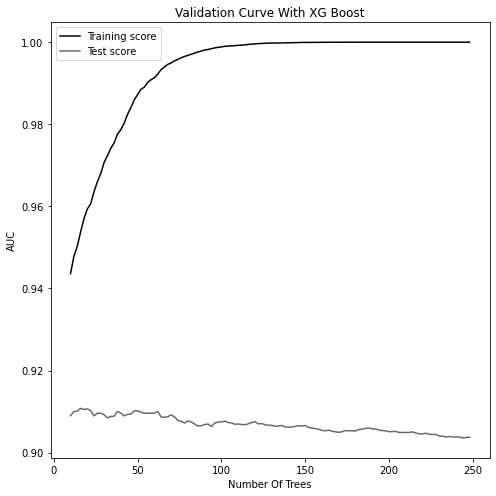

In [89]:
param_range = np.arange(10, 250, 2)
train_scores = []
test_scores = []

for i in param_range:
    xg_reg = xgb.XGBClassifier(**study2.best_params, n_estimators = i)
    xg_reg.fit(X_train, y_train)
    train_scores.append(roc_auc_score(y_train,xg_reg.predict(X_train,output_margin=True)))
    test_scores.append(roc_auc_score(y_test,xg_reg.predict(X_test,output_margin=True)))

import matplotlib.pyplot as plt

plt.subplots(1, figsize = (7,7))
plt.plot(param_range, train_scores, label = "Training score", color = "black")
plt.plot(param_range, test_scores, label = "Test score", color = "dimgrey")

plt.title("Validation Curve With XG Boost")
plt.xlabel("Number Of Trees")
plt.ylabel("AUC")
plt.tight_layout()
plt.legend(loc="best")
plt.show()
    

In [90]:
model = xgb.train(study2.best_params , dtrain, num_boost_round = 600, evals = [(dtest, 'eval')],
                  
          early_stopping_rounds=100,verbose_eval = 1)

[0]	eval-rmse:0.43041
[1]	eval-rmse:0.38858
[2]	eval-rmse:0.36172
[3]	eval-rmse:0.34671
[4]	eval-rmse:0.33694
[5]	eval-rmse:0.32999
[6]	eval-rmse:0.32611
[7]	eval-rmse:0.32371
[8]	eval-rmse:0.32237
[9]	eval-rmse:0.32142
[10]	eval-rmse:0.32063
[11]	eval-rmse:0.31995
[12]	eval-rmse:0.31893
[13]	eval-rmse:0.31860
[14]	eval-rmse:0.31874
[15]	eval-rmse:0.31975
[16]	eval-rmse:0.31978
[17]	eval-rmse:0.31916
[18]	eval-rmse:0.31893
[19]	eval-rmse:0.31899
[20]	eval-rmse:0.31901
[21]	eval-rmse:0.31930
[22]	eval-rmse:0.31899
[23]	eval-rmse:0.31909
[24]	eval-rmse:0.31920
[25]	eval-rmse:0.31888
[26]	eval-rmse:0.31955
[27]	eval-rmse:0.31948
[28]	eval-rmse:0.31938
[29]	eval-rmse:0.31978
[30]	eval-rmse:0.32002
[31]	eval-rmse:0.32004
[32]	eval-rmse:0.32018
[33]	eval-rmse:0.32031
[34]	eval-rmse:0.32061
[35]	eval-rmse:0.32095
[36]	eval-rmse:0.32044
[37]	eval-rmse:0.32005
[38]	eval-rmse:0.32006
[39]	eval-rmse:0.32053
[40]	eval-rmse:0.32072
[41]	eval-rmse:0.32069
[42]	eval-rmse:0.32098
[43]	eval-rmse:0.3209

In [91]:
xgbModel = xgb.XGBClassifier(**study2.best_params)
xgbModel.fit(X_train,y_train)

scoreTrain = xgbModel.score(X_train,y_train)
print(f"Train Accuracy: {scoreTrain}")

scoreTest = xgbModel.score(X_test,y_test)
print(f"Test Accuracy: {scoreTest}")


Train Accuracy: 0.982125
Test Accuracy: 0.862


In [92]:
### BEST TILL NOW. 0.91419 in KAGGLE STUDY2

print("AUC on train data: ", roc_auc_score(y_train,xgbModel.predict(X_train,output_margin=True)))
print("AUC on test data: ", roc_auc_score(y_test,xgbModel.predict(X_test,output_margin=True)))

AUC on train data:  0.9988497788956402
AUC on test data:  0.9074739895243034


In [93]:
# save the model: you must use the .json format for xgboost models!
model_savepath = 'modelXGO.json'
model.save_model(model_savepath)

In [94]:
# generate kaggle submission file using the validation script
!python {"validation.py " + model_savepath + " --Xts_path " + Xts_savepath + " --Xtr_path " + Xtr_savepath + " --yts_hat_path " + yts_hat_savepath }

/Users/utkarsh/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:808: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")
training auc =  0.942682599990056
test label confidences saved in yts_hat_xgboostOptuna.csv
